In [1]:
import numpy as np
import nengo
from nengo import Lowpass
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from network_revised import DotPerception, build_network
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [46]:
def make_hanks_behavior_dataframe():
    # convert original matlab files into a single pandas dataframe
    dfs = []
    columns = ('type', 'id', 'emphasis', 'trial', 'coherence', 'accuracy', 'RT')

    for name in ['E', 'D']:
        if name=='E': emp = scipy.io.loadmat("data/behavData_eli.mat", simplify_cells=True)
        if name=='D': emp = scipy.io.loadmat("data/behavData_dam.mat", simplify_cells=True)
        for e, emphasis in enumerate(['speed', 'accuracy']):
            cond = emp['task'][e]
            coherences = 100*cond['data']['coh']
            accuracies = 100*cond['data']['cor']
            rts = 0.001*cond['data']['rt']
            trials = coherences.shape[0]
            for t in range(trials):
                dfs.append(pd.DataFrame([['monkey', name, emphasis, t, coherences[t], accuracies[t], rts[t]]], columns=columns))

    hanks_behavior = pd.concat(dfs, ignore_index=True)
    hanks_behavior.to_pickle("data/hanks2014_behavior.pkl")

In [47]:
make_hanks_behavior_dataframe()

In [100]:
print(hanks_behavior)

         type id  emphasis  trial  coherence  accuracy        RT
0      monkey  E     speed      0        0.0         0  0.552000
1      monkey  E     speed      1       25.6         0  0.582000
2      monkey  E     speed      2       51.2       100  0.333000
3      monkey  E     speed      3        6.4       100  0.485000
4      monkey  E     speed      4        0.0       100  0.420000
...       ... ..       ...    ...        ...       ...       ...
16407  monkey  D  accuracy   3302       12.8       100  0.339500
16408  monkey  D  accuracy   3303        0.0         0  0.388950
16409  monkey  D  accuracy   3304       25.6       100  0.474850
16410  monkey  D  accuracy   3305       12.8       100  0.431425
16411  monkey  D  accuracy   3306       25.6         0  0.293025

[16412 rows x 7 columns]


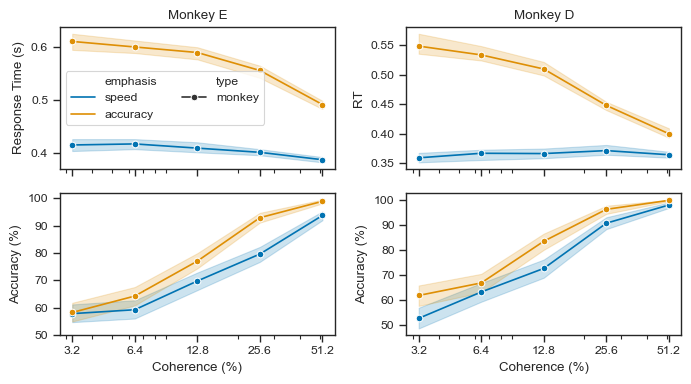

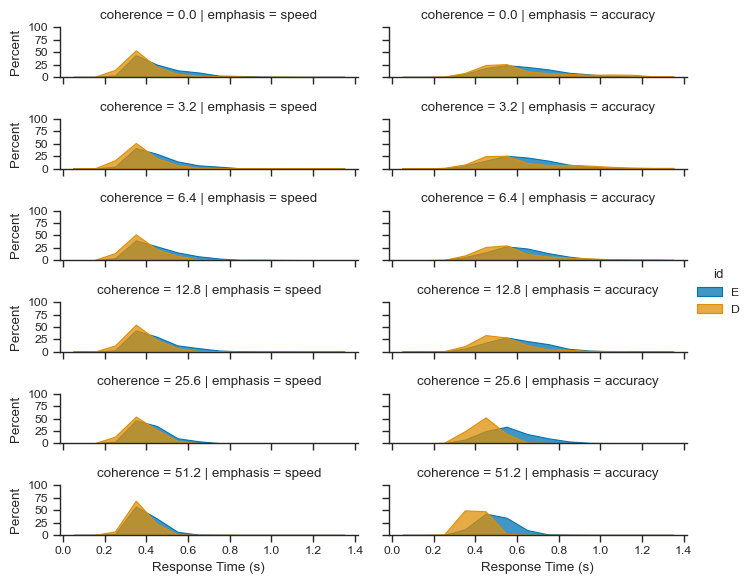

In [80]:
hanks_behavior = pd.read_pickle("data/hanks2014_behavior.pkl")
cohs = 100*np.array([0.032, 0.064, 0.128, 0.256, 0.512])
error = ('ci', 95)
estimator = np.median
bins = np.arange(0, 1.5, 0.1)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=((7.08, 4)))
for pid, name in enumerate(['E', 'D']):
    sns.lineplot(data=hanks_behavior.query("id==@name & coherence>0"), x='coherence', y='RT', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[0][pid],
                 style='type', errorbar=error, estimator=estimator)
    sns.lineplot(data=hanks_behavior.query("id==@name & coherence>0"), x='coherence', y='accuracy', hue='emphasis',
                 style='type', palette=palette[:2], markers=True, ax=axes[1][pid])
    axes[0][pid].set(title=f"Monkey {name}")
axes[0][0].set(ylabel="Response Time (s)")
axes[0][0].legend(ncols=2)
axes[1][0].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)", yticks=[50,60,70,80,90,100])
axes[1][1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)", yticks=[50,60,70,80,90,100])
axes[0][1].get_legend().remove()
axes[1][0].get_legend().remove()
axes[1][1].get_legend().remove()
plt.tight_layout()
fig.savefig(f"plots/hanks_SAT.svg")
fig.savefig(f"plots/hanks_SAT.png", dpi=600)

fig = sns.FacetGrid(hanks_behavior, col='emphasis', row="coherence", hue='id', palette=palette[:2], height=1, aspect=3.5, sharex=True, legend_out=True)
fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins)
fig.set_xlabels("Response Time (s)")
fig.set(xticks=bins[::2])
fig.set(yticks=[0,25,50,75,100])
fig.add_legend()
fig.savefig(f"plots/hanks_RTs.svg")
fig.savefig(f"plots/hanks_RTs.png", dpi=600)

# Simulate

In [50]:
def chi_squared_distance(a,b):
    distance = 0
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    return distance

def get_loss(simulated, empirical, coherences, emphases, bins):
    total_loss = 0
    for emphasis in emphases:
        for coherence in coherences:
            rts_sim = simulated.query("emphasis==@emphasis & coherence==@coherence")['RT'].to_numpy()
            rts_emp = empirical.query("emphasis==@emphasis & coherence==@coherence")['RT'].to_numpy()
            hist_rts_sim = np.histogram(rts_sim, bins=bins)[0]
            hist_rts_emp = np.histogram(rts_emp, bins=bins)[0]
            normed_hist_rts_sim = hist_rts_sim / len(rts_sim)
            normed_hist_rts_emp = hist_rts_emp / len(rts_emp)
            chi_loss = np.around(chi_squared_distance(normed_hist_rts_sim, normed_hist_rts_emp), 3)
            mean_loss = np.around(np.abs(np.mean(rts_sim) - np.mean(rts_emp)), 3)
            median_loss = np.around(np.abs(np.median(rts_sim) - np.median(rts_emp)), 3)
            total_loss += chi_loss
            total_loss += median_loss
            total_loss += mean_loss
            print('emph', emphasis, 'coh', coherence, 'chi', chi_loss, 'med', median_loss, 'mean', mean_loss)
    return total_loss

emphasis speed, coherence 0.0, trial 0, RT 0.425
emphasis speed, coherence 0.0, trial 1, RT 0.364
emphasis speed, coherence 0.0, trial 2, RT 0.40700000000000003
emphasis speed, coherence 0.0, trial 3, RT 0.299
emphasis speed, coherence 0.0, trial 4, RT 0.549
emphasis speed, coherence 0.0, trial 5, RT 0.499
emphasis speed, coherence 0.0, trial 6, RT 0.384
emphasis speed, coherence 0.0, trial 7, RT 0.363
emphasis speed, coherence 0.0, trial 8, RT 0.41200000000000003
emphasis speed, coherence 0.0, trial 9, RT 0.539
emphasis speed, coherence 0.0, trial 10, RT 0.372
emphasis speed, coherence 0.0, trial 11, RT 0.504
emphasis speed, coherence 0.0, trial 12, RT 0.40900000000000003
emphasis speed, coherence 0.0, trial 13, RT 0.5640000000000001
emphasis speed, coherence 0.0, trial 14, RT 0.43
emphasis speed, coherence 0.0, trial 15, RT 0.556
emphasis speed, coherence 0.0, trial 16, RT 0.354
emphasis speed, coherence 0.0, trial 17, RT 0.437
emphasis speed, coherence 0.0, trial 18, RT 0.451
emphas

emphasis speed, coherence 0.0, trial 156, RT 0.543
emphasis speed, coherence 0.0, trial 157, RT 0.423
emphasis speed, coherence 0.0, trial 158, RT 0.321
emphasis speed, coherence 0.0, trial 159, RT 0.461
emphasis speed, coherence 0.0, trial 160, RT 0.359
emphasis speed, coherence 0.0, trial 161, RT 0.597
emphasis speed, coherence 0.0, trial 162, RT 0.381
emphasis speed, coherence 0.0, trial 163, RT 0.456
emphasis speed, coherence 0.0, trial 164, RT 0.381
emphasis speed, coherence 0.0, trial 165, RT 0.399
emphasis speed, coherence 0.0, trial 166, RT 0.607
emphasis speed, coherence 0.0, trial 167, RT 0.406
emphasis speed, coherence 0.0, trial 168, RT 0.669
emphasis speed, coherence 0.0, trial 169, RT 0.359
emphasis speed, coherence 0.0, trial 170, RT 0.468
emphasis speed, coherence 0.0, trial 171, RT 0.45
emphasis speed, coherence 0.0, trial 172, RT 0.399
emphasis speed, coherence 0.0, trial 173, RT 0.379
emphasis speed, coherence 0.0, trial 174, RT 0.424
emphasis speed, coherence 0.0, t

emphasis speed, coherence 0.0, trial 311, RT 0.558
emphasis speed, coherence 0.0, trial 312, RT 0.501
emphasis speed, coherence 0.0, trial 313, RT 0.459
emphasis speed, coherence 0.0, trial 314, RT 0.439
emphasis speed, coherence 0.0, trial 315, RT 0.551
emphasis speed, coherence 0.0, trial 316, RT 0.53
emphasis speed, coherence 0.0, trial 317, RT 0.40700000000000003
emphasis speed, coherence 0.0, trial 318, RT 0.589
emphasis speed, coherence 0.0, trial 319, RT 0.707
emphasis speed, coherence 0.0, trial 320, RT 0.438
emphasis speed, coherence 0.0, trial 321, RT 0.483
emphasis speed, coherence 0.0, trial 322, RT 0.495
emphasis speed, coherence 0.0, trial 323, RT 0.338
emphasis speed, coherence 0.0, trial 324, RT 0.334
emphasis speed, coherence 0.0, trial 325, RT 0.32
emphasis speed, coherence 0.0, trial 326, RT 0.311
emphasis speed, coherence 0.0, trial 327, RT 0.365
emphasis speed, coherence 0.0, trial 328, RT 0.47700000000000004
emphasis speed, coherence 0.0, trial 329, RT 0.409000000

emphasis speed, coherence 0.032, trial 65, RT 0.452
emphasis speed, coherence 0.032, trial 66, RT 0.34600000000000003
emphasis speed, coherence 0.032, trial 67, RT 0.392
emphasis speed, coherence 0.032, trial 68, RT 0.331
emphasis speed, coherence 0.032, trial 69, RT 0.326
emphasis speed, coherence 0.032, trial 70, RT 0.358
emphasis speed, coherence 0.032, trial 71, RT 0.358
emphasis speed, coherence 0.032, trial 72, RT 0.40900000000000003
emphasis speed, coherence 0.032, trial 73, RT 0.338
emphasis speed, coherence 0.032, trial 74, RT 0.305
emphasis speed, coherence 0.032, trial 75, RT 0.47700000000000004
emphasis speed, coherence 0.032, trial 76, RT 0.34500000000000003
emphasis speed, coherence 0.032, trial 77, RT 0.609
emphasis speed, coherence 0.032, trial 78, RT 0.352
emphasis speed, coherence 0.032, trial 79, RT 0.433
emphasis speed, coherence 0.032, trial 80, RT 0.368
emphasis speed, coherence 0.032, trial 81, RT 0.355
emphasis speed, coherence 0.032, trial 82, RT 0.556
emphasis

emphasis speed, coherence 0.032, trial 215, RT 0.511
emphasis speed, coherence 0.032, trial 216, RT 0.482
emphasis speed, coherence 0.032, trial 217, RT 0.468
emphasis speed, coherence 0.032, trial 218, RT 0.527
emphasis speed, coherence 0.032, trial 219, RT 0.425
emphasis speed, coherence 0.032, trial 220, RT 0.44
emphasis speed, coherence 0.032, trial 221, RT 0.492
emphasis speed, coherence 0.032, trial 222, RT 0.531
emphasis speed, coherence 0.032, trial 223, RT 0.313
emphasis speed, coherence 0.032, trial 224, RT 0.427
emphasis speed, coherence 0.032, trial 225, RT 0.529
emphasis speed, coherence 0.032, trial 226, RT 0.341
emphasis speed, coherence 0.032, trial 227, RT 0.531
emphasis speed, coherence 0.032, trial 228, RT 0.458
emphasis speed, coherence 0.032, trial 229, RT 0.46
emphasis speed, coherence 0.032, trial 230, RT 0.6
emphasis speed, coherence 0.032, trial 231, RT 0.359
emphasis speed, coherence 0.032, trial 232, RT 0.40900000000000003
emphasis speed, coherence 0.032, tri

emphasis speed, coherence 0.032, trial 366, RT 0.425
emphasis speed, coherence 0.032, trial 367, RT 0.48
emphasis speed, coherence 0.032, trial 368, RT 0.48
emphasis speed, coherence 0.032, trial 369, RT 0.534
emphasis speed, coherence 0.032, trial 370, RT 0.41500000000000004
emphasis speed, coherence 0.032, trial 371, RT 0.388
emphasis speed, coherence 0.032, trial 372, RT 0.421
emphasis speed, coherence 0.032, trial 373, RT 0.361
emphasis speed, coherence 0.032, trial 374, RT 0.393
emphasis speed, coherence 0.032, trial 375, RT 0.436
emphasis speed, coherence 0.032, trial 376, RT 0.539
emphasis speed, coherence 0.032, trial 377, RT 0.375
emphasis speed, coherence 0.032, trial 378, RT 0.40700000000000003
emphasis speed, coherence 0.032, trial 379, RT 0.684
emphasis speed, coherence 0.032, trial 380, RT 0.405
emphasis speed, coherence 0.032, trial 381, RT 0.281
emphasis speed, coherence 0.032, trial 382, RT 0.402
emphasis speed, coherence 0.032, trial 383, RT 0.457
emphasis speed, cohe

emphasis speed, coherence 0.064, trial 117, RT 0.334
emphasis speed, coherence 0.064, trial 118, RT 0.356
emphasis speed, coherence 0.064, trial 119, RT 0.4
emphasis speed, coherence 0.064, trial 120, RT 0.516
emphasis speed, coherence 0.064, trial 121, RT 0.419
emphasis speed, coherence 0.064, trial 122, RT 0.375
emphasis speed, coherence 0.064, trial 123, RT 0.736
emphasis speed, coherence 0.064, trial 124, RT 0.46900000000000003
emphasis speed, coherence 0.064, trial 125, RT 0.457
emphasis speed, coherence 0.064, trial 126, RT 0.434
emphasis speed, coherence 0.064, trial 127, RT 0.632
emphasis speed, coherence 0.064, trial 128, RT 0.41300000000000003
emphasis speed, coherence 0.064, trial 129, RT 0.343
emphasis speed, coherence 0.064, trial 130, RT 0.47100000000000003
emphasis speed, coherence 0.064, trial 131, RT 0.533
emphasis speed, coherence 0.064, trial 132, RT 0.436
emphasis speed, coherence 0.064, trial 133, RT 0.28500000000000003
emphasis speed, coherence 0.064, trial 134, R

emphasis speed, coherence 0.064, trial 266, RT 0.5640000000000001
emphasis speed, coherence 0.064, trial 267, RT 0.395
emphasis speed, coherence 0.064, trial 268, RT 0.41400000000000003
emphasis speed, coherence 0.064, trial 269, RT 0.488
emphasis speed, coherence 0.064, trial 270, RT 0.421
emphasis speed, coherence 0.064, trial 271, RT 0.666
emphasis speed, coherence 0.064, trial 272, RT 0.39
emphasis speed, coherence 0.064, trial 273, RT 0.465
emphasis speed, coherence 0.064, trial 274, RT 0.453
emphasis speed, coherence 0.064, trial 275, RT 0.367
emphasis speed, coherence 0.064, trial 276, RT 0.38
emphasis speed, coherence 0.064, trial 277, RT 0.454
emphasis speed, coherence 0.064, trial 278, RT 0.499
emphasis speed, coherence 0.064, trial 279, RT 0.386
emphasis speed, coherence 0.064, trial 280, RT 0.34
emphasis speed, coherence 0.064, trial 281, RT 0.481
emphasis speed, coherence 0.064, trial 282, RT 0.506
emphasis speed, coherence 0.064, trial 283, RT 0.367
emphasis speed, cohere

emphasis speed, coherence 0.128, trial 16, RT 0.378
emphasis speed, coherence 0.128, trial 17, RT 0.447
emphasis speed, coherence 0.128, trial 18, RT 0.27
emphasis speed, coherence 0.128, trial 19, RT 0.47800000000000004
emphasis speed, coherence 0.128, trial 20, RT 0.444
emphasis speed, coherence 0.128, trial 21, RT 0.326
emphasis speed, coherence 0.128, trial 22, RT 0.455
emphasis speed, coherence 0.128, trial 23, RT 0.454
emphasis speed, coherence 0.128, trial 24, RT 0.34400000000000003
emphasis speed, coherence 0.128, trial 25, RT 0.463
emphasis speed, coherence 0.128, trial 26, RT 0.46
emphasis speed, coherence 0.128, trial 27, RT 0.40900000000000003
emphasis speed, coherence 0.128, trial 28, RT 0.302
emphasis speed, coherence 0.128, trial 29, RT 0.462
emphasis speed, coherence 0.128, trial 30, RT 0.41100000000000003
emphasis speed, coherence 0.128, trial 31, RT 0.387
emphasis speed, coherence 0.128, trial 32, RT 0.467
emphasis speed, coherence 0.128, trial 33, RT 0.485
emphasis s

emphasis speed, coherence 0.128, trial 164, RT 0.319
emphasis speed, coherence 0.128, trial 165, RT 0.49
emphasis speed, coherence 0.128, trial 166, RT 0.47000000000000003
emphasis speed, coherence 0.128, trial 167, RT 0.382
emphasis speed, coherence 0.128, trial 168, RT 0.54
emphasis speed, coherence 0.128, trial 169, RT 0.34400000000000003
emphasis speed, coherence 0.128, trial 170, RT 0.342
emphasis speed, coherence 0.128, trial 171, RT 0.293
emphasis speed, coherence 0.128, trial 172, RT 0.422
emphasis speed, coherence 0.128, trial 173, RT 0.466
emphasis speed, coherence 0.128, trial 174, RT 0.361
emphasis speed, coherence 0.128, trial 175, RT 0.375
emphasis speed, coherence 0.128, trial 176, RT 0.392
emphasis speed, coherence 0.128, trial 177, RT 0.577
emphasis speed, coherence 0.128, trial 178, RT 0.386
emphasis speed, coherence 0.128, trial 179, RT 0.399
emphasis speed, coherence 0.128, trial 180, RT 0.37
emphasis speed, coherence 0.128, trial 181, RT 0.431
emphasis speed, coher

emphasis speed, coherence 0.128, trial 313, RT 0.432
emphasis speed, coherence 0.128, trial 314, RT 0.438
emphasis speed, coherence 0.128, trial 315, RT 0.393
emphasis speed, coherence 0.128, trial 316, RT 0.33
emphasis speed, coherence 0.128, trial 317, RT 0.494
emphasis speed, coherence 0.128, trial 318, RT 0.499
emphasis speed, coherence 0.128, trial 319, RT 0.41300000000000003
emphasis speed, coherence 0.128, trial 320, RT 0.394
emphasis speed, coherence 0.128, trial 321, RT 0.54
emphasis speed, coherence 0.128, trial 322, RT 0.40700000000000003
emphasis speed, coherence 0.128, trial 323, RT 0.341
emphasis speed, coherence 0.128, trial 324, RT 0.273
emphasis speed, coherence 0.128, trial 325, RT 0.382
emphasis speed, coherence 0.128, trial 326, RT 0.589
emphasis speed, coherence 0.128, trial 327, RT 0.427
emphasis speed, coherence 0.128, trial 328, RT 0.454
emphasis speed, coherence 0.128, trial 329, RT 0.331
emphasis speed, coherence 0.128, trial 330, RT 0.511
emphasis speed, cohe

emphasis speed, coherence 0.256, trial 65, RT 0.498
emphasis speed, coherence 0.256, trial 66, RT 0.47800000000000004
emphasis speed, coherence 0.256, trial 67, RT 0.394
emphasis speed, coherence 0.256, trial 68, RT 0.55
emphasis speed, coherence 0.256, trial 69, RT 0.45
emphasis speed, coherence 0.256, trial 70, RT 0.357
emphasis speed, coherence 0.256, trial 71, RT 0.291
emphasis speed, coherence 0.256, trial 72, RT 0.421
emphasis speed, coherence 0.256, trial 73, RT 0.489
emphasis speed, coherence 0.256, trial 74, RT 0.426
emphasis speed, coherence 0.256, trial 75, RT 0.436
emphasis speed, coherence 0.256, trial 76, RT 0.395
emphasis speed, coherence 0.256, trial 77, RT 0.362
emphasis speed, coherence 0.256, trial 78, RT 0.40700000000000003
emphasis speed, coherence 0.256, trial 79, RT 0.357
emphasis speed, coherence 0.256, trial 80, RT 0.318
emphasis speed, coherence 0.256, trial 81, RT 0.365
emphasis speed, coherence 0.256, trial 82, RT 0.42
emphasis speed, coherence 0.256, trial 

emphasis speed, coherence 0.256, trial 215, RT 0.486
emphasis speed, coherence 0.256, trial 216, RT 0.376
emphasis speed, coherence 0.256, trial 217, RT 0.632
emphasis speed, coherence 0.256, trial 218, RT 0.342
emphasis speed, coherence 0.256, trial 219, RT 0.583
emphasis speed, coherence 0.256, trial 220, RT 0.393
emphasis speed, coherence 0.256, trial 221, RT 0.4
emphasis speed, coherence 0.256, trial 222, RT 0.40900000000000003
emphasis speed, coherence 0.256, trial 223, RT 0.35100000000000003
emphasis speed, coherence 0.256, trial 224, RT 0.354
emphasis speed, coherence 0.256, trial 225, RT 0.332
emphasis speed, coherence 0.256, trial 226, RT 0.423
emphasis speed, coherence 0.256, trial 227, RT 0.358
emphasis speed, coherence 0.256, trial 228, RT 0.612
emphasis speed, coherence 0.256, trial 229, RT 0.389
emphasis speed, coherence 0.256, trial 230, RT 0.35000000000000003
emphasis speed, coherence 0.256, trial 231, RT 0.431
emphasis speed, coherence 0.256, trial 232, RT 0.45
emphasi

emphasis speed, coherence 0.256, trial 365, RT 0.521
emphasis speed, coherence 0.256, trial 366, RT 0.428
emphasis speed, coherence 0.256, trial 367, RT 0.431
emphasis speed, coherence 0.256, trial 368, RT 0.368
emphasis speed, coherence 0.256, trial 369, RT 0.321
emphasis speed, coherence 0.256, trial 370, RT 0.425
emphasis speed, coherence 0.256, trial 371, RT 0.23600000000000002
emphasis speed, coherence 0.256, trial 372, RT 0.442
emphasis speed, coherence 0.256, trial 373, RT 0.436
emphasis speed, coherence 0.256, trial 374, RT 0.318
emphasis speed, coherence 0.256, trial 375, RT 0.378
emphasis speed, coherence 0.256, trial 376, RT 0.331
emphasis speed, coherence 0.256, trial 377, RT 0.4
emphasis speed, coherence 0.256, trial 378, RT 0.621
emphasis speed, coherence 0.256, trial 379, RT 0.36
emphasis speed, coherence 0.256, trial 380, RT 0.322
emphasis speed, coherence 0.256, trial 381, RT 0.336
emphasis speed, coherence 0.256, trial 382, RT 0.58
emphasis speed, coherence 0.256, tri

emphasis speed, coherence 0.512, trial 118, RT 0.358
emphasis speed, coherence 0.512, trial 119, RT 0.306
emphasis speed, coherence 0.512, trial 120, RT 0.34600000000000003
emphasis speed, coherence 0.512, trial 121, RT 0.301
emphasis speed, coherence 0.512, trial 122, RT 0.42
emphasis speed, coherence 0.512, trial 123, RT 0.404
emphasis speed, coherence 0.512, trial 124, RT 0.326
emphasis speed, coherence 0.512, trial 125, RT 0.369
emphasis speed, coherence 0.512, trial 126, RT 0.34500000000000003
emphasis speed, coherence 0.512, trial 127, RT 0.426
emphasis speed, coherence 0.512, trial 128, RT 0.404
emphasis speed, coherence 0.512, trial 129, RT 0.3
emphasis speed, coherence 0.512, trial 130, RT 0.265
emphasis speed, coherence 0.512, trial 131, RT 0.388
emphasis speed, coherence 0.512, trial 132, RT 0.437
emphasis speed, coherence 0.512, trial 133, RT 0.312
emphasis speed, coherence 0.512, trial 134, RT 0.34
emphasis speed, coherence 0.512, trial 135, RT 0.323
emphasis speed, cohere

emphasis speed, coherence 0.512, trial 267, RT 0.339
emphasis speed, coherence 0.512, trial 268, RT 0.369
emphasis speed, coherence 0.512, trial 269, RT 0.333
emphasis speed, coherence 0.512, trial 270, RT 0.332
emphasis speed, coherence 0.512, trial 271, RT 0.365
emphasis speed, coherence 0.512, trial 272, RT 0.376
emphasis speed, coherence 0.512, trial 273, RT 0.353
emphasis speed, coherence 0.512, trial 274, RT 0.28600000000000003
emphasis speed, coherence 0.512, trial 275, RT 0.353
emphasis speed, coherence 0.512, trial 276, RT 0.432
emphasis speed, coherence 0.512, trial 277, RT 0.404
emphasis speed, coherence 0.512, trial 278, RT 0.398
emphasis speed, coherence 0.512, trial 279, RT 0.267
emphasis speed, coherence 0.512, trial 280, RT 0.293
emphasis speed, coherence 0.512, trial 281, RT 0.343
emphasis speed, coherence 0.512, trial 282, RT 0.339
emphasis speed, coherence 0.512, trial 283, RT 0.292
emphasis speed, coherence 0.512, trial 284, RT 0.357
emphasis speed, coherence 0.512,

/tmp/ipykernel_25857/150977287.py:60: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='RT', hue='emphasis',
/tmp/ipykernel_25857/150977287.py:63: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='accuracy', hue='emphasis',


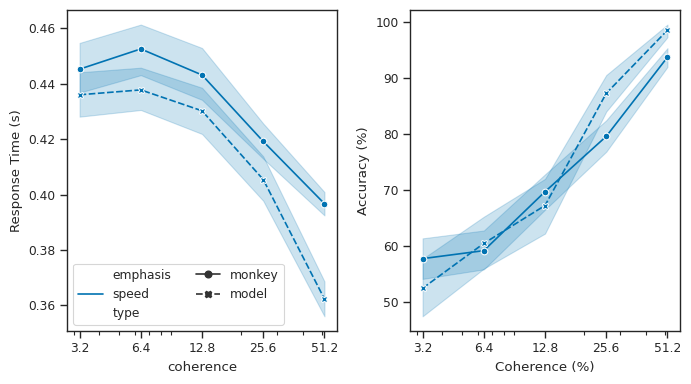

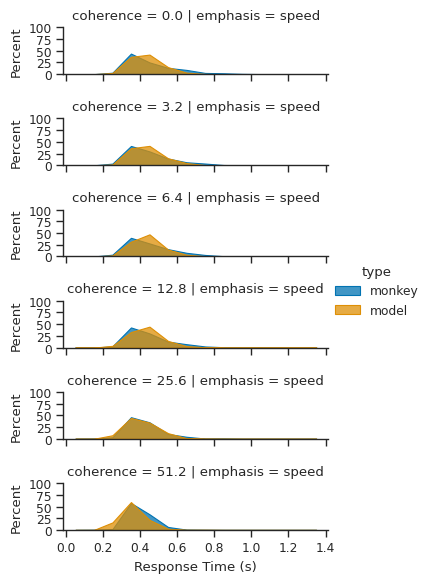

In [20]:
simulate(ramp=0.64, relative=0.0, threshold=0.12, trials=400, load=False, estimator=np.mean, name="dec25speed", emphases=['speed'])

emphasis accuracy, coherence 0.0, trial 0, RT 0.505
emphasis accuracy, coherence 0.0, trial 1, RT 0.61
emphasis accuracy, coherence 0.0, trial 2, RT 0.73
emphasis accuracy, coherence 0.0, trial 3, RT 0.483
emphasis accuracy, coherence 0.0, trial 4, RT 0.497
emphasis accuracy, coherence 0.0, trial 5, RT 0.779
emphasis accuracy, coherence 0.0, trial 6, RT 0.465
emphasis accuracy, coherence 0.0, trial 7, RT 0.51
emphasis accuracy, coherence 0.0, trial 8, RT 0.545
emphasis accuracy, coherence 0.0, trial 9, RT 0.9480000000000001
emphasis accuracy, coherence 0.0, trial 10, RT 0.589
emphasis accuracy, coherence 0.0, trial 11, RT 0.8300000000000001
emphasis accuracy, coherence 0.0, trial 12, RT 0.834
emphasis accuracy, coherence 0.0, trial 13, RT 0.886
emphasis accuracy, coherence 0.0, trial 14, RT 0.552
emphasis accuracy, coherence 0.0, trial 15, RT 0.723
emphasis accuracy, coherence 0.0, trial 16, RT 0.506
emphasis accuracy, coherence 0.0, trial 17, RT 0.544
emphasis accuracy, coherence 0.0,

emphasis accuracy, coherence 0.0, trial 150, RT 0.5740000000000001
emphasis accuracy, coherence 0.0, trial 151, RT 0.682
emphasis accuracy, coherence 0.0, trial 152, RT 0.521
emphasis accuracy, coherence 0.0, trial 153, RT 0.399
emphasis accuracy, coherence 0.0, trial 154, RT 0.653
emphasis accuracy, coherence 0.0, trial 155, RT 0.5660000000000001
emphasis accuracy, coherence 0.0, trial 156, RT 0.597
emphasis accuracy, coherence 0.0, trial 157, RT 0.519
emphasis accuracy, coherence 0.0, trial 158, RT 0.798
emphasis accuracy, coherence 0.0, trial 159, RT 0.644
emphasis accuracy, coherence 0.0, trial 160, RT 0.796
emphasis accuracy, coherence 0.0, trial 161, RT 0.725
emphasis accuracy, coherence 0.0, trial 162, RT 0.621
emphasis accuracy, coherence 0.0, trial 163, RT 0.778
emphasis accuracy, coherence 0.0, trial 164, RT 0.684
emphasis accuracy, coherence 0.0, trial 165, RT 0.798
emphasis accuracy, coherence 0.0, trial 166, RT 0.603
emphasis accuracy, coherence 0.0, trial 167, RT 0.563000

emphasis accuracy, coherence 0.0, trial 298, RT 0.781
emphasis accuracy, coherence 0.0, trial 299, RT 0.463
emphasis accuracy, coherence 0.0, trial 300, RT 0.446
emphasis accuracy, coherence 0.0, trial 301, RT 0.667
emphasis accuracy, coherence 0.0, trial 302, RT 0.603
emphasis accuracy, coherence 0.0, trial 303, RT 0.591
emphasis accuracy, coherence 0.0, trial 304, RT 0.584
emphasis accuracy, coherence 0.0, trial 305, RT 0.787
emphasis accuracy, coherence 0.0, trial 306, RT 0.592
emphasis accuracy, coherence 0.0, trial 307, RT 0.592
emphasis accuracy, coherence 0.0, trial 308, RT 0.607
emphasis accuracy, coherence 0.0, trial 309, RT 0.896
emphasis accuracy, coherence 0.0, trial 310, RT 0.59
emphasis accuracy, coherence 0.0, trial 311, RT 0.6970000000000001
emphasis accuracy, coherence 0.0, trial 312, RT 0.593
emphasis accuracy, coherence 0.0, trial 313, RT 0.6880000000000001
emphasis accuracy, coherence 0.0, trial 314, RT 0.729
emphasis accuracy, coherence 0.0, trial 315, RT 0.71
emph

emphasis accuracy, coherence 0.032, trial 46, RT 0.501
emphasis accuracy, coherence 0.032, trial 47, RT 0.504
emphasis accuracy, coherence 0.032, trial 48, RT 0.587
emphasis accuracy, coherence 0.032, trial 49, RT 0.767
emphasis accuracy, coherence 0.032, trial 50, RT 0.76
emphasis accuracy, coherence 0.032, trial 51, RT 0.607
emphasis accuracy, coherence 0.032, trial 52, RT 0.662
emphasis accuracy, coherence 0.032, trial 53, RT 0.5750000000000001
emphasis accuracy, coherence 0.032, trial 54, RT 0.798
emphasis accuracy, coherence 0.032, trial 55, RT 0.49
emphasis accuracy, coherence 0.032, trial 56, RT 0.605
emphasis accuracy, coherence 0.032, trial 57, RT 0.552
emphasis accuracy, coherence 0.032, trial 58, RT 0.744
emphasis accuracy, coherence 0.032, trial 59, RT 0.47200000000000003
emphasis accuracy, coherence 0.032, trial 60, RT 0.658
emphasis accuracy, coherence 0.032, trial 61, RT 0.47200000000000003
emphasis accuracy, coherence 0.032, trial 62, RT 0.47400000000000003
emphasis acc

emphasis accuracy, coherence 0.032, trial 189, RT 0.539
emphasis accuracy, coherence 0.032, trial 190, RT 0.8220000000000001
emphasis accuracy, coherence 0.032, trial 191, RT 0.591
emphasis accuracy, coherence 0.032, trial 192, RT 0.529
emphasis accuracy, coherence 0.032, trial 193, RT 0.47300000000000003
emphasis accuracy, coherence 0.032, trial 194, RT 0.6980000000000001
emphasis accuracy, coherence 0.032, trial 195, RT 0.604
emphasis accuracy, coherence 0.032, trial 196, RT 0.491
emphasis accuracy, coherence 0.032, trial 197, RT 0.423
emphasis accuracy, coherence 0.032, trial 198, RT 0.545
emphasis accuracy, coherence 0.032, trial 199, RT 0.735
emphasis accuracy, coherence 0.032, trial 200, RT 0.511
emphasis accuracy, coherence 0.032, trial 201, RT 0.433
emphasis accuracy, coherence 0.032, trial 202, RT 0.762
emphasis accuracy, coherence 0.032, trial 203, RT 0.631
emphasis accuracy, coherence 0.032, trial 204, RT 0.608
emphasis accuracy, coherence 0.032, trial 205, RT 0.763
emphasis

emphasis accuracy, coherence 0.032, trial 332, RT 0.656
emphasis accuracy, coherence 0.032, trial 333, RT 0.532
emphasis accuracy, coherence 0.032, trial 334, RT 0.605
emphasis accuracy, coherence 0.032, trial 335, RT 0.608
emphasis accuracy, coherence 0.032, trial 336, RT 0.761
emphasis accuracy, coherence 0.032, trial 337, RT 0.611
emphasis accuracy, coherence 0.032, trial 338, RT 0.558
emphasis accuracy, coherence 0.032, trial 339, RT 0.587
emphasis accuracy, coherence 0.032, trial 340, RT 0.605
emphasis accuracy, coherence 0.032, trial 341, RT 0.736
emphasis accuracy, coherence 0.032, trial 342, RT 0.8170000000000001
emphasis accuracy, coherence 0.032, trial 343, RT 0.739
emphasis accuracy, coherence 0.032, trial 344, RT 0.603
emphasis accuracy, coherence 0.032, trial 345, RT 0.621
emphasis accuracy, coherence 0.032, trial 346, RT 0.747
emphasis accuracy, coherence 0.032, trial 347, RT 0.745
emphasis accuracy, coherence 0.032, trial 348, RT 0.647
emphasis accuracy, coherence 0.032,

emphasis accuracy, coherence 0.064, trial 76, RT 0.441
emphasis accuracy, coherence 0.064, trial 77, RT 0.725
emphasis accuracy, coherence 0.064, trial 78, RT 0.709
emphasis accuracy, coherence 0.064, trial 79, RT 0.596
emphasis accuracy, coherence 0.064, trial 80, RT 0.546
emphasis accuracy, coherence 0.064, trial 81, RT 0.518
emphasis accuracy, coherence 0.064, trial 82, RT 0.584
emphasis accuracy, coherence 0.064, trial 83, RT 0.613
emphasis accuracy, coherence 0.064, trial 84, RT 0.717
emphasis accuracy, coherence 0.064, trial 85, RT 0.772
emphasis accuracy, coherence 0.064, trial 86, RT 0.615
emphasis accuracy, coherence 0.064, trial 87, RT 0.6970000000000001
emphasis accuracy, coherence 0.064, trial 88, RT 0.645
emphasis accuracy, coherence 0.064, trial 89, RT 0.559
emphasis accuracy, coherence 0.064, trial 90, RT 0.625
emphasis accuracy, coherence 0.064, trial 91, RT 0.579
emphasis accuracy, coherence 0.064, trial 92, RT 0.627
emphasis accuracy, coherence 0.064, trial 93, RT 0.6

emphasis accuracy, coherence 0.064, trial 220, RT 0.598
emphasis accuracy, coherence 0.064, trial 221, RT 0.483
emphasis accuracy, coherence 0.064, trial 222, RT 0.8320000000000001
emphasis accuracy, coherence 0.064, trial 223, RT 0.609
emphasis accuracy, coherence 0.064, trial 224, RT 0.551
emphasis accuracy, coherence 0.064, trial 225, RT 0.649
emphasis accuracy, coherence 0.064, trial 226, RT 0.753
emphasis accuracy, coherence 0.064, trial 227, RT 0.53
emphasis accuracy, coherence 0.064, trial 228, RT 0.589
emphasis accuracy, coherence 0.064, trial 229, RT 0.398
emphasis accuracy, coherence 0.064, trial 230, RT 0.684
emphasis accuracy, coherence 0.064, trial 231, RT 0.535
emphasis accuracy, coherence 0.064, trial 232, RT 0.638
emphasis accuracy, coherence 0.064, trial 233, RT 0.545
emphasis accuracy, coherence 0.064, trial 234, RT 0.8290000000000001
emphasis accuracy, coherence 0.064, trial 235, RT 0.723
emphasis accuracy, coherence 0.064, trial 236, RT 0.558
emphasis accuracy, cohe

emphasis accuracy, coherence 0.064, trial 362, RT 0.75
emphasis accuracy, coherence 0.064, trial 363, RT 0.388
emphasis accuracy, coherence 0.064, trial 364, RT 0.512
emphasis accuracy, coherence 0.064, trial 365, RT 0.646
emphasis accuracy, coherence 0.064, trial 366, RT 0.548
emphasis accuracy, coherence 0.064, trial 367, RT 0.539
emphasis accuracy, coherence 0.064, trial 368, RT 0.536
emphasis accuracy, coherence 0.064, trial 369, RT 0.684
emphasis accuracy, coherence 0.064, trial 370, RT 0.8260000000000001
emphasis accuracy, coherence 0.064, trial 371, RT 0.614
emphasis accuracy, coherence 0.064, trial 372, RT 0.752
emphasis accuracy, coherence 0.064, trial 373, RT 0.803
emphasis accuracy, coherence 0.064, trial 374, RT 0.639
emphasis accuracy, coherence 0.064, trial 375, RT 0.725
emphasis accuracy, coherence 0.064, trial 376, RT 0.452
emphasis accuracy, coherence 0.064, trial 377, RT 0.725
emphasis accuracy, coherence 0.064, trial 378, RT 0.725
emphasis accuracy, coherence 0.064, 

emphasis accuracy, coherence 0.128, trial 106, RT 0.671
emphasis accuracy, coherence 0.128, trial 107, RT 0.497
emphasis accuracy, coherence 0.128, trial 108, RT 0.558
emphasis accuracy, coherence 0.128, trial 109, RT 0.528
emphasis accuracy, coherence 0.128, trial 110, RT 0.425
emphasis accuracy, coherence 0.128, trial 111, RT 0.607
emphasis accuracy, coherence 0.128, trial 112, RT 0.683
emphasis accuracy, coherence 0.128, trial 113, RT 0.5750000000000001
emphasis accuracy, coherence 0.128, trial 114, RT 0.711
emphasis accuracy, coherence 0.128, trial 115, RT 0.59
emphasis accuracy, coherence 0.128, trial 116, RT 0.8140000000000001
emphasis accuracy, coherence 0.128, trial 117, RT 0.641
emphasis accuracy, coherence 0.128, trial 118, RT 0.718
emphasis accuracy, coherence 0.128, trial 119, RT 0.892
emphasis accuracy, coherence 0.128, trial 120, RT 0.548
emphasis accuracy, coherence 0.128, trial 121, RT 0.629
emphasis accuracy, coherence 0.128, trial 122, RT 0.7020000000000001
emphasis a

emphasis accuracy, coherence 0.128, trial 247, RT 0.585
emphasis accuracy, coherence 0.128, trial 248, RT 0.561
emphasis accuracy, coherence 0.128, trial 249, RT 0.6890000000000001
emphasis accuracy, coherence 0.128, trial 250, RT 0.504
emphasis accuracy, coherence 0.128, trial 251, RT 0.667
emphasis accuracy, coherence 0.128, trial 252, RT 0.518
emphasis accuracy, coherence 0.128, trial 253, RT 0.6
emphasis accuracy, coherence 0.128, trial 254, RT 0.74
emphasis accuracy, coherence 0.128, trial 255, RT 0.608
emphasis accuracy, coherence 0.128, trial 256, RT 0.582
emphasis accuracy, coherence 0.128, trial 257, RT 0.521
emphasis accuracy, coherence 0.128, trial 258, RT 0.531
emphasis accuracy, coherence 0.128, trial 259, RT 0.501
emphasis accuracy, coherence 0.128, trial 260, RT 0.519
emphasis accuracy, coherence 0.128, trial 261, RT 0.5640000000000001
emphasis accuracy, coherence 0.128, trial 262, RT 0.656
emphasis accuracy, coherence 0.128, trial 263, RT 0.5710000000000001
emphasis acc

emphasis accuracy, coherence 0.128, trial 390, RT 0.8320000000000001
emphasis accuracy, coherence 0.128, trial 391, RT 0.47400000000000003
emphasis accuracy, coherence 0.128, trial 392, RT 0.455
emphasis accuracy, coherence 0.128, trial 393, RT 0.505
emphasis accuracy, coherence 0.128, trial 394, RT 0.713
emphasis accuracy, coherence 0.128, trial 395, RT 0.716
emphasis accuracy, coherence 0.128, trial 396, RT 0.622
emphasis accuracy, coherence 0.128, trial 397, RT 0.5670000000000001
emphasis accuracy, coherence 0.128, trial 398, RT 0.6920000000000001
emphasis accuracy, coherence 0.128, trial 399, RT 0.587
emphasis accuracy, coherence 0.256, trial 0, RT 0.587
emphasis accuracy, coherence 0.256, trial 1, RT 0.497
emphasis accuracy, coherence 0.256, trial 2, RT 0.403
emphasis accuracy, coherence 0.256, trial 3, RT 0.508
emphasis accuracy, coherence 0.256, trial 4, RT 0.637
emphasis accuracy, coherence 0.256, trial 5, RT 0.47300000000000003
emphasis accuracy, coherence 0.256, trial 6, RT 0

emphasis accuracy, coherence 0.256, trial 134, RT 0.53
emphasis accuracy, coherence 0.256, trial 135, RT 0.548
emphasis accuracy, coherence 0.256, trial 136, RT 0.728
emphasis accuracy, coherence 0.256, trial 137, RT 0.749
emphasis accuracy, coherence 0.256, trial 138, RT 0.397
emphasis accuracy, coherence 0.256, trial 139, RT 0.529
emphasis accuracy, coherence 0.256, trial 140, RT 0.8
emphasis accuracy, coherence 0.256, trial 141, RT 0.43
emphasis accuracy, coherence 0.256, trial 142, RT 0.432
emphasis accuracy, coherence 0.256, trial 143, RT 0.389
emphasis accuracy, coherence 0.256, trial 144, RT 0.431
emphasis accuracy, coherence 0.256, trial 145, RT 0.668
emphasis accuracy, coherence 0.256, trial 146, RT 0.582
emphasis accuracy, coherence 0.256, trial 147, RT 0.657
emphasis accuracy, coherence 0.256, trial 148, RT 0.601
emphasis accuracy, coherence 0.256, trial 149, RT 0.625
emphasis accuracy, coherence 0.256, trial 150, RT 0.511
emphasis accuracy, coherence 0.256, trial 151, RT 0.

emphasis accuracy, coherence 0.256, trial 277, RT 0.394
emphasis accuracy, coherence 0.256, trial 278, RT 0.599
emphasis accuracy, coherence 0.256, trial 279, RT 0.793
emphasis accuracy, coherence 0.256, trial 280, RT 0.635
emphasis accuracy, coherence 0.256, trial 281, RT 0.432
emphasis accuracy, coherence 0.256, trial 282, RT 0.496
emphasis accuracy, coherence 0.256, trial 283, RT 0.451
emphasis accuracy, coherence 0.256, trial 284, RT 0.49
emphasis accuracy, coherence 0.256, trial 285, RT 0.555
emphasis accuracy, coherence 0.256, trial 286, RT 0.544
emphasis accuracy, coherence 0.256, trial 287, RT 0.506
emphasis accuracy, coherence 0.256, trial 288, RT 0.506
emphasis accuracy, coherence 0.256, trial 289, RT 0.526
emphasis accuracy, coherence 0.256, trial 290, RT 0.501
emphasis accuracy, coherence 0.256, trial 291, RT 0.508
emphasis accuracy, coherence 0.256, trial 292, RT 0.786
emphasis accuracy, coherence 0.256, trial 293, RT 0.658
emphasis accuracy, coherence 0.256, trial 294, RT

emphasis accuracy, coherence 0.512, trial 21, RT 0.607
emphasis accuracy, coherence 0.512, trial 22, RT 0.505
emphasis accuracy, coherence 0.512, trial 23, RT 0.404
emphasis accuracy, coherence 0.512, trial 24, RT 0.383
emphasis accuracy, coherence 0.512, trial 25, RT 0.34600000000000003
emphasis accuracy, coherence 0.512, trial 26, RT 0.394
emphasis accuracy, coherence 0.512, trial 27, RT 0.41200000000000003
emphasis accuracy, coherence 0.512, trial 28, RT 0.436
emphasis accuracy, coherence 0.512, trial 29, RT 0.47000000000000003
emphasis accuracy, coherence 0.512, trial 30, RT 0.593
emphasis accuracy, coherence 0.512, trial 31, RT 0.508
emphasis accuracy, coherence 0.512, trial 32, RT 0.418
emphasis accuracy, coherence 0.512, trial 33, RT 0.329
emphasis accuracy, coherence 0.512, trial 34, RT 0.501
emphasis accuracy, coherence 0.512, trial 35, RT 0.398
emphasis accuracy, coherence 0.512, trial 36, RT 0.41100000000000003
emphasis accuracy, coherence 0.512, trial 37, RT 0.645
emphasis 

emphasis accuracy, coherence 0.512, trial 164, RT 0.371
emphasis accuracy, coherence 0.512, trial 165, RT 0.47500000000000003
emphasis accuracy, coherence 0.512, trial 166, RT 0.464
emphasis accuracy, coherence 0.512, trial 167, RT 0.391
emphasis accuracy, coherence 0.512, trial 168, RT 0.37
emphasis accuracy, coherence 0.512, trial 169, RT 0.538
emphasis accuracy, coherence 0.512, trial 170, RT 0.434
emphasis accuracy, coherence 0.512, trial 171, RT 0.419
emphasis accuracy, coherence 0.512, trial 172, RT 0.457
emphasis accuracy, coherence 0.512, trial 173, RT 0.433
emphasis accuracy, coherence 0.512, trial 174, RT 0.464
emphasis accuracy, coherence 0.512, trial 175, RT 0.358
emphasis accuracy, coherence 0.512, trial 176, RT 0.41000000000000003
emphasis accuracy, coherence 0.512, trial 177, RT 0.406
emphasis accuracy, coherence 0.512, trial 178, RT 0.467
emphasis accuracy, coherence 0.512, trial 179, RT 0.46
emphasis accuracy, coherence 0.512, trial 180, RT 0.521
emphasis accuracy, coh

emphasis accuracy, coherence 0.512, trial 307, RT 0.437
emphasis accuracy, coherence 0.512, trial 308, RT 0.397
emphasis accuracy, coherence 0.512, trial 309, RT 0.489
emphasis accuracy, coherence 0.512, trial 310, RT 0.495
emphasis accuracy, coherence 0.512, trial 311, RT 0.383
emphasis accuracy, coherence 0.512, trial 312, RT 0.435
emphasis accuracy, coherence 0.512, trial 313, RT 0.386
emphasis accuracy, coherence 0.512, trial 314, RT 0.485
emphasis accuracy, coherence 0.512, trial 315, RT 0.379
emphasis accuracy, coherence 0.512, trial 316, RT 0.506
emphasis accuracy, coherence 0.512, trial 317, RT 0.378
emphasis accuracy, coherence 0.512, trial 318, RT 0.433
emphasis accuracy, coherence 0.512, trial 319, RT 0.465
emphasis accuracy, coherence 0.512, trial 320, RT 0.467
emphasis accuracy, coherence 0.512, trial 321, RT 0.452
emphasis accuracy, coherence 0.512, trial 322, RT 0.509
emphasis accuracy, coherence 0.512, trial 323, RT 0.463
emphasis accuracy, coherence 0.512, trial 324, R

/tmp/ipykernel_25857/150977287.py:60: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='RT', hue='emphasis',
/tmp/ipykernel_25857/150977287.py:63: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='accuracy', hue='emphasis',


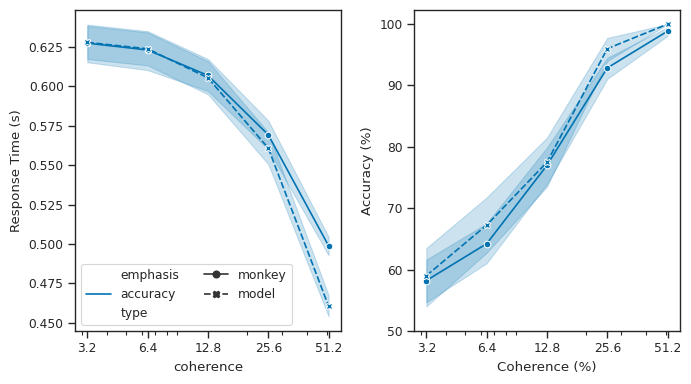

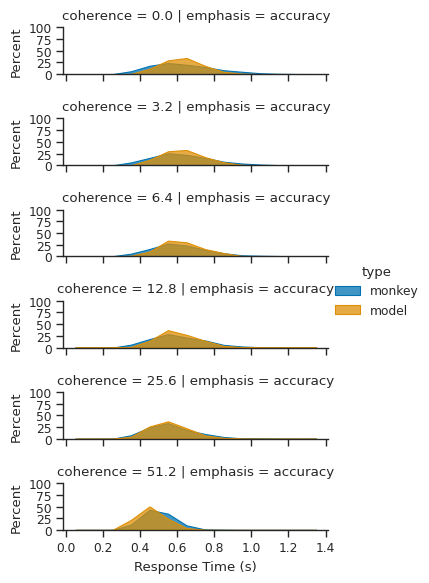

In [21]:
simulate(ramp=1.33, relative=0.15, threshold=0.34, trials=400, load=False, estimator=np.mean, name="dec25accuracy", emphases=['accuracy'])

## Shared

emphasis speed, coherence 0.0, trial 0, RT 0.41500000000000004
emphasis speed, coherence 0.0, trial 1, RT 0.501
emphasis speed, coherence 0.0, trial 2, RT 0.41200000000000003
emphasis speed, coherence 0.0, trial 3, RT 0.324
emphasis speed, coherence 0.0, trial 4, RT 0.629
emphasis speed, coherence 0.0, trial 5, RT 0.707
emphasis speed, coherence 0.0, trial 6, RT 0.315
emphasis speed, coherence 0.0, trial 7, RT 0.47700000000000004
emphasis speed, coherence 0.0, trial 8, RT 0.641
emphasis speed, coherence 0.0, trial 9, RT 0.724
emphasis speed, coherence 0.0, trial 10, RT 0.384
emphasis speed, coherence 0.0, trial 11, RT 0.501
emphasis speed, coherence 0.0, trial 12, RT 0.421
emphasis speed, coherence 0.0, trial 13, RT 0.5630000000000001
emphasis speed, coherence 0.0, trial 14, RT 0.5730000000000001
emphasis speed, coherence 0.0, trial 15, RT 0.541
emphasis speed, coherence 0.0, trial 16, RT 0.429
emphasis speed, coherence 0.0, trial 17, RT 0.43
emphasis speed, coherence 0.0, trial 18, RT

emphasis speed, coherence 0.0, trial 156, RT 0.488
emphasis speed, coherence 0.0, trial 157, RT 0.534
emphasis speed, coherence 0.0, trial 158, RT 0.311
emphasis speed, coherence 0.0, trial 159, RT 0.6980000000000001
emphasis speed, coherence 0.0, trial 160, RT 0.499
emphasis speed, coherence 0.0, trial 161, RT 0.429
emphasis speed, coherence 0.0, trial 162, RT 0.511
emphasis speed, coherence 0.0, trial 163, RT 0.441
emphasis speed, coherence 0.0, trial 164, RT 0.357
emphasis speed, coherence 0.0, trial 165, RT 0.588
emphasis speed, coherence 0.0, trial 166, RT 0.393
emphasis speed, coherence 0.0, trial 167, RT 0.331
emphasis speed, coherence 0.0, trial 168, RT 0.393
emphasis speed, coherence 0.0, trial 169, RT 0.493
emphasis speed, coherence 0.0, trial 170, RT 0.321
emphasis speed, coherence 0.0, trial 171, RT 0.35100000000000003
emphasis speed, coherence 0.0, trial 172, RT 0.59
emphasis speed, coherence 0.0, trial 173, RT 0.402
emphasis speed, coherence 0.0, trial 174, RT 0.486
empha

emphasis speed, coherence 0.0, trial 311, RT 0.394
emphasis speed, coherence 0.0, trial 312, RT 0.603
emphasis speed, coherence 0.0, trial 313, RT 0.562
emphasis speed, coherence 0.0, trial 314, RT 0.55
emphasis speed, coherence 0.0, trial 315, RT 0.665
emphasis speed, coherence 0.0, trial 316, RT 0.5
emphasis speed, coherence 0.0, trial 317, RT 0.591
emphasis speed, coherence 0.0, trial 318, RT 0.331
emphasis speed, coherence 0.0, trial 319, RT 0.466
emphasis speed, coherence 0.0, trial 320, RT 0.602
emphasis speed, coherence 0.0, trial 321, RT 0.483
emphasis speed, coherence 0.0, trial 322, RT 0.454
emphasis speed, coherence 0.0, trial 323, RT 0.439
emphasis speed, coherence 0.0, trial 324, RT 0.595
emphasis speed, coherence 0.0, trial 325, RT 0.495
emphasis speed, coherence 0.0, trial 326, RT 0.428
emphasis speed, coherence 0.0, trial 327, RT 0.49
emphasis speed, coherence 0.0, trial 328, RT 0.495
emphasis speed, coherence 0.0, trial 329, RT 0.34700000000000003
emphasis speed, coher

emphasis speed, coherence 0.0, trial 467, RT 0.5670000000000001
emphasis speed, coherence 0.0, trial 468, RT 0.538
emphasis speed, coherence 0.0, trial 469, RT 0.35100000000000003
emphasis speed, coherence 0.0, trial 470, RT 0.353
emphasis speed, coherence 0.0, trial 471, RT 0.363
emphasis speed, coherence 0.0, trial 472, RT 0.311
emphasis speed, coherence 0.0, trial 473, RT 0.424
emphasis speed, coherence 0.0, trial 474, RT 0.367
emphasis speed, coherence 0.0, trial 475, RT 0.45
emphasis speed, coherence 0.0, trial 476, RT 0.329
emphasis speed, coherence 0.0, trial 477, RT 0.438
emphasis speed, coherence 0.0, trial 478, RT 0.59
emphasis speed, coherence 0.0, trial 479, RT 0.489
emphasis speed, coherence 0.0, trial 480, RT 0.389
emphasis speed, coherence 0.0, trial 481, RT 0.531
emphasis speed, coherence 0.0, trial 482, RT 0.315
emphasis speed, coherence 0.0, trial 483, RT 0.40800000000000003
emphasis speed, coherence 0.0, trial 484, RT 0.324
emphasis speed, coherence 0.0, trial 485, R

emphasis speed, coherence 0.0, trial 622, RT 0.501
emphasis speed, coherence 0.0, trial 623, RT 0.429
emphasis speed, coherence 0.0, trial 624, RT 0.333
emphasis speed, coherence 0.0, trial 625, RT 0.454
emphasis speed, coherence 0.0, trial 626, RT 0.608
emphasis speed, coherence 0.0, trial 627, RT 0.458
emphasis speed, coherence 0.0, trial 628, RT 0.325
emphasis speed, coherence 0.0, trial 629, RT 0.652
emphasis speed, coherence 0.0, trial 630, RT 0.417
emphasis speed, coherence 0.0, trial 631, RT 0.511
emphasis speed, coherence 0.0, trial 632, RT 0.525
emphasis speed, coherence 0.0, trial 633, RT 0.422
emphasis speed, coherence 0.0, trial 634, RT 0.273
emphasis speed, coherence 0.0, trial 635, RT 0.397
emphasis speed, coherence 0.0, trial 636, RT 0.5700000000000001
emphasis speed, coherence 0.0, trial 637, RT 0.436
emphasis speed, coherence 0.0, trial 638, RT 0.594
emphasis speed, coherence 0.0, trial 639, RT 0.401
emphasis speed, coherence 0.0, trial 640, RT 0.386
emphasis speed, co

emphasis speed, coherence 0.0, trial 779, RT 0.454
emphasis speed, coherence 0.0, trial 780, RT 0.397
emphasis speed, coherence 0.0, trial 781, RT 0.518
emphasis speed, coherence 0.0, trial 782, RT 0.358
emphasis speed, coherence 0.0, trial 783, RT 0.496
emphasis speed, coherence 0.0, trial 784, RT 0.761
emphasis speed, coherence 0.0, trial 785, RT 0.364
emphasis speed, coherence 0.0, trial 786, RT 0.47000000000000003
emphasis speed, coherence 0.0, trial 787, RT 0.53
emphasis speed, coherence 0.0, trial 788, RT 0.527
emphasis speed, coherence 0.0, trial 789, RT 0.353
emphasis speed, coherence 0.0, trial 790, RT 0.4
emphasis speed, coherence 0.0, trial 791, RT 0.343
emphasis speed, coherence 0.0, trial 792, RT 0.353
emphasis speed, coherence 0.0, trial 793, RT 0.532
emphasis speed, coherence 0.0, trial 794, RT 0.434
emphasis speed, coherence 0.0, trial 795, RT 0.421
emphasis speed, coherence 0.0, trial 796, RT 0.514
emphasis speed, coherence 0.0, trial 797, RT 0.5660000000000001
emphasi

emphasis speed, coherence 0.032, trial 130, RT 0.404
emphasis speed, coherence 0.032, trial 131, RT 0.498
emphasis speed, coherence 0.032, trial 132, RT 0.41600000000000004
emphasis speed, coherence 0.032, trial 133, RT 0.514
emphasis speed, coherence 0.032, trial 134, RT 0.40800000000000003
emphasis speed, coherence 0.032, trial 135, RT 0.34800000000000003
emphasis speed, coherence 0.032, trial 136, RT 0.375
emphasis speed, coherence 0.032, trial 137, RT 0.524
emphasis speed, coherence 0.032, trial 138, RT 0.401
emphasis speed, coherence 0.032, trial 139, RT 0.359
emphasis speed, coherence 0.032, trial 140, RT 0.621
emphasis speed, coherence 0.032, trial 141, RT 0.529
emphasis speed, coherence 0.032, trial 142, RT 0.362
emphasis speed, coherence 0.032, trial 143, RT 0.504
emphasis speed, coherence 0.032, trial 144, RT 0.431
emphasis speed, coherence 0.032, trial 145, RT 0.442
emphasis speed, coherence 0.032, trial 146, RT 0.437
emphasis speed, coherence 0.032, trial 147, RT 0.588
emph

emphasis speed, coherence 0.032, trial 280, RT 0.47800000000000004
emphasis speed, coherence 0.032, trial 281, RT 0.375
emphasis speed, coherence 0.032, trial 282, RT 0.428
emphasis speed, coherence 0.032, trial 283, RT 0.596
emphasis speed, coherence 0.032, trial 284, RT 0.6980000000000001
emphasis speed, coherence 0.032, trial 285, RT 0.319
emphasis speed, coherence 0.032, trial 286, RT 0.363
emphasis speed, coherence 0.032, trial 287, RT 0.402
emphasis speed, coherence 0.032, trial 288, RT 0.364
emphasis speed, coherence 0.032, trial 289, RT 0.444
emphasis speed, coherence 0.032, trial 290, RT 0.54
emphasis speed, coherence 0.032, trial 291, RT 0.34900000000000003
emphasis speed, coherence 0.032, trial 292, RT 0.393
emphasis speed, coherence 0.032, trial 293, RT 0.599
emphasis speed, coherence 0.032, trial 294, RT 0.307
emphasis speed, coherence 0.032, trial 295, RT 0.446
emphasis speed, coherence 0.032, trial 296, RT 0.496
emphasis speed, coherence 0.032, trial 297, RT 0.502
emphas

emphasis speed, coherence 0.032, trial 429, RT 0.364
emphasis speed, coherence 0.032, trial 430, RT 0.5660000000000001
emphasis speed, coherence 0.032, trial 431, RT 0.653
emphasis speed, coherence 0.032, trial 432, RT 0.463
emphasis speed, coherence 0.032, trial 433, RT 0.501
emphasis speed, coherence 0.032, trial 434, RT 0.492
emphasis speed, coherence 0.032, trial 435, RT 0.5630000000000001
emphasis speed, coherence 0.032, trial 436, RT 0.372
emphasis speed, coherence 0.032, trial 437, RT 0.33
emphasis speed, coherence 0.032, trial 438, RT 0.38
emphasis speed, coherence 0.032, trial 439, RT 0.449
emphasis speed, coherence 0.032, trial 440, RT 0.502
emphasis speed, coherence 0.032, trial 441, RT 0.468
emphasis speed, coherence 0.032, trial 442, RT 0.382
emphasis speed, coherence 0.032, trial 443, RT 0.393
emphasis speed, coherence 0.032, trial 444, RT 0.656
emphasis speed, coherence 0.032, trial 445, RT 0.594
emphasis speed, coherence 0.032, trial 446, RT 0.553
emphasis speed, cohere

emphasis speed, coherence 0.032, trial 581, RT 0.55
emphasis speed, coherence 0.032, trial 582, RT 0.295
emphasis speed, coherence 0.032, trial 583, RT 0.331
emphasis speed, coherence 0.032, trial 584, RT 0.454
emphasis speed, coherence 0.032, trial 585, RT 0.557
emphasis speed, coherence 0.032, trial 586, RT 0.267
emphasis speed, coherence 0.032, trial 587, RT 0.554
emphasis speed, coherence 0.032, trial 588, RT 0.661
emphasis speed, coherence 0.032, trial 589, RT 0.492
emphasis speed, coherence 0.032, trial 590, RT 0.5730000000000001
emphasis speed, coherence 0.032, trial 591, RT 0.5
emphasis speed, coherence 0.032, trial 592, RT 0.429
emphasis speed, coherence 0.032, trial 593, RT 0.41600000000000004
emphasis speed, coherence 0.032, trial 594, RT 0.47200000000000003
emphasis speed, coherence 0.032, trial 595, RT 0.451
emphasis speed, coherence 0.032, trial 596, RT 0.404
emphasis speed, coherence 0.032, trial 597, RT 0.619
emphasis speed, coherence 0.032, trial 598, RT 0.375
emphasis

emphasis speed, coherence 0.032, trial 729, RT 0.417
emphasis speed, coherence 0.032, trial 730, RT 0.432
emphasis speed, coherence 0.032, trial 731, RT 0.406
emphasis speed, coherence 0.032, trial 732, RT 0.5
emphasis speed, coherence 0.032, trial 733, RT 0.491
emphasis speed, coherence 0.032, trial 734, RT 0.39
emphasis speed, coherence 0.032, trial 735, RT 0.511
emphasis speed, coherence 0.032, trial 736, RT 0.491
emphasis speed, coherence 0.032, trial 737, RT 0.744
emphasis speed, coherence 0.032, trial 738, RT 0.449
emphasis speed, coherence 0.032, trial 739, RT 0.495
emphasis speed, coherence 0.032, trial 740, RT 0.403
emphasis speed, coherence 0.032, trial 741, RT 0.376
emphasis speed, coherence 0.032, trial 742, RT 0.659
emphasis speed, coherence 0.032, trial 743, RT 0.483
emphasis speed, coherence 0.032, trial 744, RT 0.41300000000000003
emphasis speed, coherence 0.032, trial 745, RT 0.5720000000000001
emphasis speed, coherence 0.032, trial 746, RT 0.329
emphasis speed, cohere

emphasis speed, coherence 0.064, trial 81, RT 0.41300000000000003
emphasis speed, coherence 0.064, trial 82, RT 0.355
emphasis speed, coherence 0.064, trial 83, RT 0.6940000000000001
emphasis speed, coherence 0.064, trial 84, RT 0.387
emphasis speed, coherence 0.064, trial 85, RT 0.313
emphasis speed, coherence 0.064, trial 86, RT 0.525
emphasis speed, coherence 0.064, trial 87, RT 0.376
emphasis speed, coherence 0.064, trial 88, RT 0.434
emphasis speed, coherence 0.064, trial 89, RT 0.506
emphasis speed, coherence 0.064, trial 90, RT 0.578
emphasis speed, coherence 0.064, trial 91, RT 0.361
emphasis speed, coherence 0.064, trial 92, RT 0.35000000000000003
emphasis speed, coherence 0.064, trial 93, RT 0.321
emphasis speed, coherence 0.064, trial 94, RT 0.32
emphasis speed, coherence 0.064, trial 95, RT 0.638
emphasis speed, coherence 0.064, trial 96, RT 0.612
emphasis speed, coherence 0.064, trial 97, RT 0.65
emphasis speed, coherence 0.064, trial 98, RT 0.522
emphasis speed, coherence

emphasis speed, coherence 0.064, trial 230, RT 0.399
emphasis speed, coherence 0.064, trial 231, RT 0.527
emphasis speed, coherence 0.064, trial 232, RT 0.329
emphasis speed, coherence 0.064, trial 233, RT 0.376
emphasis speed, coherence 0.064, trial 234, RT 0.406
emphasis speed, coherence 0.064, trial 235, RT 0.608
emphasis speed, coherence 0.064, trial 236, RT 0.355
emphasis speed, coherence 0.064, trial 237, RT 0.528
emphasis speed, coherence 0.064, trial 238, RT 0.315
emphasis speed, coherence 0.064, trial 239, RT 0.5740000000000001
emphasis speed, coherence 0.064, trial 240, RT 0.365
emphasis speed, coherence 0.064, trial 241, RT 0.559
emphasis speed, coherence 0.064, trial 242, RT 0.422
emphasis speed, coherence 0.064, trial 243, RT 0.323
emphasis speed, coherence 0.064, trial 244, RT 0.318
emphasis speed, coherence 0.064, trial 245, RT 0.37
emphasis speed, coherence 0.064, trial 246, RT 0.389
emphasis speed, coherence 0.064, trial 247, RT 0.619
emphasis speed, coherence 0.064, t

emphasis speed, coherence 0.064, trial 380, RT 0.534
emphasis speed, coherence 0.064, trial 381, RT 0.393
emphasis speed, coherence 0.064, trial 382, RT 0.6
emphasis speed, coherence 0.064, trial 383, RT 0.365
emphasis speed, coherence 0.064, trial 384, RT 0.596
emphasis speed, coherence 0.064, trial 385, RT 0.354
emphasis speed, coherence 0.064, trial 386, RT 0.47600000000000003
emphasis speed, coherence 0.064, trial 387, RT 0.598
emphasis speed, coherence 0.064, trial 388, RT 0.33
emphasis speed, coherence 0.064, trial 389, RT 0.363
emphasis speed, coherence 0.064, trial 390, RT 0.489
emphasis speed, coherence 0.064, trial 391, RT 0.432
emphasis speed, coherence 0.064, trial 392, RT 0.353
emphasis speed, coherence 0.064, trial 393, RT 0.47700000000000004
emphasis speed, coherence 0.064, trial 394, RT 0.537
emphasis speed, coherence 0.064, trial 395, RT 0.452
emphasis speed, coherence 0.064, trial 396, RT 0.35100000000000003
emphasis speed, coherence 0.064, trial 397, RT 0.4
emphasis 

emphasis speed, coherence 0.064, trial 528, RT 0.405
emphasis speed, coherence 0.064, trial 529, RT 0.438
emphasis speed, coherence 0.064, trial 530, RT 0.366
emphasis speed, coherence 0.064, trial 531, RT 0.45
emphasis speed, coherence 0.064, trial 532, RT 0.34800000000000003
emphasis speed, coherence 0.064, trial 533, RT 0.39
emphasis speed, coherence 0.064, trial 534, RT 0.653
emphasis speed, coherence 0.064, trial 535, RT 0.605
emphasis speed, coherence 0.064, trial 536, RT 0.454
emphasis speed, coherence 0.064, trial 537, RT 0.363
emphasis speed, coherence 0.064, trial 538, RT 0.38
emphasis speed, coherence 0.064, trial 539, RT 0.361
emphasis speed, coherence 0.064, trial 540, RT 0.381
emphasis speed, coherence 0.064, trial 541, RT 0.485
emphasis speed, coherence 0.064, trial 542, RT 0.5640000000000001
emphasis speed, coherence 0.064, trial 543, RT 0.424
emphasis speed, coherence 0.064, trial 544, RT 0.421
emphasis speed, coherence 0.064, trial 545, RT 0.486
emphasis speed, cohere

emphasis speed, coherence 0.064, trial 679, RT 0.527
emphasis speed, coherence 0.064, trial 680, RT 0.365
emphasis speed, coherence 0.064, trial 681, RT 0.42
emphasis speed, coherence 0.064, trial 682, RT 0.49
emphasis speed, coherence 0.064, trial 683, RT 0.427
emphasis speed, coherence 0.064, trial 684, RT 0.42
emphasis speed, coherence 0.064, trial 685, RT 0.452
emphasis speed, coherence 0.064, trial 686, RT 0.448
emphasis speed, coherence 0.064, trial 687, RT 0.468
emphasis speed, coherence 0.064, trial 688, RT 0.47800000000000004
emphasis speed, coherence 0.064, trial 689, RT 0.378
emphasis speed, coherence 0.064, trial 690, RT 0.296
emphasis speed, coherence 0.064, trial 691, RT 0.441
emphasis speed, coherence 0.064, trial 692, RT 0.298
emphasis speed, coherence 0.064, trial 693, RT 0.437
emphasis speed, coherence 0.064, trial 694, RT 0.47600000000000003
emphasis speed, coherence 0.064, trial 695, RT 0.322
emphasis speed, coherence 0.064, trial 696, RT 0.397
emphasis speed, coher

emphasis speed, coherence 0.128, trial 28, RT 0.342
emphasis speed, coherence 0.128, trial 29, RT 0.327
emphasis speed, coherence 0.128, trial 30, RT 0.47200000000000003
emphasis speed, coherence 0.128, trial 31, RT 0.324
emphasis speed, coherence 0.128, trial 32, RT 0.323
emphasis speed, coherence 0.128, trial 33, RT 0.376
emphasis speed, coherence 0.128, trial 34, RT 0.321
emphasis speed, coherence 0.128, trial 35, RT 0.434
emphasis speed, coherence 0.128, trial 36, RT 0.382
emphasis speed, coherence 0.128, trial 37, RT 0.512
emphasis speed, coherence 0.128, trial 38, RT 0.47600000000000003
emphasis speed, coherence 0.128, trial 39, RT 0.391
emphasis speed, coherence 0.128, trial 40, RT 0.34700000000000003
emphasis speed, coherence 0.128, trial 41, RT 0.334
emphasis speed, coherence 0.128, trial 42, RT 0.439
emphasis speed, coherence 0.128, trial 43, RT 0.404
emphasis speed, coherence 0.128, trial 44, RT 0.423
emphasis speed, coherence 0.128, trial 45, RT 0.42
emphasis speed, coheren

emphasis speed, coherence 0.128, trial 178, RT 0.374
emphasis speed, coherence 0.128, trial 179, RT 0.372
emphasis speed, coherence 0.128, trial 180, RT 0.41300000000000003
emphasis speed, coherence 0.128, trial 181, RT 0.517
emphasis speed, coherence 0.128, trial 182, RT 0.502
emphasis speed, coherence 0.128, trial 183, RT 0.38
emphasis speed, coherence 0.128, trial 184, RT 0.492
emphasis speed, coherence 0.128, trial 185, RT 0.507
emphasis speed, coherence 0.128, trial 186, RT 0.6990000000000001
emphasis speed, coherence 0.128, trial 187, RT 0.369
emphasis speed, coherence 0.128, trial 188, RT 0.365
emphasis speed, coherence 0.128, trial 189, RT 0.711
emphasis speed, coherence 0.128, trial 190, RT 0.39
emphasis speed, coherence 0.128, trial 191, RT 0.486
emphasis speed, coherence 0.128, trial 192, RT 0.561
emphasis speed, coherence 0.128, trial 193, RT 0.687
emphasis speed, coherence 0.128, trial 194, RT 0.378
emphasis speed, coherence 0.128, trial 195, RT 0.46900000000000003
emphasi

emphasis speed, coherence 0.128, trial 328, RT 0.378
emphasis speed, coherence 0.128, trial 329, RT 0.372
emphasis speed, coherence 0.128, trial 330, RT 0.453
emphasis speed, coherence 0.128, trial 331, RT 0.312
emphasis speed, coherence 0.128, trial 332, RT 0.433
emphasis speed, coherence 0.128, trial 333, RT 0.427
emphasis speed, coherence 0.128, trial 334, RT 0.352
emphasis speed, coherence 0.128, trial 335, RT 0.45
emphasis speed, coherence 0.128, trial 336, RT 0.494
emphasis speed, coherence 0.128, trial 337, RT 0.326
emphasis speed, coherence 0.128, trial 338, RT 0.638
emphasis speed, coherence 0.128, trial 339, RT 0.352
emphasis speed, coherence 0.128, trial 340, RT 0.322
emphasis speed, coherence 0.128, trial 341, RT 0.555
emphasis speed, coherence 0.128, trial 342, RT 0.319
emphasis speed, coherence 0.128, trial 343, RT 0.463
emphasis speed, coherence 0.128, trial 344, RT 0.496
emphasis speed, coherence 0.128, trial 345, RT 0.391
emphasis speed, coherence 0.128, trial 346, RT 

emphasis speed, coherence 0.128, trial 477, RT 0.488
emphasis speed, coherence 0.128, trial 478, RT 0.465
emphasis speed, coherence 0.128, trial 479, RT 0.657
emphasis speed, coherence 0.128, trial 480, RT 0.49
emphasis speed, coherence 0.128, trial 481, RT 0.455
emphasis speed, coherence 0.128, trial 482, RT 0.46900000000000003
emphasis speed, coherence 0.128, trial 483, RT 0.419
emphasis speed, coherence 0.128, trial 484, RT 0.496
emphasis speed, coherence 0.128, trial 485, RT 0.468
emphasis speed, coherence 0.128, trial 486, RT 0.436
emphasis speed, coherence 0.128, trial 487, RT 0.447
emphasis speed, coherence 0.128, trial 488, RT 0.432
emphasis speed, coherence 0.128, trial 489, RT 0.557
emphasis speed, coherence 0.128, trial 490, RT 0.311
emphasis speed, coherence 0.128, trial 491, RT 0.387
emphasis speed, coherence 0.128, trial 492, RT 0.271
emphasis speed, coherence 0.128, trial 493, RT 0.359
emphasis speed, coherence 0.128, trial 494, RT 0.406
emphasis speed, coherence 0.128, 

emphasis speed, coherence 0.128, trial 629, RT 0.34900000000000003
emphasis speed, coherence 0.128, trial 630, RT 0.62
emphasis speed, coherence 0.128, trial 631, RT 0.486
emphasis speed, coherence 0.128, trial 632, RT 0.332
emphasis speed, coherence 0.128, trial 633, RT 0.587
emphasis speed, coherence 0.128, trial 634, RT 0.377
emphasis speed, coherence 0.128, trial 635, RT 0.362
emphasis speed, coherence 0.128, trial 636, RT 0.441
emphasis speed, coherence 0.128, trial 637, RT 0.32
emphasis speed, coherence 0.128, trial 638, RT 0.487
emphasis speed, coherence 0.128, trial 639, RT 0.453
emphasis speed, coherence 0.128, trial 640, RT 0.5650000000000001
emphasis speed, coherence 0.128, trial 641, RT 0.405
emphasis speed, coherence 0.128, trial 642, RT 0.47600000000000003
emphasis speed, coherence 0.128, trial 643, RT 0.419
emphasis speed, coherence 0.128, trial 644, RT 0.468
emphasis speed, coherence 0.128, trial 645, RT 0.267
emphasis speed, coherence 0.128, trial 646, RT 0.492
emphasi

emphasis speed, coherence 0.128, trial 779, RT 0.483
emphasis speed, coherence 0.128, trial 780, RT 0.438
emphasis speed, coherence 0.128, trial 781, RT 0.551
emphasis speed, coherence 0.128, trial 782, RT 0.584
emphasis speed, coherence 0.128, trial 783, RT 0.406
emphasis speed, coherence 0.128, trial 784, RT 0.41500000000000004
emphasis speed, coherence 0.128, trial 785, RT 0.36
emphasis speed, coherence 0.128, trial 786, RT 0.72
emphasis speed, coherence 0.128, trial 787, RT 0.389
emphasis speed, coherence 0.128, trial 788, RT 0.41200000000000003
emphasis speed, coherence 0.128, trial 789, RT 0.42
emphasis speed, coherence 0.128, trial 790, RT 0.509
emphasis speed, coherence 0.128, trial 791, RT 0.638
emphasis speed, coherence 0.128, trial 792, RT 0.377
emphasis speed, coherence 0.128, trial 793, RT 0.339
emphasis speed, coherence 0.128, trial 794, RT 0.56
emphasis speed, coherence 0.128, trial 795, RT 0.517
emphasis speed, coherence 0.128, trial 796, RT 0.518
emphasis speed, cohere

emphasis speed, coherence 0.256, trial 133, RT 0.593
emphasis speed, coherence 0.256, trial 134, RT 0.509
emphasis speed, coherence 0.256, trial 135, RT 0.36
emphasis speed, coherence 0.256, trial 136, RT 0.461
emphasis speed, coherence 0.256, trial 137, RT 0.49
emphasis speed, coherence 0.256, trial 138, RT 0.243
emphasis speed, coherence 0.256, trial 139, RT 0.333
emphasis speed, coherence 0.256, trial 140, RT 0.327
emphasis speed, coherence 0.256, trial 141, RT 0.374
emphasis speed, coherence 0.256, trial 142, RT 0.364
emphasis speed, coherence 0.256, trial 143, RT 0.28700000000000003
emphasis speed, coherence 0.256, trial 144, RT 0.40800000000000003
emphasis speed, coherence 0.256, trial 145, RT 0.505
emphasis speed, coherence 0.256, trial 146, RT 0.457
emphasis speed, coherence 0.256, trial 147, RT 0.34500000000000003
emphasis speed, coherence 0.256, trial 148, RT 0.374
emphasis speed, coherence 0.256, trial 149, RT 0.441
emphasis speed, coherence 0.256, trial 150, RT 0.3
emphasis

emphasis speed, coherence 0.256, trial 282, RT 0.40800000000000003
emphasis speed, coherence 0.256, trial 283, RT 0.28200000000000003
emphasis speed, coherence 0.256, trial 284, RT 0.426
emphasis speed, coherence 0.256, trial 285, RT 0.369
emphasis speed, coherence 0.256, trial 286, RT 0.336
emphasis speed, coherence 0.256, trial 287, RT 0.377
emphasis speed, coherence 0.256, trial 288, RT 0.376
emphasis speed, coherence 0.256, trial 289, RT 0.41200000000000003
emphasis speed, coherence 0.256, trial 290, RT 0.378
emphasis speed, coherence 0.256, trial 291, RT 0.47700000000000004
emphasis speed, coherence 0.256, trial 292, RT 0.303
emphasis speed, coherence 0.256, trial 293, RT 0.459
emphasis speed, coherence 0.256, trial 294, RT 0.373
emphasis speed, coherence 0.256, trial 295, RT 0.373
emphasis speed, coherence 0.256, trial 296, RT 0.34800000000000003
emphasis speed, coherence 0.256, trial 297, RT 0.361
emphasis speed, coherence 0.256, trial 298, RT 0.523
emphasis speed, coherence 0.2

emphasis speed, coherence 0.256, trial 430, RT 0.384
emphasis speed, coherence 0.256, trial 431, RT 0.418
emphasis speed, coherence 0.256, trial 432, RT 0.335
emphasis speed, coherence 0.256, trial 433, RT 0.429
emphasis speed, coherence 0.256, trial 434, RT 0.466
emphasis speed, coherence 0.256, trial 435, RT 0.28800000000000003
emphasis speed, coherence 0.256, trial 436, RT 0.32
emphasis speed, coherence 0.256, trial 437, RT 0.392
emphasis speed, coherence 0.256, trial 438, RT 0.47100000000000003
emphasis speed, coherence 0.256, trial 439, RT 0.293
emphasis speed, coherence 0.256, trial 440, RT 0.273
emphasis speed, coherence 0.256, trial 441, RT 0.328
emphasis speed, coherence 0.256, trial 442, RT 0.437
emphasis speed, coherence 0.256, trial 443, RT 0.526
emphasis speed, coherence 0.256, trial 444, RT 0.545
emphasis speed, coherence 0.256, trial 445, RT 0.359
emphasis speed, coherence 0.256, trial 446, RT 0.429
emphasis speed, coherence 0.256, trial 447, RT 0.335
emphasis speed, coh

emphasis speed, coherence 0.256, trial 578, RT 0.391
emphasis speed, coherence 0.256, trial 579, RT 0.391
emphasis speed, coherence 0.256, trial 580, RT 0.42
emphasis speed, coherence 0.256, trial 581, RT 0.443
emphasis speed, coherence 0.256, trial 582, RT 0.603
emphasis speed, coherence 0.256, trial 583, RT 0.35100000000000003
emphasis speed, coherence 0.256, trial 584, RT 0.357
emphasis speed, coherence 0.256, trial 585, RT 0.429
emphasis speed, coherence 0.256, trial 586, RT 0.393
emphasis speed, coherence 0.256, trial 587, RT 0.35100000000000003
emphasis speed, coherence 0.256, trial 588, RT 0.381
emphasis speed, coherence 0.256, trial 589, RT 0.387
emphasis speed, coherence 0.256, trial 590, RT 0.332
emphasis speed, coherence 0.256, trial 591, RT 0.375
emphasis speed, coherence 0.256, trial 592, RT 0.397
emphasis speed, coherence 0.256, trial 593, RT 0.433
emphasis speed, coherence 0.256, trial 594, RT 0.44
emphasis speed, coherence 0.256, trial 595, RT 0.359
emphasis speed, cohe

emphasis speed, coherence 0.256, trial 729, RT 0.423
emphasis speed, coherence 0.256, trial 730, RT 0.339
emphasis speed, coherence 0.256, trial 731, RT 0.447
emphasis speed, coherence 0.256, trial 732, RT 0.436
emphasis speed, coherence 0.256, trial 733, RT 0.39
emphasis speed, coherence 0.256, trial 734, RT 0.39
emphasis speed, coherence 0.256, trial 735, RT 0.338
emphasis speed, coherence 0.256, trial 736, RT 0.632
emphasis speed, coherence 0.256, trial 737, RT 0.311
emphasis speed, coherence 0.256, trial 738, RT 0.443
emphasis speed, coherence 0.256, trial 739, RT 0.289
emphasis speed, coherence 0.256, trial 740, RT 0.5690000000000001
emphasis speed, coherence 0.256, trial 741, RT 0.457
emphasis speed, coherence 0.256, trial 742, RT 0.55
emphasis speed, coherence 0.256, trial 743, RT 0.377
emphasis speed, coherence 0.256, trial 744, RT 0.396
emphasis speed, coherence 0.256, trial 745, RT 0.296
emphasis speed, coherence 0.256, trial 746, RT 0.356
emphasis speed, coherence 0.256, tri

emphasis speed, coherence 0.512, trial 81, RT 0.27
emphasis speed, coherence 0.512, trial 82, RT 0.36
emphasis speed, coherence 0.512, trial 83, RT 0.339
emphasis speed, coherence 0.512, trial 84, RT 0.302
emphasis speed, coherence 0.512, trial 85, RT 0.307
emphasis speed, coherence 0.512, trial 86, RT 0.457
emphasis speed, coherence 0.512, trial 87, RT 0.293
emphasis speed, coherence 0.512, trial 88, RT 0.35100000000000003
emphasis speed, coherence 0.512, trial 89, RT 0.40900000000000003
emphasis speed, coherence 0.512, trial 90, RT 0.327
emphasis speed, coherence 0.512, trial 91, RT 0.47100000000000003
emphasis speed, coherence 0.512, trial 92, RT 0.276
emphasis speed, coherence 0.512, trial 93, RT 0.274
emphasis speed, coherence 0.512, trial 94, RT 0.295
emphasis speed, coherence 0.512, trial 95, RT 0.23500000000000001
emphasis speed, coherence 0.512, trial 96, RT 0.34800000000000003
emphasis speed, coherence 0.512, trial 97, RT 0.389
emphasis speed, coherence 0.512, trial 98, RT 0.

emphasis speed, coherence 0.512, trial 230, RT 0.308
emphasis speed, coherence 0.512, trial 231, RT 0.336
emphasis speed, coherence 0.512, trial 232, RT 0.29
emphasis speed, coherence 0.512, trial 233, RT 0.28400000000000003
emphasis speed, coherence 0.512, trial 234, RT 0.355
emphasis speed, coherence 0.512, trial 235, RT 0.355
emphasis speed, coherence 0.512, trial 236, RT 0.387
emphasis speed, coherence 0.512, trial 237, RT 0.293
emphasis speed, coherence 0.512, trial 238, RT 0.365
emphasis speed, coherence 0.512, trial 239, RT 0.303
emphasis speed, coherence 0.512, trial 240, RT 0.396
emphasis speed, coherence 0.512, trial 241, RT 0.342
emphasis speed, coherence 0.512, trial 242, RT 0.32
emphasis speed, coherence 0.512, trial 243, RT 0.363
emphasis speed, coherence 0.512, trial 244, RT 0.354
emphasis speed, coherence 0.512, trial 245, RT 0.31
emphasis speed, coherence 0.512, trial 246, RT 0.538
emphasis speed, coherence 0.512, trial 247, RT 0.403
emphasis speed, coherence 0.512, tr

emphasis speed, coherence 0.512, trial 380, RT 0.437
emphasis speed, coherence 0.512, trial 381, RT 0.337
emphasis speed, coherence 0.512, trial 382, RT 0.319
emphasis speed, coherence 0.512, trial 383, RT 0.298
emphasis speed, coherence 0.512, trial 384, RT 0.402
emphasis speed, coherence 0.512, trial 385, RT 0.404
emphasis speed, coherence 0.512, trial 386, RT 0.377
emphasis speed, coherence 0.512, trial 387, RT 0.28700000000000003
emphasis speed, coherence 0.512, trial 388, RT 0.531
emphasis speed, coherence 0.512, trial 389, RT 0.254
emphasis speed, coherence 0.512, trial 390, RT 0.437
emphasis speed, coherence 0.512, trial 391, RT 0.289
emphasis speed, coherence 0.512, trial 392, RT 0.261
emphasis speed, coherence 0.512, trial 393, RT 0.445
emphasis speed, coherence 0.512, trial 394, RT 0.425
emphasis speed, coherence 0.512, trial 395, RT 0.373
emphasis speed, coherence 0.512, trial 396, RT 0.40800000000000003
emphasis speed, coherence 0.512, trial 397, RT 0.41100000000000003
emph

emphasis speed, coherence 0.512, trial 531, RT 0.359
emphasis speed, coherence 0.512, trial 532, RT 0.33
emphasis speed, coherence 0.512, trial 533, RT 0.406
emphasis speed, coherence 0.512, trial 534, RT 0.331
emphasis speed, coherence 0.512, trial 535, RT 0.322
emphasis speed, coherence 0.512, trial 536, RT 0.252
emphasis speed, coherence 0.512, trial 537, RT 0.443
emphasis speed, coherence 0.512, trial 538, RT 0.278
emphasis speed, coherence 0.512, trial 539, RT 0.448
emphasis speed, coherence 0.512, trial 540, RT 0.37
emphasis speed, coherence 0.512, trial 541, RT 0.323
emphasis speed, coherence 0.512, trial 542, RT 0.297
emphasis speed, coherence 0.512, trial 543, RT 0.315
emphasis speed, coherence 0.512, trial 544, RT 0.423
emphasis speed, coherence 0.512, trial 545, RT 0.367
emphasis speed, coherence 0.512, trial 546, RT 0.37
emphasis speed, coherence 0.512, trial 547, RT 0.365
emphasis speed, coherence 0.512, trial 548, RT 0.299
emphasis speed, coherence 0.512, trial 549, RT 0.

emphasis speed, coherence 0.512, trial 682, RT 0.277
emphasis speed, coherence 0.512, trial 683, RT 0.398
emphasis speed, coherence 0.512, trial 684, RT 0.314
emphasis speed, coherence 0.512, trial 685, RT 0.306
emphasis speed, coherence 0.512, trial 686, RT 0.312
emphasis speed, coherence 0.512, trial 687, RT 0.38
emphasis speed, coherence 0.512, trial 688, RT 0.317
emphasis speed, coherence 0.512, trial 689, RT 0.306
emphasis speed, coherence 0.512, trial 690, RT 0.249
emphasis speed, coherence 0.512, trial 691, RT 0.365
emphasis speed, coherence 0.512, trial 692, RT 0.244
emphasis speed, coherence 0.512, trial 693, RT 0.28200000000000003
emphasis speed, coherence 0.512, trial 694, RT 0.267
emphasis speed, coherence 0.512, trial 695, RT 0.303
emphasis speed, coherence 0.512, trial 696, RT 0.40700000000000003
emphasis speed, coherence 0.512, trial 697, RT 0.274
emphasis speed, coherence 0.512, trial 698, RT 0.418
emphasis speed, coherence 0.512, trial 699, RT 0.304
emphasis speed, coh

/tmp/ipykernel_25857/150977287.py:60: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='RT', hue='emphasis',
/tmp/ipykernel_25857/150977287.py:63: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='accuracy', hue='emphasis',


emphasis accuracy, coherence 0.0, trial 0, RT 0.507
emphasis accuracy, coherence 0.0, trial 1, RT 0.606
emphasis accuracy, coherence 0.0, trial 2, RT 0.708
emphasis accuracy, coherence 0.0, trial 3, RT 0.467
emphasis accuracy, coherence 0.0, trial 4, RT 0.533
emphasis accuracy, coherence 0.0, trial 5, RT 0.805
emphasis accuracy, coherence 0.0, trial 6, RT 0.451
emphasis accuracy, coherence 0.0, trial 7, RT 0.41300000000000003
emphasis accuracy, coherence 0.0, trial 8, RT 0.531
emphasis accuracy, coherence 0.0, trial 9, RT 1.01
emphasis accuracy, coherence 0.0, trial 10, RT 0.587
emphasis accuracy, coherence 0.0, trial 11, RT 0.843
emphasis accuracy, coherence 0.0, trial 12, RT 0.8320000000000001
emphasis accuracy, coherence 0.0, trial 13, RT 0.911
emphasis accuracy, coherence 0.0, trial 14, RT 0.516
emphasis accuracy, coherence 0.0, trial 15, RT 0.715
emphasis accuracy, coherence 0.0, trial 16, RT 0.495
emphasis accuracy, coherence 0.0, trial 17, RT 0.517
emphasis accuracy, coherence 0

emphasis accuracy, coherence 0.0, trial 150, RT 0.676
emphasis accuracy, coherence 0.0, trial 151, RT 0.467
emphasis accuracy, coherence 0.0, trial 152, RT 0.513
emphasis accuracy, coherence 0.0, trial 153, RT 0.418
emphasis accuracy, coherence 0.0, trial 154, RT 0.808
emphasis accuracy, coherence 0.0, trial 155, RT 0.672
emphasis accuracy, coherence 0.0, trial 156, RT 0.925
emphasis accuracy, coherence 0.0, trial 157, RT 0.542
emphasis accuracy, coherence 0.0, trial 158, RT 0.871
emphasis accuracy, coherence 0.0, trial 159, RT 0.684
emphasis accuracy, coherence 0.0, trial 160, RT 0.757
emphasis accuracy, coherence 0.0, trial 161, RT 0.892
emphasis accuracy, coherence 0.0, trial 162, RT 0.707
emphasis accuracy, coherence 0.0, trial 163, RT 0.465
emphasis accuracy, coherence 0.0, trial 164, RT 0.544
emphasis accuracy, coherence 0.0, trial 165, RT 0.6960000000000001
emphasis accuracy, coherence 0.0, trial 166, RT 0.766
emphasis accuracy, coherence 0.0, trial 167, RT 0.536
emphasis accura

emphasis accuracy, coherence 0.0, trial 299, RT 0.584
emphasis accuracy, coherence 0.0, trial 300, RT 0.591
emphasis accuracy, coherence 0.0, trial 301, RT 0.752
emphasis accuracy, coherence 0.0, trial 302, RT 0.519
emphasis accuracy, coherence 0.0, trial 303, RT 0.626
emphasis accuracy, coherence 0.0, trial 304, RT 0.7000000000000001
emphasis accuracy, coherence 0.0, trial 305, RT 0.619
emphasis accuracy, coherence 0.0, trial 306, RT 0.482
emphasis accuracy, coherence 0.0, trial 307, RT 0.508
emphasis accuracy, coherence 0.0, trial 308, RT 0.557
emphasis accuracy, coherence 0.0, trial 309, RT 0.791
emphasis accuracy, coherence 0.0, trial 310, RT 0.601
emphasis accuracy, coherence 0.0, trial 311, RT 0.682
emphasis accuracy, coherence 0.0, trial 312, RT 0.592
emphasis accuracy, coherence 0.0, trial 313, RT 0.441
emphasis accuracy, coherence 0.0, trial 314, RT 0.554
emphasis accuracy, coherence 0.0, trial 315, RT 0.592
emphasis accuracy, coherence 0.0, trial 316, RT 0.559
emphasis accura

emphasis accuracy, coherence 0.0, trial 448, RT 0.555
emphasis accuracy, coherence 0.0, trial 449, RT 0.419
emphasis accuracy, coherence 0.0, trial 450, RT 0.532
emphasis accuracy, coherence 0.0, trial 451, RT 0.667
emphasis accuracy, coherence 0.0, trial 452, RT 0.874
emphasis accuracy, coherence 0.0, trial 453, RT 0.448
emphasis accuracy, coherence 0.0, trial 454, RT 0.582
emphasis accuracy, coherence 0.0, trial 455, RT 0.6880000000000001
emphasis accuracy, coherence 0.0, trial 456, RT 0.669
emphasis accuracy, coherence 0.0, trial 457, RT 0.9530000000000001
emphasis accuracy, coherence 0.0, trial 458, RT 0.545
emphasis accuracy, coherence 0.0, trial 459, RT 0.659
emphasis accuracy, coherence 0.0, trial 460, RT 0.729
emphasis accuracy, coherence 0.0, trial 461, RT 0.491
emphasis accuracy, coherence 0.0, trial 462, RT 0.601
emphasis accuracy, coherence 0.0, trial 463, RT 0.458
emphasis accuracy, coherence 0.0, trial 464, RT 0.591
emphasis accuracy, coherence 0.0, trial 465, RT 0.781
em

emphasis accuracy, coherence 0.0, trial 596, RT 0.62
emphasis accuracy, coherence 0.0, trial 597, RT 0.624
emphasis accuracy, coherence 0.0, trial 598, RT 0.578
emphasis accuracy, coherence 0.0, trial 599, RT 0.751
emphasis accuracy, coherence 0.0, trial 600, RT 0.717
emphasis accuracy, coherence 0.0, trial 601, RT 0.467
emphasis accuracy, coherence 0.0, trial 602, RT 0.533
emphasis accuracy, coherence 0.0, trial 603, RT 0.76
emphasis accuracy, coherence 0.0, trial 604, RT 0.791
emphasis accuracy, coherence 0.0, trial 605, RT 0.62
emphasis accuracy, coherence 0.0, trial 606, RT 0.485
emphasis accuracy, coherence 0.0, trial 607, RT 0.534
emphasis accuracy, coherence 0.0, trial 608, RT 0.674
emphasis accuracy, coherence 0.0, trial 609, RT 0.923
emphasis accuracy, coherence 0.0, trial 610, RT 0.739
emphasis accuracy, coherence 0.0, trial 611, RT 0.72
emphasis accuracy, coherence 0.0, trial 612, RT 0.596
emphasis accuracy, coherence 0.0, trial 613, RT 0.6970000000000001
emphasis accuracy, 

emphasis accuracy, coherence 0.0, trial 744, RT 0.655
emphasis accuracy, coherence 0.0, trial 745, RT 0.377
emphasis accuracy, coherence 0.0, trial 746, RT 0.40800000000000003
emphasis accuracy, coherence 0.0, trial 747, RT 0.894
emphasis accuracy, coherence 0.0, trial 748, RT 0.8190000000000001
emphasis accuracy, coherence 0.0, trial 749, RT 0.6950000000000001
emphasis accuracy, coherence 0.0, trial 750, RT 0.6880000000000001
emphasis accuracy, coherence 0.0, trial 751, RT 0.623
emphasis accuracy, coherence 0.0, trial 752, RT 0.676
emphasis accuracy, coherence 0.0, trial 753, RT 0.611
emphasis accuracy, coherence 0.0, trial 754, RT 0.86
emphasis accuracy, coherence 0.0, trial 755, RT 0.584
emphasis accuracy, coherence 0.0, trial 756, RT 0.626
emphasis accuracy, coherence 0.0, trial 757, RT 0.936
emphasis accuracy, coherence 0.0, trial 758, RT 0.493
emphasis accuracy, coherence 0.0, trial 759, RT 0.655
emphasis accuracy, coherence 0.0, trial 760, RT 0.538
emphasis accuracy, coherence 0

emphasis accuracy, coherence 0.032, trial 90, RT 0.636
emphasis accuracy, coherence 0.032, trial 91, RT 0.526
emphasis accuracy, coherence 0.032, trial 92, RT 0.841
emphasis accuracy, coherence 0.032, trial 93, RT 0.633
emphasis accuracy, coherence 0.032, trial 94, RT 0.776
emphasis accuracy, coherence 0.032, trial 95, RT 0.637
emphasis accuracy, coherence 0.032, trial 96, RT 0.993
emphasis accuracy, coherence 0.032, trial 97, RT 0.464
emphasis accuracy, coherence 0.032, trial 98, RT 0.614
emphasis accuracy, coherence 0.032, trial 99, RT 0.386
emphasis accuracy, coherence 0.032, trial 100, RT 0.616
emphasis accuracy, coherence 0.032, trial 101, RT 0.51
emphasis accuracy, coherence 0.032, trial 102, RT 0.595
emphasis accuracy, coherence 0.032, trial 103, RT 0.453
emphasis accuracy, coherence 0.032, trial 104, RT 0.623
emphasis accuracy, coherence 0.032, trial 105, RT 0.758
emphasis accuracy, coherence 0.032, trial 106, RT 0.562
emphasis accuracy, coherence 0.032, trial 107, RT 0.811
emp

emphasis accuracy, coherence 0.032, trial 232, RT 0.446
emphasis accuracy, coherence 0.032, trial 233, RT 0.509
emphasis accuracy, coherence 0.032, trial 234, RT 0.73
emphasis accuracy, coherence 0.032, trial 235, RT 0.5740000000000001
emphasis accuracy, coherence 0.032, trial 236, RT 0.723
emphasis accuracy, coherence 0.032, trial 237, RT 0.631
emphasis accuracy, coherence 0.032, trial 238, RT 0.629
emphasis accuracy, coherence 0.032, trial 239, RT 0.503
emphasis accuracy, coherence 0.032, trial 240, RT 0.524
emphasis accuracy, coherence 0.032, trial 241, RT 0.611
emphasis accuracy, coherence 0.032, trial 242, RT 0.5660000000000001
emphasis accuracy, coherence 0.032, trial 243, RT 0.631
emphasis accuracy, coherence 0.032, trial 244, RT 0.548
emphasis accuracy, coherence 0.032, trial 245, RT 0.627
emphasis accuracy, coherence 0.032, trial 246, RT 0.748
emphasis accuracy, coherence 0.032, trial 247, RT 0.599
emphasis accuracy, coherence 0.032, trial 248, RT 0.541
emphasis accuracy, cohe

emphasis accuracy, coherence 0.032, trial 375, RT 0.649
emphasis accuracy, coherence 0.032, trial 376, RT 0.592
emphasis accuracy, coherence 0.032, trial 377, RT 0.372
emphasis accuracy, coherence 0.032, trial 378, RT 0.505
emphasis accuracy, coherence 0.032, trial 379, RT 0.626
emphasis accuracy, coherence 0.032, trial 380, RT 0.8150000000000001
emphasis accuracy, coherence 0.032, trial 381, RT 0.734
emphasis accuracy, coherence 0.032, trial 382, RT 0.515
emphasis accuracy, coherence 0.032, trial 383, RT 0.679
emphasis accuracy, coherence 0.032, trial 384, RT 0.63
emphasis accuracy, coherence 0.032, trial 385, RT 0.74
emphasis accuracy, coherence 0.032, trial 386, RT 0.625
emphasis accuracy, coherence 0.032, trial 387, RT 0.493
emphasis accuracy, coherence 0.032, trial 388, RT 0.532
emphasis accuracy, coherence 0.032, trial 389, RT 0.548
emphasis accuracy, coherence 0.032, trial 390, RT 0.597
emphasis accuracy, coherence 0.032, trial 391, RT 0.655
emphasis accuracy, coherence 0.032, t

emphasis accuracy, coherence 0.032, trial 518, RT 0.418
emphasis accuracy, coherence 0.032, trial 519, RT 0.678
emphasis accuracy, coherence 0.032, trial 520, RT 0.88
emphasis accuracy, coherence 0.032, trial 521, RT 0.91
emphasis accuracy, coherence 0.032, trial 522, RT 0.606
emphasis accuracy, coherence 0.032, trial 523, RT 0.766
emphasis accuracy, coherence 0.032, trial 524, RT 0.553
emphasis accuracy, coherence 0.032, trial 525, RT 0.534
emphasis accuracy, coherence 0.032, trial 526, RT 0.464
emphasis accuracy, coherence 0.032, trial 527, RT 0.531
emphasis accuracy, coherence 0.032, trial 528, RT 0.712
emphasis accuracy, coherence 0.032, trial 529, RT 0.776
emphasis accuracy, coherence 0.032, trial 530, RT 0.97
emphasis accuracy, coherence 0.032, trial 531, RT 0.603
emphasis accuracy, coherence 0.032, trial 532, RT 0.744
emphasis accuracy, coherence 0.032, trial 533, RT 0.459
emphasis accuracy, coherence 0.032, trial 534, RT 0.6
emphasis accuracy, coherence 0.032, trial 535, RT 0.6

emphasis accuracy, coherence 0.032, trial 661, RT 0.521
emphasis accuracy, coherence 0.032, trial 662, RT 0.663
emphasis accuracy, coherence 0.032, trial 663, RT 0.649
emphasis accuracy, coherence 0.032, trial 664, RT 0.505
emphasis accuracy, coherence 0.032, trial 665, RT 0.87
emphasis accuracy, coherence 0.032, trial 666, RT 0.533
emphasis accuracy, coherence 0.032, trial 667, RT 0.424
emphasis accuracy, coherence 0.032, trial 668, RT 0.7030000000000001
emphasis accuracy, coherence 0.032, trial 669, RT 0.61
emphasis accuracy, coherence 0.032, trial 670, RT 0.5750000000000001
emphasis accuracy, coherence 0.032, trial 671, RT 0.616
emphasis accuracy, coherence 0.032, trial 672, RT 0.6910000000000001
emphasis accuracy, coherence 0.032, trial 673, RT 0.594
emphasis accuracy, coherence 0.032, trial 674, RT 0.776
emphasis accuracy, coherence 0.032, trial 675, RT 0.768
emphasis accuracy, coherence 0.032, trial 676, RT 0.491
emphasis accuracy, coherence 0.032, trial 677, RT 0.698000000000000

emphasis accuracy, coherence 0.064, trial 2, RT 0.592
emphasis accuracy, coherence 0.064, trial 3, RT 0.486
emphasis accuracy, coherence 0.064, trial 4, RT 0.734
emphasis accuracy, coherence 0.064, trial 5, RT 0.673
emphasis accuracy, coherence 0.064, trial 6, RT 0.579
emphasis accuracy, coherence 0.064, trial 7, RT 0.733
emphasis accuracy, coherence 0.064, trial 8, RT 0.6
emphasis accuracy, coherence 0.064, trial 9, RT 0.788
emphasis accuracy, coherence 0.064, trial 10, RT 0.637
emphasis accuracy, coherence 0.064, trial 11, RT 0.739
emphasis accuracy, coherence 0.064, trial 12, RT 0.523
emphasis accuracy, coherence 0.064, trial 13, RT 0.525
emphasis accuracy, coherence 0.064, trial 14, RT 0.464
emphasis accuracy, coherence 0.064, trial 15, RT 0.481
emphasis accuracy, coherence 0.064, trial 16, RT 0.759
emphasis accuracy, coherence 0.064, trial 17, RT 0.8170000000000001
emphasis accuracy, coherence 0.064, trial 18, RT 0.457
emphasis accuracy, coherence 0.064, trial 19, RT 0.506
emphasi

emphasis accuracy, coherence 0.064, trial 147, RT 0.40700000000000003
emphasis accuracy, coherence 0.064, trial 148, RT 0.6950000000000001
emphasis accuracy, coherence 0.064, trial 149, RT 1.061
emphasis accuracy, coherence 0.064, trial 150, RT 0.434
emphasis accuracy, coherence 0.064, trial 151, RT 0.466
emphasis accuracy, coherence 0.064, trial 152, RT 0.678
emphasis accuracy, coherence 0.064, trial 153, RT 0.6890000000000001
emphasis accuracy, coherence 0.064, trial 154, RT 0.8280000000000001
emphasis accuracy, coherence 0.064, trial 155, RT 0.715
emphasis accuracy, coherence 0.064, trial 156, RT 0.849
emphasis accuracy, coherence 0.064, trial 157, RT 0.5750000000000001
emphasis accuracy, coherence 0.064, trial 158, RT 0.548
emphasis accuracy, coherence 0.064, trial 159, RT 0.647
emphasis accuracy, coherence 0.064, trial 160, RT 0.503
emphasis accuracy, coherence 0.064, trial 161, RT 0.606
emphasis accuracy, coherence 0.064, trial 162, RT 0.449
emphasis accuracy, coherence 0.064, tr

emphasis accuracy, coherence 0.064, trial 289, RT 0.798
emphasis accuracy, coherence 0.064, trial 290, RT 0.686
emphasis accuracy, coherence 0.064, trial 291, RT 0.639
emphasis accuracy, coherence 0.064, trial 292, RT 0.751
emphasis accuracy, coherence 0.064, trial 293, RT 0.637
emphasis accuracy, coherence 0.064, trial 294, RT 0.6900000000000001
emphasis accuracy, coherence 0.064, trial 295, RT 0.552
emphasis accuracy, coherence 0.064, trial 296, RT 0.482
emphasis accuracy, coherence 0.064, trial 297, RT 0.717
emphasis accuracy, coherence 0.064, trial 298, RT 0.5720000000000001
emphasis accuracy, coherence 0.064, trial 299, RT 0.514
emphasis accuracy, coherence 0.064, trial 300, RT 0.43
emphasis accuracy, coherence 0.064, trial 301, RT 0.529
emphasis accuracy, coherence 0.064, trial 302, RT 0.6910000000000001
emphasis accuracy, coherence 0.064, trial 303, RT 0.625
emphasis accuracy, coherence 0.064, trial 304, RT 0.6990000000000001
emphasis accuracy, coherence 0.064, trial 305, RT 0.7

emphasis accuracy, coherence 0.064, trial 432, RT 0.744
emphasis accuracy, coherence 0.064, trial 433, RT 0.752
emphasis accuracy, coherence 0.064, trial 434, RT 0.589
emphasis accuracy, coherence 0.064, trial 435, RT 0.64
emphasis accuracy, coherence 0.064, trial 436, RT 0.524
emphasis accuracy, coherence 0.064, trial 437, RT 0.687
emphasis accuracy, coherence 0.064, trial 438, RT 0.728
emphasis accuracy, coherence 0.064, trial 439, RT 0.621
emphasis accuracy, coherence 0.064, trial 440, RT 0.47600000000000003
emphasis accuracy, coherence 0.064, trial 441, RT 0.509
emphasis accuracy, coherence 0.064, trial 442, RT 0.668
emphasis accuracy, coherence 0.064, trial 443, RT 0.637
emphasis accuracy, coherence 0.064, trial 444, RT 0.656
emphasis accuracy, coherence 0.064, trial 445, RT 0.468
emphasis accuracy, coherence 0.064, trial 446, RT 0.392
emphasis accuracy, coherence 0.064, trial 447, RT 0.535
emphasis accuracy, coherence 0.064, trial 448, RT 0.674
emphasis accuracy, coherence 0.064,

emphasis accuracy, coherence 0.064, trial 574, RT 0.602
emphasis accuracy, coherence 0.064, trial 575, RT 0.895
emphasis accuracy, coherence 0.064, trial 576, RT 0.483
emphasis accuracy, coherence 0.064, trial 577, RT 0.585
emphasis accuracy, coherence 0.064, trial 578, RT 0.745
emphasis accuracy, coherence 0.064, trial 579, RT 0.79
emphasis accuracy, coherence 0.064, trial 580, RT 0.8150000000000001
emphasis accuracy, coherence 0.064, trial 581, RT 0.557
emphasis accuracy, coherence 0.064, trial 582, RT 0.615
emphasis accuracy, coherence 0.064, trial 583, RT 0.812
emphasis accuracy, coherence 0.064, trial 584, RT 0.508
emphasis accuracy, coherence 0.064, trial 585, RT 0.494
emphasis accuracy, coherence 0.064, trial 586, RT 0.558
emphasis accuracy, coherence 0.064, trial 587, RT 0.656
emphasis accuracy, coherence 0.064, trial 588, RT 0.641
emphasis accuracy, coherence 0.064, trial 589, RT 0.447
emphasis accuracy, coherence 0.064, trial 590, RT 0.636
emphasis accuracy, coherence 0.064, 

emphasis accuracy, coherence 0.064, trial 718, RT 0.765
emphasis accuracy, coherence 0.064, trial 719, RT 0.605
emphasis accuracy, coherence 0.064, trial 720, RT 0.467
emphasis accuracy, coherence 0.064, trial 721, RT 0.646
emphasis accuracy, coherence 0.064, trial 722, RT 0.684
emphasis accuracy, coherence 0.064, trial 723, RT 0.777
emphasis accuracy, coherence 0.064, trial 724, RT 0.629
emphasis accuracy, coherence 0.064, trial 725, RT 0.486
emphasis accuracy, coherence 0.064, trial 726, RT 0.6890000000000001
emphasis accuracy, coherence 0.064, trial 727, RT 0.533
emphasis accuracy, coherence 0.064, trial 728, RT 0.8280000000000001
emphasis accuracy, coherence 0.064, trial 729, RT 0.56
emphasis accuracy, coherence 0.064, trial 730, RT 0.53
emphasis accuracy, coherence 0.064, trial 731, RT 0.715
emphasis accuracy, coherence 0.064, trial 732, RT 0.578
emphasis accuracy, coherence 0.064, trial 733, RT 0.77
emphasis accuracy, coherence 0.064, trial 734, RT 0.673
emphasis accuracy, cohere

emphasis accuracy, coherence 0.128, trial 62, RT 0.588
emphasis accuracy, coherence 0.128, trial 63, RT 0.637
emphasis accuracy, coherence 0.128, trial 64, RT 0.542
emphasis accuracy, coherence 0.128, trial 65, RT 0.648
emphasis accuracy, coherence 0.128, trial 66, RT 0.405
emphasis accuracy, coherence 0.128, trial 67, RT 0.785
emphasis accuracy, coherence 0.128, trial 68, RT 0.34400000000000003
emphasis accuracy, coherence 0.128, trial 69, RT 0.636
emphasis accuracy, coherence 0.128, trial 70, RT 0.608
emphasis accuracy, coherence 0.128, trial 71, RT 0.363
emphasis accuracy, coherence 0.128, trial 72, RT 0.75
emphasis accuracy, coherence 0.128, trial 73, RT 0.801
emphasis accuracy, coherence 0.128, trial 74, RT 0.68
emphasis accuracy, coherence 0.128, trial 75, RT 0.579
emphasis accuracy, coherence 0.128, trial 76, RT 0.524
emphasis accuracy, coherence 0.128, trial 77, RT 0.437
emphasis accuracy, coherence 0.128, trial 78, RT 0.6940000000000001
emphasis accuracy, coherence 0.128, tria

emphasis accuracy, coherence 0.128, trial 207, RT 0.769
emphasis accuracy, coherence 0.128, trial 208, RT 0.531
emphasis accuracy, coherence 0.128, trial 209, RT 0.527
emphasis accuracy, coherence 0.128, trial 210, RT 0.654
emphasis accuracy, coherence 0.128, trial 211, RT 0.717
emphasis accuracy, coherence 0.128, trial 212, RT 0.47600000000000003
emphasis accuracy, coherence 0.128, trial 213, RT 0.799
emphasis accuracy, coherence 0.128, trial 214, RT 0.705
emphasis accuracy, coherence 0.128, trial 215, RT 0.588
emphasis accuracy, coherence 0.128, trial 216, RT 0.725
emphasis accuracy, coherence 0.128, trial 217, RT 0.5730000000000001
emphasis accuracy, coherence 0.128, trial 218, RT 0.5630000000000001
emphasis accuracy, coherence 0.128, trial 219, RT 0.536
emphasis accuracy, coherence 0.128, trial 220, RT 0.489
emphasis accuracy, coherence 0.128, trial 221, RT 0.512
emphasis accuracy, coherence 0.128, trial 222, RT 0.599
emphasis accuracy, coherence 0.128, trial 223, RT 0.619
emphasis

emphasis accuracy, coherence 0.128, trial 349, RT 0.8250000000000001
emphasis accuracy, coherence 0.128, trial 350, RT 0.721
emphasis accuracy, coherence 0.128, trial 351, RT 0.378
emphasis accuracy, coherence 0.128, trial 352, RT 0.459
emphasis accuracy, coherence 0.128, trial 353, RT 0.552
emphasis accuracy, coherence 0.128, trial 354, RT 0.726
emphasis accuracy, coherence 0.128, trial 355, RT 0.663
emphasis accuracy, coherence 0.128, trial 356, RT 0.682
emphasis accuracy, coherence 0.128, trial 357, RT 0.681
emphasis accuracy, coherence 0.128, trial 358, RT 0.619
emphasis accuracy, coherence 0.128, trial 359, RT 0.396
emphasis accuracy, coherence 0.128, trial 360, RT 0.677
emphasis accuracy, coherence 0.128, trial 361, RT 0.8310000000000001
emphasis accuracy, coherence 0.128, trial 362, RT 0.46900000000000003
emphasis accuracy, coherence 0.128, trial 363, RT 0.458
emphasis accuracy, coherence 0.128, trial 364, RT 0.354
emphasis accuracy, coherence 0.128, trial 365, RT 0.714
emphasis

emphasis accuracy, coherence 0.128, trial 491, RT 0.46900000000000003
emphasis accuracy, coherence 0.128, trial 492, RT 0.41500000000000004
emphasis accuracy, coherence 0.128, trial 493, RT 0.64
emphasis accuracy, coherence 0.128, trial 494, RT 0.712
emphasis accuracy, coherence 0.128, trial 495, RT 0.729
emphasis accuracy, coherence 0.128, trial 496, RT 0.676
emphasis accuracy, coherence 0.128, trial 497, RT 0.58
emphasis accuracy, coherence 0.128, trial 498, RT 0.613
emphasis accuracy, coherence 0.128, trial 499, RT 0.707
emphasis accuracy, coherence 0.128, trial 500, RT 0.5690000000000001
emphasis accuracy, coherence 0.128, trial 501, RT 0.382
emphasis accuracy, coherence 0.128, trial 502, RT 0.51
emphasis accuracy, coherence 0.128, trial 503, RT 0.577
emphasis accuracy, coherence 0.128, trial 504, RT 0.598
emphasis accuracy, coherence 0.128, trial 505, RT 0.638
emphasis accuracy, coherence 0.128, trial 506, RT 0.603
emphasis accuracy, coherence 0.128, trial 507, RT 0.971
emphasis a

emphasis accuracy, coherence 0.128, trial 635, RT 0.607
emphasis accuracy, coherence 0.128, trial 636, RT 0.6990000000000001
emphasis accuracy, coherence 0.128, trial 637, RT 0.516
emphasis accuracy, coherence 0.128, trial 638, RT 0.447
emphasis accuracy, coherence 0.128, trial 639, RT 0.557
emphasis accuracy, coherence 0.128, trial 640, RT 0.687
emphasis accuracy, coherence 0.128, trial 641, RT 0.765
emphasis accuracy, coherence 0.128, trial 642, RT 0.8230000000000001
emphasis accuracy, coherence 0.128, trial 643, RT 0.5630000000000001
emphasis accuracy, coherence 0.128, trial 644, RT 0.651
emphasis accuracy, coherence 0.128, trial 645, RT 0.631
emphasis accuracy, coherence 0.128, trial 646, RT 0.501
emphasis accuracy, coherence 0.128, trial 647, RT 0.47100000000000003
emphasis accuracy, coherence 0.128, trial 648, RT 0.518
emphasis accuracy, coherence 0.128, trial 649, RT 0.504
emphasis accuracy, coherence 0.128, trial 650, RT 0.5740000000000001
emphasis accuracy, coherence 0.128, tr

emphasis accuracy, coherence 0.128, trial 776, RT 0.539
emphasis accuracy, coherence 0.128, trial 777, RT 0.86
emphasis accuracy, coherence 0.128, trial 778, RT 0.523
emphasis accuracy, coherence 0.128, trial 779, RT 0.706
emphasis accuracy, coherence 0.128, trial 780, RT 0.40900000000000003
emphasis accuracy, coherence 0.128, trial 781, RT 0.659
emphasis accuracy, coherence 0.128, trial 782, RT 0.8130000000000001
emphasis accuracy, coherence 0.128, trial 783, RT 0.468
emphasis accuracy, coherence 0.128, trial 784, RT 0.782
emphasis accuracy, coherence 0.128, trial 785, RT 0.877
emphasis accuracy, coherence 0.128, trial 786, RT 0.482
emphasis accuracy, coherence 0.128, trial 787, RT 0.577
emphasis accuracy, coherence 0.128, trial 788, RT 0.526
emphasis accuracy, coherence 0.128, trial 789, RT 0.5670000000000001
emphasis accuracy, coherence 0.128, trial 790, RT 0.704
emphasis accuracy, coherence 0.128, trial 791, RT 0.643
emphasis accuracy, coherence 0.128, trial 792, RT 0.679
emphasis 

emphasis accuracy, coherence 0.256, trial 120, RT 0.8190000000000001
emphasis accuracy, coherence 0.256, trial 121, RT 0.511
emphasis accuracy, coherence 0.256, trial 122, RT 0.437
emphasis accuracy, coherence 0.256, trial 123, RT 0.5670000000000001
emphasis accuracy, coherence 0.256, trial 124, RT 0.585
emphasis accuracy, coherence 0.256, trial 125, RT 0.508
emphasis accuracy, coherence 0.256, trial 126, RT 0.321
emphasis accuracy, coherence 0.256, trial 127, RT 0.466
emphasis accuracy, coherence 0.256, trial 128, RT 0.727
emphasis accuracy, coherence 0.256, trial 129, RT 0.611
emphasis accuracy, coherence 0.256, trial 130, RT 0.562
emphasis accuracy, coherence 0.256, trial 131, RT 0.40900000000000003
emphasis accuracy, coherence 0.256, trial 132, RT 0.535
emphasis accuracy, coherence 0.256, trial 133, RT 0.455
emphasis accuracy, coherence 0.256, trial 134, RT 0.636
emphasis accuracy, coherence 0.256, trial 135, RT 0.512
emphasis accuracy, coherence 0.256, trial 136, RT 0.318
emphasis

emphasis accuracy, coherence 0.256, trial 261, RT 0.461
emphasis accuracy, coherence 0.256, trial 262, RT 0.834
emphasis accuracy, coherence 0.256, trial 263, RT 0.6920000000000001
emphasis accuracy, coherence 0.256, trial 264, RT 0.56
emphasis accuracy, coherence 0.256, trial 265, RT 0.594
emphasis accuracy, coherence 0.256, trial 266, RT 0.5700000000000001
emphasis accuracy, coherence 0.256, trial 267, RT 0.508
emphasis accuracy, coherence 0.256, trial 268, RT 0.556
emphasis accuracy, coherence 0.256, trial 269, RT 0.446
emphasis accuracy, coherence 0.256, trial 270, RT 0.6930000000000001
emphasis accuracy, coherence 0.256, trial 271, RT 0.387
emphasis accuracy, coherence 0.256, trial 272, RT 0.482
emphasis accuracy, coherence 0.256, trial 273, RT 0.647
emphasis accuracy, coherence 0.256, trial 274, RT 0.5730000000000001
emphasis accuracy, coherence 0.256, trial 275, RT 0.386
emphasis accuracy, coherence 0.256, trial 276, RT 0.681
emphasis accuracy, coherence 0.256, trial 277, RT 0.7

emphasis accuracy, coherence 0.256, trial 402, RT 0.513
emphasis accuracy, coherence 0.256, trial 403, RT 0.579
emphasis accuracy, coherence 0.256, trial 404, RT 0.505
emphasis accuracy, coherence 0.256, trial 405, RT 0.45
emphasis accuracy, coherence 0.256, trial 406, RT 0.593
emphasis accuracy, coherence 0.256, trial 407, RT 0.609
emphasis accuracy, coherence 0.256, trial 408, RT 0.488
emphasis accuracy, coherence 0.256, trial 409, RT 0.498
emphasis accuracy, coherence 0.256, trial 410, RT 0.704
emphasis accuracy, coherence 0.256, trial 411, RT 0.47300000000000003
emphasis accuracy, coherence 0.256, trial 412, RT 0.443
emphasis accuracy, coherence 0.256, trial 413, RT 0.513
emphasis accuracy, coherence 0.256, trial 414, RT 0.721
emphasis accuracy, coherence 0.256, trial 415, RT 0.457
emphasis accuracy, coherence 0.256, trial 416, RT 0.731
emphasis accuracy, coherence 0.256, trial 417, RT 0.41600000000000004
emphasis accuracy, coherence 0.256, trial 418, RT 0.584
emphasis accuracy, co

emphasis accuracy, coherence 0.256, trial 544, RT 0.55
emphasis accuracy, coherence 0.256, trial 545, RT 0.528
emphasis accuracy, coherence 0.256, trial 546, RT 0.495
emphasis accuracy, coherence 0.256, trial 547, RT 0.503
emphasis accuracy, coherence 0.256, trial 548, RT 0.34
emphasis accuracy, coherence 0.256, trial 549, RT 0.716
emphasis accuracy, coherence 0.256, trial 550, RT 0.45
emphasis accuracy, coherence 0.256, trial 551, RT 0.556
emphasis accuracy, coherence 0.256, trial 552, RT 0.729
emphasis accuracy, coherence 0.256, trial 553, RT 0.608
emphasis accuracy, coherence 0.256, trial 554, RT 0.525
emphasis accuracy, coherence 0.256, trial 555, RT 0.458
emphasis accuracy, coherence 0.256, trial 556, RT 0.55
emphasis accuracy, coherence 0.256, trial 557, RT 0.637
emphasis accuracy, coherence 0.256, trial 558, RT 0.613
emphasis accuracy, coherence 0.256, trial 559, RT 0.591
emphasis accuracy, coherence 0.256, trial 560, RT 0.448
emphasis accuracy, coherence 0.256, trial 561, RT 0.

emphasis accuracy, coherence 0.256, trial 685, RT 0.519
emphasis accuracy, coherence 0.256, trial 686, RT 0.752
emphasis accuracy, coherence 0.256, trial 687, RT 0.612
emphasis accuracy, coherence 0.256, trial 688, RT 0.585
emphasis accuracy, coherence 0.256, trial 689, RT 0.423
emphasis accuracy, coherence 0.256, trial 690, RT 0.418
emphasis accuracy, coherence 0.256, trial 691, RT 0.512
emphasis accuracy, coherence 0.256, trial 692, RT 0.444
emphasis accuracy, coherence 0.256, trial 693, RT 0.708
emphasis accuracy, coherence 0.256, trial 694, RT 0.401
emphasis accuracy, coherence 0.256, trial 695, RT 0.595
emphasis accuracy, coherence 0.256, trial 696, RT 0.5650000000000001
emphasis accuracy, coherence 0.256, trial 697, RT 0.41100000000000003
emphasis accuracy, coherence 0.256, trial 698, RT 0.737
emphasis accuracy, coherence 0.256, trial 699, RT 0.653
emphasis accuracy, coherence 0.256, trial 700, RT 0.364
emphasis accuracy, coherence 0.256, trial 701, RT 0.447
emphasis accuracy, co

emphasis accuracy, coherence 0.512, trial 29, RT 0.366
emphasis accuracy, coherence 0.512, trial 30, RT 0.40900000000000003
emphasis accuracy, coherence 0.512, trial 31, RT 0.526
emphasis accuracy, coherence 0.512, trial 32, RT 0.40700000000000003
emphasis accuracy, coherence 0.512, trial 33, RT 0.466
emphasis accuracy, coherence 0.512, trial 34, RT 0.5
emphasis accuracy, coherence 0.512, trial 35, RT 0.42
emphasis accuracy, coherence 0.512, trial 36, RT 0.454
emphasis accuracy, coherence 0.512, trial 37, RT 0.433
emphasis accuracy, coherence 0.512, trial 38, RT 0.506
emphasis accuracy, coherence 0.512, trial 39, RT 0.41300000000000003
emphasis accuracy, coherence 0.512, trial 40, RT 0.467
emphasis accuracy, coherence 0.512, trial 41, RT 0.382
emphasis accuracy, coherence 0.512, trial 42, RT 0.544
emphasis accuracy, coherence 0.512, trial 43, RT 0.441
emphasis accuracy, coherence 0.512, trial 44, RT 0.389
emphasis accuracy, coherence 0.512, trial 45, RT 0.47600000000000003
emphasis acc

emphasis accuracy, coherence 0.512, trial 171, RT 0.516
emphasis accuracy, coherence 0.512, trial 172, RT 0.392
emphasis accuracy, coherence 0.512, trial 173, RT 0.417
emphasis accuracy, coherence 0.512, trial 174, RT 0.421
emphasis accuracy, coherence 0.512, trial 175, RT 0.47700000000000004
emphasis accuracy, coherence 0.512, trial 176, RT 0.5710000000000001
emphasis accuracy, coherence 0.512, trial 177, RT 0.361
emphasis accuracy, coherence 0.512, trial 178, RT 0.40900000000000003
emphasis accuracy, coherence 0.512, trial 179, RT 0.358
emphasis accuracy, coherence 0.512, trial 180, RT 0.406
emphasis accuracy, coherence 0.512, trial 181, RT 0.44
emphasis accuracy, coherence 0.512, trial 182, RT 0.47500000000000003
emphasis accuracy, coherence 0.512, trial 183, RT 0.444
emphasis accuracy, coherence 0.512, trial 184, RT 0.49
emphasis accuracy, coherence 0.512, trial 185, RT 0.447
emphasis accuracy, coherence 0.512, trial 186, RT 0.307
emphasis accuracy, coherence 0.512, trial 187, RT 0

emphasis accuracy, coherence 0.512, trial 312, RT 0.385
emphasis accuracy, coherence 0.512, trial 313, RT 0.46
emphasis accuracy, coherence 0.512, trial 314, RT 0.439
emphasis accuracy, coherence 0.512, trial 315, RT 0.483
emphasis accuracy, coherence 0.512, trial 316, RT 0.40800000000000003
emphasis accuracy, coherence 0.512, trial 317, RT 0.435
emphasis accuracy, coherence 0.512, trial 318, RT 0.388
emphasis accuracy, coherence 0.512, trial 319, RT 0.423
emphasis accuracy, coherence 0.512, trial 320, RT 0.434
emphasis accuracy, coherence 0.512, trial 321, RT 0.448
emphasis accuracy, coherence 0.512, trial 322, RT 0.657
emphasis accuracy, coherence 0.512, trial 323, RT 0.383
emphasis accuracy, coherence 0.512, trial 324, RT 0.5690000000000001
emphasis accuracy, coherence 0.512, trial 325, RT 0.522
emphasis accuracy, coherence 0.512, trial 326, RT 0.399
emphasis accuracy, coherence 0.512, trial 327, RT 0.612
emphasis accuracy, coherence 0.512, trial 328, RT 0.61
emphasis accuracy, cohe

emphasis accuracy, coherence 0.512, trial 454, RT 0.358
emphasis accuracy, coherence 0.512, trial 455, RT 0.397
emphasis accuracy, coherence 0.512, trial 456, RT 0.48
emphasis accuracy, coherence 0.512, trial 457, RT 0.52
emphasis accuracy, coherence 0.512, trial 458, RT 0.481
emphasis accuracy, coherence 0.512, trial 459, RT 0.405
emphasis accuracy, coherence 0.512, trial 460, RT 0.61
emphasis accuracy, coherence 0.512, trial 461, RT 0.622
emphasis accuracy, coherence 0.512, trial 462, RT 0.579
emphasis accuracy, coherence 0.512, trial 463, RT 0.505
emphasis accuracy, coherence 0.512, trial 464, RT 0.522
emphasis accuracy, coherence 0.512, trial 465, RT 0.426
emphasis accuracy, coherence 0.512, trial 466, RT 0.383
emphasis accuracy, coherence 0.512, trial 467, RT 0.449
emphasis accuracy, coherence 0.512, trial 468, RT 0.428
emphasis accuracy, coherence 0.512, trial 469, RT 0.428
emphasis accuracy, coherence 0.512, trial 470, RT 0.506
emphasis accuracy, coherence 0.512, trial 471, RT 0

emphasis accuracy, coherence 0.512, trial 596, RT 0.40900000000000003
emphasis accuracy, coherence 0.512, trial 597, RT 0.491
emphasis accuracy, coherence 0.512, trial 598, RT 0.559
emphasis accuracy, coherence 0.512, trial 599, RT 0.427
emphasis accuracy, coherence 0.512, trial 600, RT 0.437
emphasis accuracy, coherence 0.512, trial 601, RT 0.426
emphasis accuracy, coherence 0.512, trial 602, RT 0.537
emphasis accuracy, coherence 0.512, trial 603, RT 0.502
emphasis accuracy, coherence 0.512, trial 604, RT 0.433
emphasis accuracy, coherence 0.512, trial 605, RT 0.439
emphasis accuracy, coherence 0.512, trial 606, RT 0.43
emphasis accuracy, coherence 0.512, trial 607, RT 0.528
emphasis accuracy, coherence 0.512, trial 608, RT 0.47700000000000004
emphasis accuracy, coherence 0.512, trial 609, RT 0.468
emphasis accuracy, coherence 0.512, trial 610, RT 0.482
emphasis accuracy, coherence 0.512, trial 611, RT 0.447
emphasis accuracy, coherence 0.512, trial 612, RT 0.443
emphasis accuracy, co

emphasis accuracy, coherence 0.512, trial 739, RT 0.551
emphasis accuracy, coherence 0.512, trial 740, RT 0.47300000000000003
emphasis accuracy, coherence 0.512, trial 741, RT 0.442
emphasis accuracy, coherence 0.512, trial 742, RT 0.394
emphasis accuracy, coherence 0.512, trial 743, RT 0.3
emphasis accuracy, coherence 0.512, trial 744, RT 0.634
emphasis accuracy, coherence 0.512, trial 745, RT 0.41600000000000004
emphasis accuracy, coherence 0.512, trial 746, RT 0.459
emphasis accuracy, coherence 0.512, trial 747, RT 0.508
emphasis accuracy, coherence 0.512, trial 748, RT 0.5640000000000001
emphasis accuracy, coherence 0.512, trial 749, RT 0.426
emphasis accuracy, coherence 0.512, trial 750, RT 0.421
emphasis accuracy, coherence 0.512, trial 751, RT 0.493
emphasis accuracy, coherence 0.512, trial 752, RT 0.488
emphasis accuracy, coherence 0.512, trial 753, RT 0.637
emphasis accuracy, coherence 0.512, trial 754, RT 0.421
emphasis accuracy, coherence 0.512, trial 755, RT 0.452
emphasis 

/tmp/ipykernel_25857/150977287.py:60: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='RT', hue='emphasis',
/tmp/ipykernel_25857/150977287.py:63: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='accuracy', hue='emphasis',


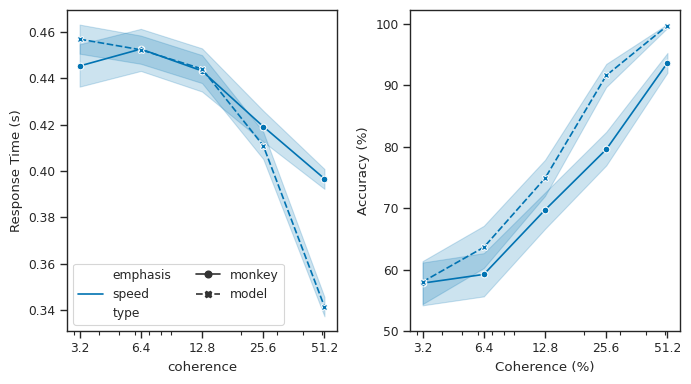

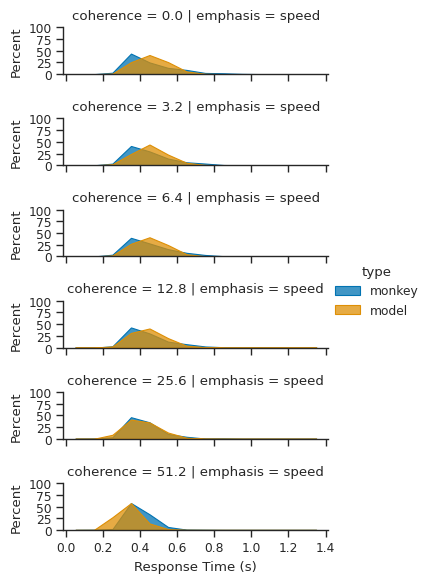

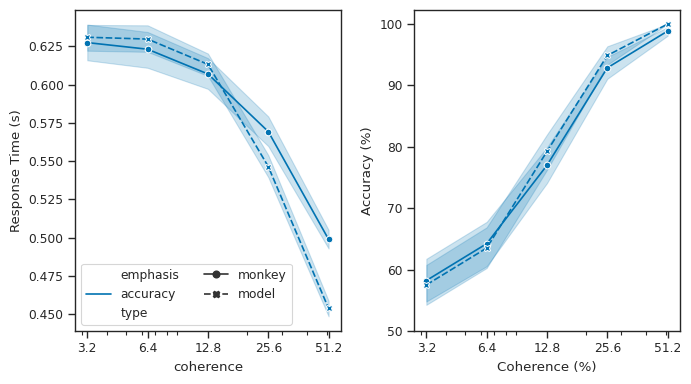

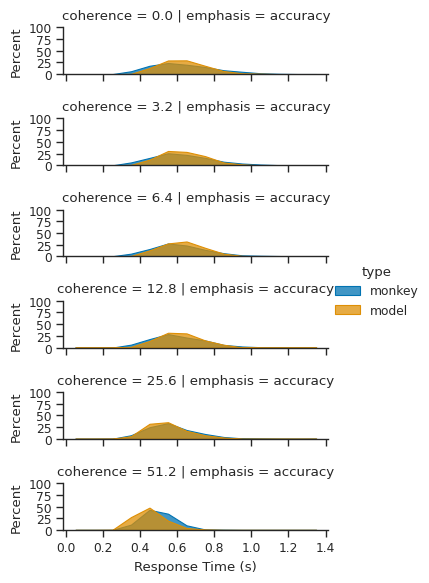

In [5]:
simulate(ramp=1.67, relative=0.24, threshold=0.27, trials=800, load=False, estimator=np.mean, name="dec18shareTLspeed800", emphases=['speed'])
simulate(ramp=1.14, relative=0.24, threshold=0.27, trials=800, load=False, estimator=np.mean, name="dec18shareTLaccuracy800", emphases=['accuracy'])

emphasis speed, coherence 0.0, trial 0, RT 0.436
emphasis speed, coherence 0.0, trial 1, RT 0.47300000000000003
emphasis speed, coherence 0.0, trial 2, RT 0.481
emphasis speed, coherence 0.0, trial 3, RT 0.309
emphasis speed, coherence 0.0, trial 4, RT 0.586
emphasis speed, coherence 0.0, trial 5, RT 0.636
emphasis speed, coherence 0.0, trial 6, RT 0.313
emphasis speed, coherence 0.0, trial 7, RT 0.443
emphasis speed, coherence 0.0, trial 8, RT 0.528
emphasis speed, coherence 0.0, trial 9, RT 0.378
emphasis speed, coherence 0.0, trial 10, RT 0.428
emphasis speed, coherence 0.0, trial 11, RT 0.628
emphasis speed, coherence 0.0, trial 12, RT 0.393
emphasis speed, coherence 0.0, trial 13, RT 0.42
emphasis speed, coherence 0.0, trial 14, RT 0.462
emphasis speed, coherence 0.0, trial 15, RT 0.499
emphasis speed, coherence 0.0, trial 16, RT 0.52
emphasis speed, coherence 0.0, trial 17, RT 0.6930000000000001
emphasis speed, coherence 0.0, trial 18, RT 0.424
emphasis speed, coherence 0.0, tria

emphasis speed, coherence 0.0, trial 159, RT 0.456
emphasis speed, coherence 0.0, trial 160, RT 0.544
emphasis speed, coherence 0.0, trial 161, RT 0.502
emphasis speed, coherence 0.0, trial 162, RT 0.449
emphasis speed, coherence 0.0, trial 163, RT 0.53
emphasis speed, coherence 0.0, trial 164, RT 0.41000000000000003
emphasis speed, coherence 0.0, trial 165, RT 0.527
emphasis speed, coherence 0.0, trial 166, RT 0.403
emphasis speed, coherence 0.0, trial 167, RT 0.418
emphasis speed, coherence 0.0, trial 168, RT 0.511
emphasis speed, coherence 0.0, trial 169, RT 0.541
emphasis speed, coherence 0.0, trial 170, RT 0.441
emphasis speed, coherence 0.0, trial 171, RT 0.358
emphasis speed, coherence 0.0, trial 172, RT 0.393
emphasis speed, coherence 0.0, trial 173, RT 0.366
emphasis speed, coherence 0.0, trial 174, RT 0.521
emphasis speed, coherence 0.0, trial 175, RT 0.528
emphasis speed, coherence 0.0, trial 176, RT 0.488
emphasis speed, coherence 0.0, trial 177, RT 0.49
emphasis speed, coh

emphasis speed, coherence 0.0, trial 316, RT 0.467
emphasis speed, coherence 0.0, trial 317, RT 0.421
emphasis speed, coherence 0.0, trial 318, RT 0.492
emphasis speed, coherence 0.0, trial 319, RT 0.432
emphasis speed, coherence 0.0, trial 320, RT 0.358
emphasis speed, coherence 0.0, trial 321, RT 0.331
emphasis speed, coherence 0.0, trial 322, RT 0.343
emphasis speed, coherence 0.0, trial 323, RT 0.41100000000000003
emphasis speed, coherence 0.0, trial 324, RT 0.406
emphasis speed, coherence 0.0, trial 325, RT 0.507
emphasis speed, coherence 0.0, trial 326, RT 0.37
emphasis speed, coherence 0.0, trial 327, RT 0.376
emphasis speed, coherence 0.0, trial 328, RT 0.468
emphasis speed, coherence 0.0, trial 329, RT 0.5
emphasis speed, coherence 0.0, trial 330, RT 0.528
emphasis speed, coherence 0.0, trial 331, RT 0.502
emphasis speed, coherence 0.0, trial 332, RT 0.308
emphasis speed, coherence 0.0, trial 333, RT 0.421
emphasis speed, coherence 0.0, trial 334, RT 0.493
emphasis speed, cohe

emphasis speed, coherence 0.0, trial 472, RT 0.334
emphasis speed, coherence 0.0, trial 473, RT 0.496
emphasis speed, coherence 0.0, trial 474, RT 0.374
emphasis speed, coherence 0.0, trial 475, RT 0.452
emphasis speed, coherence 0.0, trial 476, RT 0.37
emphasis speed, coherence 0.0, trial 477, RT 0.419
emphasis speed, coherence 0.0, trial 478, RT 0.371
emphasis speed, coherence 0.0, trial 479, RT 0.467
emphasis speed, coherence 0.0, trial 480, RT 0.48
emphasis speed, coherence 0.0, trial 481, RT 0.339
emphasis speed, coherence 0.0, trial 482, RT 0.34600000000000003
emphasis speed, coherence 0.0, trial 483, RT 0.38
emphasis speed, coherence 0.0, trial 484, RT 0.34
emphasis speed, coherence 0.0, trial 485, RT 0.37
emphasis speed, coherence 0.0, trial 486, RT 0.373
emphasis speed, coherence 0.0, trial 487, RT 0.427
emphasis speed, coherence 0.0, trial 488, RT 0.277
emphasis speed, coherence 0.0, trial 489, RT 0.259
emphasis speed, coherence 0.0, trial 490, RT 0.496
emphasis speed, cohere

emphasis speed, coherence 0.0, trial 629, RT 0.319
emphasis speed, coherence 0.0, trial 630, RT 0.511
emphasis speed, coherence 0.0, trial 631, RT 0.419
emphasis speed, coherence 0.0, trial 632, RT 0.619
emphasis speed, coherence 0.0, trial 633, RT 0.47600000000000003
emphasis speed, coherence 0.0, trial 634, RT 0.494
emphasis speed, coherence 0.0, trial 635, RT 0.47000000000000003
emphasis speed, coherence 0.0, trial 636, RT 0.658
emphasis speed, coherence 0.0, trial 637, RT 0.4
emphasis speed, coherence 0.0, trial 638, RT 0.555
emphasis speed, coherence 0.0, trial 639, RT 0.426
emphasis speed, coherence 0.0, trial 640, RT 0.457
emphasis speed, coherence 0.0, trial 641, RT 0.502
emphasis speed, coherence 0.0, trial 642, RT 0.5660000000000001
emphasis speed, coherence 0.0, trial 643, RT 0.492
emphasis speed, coherence 0.0, trial 644, RT 0.309
emphasis speed, coherence 0.0, trial 645, RT 0.5750000000000001
emphasis speed, coherence 0.0, trial 646, RT 0.434
emphasis speed, coherence 0.0,

emphasis speed, coherence 0.0, trial 783, RT 0.48
emphasis speed, coherence 0.0, trial 784, RT 0.392
emphasis speed, coherence 0.0, trial 785, RT 0.399
emphasis speed, coherence 0.0, trial 786, RT 0.536
emphasis speed, coherence 0.0, trial 787, RT 0.515
emphasis speed, coherence 0.0, trial 788, RT 0.484
emphasis speed, coherence 0.0, trial 789, RT 0.546
emphasis speed, coherence 0.0, trial 790, RT 0.401
emphasis speed, coherence 0.0, trial 791, RT 0.603
emphasis speed, coherence 0.0, trial 792, RT 0.34700000000000003
emphasis speed, coherence 0.0, trial 793, RT 0.45
emphasis speed, coherence 0.0, trial 794, RT 0.505
emphasis speed, coherence 0.0, trial 795, RT 0.523
emphasis speed, coherence 0.0, trial 796, RT 0.379
emphasis speed, coherence 0.0, trial 797, RT 0.306
emphasis speed, coherence 0.0, trial 798, RT 0.481
emphasis speed, coherence 0.0, trial 799, RT 0.545
emphasis speed, coherence 0.032, trial 0, RT 0.397
emphasis speed, coherence 0.032, trial 1, RT 0.58
emphasis speed, cohe

emphasis speed, coherence 0.032, trial 135, RT 0.508
emphasis speed, coherence 0.032, trial 136, RT 0.511
emphasis speed, coherence 0.032, trial 137, RT 0.507
emphasis speed, coherence 0.032, trial 138, RT 0.35100000000000003
emphasis speed, coherence 0.032, trial 139, RT 0.533
emphasis speed, coherence 0.032, trial 140, RT 0.511
emphasis speed, coherence 0.032, trial 141, RT 0.418
emphasis speed, coherence 0.032, trial 142, RT 0.47600000000000003
emphasis speed, coherence 0.032, trial 143, RT 0.445
emphasis speed, coherence 0.032, trial 144, RT 0.47000000000000003
emphasis speed, coherence 0.032, trial 145, RT 0.461
emphasis speed, coherence 0.032, trial 146, RT 0.481
emphasis speed, coherence 0.032, trial 147, RT 0.435
emphasis speed, coherence 0.032, trial 148, RT 0.647
emphasis speed, coherence 0.032, trial 149, RT 0.357
emphasis speed, coherence 0.032, trial 150, RT 0.457
emphasis speed, coherence 0.032, trial 151, RT 0.392
emphasis speed, coherence 0.032, trial 152, RT 0.383
emph

emphasis speed, coherence 0.032, trial 285, RT 0.605
emphasis speed, coherence 0.032, trial 286, RT 0.509
emphasis speed, coherence 0.032, trial 287, RT 0.504
emphasis speed, coherence 0.032, trial 288, RT 0.298
emphasis speed, coherence 0.032, trial 289, RT 0.637
emphasis speed, coherence 0.032, trial 290, RT 0.551
emphasis speed, coherence 0.032, trial 291, RT 0.545
emphasis speed, coherence 0.032, trial 292, RT 0.35000000000000003
emphasis speed, coherence 0.032, trial 293, RT 0.384
emphasis speed, coherence 0.032, trial 294, RT 0.538
emphasis speed, coherence 0.032, trial 295, RT 0.53
emphasis speed, coherence 0.032, trial 296, RT 0.421
emphasis speed, coherence 0.032, trial 297, RT 0.596
emphasis speed, coherence 0.032, trial 298, RT 0.326
emphasis speed, coherence 0.032, trial 299, RT 0.334
emphasis speed, coherence 0.032, trial 300, RT 0.355
emphasis speed, coherence 0.032, trial 301, RT 0.377
emphasis speed, coherence 0.032, trial 302, RT 0.594
emphasis speed, coherence 0.032, 

emphasis speed, coherence 0.032, trial 434, RT 0.421
emphasis speed, coherence 0.032, trial 435, RT 0.363
emphasis speed, coherence 0.032, trial 436, RT 0.451
emphasis speed, coherence 0.032, trial 437, RT 0.457
emphasis speed, coherence 0.032, trial 438, RT 0.527
emphasis speed, coherence 0.032, trial 439, RT 0.438
emphasis speed, coherence 0.032, trial 440, RT 0.549
emphasis speed, coherence 0.032, trial 441, RT 0.378
emphasis speed, coherence 0.032, trial 442, RT 0.454
emphasis speed, coherence 0.032, trial 443, RT 0.431
emphasis speed, coherence 0.032, trial 444, RT 0.484
emphasis speed, coherence 0.032, trial 445, RT 0.40800000000000003
emphasis speed, coherence 0.032, trial 446, RT 0.34600000000000003
emphasis speed, coherence 0.032, trial 447, RT 0.396
emphasis speed, coherence 0.032, trial 448, RT 0.494
emphasis speed, coherence 0.032, trial 449, RT 0.484
emphasis speed, coherence 0.032, trial 450, RT 0.371
emphasis speed, coherence 0.032, trial 451, RT 0.41600000000000004
emph

emphasis speed, coherence 0.032, trial 582, RT 0.368
emphasis speed, coherence 0.032, trial 583, RT 0.41400000000000003
emphasis speed, coherence 0.032, trial 584, RT 0.444
emphasis speed, coherence 0.032, trial 585, RT 0.484
emphasis speed, coherence 0.032, trial 586, RT 0.482
emphasis speed, coherence 0.032, trial 587, RT 0.553
emphasis speed, coherence 0.032, trial 588, RT 0.5
emphasis speed, coherence 0.032, trial 589, RT 0.443
emphasis speed, coherence 0.032, trial 590, RT 0.459
emphasis speed, coherence 0.032, trial 591, RT 0.605
emphasis speed, coherence 0.032, trial 592, RT 0.36
emphasis speed, coherence 0.032, trial 593, RT 0.5630000000000001
emphasis speed, coherence 0.032, trial 594, RT 0.399
emphasis speed, coherence 0.032, trial 595, RT 0.335
emphasis speed, coherence 0.032, trial 596, RT 0.406
emphasis speed, coherence 0.032, trial 597, RT 0.487
emphasis speed, coherence 0.032, trial 598, RT 0.449
emphasis speed, coherence 0.032, trial 599, RT 0.47600000000000003
emphasis

emphasis speed, coherence 0.032, trial 732, RT 0.485
emphasis speed, coherence 0.032, trial 733, RT 0.601
emphasis speed, coherence 0.032, trial 734, RT 0.535
emphasis speed, coherence 0.032, trial 735, RT 0.342
emphasis speed, coherence 0.032, trial 736, RT 0.5630000000000001
emphasis speed, coherence 0.032, trial 737, RT 0.532
emphasis speed, coherence 0.032, trial 738, RT 0.467
emphasis speed, coherence 0.032, trial 739, RT 0.309
emphasis speed, coherence 0.032, trial 740, RT 0.37
emphasis speed, coherence 0.032, trial 741, RT 0.47800000000000004
emphasis speed, coherence 0.032, trial 742, RT 0.513
emphasis speed, coherence 0.032, trial 743, RT 0.499
emphasis speed, coherence 0.032, trial 744, RT 0.324
emphasis speed, coherence 0.032, trial 745, RT 0.393
emphasis speed, coherence 0.032, trial 746, RT 0.337
emphasis speed, coherence 0.032, trial 747, RT 0.47000000000000003
emphasis speed, coherence 0.032, trial 748, RT 0.406
emphasis speed, coherence 0.032, trial 749, RT 0.454
emphas

emphasis speed, coherence 0.064, trial 84, RT 0.328
emphasis speed, coherence 0.064, trial 85, RT 0.433
emphasis speed, coherence 0.064, trial 86, RT 0.601
emphasis speed, coherence 0.064, trial 87, RT 0.577
emphasis speed, coherence 0.064, trial 88, RT 0.325
emphasis speed, coherence 0.064, trial 89, RT 0.47800000000000004
emphasis speed, coherence 0.064, trial 90, RT 0.305
emphasis speed, coherence 0.064, trial 91, RT 0.467
emphasis speed, coherence 0.064, trial 92, RT 0.577
emphasis speed, coherence 0.064, trial 93, RT 0.49
emphasis speed, coherence 0.064, trial 94, RT 0.363
emphasis speed, coherence 0.064, trial 95, RT 0.342
emphasis speed, coherence 0.064, trial 96, RT 0.35000000000000003
emphasis speed, coherence 0.064, trial 97, RT 0.374
emphasis speed, coherence 0.064, trial 98, RT 0.34500000000000003
emphasis speed, coherence 0.064, trial 99, RT 0.314
emphasis speed, coherence 0.064, trial 100, RT 0.553
emphasis speed, coherence 0.064, trial 101, RT 0.34800000000000003
emphasi

emphasis speed, coherence 0.064, trial 234, RT 0.468
emphasis speed, coherence 0.064, trial 235, RT 0.365
emphasis speed, coherence 0.064, trial 236, RT 0.489
emphasis speed, coherence 0.064, trial 237, RT 0.58
emphasis speed, coherence 0.064, trial 238, RT 0.47200000000000003
emphasis speed, coherence 0.064, trial 239, RT 0.496
emphasis speed, coherence 0.064, trial 240, RT 0.45
emphasis speed, coherence 0.064, trial 241, RT 0.443
emphasis speed, coherence 0.064, trial 242, RT 0.446
emphasis speed, coherence 0.064, trial 243, RT 0.265
emphasis speed, coherence 0.064, trial 244, RT 0.461
emphasis speed, coherence 0.064, trial 245, RT 0.539
emphasis speed, coherence 0.064, trial 246, RT 0.488
emphasis speed, coherence 0.064, trial 247, RT 0.402
emphasis speed, coherence 0.064, trial 248, RT 0.44
emphasis speed, coherence 0.064, trial 249, RT 0.29
emphasis speed, coherence 0.064, trial 250, RT 0.443
emphasis speed, coherence 0.064, trial 251, RT 0.378
emphasis speed, coherence 0.064, tri

emphasis speed, coherence 0.064, trial 385, RT 0.462
emphasis speed, coherence 0.064, trial 386, RT 0.369
emphasis speed, coherence 0.064, trial 387, RT 0.389
emphasis speed, coherence 0.064, trial 388, RT 0.459
emphasis speed, coherence 0.064, trial 389, RT 0.449
emphasis speed, coherence 0.064, trial 390, RT 0.5
emphasis speed, coherence 0.064, trial 391, RT 0.5640000000000001
emphasis speed, coherence 0.064, trial 392, RT 0.607
emphasis speed, coherence 0.064, trial 393, RT 0.584
emphasis speed, coherence 0.064, trial 394, RT 0.355
emphasis speed, coherence 0.064, trial 395, RT 0.765
emphasis speed, coherence 0.064, trial 396, RT 0.5680000000000001
emphasis speed, coherence 0.064, trial 397, RT 0.393
emphasis speed, coherence 0.064, trial 398, RT 0.429
emphasis speed, coherence 0.064, trial 399, RT 0.372
emphasis speed, coherence 0.064, trial 400, RT 0.503
emphasis speed, coherence 0.064, trial 401, RT 0.458
emphasis speed, coherence 0.064, trial 402, RT 0.596
emphasis speed, cohere

emphasis speed, coherence 0.064, trial 534, RT 0.41200000000000003
emphasis speed, coherence 0.064, trial 535, RT 0.517
emphasis speed, coherence 0.064, trial 536, RT 0.5750000000000001
emphasis speed, coherence 0.064, trial 537, RT 0.397
emphasis speed, coherence 0.064, trial 538, RT 0.462
emphasis speed, coherence 0.064, trial 539, RT 0.436
emphasis speed, coherence 0.064, trial 540, RT 0.456
emphasis speed, coherence 0.064, trial 541, RT 0.40900000000000003
emphasis speed, coherence 0.064, trial 542, RT 0.467
emphasis speed, coherence 0.064, trial 543, RT 0.41500000000000004
emphasis speed, coherence 0.064, trial 544, RT 0.462
emphasis speed, coherence 0.064, trial 545, RT 0.34400000000000003
emphasis speed, coherence 0.064, trial 546, RT 0.492
emphasis speed, coherence 0.064, trial 547, RT 0.385
emphasis speed, coherence 0.064, trial 548, RT 0.366
emphasis speed, coherence 0.064, trial 549, RT 0.541
emphasis speed, coherence 0.064, trial 550, RT 0.376
emphasis speed, coherence 0.06

emphasis speed, coherence 0.064, trial 682, RT 0.492
emphasis speed, coherence 0.064, trial 683, RT 0.531
emphasis speed, coherence 0.064, trial 684, RT 0.358
emphasis speed, coherence 0.064, trial 685, RT 0.396
emphasis speed, coherence 0.064, trial 686, RT 0.5630000000000001
emphasis speed, coherence 0.064, trial 687, RT 0.452
emphasis speed, coherence 0.064, trial 688, RT 0.558
emphasis speed, coherence 0.064, trial 689, RT 0.402
emphasis speed, coherence 0.064, trial 690, RT 0.421
emphasis speed, coherence 0.064, trial 691, RT 0.406
emphasis speed, coherence 0.064, trial 692, RT 0.395
emphasis speed, coherence 0.064, trial 693, RT 0.328
emphasis speed, coherence 0.064, trial 694, RT 0.289
emphasis speed, coherence 0.064, trial 695, RT 0.389
emphasis speed, coherence 0.064, trial 696, RT 0.608
emphasis speed, coherence 0.064, trial 697, RT 0.333
emphasis speed, coherence 0.064, trial 698, RT 0.34400000000000003
emphasis speed, coherence 0.064, trial 699, RT 0.35100000000000003
empha

emphasis speed, coherence 0.128, trial 33, RT 0.51
emphasis speed, coherence 0.128, trial 34, RT 0.355
emphasis speed, coherence 0.128, trial 35, RT 0.43
emphasis speed, coherence 0.128, trial 36, RT 0.8230000000000001
emphasis speed, coherence 0.128, trial 37, RT 0.513
emphasis speed, coherence 0.128, trial 38, RT 0.403
emphasis speed, coherence 0.128, trial 39, RT 0.38
emphasis speed, coherence 0.128, trial 40, RT 0.487
emphasis speed, coherence 0.128, trial 41, RT 0.55
emphasis speed, coherence 0.128, trial 42, RT 0.506
emphasis speed, coherence 0.128, trial 43, RT 0.422
emphasis speed, coherence 0.128, trial 44, RT 0.33
emphasis speed, coherence 0.128, trial 45, RT 0.588
emphasis speed, coherence 0.128, trial 46, RT 0.5720000000000001
emphasis speed, coherence 0.128, trial 47, RT 0.58
emphasis speed, coherence 0.128, trial 48, RT 0.454
emphasis speed, coherence 0.128, trial 49, RT 0.36
emphasis speed, coherence 0.128, trial 50, RT 0.34900000000000003
emphasis speed, coherence 0.128

emphasis speed, coherence 0.128, trial 186, RT 0.362
emphasis speed, coherence 0.128, trial 187, RT 0.387
emphasis speed, coherence 0.128, trial 188, RT 0.466
emphasis speed, coherence 0.128, trial 189, RT 0.485
emphasis speed, coherence 0.128, trial 190, RT 0.47100000000000003
emphasis speed, coherence 0.128, trial 191, RT 0.374
emphasis speed, coherence 0.128, trial 192, RT 0.47900000000000004
emphasis speed, coherence 0.128, trial 193, RT 0.453
emphasis speed, coherence 0.128, trial 194, RT 0.337
emphasis speed, coherence 0.128, trial 195, RT 0.391
emphasis speed, coherence 0.128, trial 196, RT 0.312
emphasis speed, coherence 0.128, trial 197, RT 0.439
emphasis speed, coherence 0.128, trial 198, RT 0.255
emphasis speed, coherence 0.128, trial 199, RT 0.4
emphasis speed, coherence 0.128, trial 200, RT 0.333
emphasis speed, coherence 0.128, trial 201, RT 0.368
emphasis speed, coherence 0.128, trial 202, RT 0.606
emphasis speed, coherence 0.128, trial 203, RT 0.449
emphasis speed, cohe

emphasis speed, coherence 0.128, trial 336, RT 0.34600000000000003
emphasis speed, coherence 0.128, trial 337, RT 0.48
emphasis speed, coherence 0.128, trial 338, RT 0.45
emphasis speed, coherence 0.128, trial 339, RT 0.32
emphasis speed, coherence 0.128, trial 340, RT 0.527
emphasis speed, coherence 0.128, trial 341, RT 0.522
emphasis speed, coherence 0.128, trial 342, RT 0.382
emphasis speed, coherence 0.128, trial 343, RT 0.513
emphasis speed, coherence 0.128, trial 344, RT 0.541
emphasis speed, coherence 0.128, trial 345, RT 0.501
emphasis speed, coherence 0.128, trial 346, RT 0.40700000000000003
emphasis speed, coherence 0.128, trial 347, RT 0.433
emphasis speed, coherence 0.128, trial 348, RT 0.399
emphasis speed, coherence 0.128, trial 349, RT 0.264
emphasis speed, coherence 0.128, trial 350, RT 0.42
emphasis speed, coherence 0.128, trial 351, RT 0.47600000000000003
emphasis speed, coherence 0.128, trial 352, RT 0.453
emphasis speed, coherence 0.128, trial 353, RT 0.339
emphasis

emphasis speed, coherence 0.128, trial 486, RT 0.507
emphasis speed, coherence 0.128, trial 487, RT 0.372
emphasis speed, coherence 0.128, trial 488, RT 0.378
emphasis speed, coherence 0.128, trial 489, RT 0.377
emphasis speed, coherence 0.128, trial 490, RT 0.41000000000000003
emphasis speed, coherence 0.128, trial 491, RT 0.339
emphasis speed, coherence 0.128, trial 492, RT 0.311
emphasis speed, coherence 0.128, trial 493, RT 0.543
emphasis speed, coherence 0.128, trial 494, RT 0.607
emphasis speed, coherence 0.128, trial 495, RT 0.459
emphasis speed, coherence 0.128, trial 496, RT 0.467
emphasis speed, coherence 0.128, trial 497, RT 0.289
emphasis speed, coherence 0.128, trial 498, RT 0.44
emphasis speed, coherence 0.128, trial 499, RT 0.468
emphasis speed, coherence 0.128, trial 500, RT 0.401
emphasis speed, coherence 0.128, trial 501, RT 0.34500000000000003
emphasis speed, coherence 0.128, trial 502, RT 0.34
emphasis speed, coherence 0.128, trial 503, RT 0.417
emphasis speed, cohe

emphasis speed, coherence 0.128, trial 636, RT 0.454
emphasis speed, coherence 0.128, trial 637, RT 0.376
emphasis speed, coherence 0.128, trial 638, RT 0.559
emphasis speed, coherence 0.128, trial 639, RT 0.397
emphasis speed, coherence 0.128, trial 640, RT 0.40900000000000003
emphasis speed, coherence 0.128, trial 641, RT 0.41500000000000004
emphasis speed, coherence 0.128, trial 642, RT 0.462
emphasis speed, coherence 0.128, trial 643, RT 0.447
emphasis speed, coherence 0.128, trial 644, RT 0.428
emphasis speed, coherence 0.128, trial 645, RT 0.385
emphasis speed, coherence 0.128, trial 646, RT 0.616
emphasis speed, coherence 0.128, trial 647, RT 0.37
emphasis speed, coherence 0.128, trial 648, RT 0.367
emphasis speed, coherence 0.128, trial 649, RT 0.39
emphasis speed, coherence 0.128, trial 650, RT 0.39
emphasis speed, coherence 0.128, trial 651, RT 0.555
emphasis speed, coherence 0.128, trial 652, RT 0.41000000000000003
emphasis speed, coherence 0.128, trial 653, RT 0.354
emphasi

emphasis speed, coherence 0.128, trial 784, RT 0.297
emphasis speed, coherence 0.128, trial 785, RT 0.402
emphasis speed, coherence 0.128, trial 786, RT 0.503
emphasis speed, coherence 0.128, trial 787, RT 0.47500000000000003
emphasis speed, coherence 0.128, trial 788, RT 0.293
emphasis speed, coherence 0.128, trial 789, RT 0.417
emphasis speed, coherence 0.128, trial 790, RT 0.47400000000000003
emphasis speed, coherence 0.128, trial 791, RT 0.432
emphasis speed, coherence 0.128, trial 792, RT 0.462
emphasis speed, coherence 0.128, trial 793, RT 0.35100000000000003
emphasis speed, coherence 0.128, trial 794, RT 0.534
emphasis speed, coherence 0.128, trial 795, RT 0.561
emphasis speed, coherence 0.128, trial 796, RT 0.313
emphasis speed, coherence 0.128, trial 797, RT 0.385
emphasis speed, coherence 0.128, trial 798, RT 0.47300000000000003
emphasis speed, coherence 0.128, trial 799, RT 0.533
emphasis speed, coherence 0.256, trial 0, RT 0.454
emphasis speed, coherence 0.256, trial 1, RT 

emphasis speed, coherence 0.256, trial 135, RT 0.353
emphasis speed, coherence 0.256, trial 136, RT 0.334
emphasis speed, coherence 0.256, trial 137, RT 0.462
emphasis speed, coherence 0.256, trial 138, RT 0.426
emphasis speed, coherence 0.256, trial 139, RT 0.456
emphasis speed, coherence 0.256, trial 140, RT 0.402
emphasis speed, coherence 0.256, trial 141, RT 0.5630000000000001
emphasis speed, coherence 0.256, trial 142, RT 0.51
emphasis speed, coherence 0.256, trial 143, RT 0.619
emphasis speed, coherence 0.256, trial 144, RT 0.40700000000000003
emphasis speed, coherence 0.256, trial 145, RT 0.543
emphasis speed, coherence 0.256, trial 146, RT 0.301
emphasis speed, coherence 0.256, trial 147, RT 0.505
emphasis speed, coherence 0.256, trial 148, RT 0.521
emphasis speed, coherence 0.256, trial 149, RT 0.365
emphasis speed, coherence 0.256, trial 150, RT 0.362
emphasis speed, coherence 0.256, trial 151, RT 0.336
emphasis speed, coherence 0.256, trial 152, RT 0.42
emphasis speed, coher

emphasis speed, coherence 0.256, trial 284, RT 0.358
emphasis speed, coherence 0.256, trial 285, RT 0.623
emphasis speed, coherence 0.256, trial 286, RT 0.362
emphasis speed, coherence 0.256, trial 287, RT 0.506
emphasis speed, coherence 0.256, trial 288, RT 0.447
emphasis speed, coherence 0.256, trial 289, RT 0.528
emphasis speed, coherence 0.256, trial 290, RT 0.432
emphasis speed, coherence 0.256, trial 291, RT 0.356
emphasis speed, coherence 0.256, trial 292, RT 0.337
emphasis speed, coherence 0.256, trial 293, RT 0.547
emphasis speed, coherence 0.256, trial 294, RT 0.554
emphasis speed, coherence 0.256, trial 295, RT 0.625
emphasis speed, coherence 0.256, trial 296, RT 0.44
emphasis speed, coherence 0.256, trial 297, RT 0.465
emphasis speed, coherence 0.256, trial 298, RT 0.305
emphasis speed, coherence 0.256, trial 299, RT 0.424
emphasis speed, coherence 0.256, trial 300, RT 0.403
emphasis speed, coherence 0.256, trial 301, RT 0.41100000000000003
emphasis speed, coherence 0.256, 

emphasis speed, coherence 0.256, trial 434, RT 0.536
emphasis speed, coherence 0.256, trial 435, RT 0.34500000000000003
emphasis speed, coherence 0.256, trial 436, RT 0.519
emphasis speed, coherence 0.256, trial 437, RT 0.402
emphasis speed, coherence 0.256, trial 438, RT 0.34800000000000003
emphasis speed, coherence 0.256, trial 439, RT 0.484
emphasis speed, coherence 0.256, trial 440, RT 0.517
emphasis speed, coherence 0.256, trial 441, RT 0.493
emphasis speed, coherence 0.256, trial 442, RT 0.35000000000000003
emphasis speed, coherence 0.256, trial 443, RT 0.591
emphasis speed, coherence 0.256, trial 444, RT 0.41300000000000003
emphasis speed, coherence 0.256, trial 445, RT 0.33
emphasis speed, coherence 0.256, trial 446, RT 0.45
emphasis speed, coherence 0.256, trial 447, RT 0.332
emphasis speed, coherence 0.256, trial 448, RT 0.551
emphasis speed, coherence 0.256, trial 449, RT 0.45
emphasis speed, coherence 0.256, trial 450, RT 0.397
emphasis speed, coherence 0.256, trial 451, RT

emphasis speed, coherence 0.256, trial 581, RT 0.561
emphasis speed, coherence 0.256, trial 582, RT 0.405
emphasis speed, coherence 0.256, trial 583, RT 0.581
emphasis speed, coherence 0.256, trial 584, RT 0.388
emphasis speed, coherence 0.256, trial 585, RT 0.436
emphasis speed, coherence 0.256, trial 586, RT 0.46
emphasis speed, coherence 0.256, trial 587, RT 0.481
emphasis speed, coherence 0.256, trial 588, RT 0.365
emphasis speed, coherence 0.256, trial 589, RT 0.392
emphasis speed, coherence 0.256, trial 590, RT 0.419
emphasis speed, coherence 0.256, trial 591, RT 0.435
emphasis speed, coherence 0.256, trial 592, RT 0.593
emphasis speed, coherence 0.256, trial 593, RT 0.556
emphasis speed, coherence 0.256, trial 594, RT 0.4
emphasis speed, coherence 0.256, trial 595, RT 0.41100000000000003
emphasis speed, coherence 0.256, trial 596, RT 0.376
emphasis speed, coherence 0.256, trial 597, RT 0.364
emphasis speed, coherence 0.256, trial 598, RT 0.482
emphasis speed, coherence 0.256, tr

emphasis speed, coherence 0.256, trial 730, RT 0.441
emphasis speed, coherence 0.256, trial 731, RT 0.523
emphasis speed, coherence 0.256, trial 732, RT 0.324
emphasis speed, coherence 0.256, trial 733, RT 0.394
emphasis speed, coherence 0.256, trial 734, RT 0.487
emphasis speed, coherence 0.256, trial 735, RT 0.443
emphasis speed, coherence 0.256, trial 736, RT 0.515
emphasis speed, coherence 0.256, trial 737, RT 0.455
emphasis speed, coherence 0.256, trial 738, RT 0.369
emphasis speed, coherence 0.256, trial 739, RT 0.34900000000000003
emphasis speed, coherence 0.256, trial 740, RT 0.452
emphasis speed, coherence 0.256, trial 741, RT 0.47800000000000004
emphasis speed, coherence 0.256, trial 742, RT 0.442
emphasis speed, coherence 0.256, trial 743, RT 0.485
emphasis speed, coherence 0.256, trial 744, RT 0.353
emphasis speed, coherence 0.256, trial 745, RT 0.395
emphasis speed, coherence 0.256, trial 746, RT 0.405
emphasis speed, coherence 0.256, trial 747, RT 0.431
emphasis speed, co

emphasis speed, coherence 0.512, trial 83, RT 0.329
emphasis speed, coherence 0.512, trial 84, RT 0.41200000000000003
emphasis speed, coherence 0.512, trial 85, RT 0.379
emphasis speed, coherence 0.512, trial 86, RT 0.419
emphasis speed, coherence 0.512, trial 87, RT 0.28600000000000003
emphasis speed, coherence 0.512, trial 88, RT 0.281
emphasis speed, coherence 0.512, trial 89, RT 0.428
emphasis speed, coherence 0.512, trial 90, RT 0.35000000000000003
emphasis speed, coherence 0.512, trial 91, RT 0.293
emphasis speed, coherence 0.512, trial 92, RT 0.41400000000000003
emphasis speed, coherence 0.512, trial 93, RT 0.268
emphasis speed, coherence 0.512, trial 94, RT 0.363
emphasis speed, coherence 0.512, trial 95, RT 0.278
emphasis speed, coherence 0.512, trial 96, RT 0.319
emphasis speed, coherence 0.512, trial 97, RT 0.329
emphasis speed, coherence 0.512, trial 98, RT 0.352
emphasis speed, coherence 0.512, trial 99, RT 0.329
emphasis speed, coherence 0.512, trial 100, RT 0.34500000000

emphasis speed, coherence 0.512, trial 233, RT 0.33
emphasis speed, coherence 0.512, trial 234, RT 0.356
emphasis speed, coherence 0.512, trial 235, RT 0.28600000000000003
emphasis speed, coherence 0.512, trial 236, RT 0.28500000000000003
emphasis speed, coherence 0.512, trial 237, RT 0.41200000000000003
emphasis speed, coherence 0.512, trial 238, RT 0.329
emphasis speed, coherence 0.512, trial 239, RT 0.393
emphasis speed, coherence 0.512, trial 240, RT 0.318
emphasis speed, coherence 0.512, trial 241, RT 0.369
emphasis speed, coherence 0.512, trial 242, RT 0.312
emphasis speed, coherence 0.512, trial 243, RT 0.298
emphasis speed, coherence 0.512, trial 244, RT 0.47300000000000003
emphasis speed, coherence 0.512, trial 245, RT 0.424
emphasis speed, coherence 0.512, trial 246, RT 0.323
emphasis speed, coherence 0.512, trial 247, RT 0.403
emphasis speed, coherence 0.512, trial 248, RT 0.47800000000000004
emphasis speed, coherence 0.512, trial 249, RT 0.39
emphasis speed, coherence 0.512

emphasis speed, coherence 0.512, trial 381, RT 0.322
emphasis speed, coherence 0.512, trial 382, RT 0.468
emphasis speed, coherence 0.512, trial 383, RT 0.47900000000000004
emphasis speed, coherence 0.512, trial 384, RT 0.385
emphasis speed, coherence 0.512, trial 385, RT 0.34600000000000003
emphasis speed, coherence 0.512, trial 386, RT 0.34500000000000003
emphasis speed, coherence 0.512, trial 387, RT 0.38
emphasis speed, coherence 0.512, trial 388, RT 0.426
emphasis speed, coherence 0.512, trial 389, RT 0.421
emphasis speed, coherence 0.512, trial 390, RT 0.47200000000000003
emphasis speed, coherence 0.512, trial 391, RT 0.47600000000000003
emphasis speed, coherence 0.512, trial 392, RT 0.337
emphasis speed, coherence 0.512, trial 393, RT 0.335
emphasis speed, coherence 0.512, trial 394, RT 0.34
emphasis speed, coherence 0.512, trial 395, RT 0.445
emphasis speed, coherence 0.512, trial 396, RT 0.488
emphasis speed, coherence 0.512, trial 397, RT 0.303
emphasis speed, coherence 0.512

emphasis speed, coherence 0.512, trial 530, RT 0.362
emphasis speed, coherence 0.512, trial 531, RT 0.418
emphasis speed, coherence 0.512, trial 532, RT 0.465
emphasis speed, coherence 0.512, trial 533, RT 0.41400000000000003
emphasis speed, coherence 0.512, trial 534, RT 0.445
emphasis speed, coherence 0.512, trial 535, RT 0.366
emphasis speed, coherence 0.512, trial 536, RT 0.34400000000000003
emphasis speed, coherence 0.512, trial 537, RT 0.425
emphasis speed, coherence 0.512, trial 538, RT 0.372
emphasis speed, coherence 0.512, trial 539, RT 0.317
emphasis speed, coherence 0.512, trial 540, RT 0.372
emphasis speed, coherence 0.512, trial 541, RT 0.281
emphasis speed, coherence 0.512, trial 542, RT 0.523
emphasis speed, coherence 0.512, trial 543, RT 0.41000000000000003
emphasis speed, coherence 0.512, trial 544, RT 0.34700000000000003
emphasis speed, coherence 0.512, trial 545, RT 0.385
emphasis speed, coherence 0.512, trial 546, RT 0.448
emphasis speed, coherence 0.512, trial 547,

emphasis speed, coherence 0.512, trial 681, RT 0.418
emphasis speed, coherence 0.512, trial 682, RT 0.3
emphasis speed, coherence 0.512, trial 683, RT 0.38
emphasis speed, coherence 0.512, trial 684, RT 0.339
emphasis speed, coherence 0.512, trial 685, RT 0.367
emphasis speed, coherence 0.512, trial 686, RT 0.313
emphasis speed, coherence 0.512, trial 687, RT 0.435
emphasis speed, coherence 0.512, trial 688, RT 0.342
emphasis speed, coherence 0.512, trial 689, RT 0.307
emphasis speed, coherence 0.512, trial 690, RT 0.273
emphasis speed, coherence 0.512, trial 691, RT 0.429
emphasis speed, coherence 0.512, trial 692, RT 0.403
emphasis speed, coherence 0.512, trial 693, RT 0.316
emphasis speed, coherence 0.512, trial 694, RT 0.35000000000000003
emphasis speed, coherence 0.512, trial 695, RT 0.233
emphasis speed, coherence 0.512, trial 696, RT 0.41500000000000004
emphasis speed, coherence 0.512, trial 697, RT 0.28300000000000003
emphasis speed, coherence 0.512, trial 698, RT 0.309
emphasi

/tmp/ipykernel_25857/150977287.py:60: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='RT', hue='emphasis',
/tmp/ipykernel_25857/150977287.py:63: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='accuracy', hue='emphasis',


emphasis accuracy, coherence 0.0, trial 0, RT 0.616
emphasis accuracy, coherence 0.0, trial 1, RT 0.47400000000000003
emphasis accuracy, coherence 0.0, trial 2, RT 0.7010000000000001
emphasis accuracy, coherence 0.0, trial 3, RT 0.457
emphasis accuracy, coherence 0.0, trial 4, RT 0.525
emphasis accuracy, coherence 0.0, trial 5, RT 1.038
emphasis accuracy, coherence 0.0, trial 6, RT 0.632
emphasis accuracy, coherence 0.0, trial 7, RT 0.548
emphasis accuracy, coherence 0.0, trial 8, RT 0.46900000000000003
emphasis accuracy, coherence 0.0, trial 9, RT 0.765
emphasis accuracy, coherence 0.0, trial 10, RT 0.739
emphasis accuracy, coherence 0.0, trial 11, RT 0.468
emphasis accuracy, coherence 0.0, trial 12, RT 0.757
emphasis accuracy, coherence 0.0, trial 13, RT 0.898
emphasis accuracy, coherence 0.0, trial 14, RT 0.542
emphasis accuracy, coherence 0.0, trial 15, RT 0.686
emphasis accuracy, coherence 0.0, trial 16, RT 0.442
emphasis accuracy, coherence 0.0, trial 17, RT 0.512
emphasis accura

emphasis accuracy, coherence 0.0, trial 149, RT 0.738
emphasis accuracy, coherence 0.0, trial 150, RT 0.449
emphasis accuracy, coherence 0.0, trial 151, RT 0.406
emphasis accuracy, coherence 0.0, trial 152, RT 0.8300000000000001
emphasis accuracy, coherence 0.0, trial 153, RT 0.466
emphasis accuracy, coherence 0.0, trial 154, RT 0.892
emphasis accuracy, coherence 0.0, trial 155, RT 0.5690000000000001
emphasis accuracy, coherence 0.0, trial 156, RT 0.635
emphasis accuracy, coherence 0.0, trial 157, RT 0.634
emphasis accuracy, coherence 0.0, trial 158, RT 0.55
emphasis accuracy, coherence 0.0, trial 159, RT 0.47800000000000004
emphasis accuracy, coherence 0.0, trial 160, RT 0.751
emphasis accuracy, coherence 0.0, trial 161, RT 0.9570000000000001
emphasis accuracy, coherence 0.0, trial 162, RT 0.458
emphasis accuracy, coherence 0.0, trial 163, RT 0.659
emphasis accuracy, coherence 0.0, trial 164, RT 0.624
emphasis accuracy, coherence 0.0, trial 165, RT 0.8220000000000001
emphasis accuracy

emphasis accuracy, coherence 0.0, trial 294, RT 0.47600000000000003
emphasis accuracy, coherence 0.0, trial 295, RT 0.799
emphasis accuracy, coherence 0.0, trial 296, RT 0.612
emphasis accuracy, coherence 0.0, trial 297, RT 0.802
emphasis accuracy, coherence 0.0, trial 298, RT 0.5630000000000001
emphasis accuracy, coherence 0.0, trial 299, RT 0.583
emphasis accuracy, coherence 0.0, trial 300, RT 0.491
emphasis accuracy, coherence 0.0, trial 301, RT 0.6950000000000001
emphasis accuracy, coherence 0.0, trial 302, RT 0.767
emphasis accuracy, coherence 0.0, trial 303, RT 0.548
emphasis accuracy, coherence 0.0, trial 304, RT 0.579
emphasis accuracy, coherence 0.0, trial 305, RT 0.668
emphasis accuracy, coherence 0.0, trial 306, RT 0.421
emphasis accuracy, coherence 0.0, trial 307, RT 0.596
emphasis accuracy, coherence 0.0, trial 308, RT 0.505
emphasis accuracy, coherence 0.0, trial 309, RT 0.737
emphasis accuracy, coherence 0.0, trial 310, RT 0.419
emphasis accuracy, coherence 0.0, trial 31

emphasis accuracy, coherence 0.0, trial 441, RT 0.464
emphasis accuracy, coherence 0.0, trial 442, RT 0.615
emphasis accuracy, coherence 0.0, trial 443, RT 0.628
emphasis accuracy, coherence 0.0, trial 444, RT 0.361
emphasis accuracy, coherence 0.0, trial 445, RT 0.651
emphasis accuracy, coherence 0.0, trial 446, RT 0.653
emphasis accuracy, coherence 0.0, trial 447, RT 0.707
emphasis accuracy, coherence 0.0, trial 448, RT 0.864
emphasis accuracy, coherence 0.0, trial 449, RT 1.193
emphasis accuracy, coherence 0.0, trial 450, RT 0.483
emphasis accuracy, coherence 0.0, trial 451, RT 0.531
emphasis accuracy, coherence 0.0, trial 452, RT 0.609
emphasis accuracy, coherence 0.0, trial 453, RT 0.753
emphasis accuracy, coherence 0.0, trial 454, RT 0.758
emphasis accuracy, coherence 0.0, trial 455, RT 0.6
emphasis accuracy, coherence 0.0, trial 456, RT 0.742
emphasis accuracy, coherence 0.0, trial 457, RT 0.486
emphasis accuracy, coherence 0.0, trial 458, RT 0.72
emphasis accuracy, coherence 0.

emphasis accuracy, coherence 0.0, trial 588, RT 0.661
emphasis accuracy, coherence 0.0, trial 589, RT 0.512
emphasis accuracy, coherence 0.0, trial 590, RT 0.405
emphasis accuracy, coherence 0.0, trial 591, RT 1.16
emphasis accuracy, coherence 0.0, trial 592, RT 0.924
emphasis accuracy, coherence 0.0, trial 593, RT 0.47600000000000003
emphasis accuracy, coherence 0.0, trial 594, RT 0.747
emphasis accuracy, coherence 0.0, trial 595, RT 0.551
emphasis accuracy, coherence 0.0, trial 596, RT 0.66
emphasis accuracy, coherence 0.0, trial 597, RT 0.591
emphasis accuracy, coherence 0.0, trial 598, RT 0.772
emphasis accuracy, coherence 0.0, trial 599, RT 0.9550000000000001
emphasis accuracy, coherence 0.0, trial 600, RT 0.639
emphasis accuracy, coherence 0.0, trial 601, RT 0.704
emphasis accuracy, coherence 0.0, trial 602, RT 0.759
emphasis accuracy, coherence 0.0, trial 603, RT 0.851
emphasis accuracy, coherence 0.0, trial 604, RT 0.729
emphasis accuracy, coherence 0.0, trial 605, RT 0.5630000

emphasis accuracy, coherence 0.0, trial 735, RT 0.493
emphasis accuracy, coherence 0.0, trial 736, RT 0.525
emphasis accuracy, coherence 0.0, trial 737, RT 0.841
emphasis accuracy, coherence 0.0, trial 738, RT 0.706
emphasis accuracy, coherence 0.0, trial 739, RT 0.527
emphasis accuracy, coherence 0.0, trial 740, RT 0.5
emphasis accuracy, coherence 0.0, trial 741, RT 0.677
emphasis accuracy, coherence 0.0, trial 742, RT 0.645
emphasis accuracy, coherence 0.0, trial 743, RT 0.329
emphasis accuracy, coherence 0.0, trial 744, RT 0.533
emphasis accuracy, coherence 0.0, trial 745, RT 0.87
emphasis accuracy, coherence 0.0, trial 746, RT 0.812
emphasis accuracy, coherence 0.0, trial 747, RT 0.5690000000000001
emphasis accuracy, coherence 0.0, trial 748, RT 0.857
emphasis accuracy, coherence 0.0, trial 749, RT 0.627
emphasis accuracy, coherence 0.0, trial 750, RT 0.683
emphasis accuracy, coherence 0.0, trial 751, RT 0.603
emphasis accuracy, coherence 0.0, trial 752, RT 0.516
emphasis accuracy,

emphasis accuracy, coherence 0.032, trial 81, RT 0.5670000000000001
emphasis accuracy, coherence 0.032, trial 82, RT 0.9400000000000001
emphasis accuracy, coherence 0.032, trial 83, RT 0.709
emphasis accuracy, coherence 0.032, trial 84, RT 0.984
emphasis accuracy, coherence 0.032, trial 85, RT 0.754
emphasis accuracy, coherence 0.032, trial 86, RT 0.598
emphasis accuracy, coherence 0.032, trial 87, RT 0.457
emphasis accuracy, coherence 0.032, trial 88, RT 0.93
emphasis accuracy, coherence 0.032, trial 89, RT 0.624
emphasis accuracy, coherence 0.032, trial 90, RT 0.398
emphasis accuracy, coherence 0.032, trial 91, RT 0.464
emphasis accuracy, coherence 0.032, trial 92, RT 1.027
emphasis accuracy, coherence 0.032, trial 93, RT 0.41100000000000003
emphasis accuracy, coherence 0.032, trial 94, RT 0.511
emphasis accuracy, coherence 0.032, trial 95, RT 0.393
emphasis accuracy, coherence 0.032, trial 96, RT 0.5640000000000001
emphasis accuracy, coherence 0.032, trial 97, RT 0.672
emphasis accu

emphasis accuracy, coherence 0.032, trial 223, RT 0.6900000000000001
emphasis accuracy, coherence 0.032, trial 224, RT 0.5760000000000001
emphasis accuracy, coherence 0.032, trial 225, RT 0.789
emphasis accuracy, coherence 0.032, trial 226, RT 0.584
emphasis accuracy, coherence 0.032, trial 227, RT 0.834
emphasis accuracy, coherence 0.032, trial 228, RT 0.532
emphasis accuracy, coherence 0.032, trial 229, RT 0.339
emphasis accuracy, coherence 0.032, trial 230, RT 0.768
emphasis accuracy, coherence 0.032, trial 231, RT 0.41400000000000003
emphasis accuracy, coherence 0.032, trial 232, RT 0.659
emphasis accuracy, coherence 0.032, trial 233, RT 0.55
emphasis accuracy, coherence 0.032, trial 234, RT 1.061
emphasis accuracy, coherence 0.032, trial 235, RT 0.856
emphasis accuracy, coherence 0.032, trial 236, RT 0.6990000000000001
emphasis accuracy, coherence 0.032, trial 237, RT 0.917
emphasis accuracy, coherence 0.032, trial 238, RT 0.6940000000000001
emphasis accuracy, coherence 0.032, tri

emphasis accuracy, coherence 0.032, trial 364, RT 0.837
emphasis accuracy, coherence 0.032, trial 365, RT 0.532
emphasis accuracy, coherence 0.032, trial 366, RT 0.599
emphasis accuracy, coherence 0.032, trial 367, RT 0.753
emphasis accuracy, coherence 0.032, trial 368, RT 0.704
emphasis accuracy, coherence 0.032, trial 369, RT 0.666
emphasis accuracy, coherence 0.032, trial 370, RT 0.523
emphasis accuracy, coherence 0.032, trial 371, RT 0.577
emphasis accuracy, coherence 0.032, trial 372, RT 0.855
emphasis accuracy, coherence 0.032, trial 373, RT 0.737
emphasis accuracy, coherence 0.032, trial 374, RT 0.513
emphasis accuracy, coherence 0.032, trial 375, RT 0.618
emphasis accuracy, coherence 0.032, trial 376, RT 0.496
emphasis accuracy, coherence 0.032, trial 377, RT 0.546
emphasis accuracy, coherence 0.032, trial 378, RT 0.602
emphasis accuracy, coherence 0.032, trial 379, RT 0.5730000000000001
emphasis accuracy, coherence 0.032, trial 380, RT 0.5630000000000001
emphasis accuracy, coh

emphasis accuracy, coherence 0.032, trial 505, RT 0.542
emphasis accuracy, coherence 0.032, trial 506, RT 0.616
emphasis accuracy, coherence 0.032, trial 507, RT 0.687
emphasis accuracy, coherence 0.032, trial 508, RT 0.641
emphasis accuracy, coherence 0.032, trial 509, RT 0.514
emphasis accuracy, coherence 0.032, trial 510, RT 0.495
emphasis accuracy, coherence 0.032, trial 511, RT 0.725
emphasis accuracy, coherence 0.032, trial 512, RT 0.8290000000000001
emphasis accuracy, coherence 0.032, trial 513, RT 0.608
emphasis accuracy, coherence 0.032, trial 514, RT 0.754
emphasis accuracy, coherence 0.032, trial 515, RT 0.501
emphasis accuracy, coherence 0.032, trial 516, RT 0.845
emphasis accuracy, coherence 0.032, trial 517, RT 1.1380000000000001
emphasis accuracy, coherence 0.032, trial 518, RT 0.858
emphasis accuracy, coherence 0.032, trial 519, RT 0.517
emphasis accuracy, coherence 0.032, trial 520, RT 0.615
emphasis accuracy, coherence 0.032, trial 521, RT 1.01
emphasis accuracy, cohe

emphasis accuracy, coherence 0.032, trial 649, RT 0.716
emphasis accuracy, coherence 0.032, trial 650, RT 0.5700000000000001
emphasis accuracy, coherence 0.032, trial 651, RT 0.766
emphasis accuracy, coherence 0.032, trial 652, RT 0.375
emphasis accuracy, coherence 0.032, trial 653, RT 0.628
emphasis accuracy, coherence 0.032, trial 654, RT 0.542
emphasis accuracy, coherence 0.032, trial 655, RT 0.767
emphasis accuracy, coherence 0.032, trial 656, RT 0.63
emphasis accuracy, coherence 0.032, trial 657, RT 0.435
emphasis accuracy, coherence 0.032, trial 658, RT 0.863
emphasis accuracy, coherence 0.032, trial 659, RT 0.9
emphasis accuracy, coherence 0.032, trial 660, RT 0.377
emphasis accuracy, coherence 0.032, trial 661, RT 0.435
emphasis accuracy, coherence 0.032, trial 662, RT 0.488
emphasis accuracy, coherence 0.032, trial 663, RT 0.869
emphasis accuracy, coherence 0.032, trial 664, RT 0.666
emphasis accuracy, coherence 0.032, trial 665, RT 0.5690000000000001
emphasis accuracy, cohere

emphasis accuracy, coherence 0.032, trial 791, RT 0.638
emphasis accuracy, coherence 0.032, trial 792, RT 0.768
emphasis accuracy, coherence 0.032, trial 793, RT 0.793
emphasis accuracy, coherence 0.032, trial 794, RT 0.5750000000000001
emphasis accuracy, coherence 0.032, trial 795, RT 0.5630000000000001
emphasis accuracy, coherence 0.032, trial 796, RT 0.643
emphasis accuracy, coherence 0.032, trial 797, RT 0.516
emphasis accuracy, coherence 0.032, trial 798, RT 0.555
emphasis accuracy, coherence 0.032, trial 799, RT 0.7020000000000001
emphasis accuracy, coherence 0.064, trial 0, RT 0.681
emphasis accuracy, coherence 0.064, trial 1, RT 0.865
emphasis accuracy, coherence 0.064, trial 2, RT 0.594
emphasis accuracy, coherence 0.064, trial 3, RT 0.506
emphasis accuracy, coherence 0.064, trial 4, RT 0.795
emphasis accuracy, coherence 0.064, trial 5, RT 0.553
emphasis accuracy, coherence 0.064, trial 6, RT 0.735
emphasis accuracy, coherence 0.064, trial 7, RT 0.591
emphasis accuracy, cohere

emphasis accuracy, coherence 0.064, trial 134, RT 0.44
emphasis accuracy, coherence 0.064, trial 135, RT 0.457
emphasis accuracy, coherence 0.064, trial 136, RT 0.622
emphasis accuracy, coherence 0.064, trial 137, RT 0.9400000000000001
emphasis accuracy, coherence 0.064, trial 138, RT 0.505
emphasis accuracy, coherence 0.064, trial 139, RT 0.639
emphasis accuracy, coherence 0.064, trial 140, RT 0.499
emphasis accuracy, coherence 0.064, trial 141, RT 0.847
emphasis accuracy, coherence 0.064, trial 142, RT 0.424
emphasis accuracy, coherence 0.064, trial 143, RT 0.56
emphasis accuracy, coherence 0.064, trial 144, RT 0.455
emphasis accuracy, coherence 0.064, trial 145, RT 0.352
emphasis accuracy, coherence 0.064, trial 146, RT 0.551
emphasis accuracy, coherence 0.064, trial 147, RT 0.835
emphasis accuracy, coherence 0.064, trial 148, RT 0.8250000000000001
emphasis accuracy, coherence 0.064, trial 149, RT 0.632
emphasis accuracy, coherence 0.064, trial 150, RT 0.536
emphasis accuracy, coher

emphasis accuracy, coherence 0.064, trial 277, RT 0.723
emphasis accuracy, coherence 0.064, trial 278, RT 0.483
emphasis accuracy, coherence 0.064, trial 279, RT 0.552
emphasis accuracy, coherence 0.064, trial 280, RT 0.796
emphasis accuracy, coherence 0.064, trial 281, RT 0.79
emphasis accuracy, coherence 0.064, trial 282, RT 0.521
emphasis accuracy, coherence 0.064, trial 283, RT 0.542
emphasis accuracy, coherence 0.064, trial 284, RT 0.55
emphasis accuracy, coherence 0.064, trial 285, RT 0.9560000000000001
emphasis accuracy, coherence 0.064, trial 286, RT 0.47500000000000003
emphasis accuracy, coherence 0.064, trial 287, RT 0.561
emphasis accuracy, coherence 0.064, trial 288, RT 0.451
emphasis accuracy, coherence 0.064, trial 289, RT 0.764
emphasis accuracy, coherence 0.064, trial 290, RT 0.963
emphasis accuracy, coherence 0.064, trial 291, RT 0.543
emphasis accuracy, coherence 0.064, trial 292, RT 0.777
emphasis accuracy, coherence 0.064, trial 293, RT 0.382
emphasis accuracy, cohe

emphasis accuracy, coherence 0.064, trial 420, RT 0.778
emphasis accuracy, coherence 0.064, trial 421, RT 0.741
emphasis accuracy, coherence 0.064, trial 422, RT 0.797
emphasis accuracy, coherence 0.064, trial 423, RT 0.657
emphasis accuracy, coherence 0.064, trial 424, RT 0.504
emphasis accuracy, coherence 0.064, trial 425, RT 0.872
emphasis accuracy, coherence 0.064, trial 426, RT 0.857
emphasis accuracy, coherence 0.064, trial 427, RT 0.758
emphasis accuracy, coherence 0.064, trial 428, RT 0.428
emphasis accuracy, coherence 0.064, trial 429, RT 0.726
emphasis accuracy, coherence 0.064, trial 430, RT 0.546
emphasis accuracy, coherence 0.064, trial 431, RT 0.893
emphasis accuracy, coherence 0.064, trial 432, RT 0.5710000000000001
emphasis accuracy, coherence 0.064, trial 433, RT 0.555
emphasis accuracy, coherence 0.064, trial 434, RT 0.462
emphasis accuracy, coherence 0.064, trial 435, RT 0.517
emphasis accuracy, coherence 0.064, trial 436, RT 0.8180000000000001
emphasis accuracy, coh

emphasis accuracy, coherence 0.064, trial 561, RT 0.5710000000000001
emphasis accuracy, coherence 0.064, trial 562, RT 0.403
emphasis accuracy, coherence 0.064, trial 563, RT 0.301
emphasis accuracy, coherence 0.064, trial 564, RT 0.902
emphasis accuracy, coherence 0.064, trial 565, RT 0.47100000000000003
emphasis accuracy, coherence 0.064, trial 566, RT 0.756
emphasis accuracy, coherence 0.064, trial 567, RT 0.66
emphasis accuracy, coherence 0.064, trial 568, RT 0.539
emphasis accuracy, coherence 0.064, trial 569, RT 0.655
emphasis accuracy, coherence 0.064, trial 570, RT 0.836
emphasis accuracy, coherence 0.064, trial 571, RT 0.672
emphasis accuracy, coherence 0.064, trial 572, RT 0.437
emphasis accuracy, coherence 0.064, trial 573, RT 0.425
emphasis accuracy, coherence 0.064, trial 574, RT 0.516
emphasis accuracy, coherence 0.064, trial 575, RT 0.545
emphasis accuracy, coherence 0.064, trial 576, RT 1.237
emphasis accuracy, coherence 0.064, trial 577, RT 0.896
emphasis accuracy, coh

emphasis accuracy, coherence 0.064, trial 704, RT 0.614
emphasis accuracy, coherence 0.064, trial 705, RT 0.753
emphasis accuracy, coherence 0.064, trial 706, RT 0.42
emphasis accuracy, coherence 0.064, trial 707, RT 0.666
emphasis accuracy, coherence 0.064, trial 708, RT 0.618
emphasis accuracy, coherence 0.064, trial 709, RT 0.785
emphasis accuracy, coherence 0.064, trial 710, RT 0.707
emphasis accuracy, coherence 0.064, trial 711, RT 0.543
emphasis accuracy, coherence 0.064, trial 712, RT 0.521
emphasis accuracy, coherence 0.064, trial 713, RT 0.592
emphasis accuracy, coherence 0.064, trial 714, RT 0.596
emphasis accuracy, coherence 0.064, trial 715, RT 0.442
emphasis accuracy, coherence 0.064, trial 716, RT 0.468
emphasis accuracy, coherence 0.064, trial 717, RT 0.7020000000000001
emphasis accuracy, coherence 0.064, trial 718, RT 0.41300000000000003
emphasis accuracy, coherence 0.064, trial 719, RT 0.455
emphasis accuracy, coherence 0.064, trial 720, RT 0.736
emphasis accuracy, coh

emphasis accuracy, coherence 0.128, trial 49, RT 0.649
emphasis accuracy, coherence 0.128, trial 50, RT 0.552
emphasis accuracy, coherence 0.128, trial 51, RT 0.363
emphasis accuracy, coherence 0.128, trial 52, RT 0.551
emphasis accuracy, coherence 0.128, trial 53, RT 0.558
emphasis accuracy, coherence 0.128, trial 54, RT 0.902
emphasis accuracy, coherence 0.128, trial 55, RT 0.561
emphasis accuracy, coherence 0.128, trial 56, RT 0.639
emphasis accuracy, coherence 0.128, trial 57, RT 0.793
emphasis accuracy, coherence 0.128, trial 58, RT 0.654
emphasis accuracy, coherence 0.128, trial 59, RT 0.712
emphasis accuracy, coherence 0.128, trial 60, RT 0.5730000000000001
emphasis accuracy, coherence 0.128, trial 61, RT 0.617
emphasis accuracy, coherence 0.128, trial 62, RT 1.168
emphasis accuracy, coherence 0.128, trial 63, RT 0.58
emphasis accuracy, coherence 0.128, trial 64, RT 0.664
emphasis accuracy, coherence 0.128, trial 65, RT 0.742
emphasis accuracy, coherence 0.128, trial 66, RT 0.38

emphasis accuracy, coherence 0.128, trial 192, RT 0.558
emphasis accuracy, coherence 0.128, trial 193, RT 0.592
emphasis accuracy, coherence 0.128, trial 194, RT 0.846
emphasis accuracy, coherence 0.128, trial 195, RT 0.677
emphasis accuracy, coherence 0.128, trial 196, RT 0.428
emphasis accuracy, coherence 0.128, trial 197, RT 0.434
emphasis accuracy, coherence 0.128, trial 198, RT 0.455
emphasis accuracy, coherence 0.128, trial 199, RT 0.399
emphasis accuracy, coherence 0.128, trial 200, RT 0.52
emphasis accuracy, coherence 0.128, trial 201, RT 0.403
emphasis accuracy, coherence 0.128, trial 202, RT 0.785
emphasis accuracy, coherence 0.128, trial 203, RT 0.549
emphasis accuracy, coherence 0.128, trial 204, RT 0.752
emphasis accuracy, coherence 0.128, trial 205, RT 0.5700000000000001
emphasis accuracy, coherence 0.128, trial 206, RT 0.674
emphasis accuracy, coherence 0.128, trial 207, RT 0.8230000000000001
emphasis accuracy, coherence 0.128, trial 208, RT 0.425
emphasis accuracy, cohe

emphasis accuracy, coherence 0.128, trial 335, RT 0.748
emphasis accuracy, coherence 0.128, trial 336, RT 0.419
emphasis accuracy, coherence 0.128, trial 337, RT 0.9540000000000001
emphasis accuracy, coherence 0.128, trial 338, RT 0.501
emphasis accuracy, coherence 0.128, trial 339, RT 0.422
emphasis accuracy, coherence 0.128, trial 340, RT 0.705
emphasis accuracy, coherence 0.128, trial 341, RT 0.37
emphasis accuracy, coherence 0.128, trial 342, RT 0.389
emphasis accuracy, coherence 0.128, trial 343, RT 0.886
emphasis accuracy, coherence 0.128, trial 344, RT 0.588
emphasis accuracy, coherence 0.128, trial 345, RT 0.665
emphasis accuracy, coherence 0.128, trial 346, RT 0.617
emphasis accuracy, coherence 0.128, trial 347, RT 0.434
emphasis accuracy, coherence 0.128, trial 348, RT 0.6930000000000001
emphasis accuracy, coherence 0.128, trial 349, RT 0.589
emphasis accuracy, coherence 0.128, trial 350, RT 0.5
emphasis accuracy, coherence 0.128, trial 351, RT 0.6890000000000001
emphasis acc

emphasis accuracy, coherence 0.128, trial 477, RT 0.722
emphasis accuracy, coherence 0.128, trial 478, RT 0.48
emphasis accuracy, coherence 0.128, trial 479, RT 0.8140000000000001
emphasis accuracy, coherence 0.128, trial 480, RT 0.768
emphasis accuracy, coherence 0.128, trial 481, RT 0.682
emphasis accuracy, coherence 0.128, trial 482, RT 0.632
emphasis accuracy, coherence 0.128, trial 483, RT 0.505
emphasis accuracy, coherence 0.128, trial 484, RT 0.627
emphasis accuracy, coherence 0.128, trial 485, RT 0.87
emphasis accuracy, coherence 0.128, trial 486, RT 0.553
emphasis accuracy, coherence 0.128, trial 487, RT 0.677
emphasis accuracy, coherence 0.128, trial 488, RT 0.6900000000000001
emphasis accuracy, coherence 0.128, trial 489, RT 0.557
emphasis accuracy, coherence 0.128, trial 490, RT 0.40700000000000003
emphasis accuracy, coherence 0.128, trial 491, RT 0.375
emphasis accuracy, coherence 0.128, trial 492, RT 0.41000000000000003
emphasis accuracy, coherence 0.128, trial 493, RT 0.

emphasis accuracy, coherence 0.128, trial 618, RT 0.431
emphasis accuracy, coherence 0.128, trial 619, RT 0.383
emphasis accuracy, coherence 0.128, trial 620, RT 0.803
emphasis accuracy, coherence 0.128, trial 621, RT 0.618
emphasis accuracy, coherence 0.128, trial 622, RT 0.459
emphasis accuracy, coherence 0.128, trial 623, RT 0.503
emphasis accuracy, coherence 0.128, trial 624, RT 0.812
emphasis accuracy, coherence 0.128, trial 625, RT 0.749
emphasis accuracy, coherence 0.128, trial 626, RT 0.662
emphasis accuracy, coherence 0.128, trial 627, RT 0.5690000000000001
emphasis accuracy, coherence 0.128, trial 628, RT 0.321
emphasis accuracy, coherence 0.128, trial 629, RT 0.853
emphasis accuracy, coherence 0.128, trial 630, RT 0.536
emphasis accuracy, coherence 0.128, trial 631, RT 0.553
emphasis accuracy, coherence 0.128, trial 632, RT 0.32
emphasis accuracy, coherence 0.128, trial 633, RT 0.901
emphasis accuracy, coherence 0.128, trial 634, RT 0.538
emphasis accuracy, coherence 0.128, 

emphasis accuracy, coherence 0.128, trial 760, RT 0.486
emphasis accuracy, coherence 0.128, trial 761, RT 0.711
emphasis accuracy, coherence 0.128, trial 762, RT 0.8150000000000001
emphasis accuracy, coherence 0.128, trial 763, RT 0.514
emphasis accuracy, coherence 0.128, trial 764, RT 0.40700000000000003
emphasis accuracy, coherence 0.128, trial 765, RT 0.737
emphasis accuracy, coherence 0.128, trial 766, RT 0.47500000000000003
emphasis accuracy, coherence 0.128, trial 767, RT 0.639
emphasis accuracy, coherence 0.128, trial 768, RT 0.614
emphasis accuracy, coherence 0.128, trial 769, RT 0.404
emphasis accuracy, coherence 0.128, trial 770, RT 0.56
emphasis accuracy, coherence 0.128, trial 771, RT 0.683
emphasis accuracy, coherence 0.128, trial 772, RT 0.361
emphasis accuracy, coherence 0.128, trial 773, RT 0.645
emphasis accuracy, coherence 0.128, trial 774, RT 0.53
emphasis accuracy, coherence 0.128, trial 775, RT 0.489
emphasis accuracy, coherence 0.128, trial 776, RT 0.617
emphasis 

emphasis accuracy, coherence 0.256, trial 106, RT 0.387
emphasis accuracy, coherence 0.256, trial 107, RT 0.598
emphasis accuracy, coherence 0.256, trial 108, RT 0.884
emphasis accuracy, coherence 0.256, trial 109, RT 0.845
emphasis accuracy, coherence 0.256, trial 110, RT 0.444
emphasis accuracy, coherence 0.256, trial 111, RT 0.985
emphasis accuracy, coherence 0.256, trial 112, RT 0.419
emphasis accuracy, coherence 0.256, trial 113, RT 0.326
emphasis accuracy, coherence 0.256, trial 114, RT 0.354
emphasis accuracy, coherence 0.256, trial 115, RT 0.5760000000000001
emphasis accuracy, coherence 0.256, trial 116, RT 0.637
emphasis accuracy, coherence 0.256, trial 117, RT 0.425
emphasis accuracy, coherence 0.256, trial 118, RT 0.54
emphasis accuracy, coherence 0.256, trial 119, RT 0.383
emphasis accuracy, coherence 0.256, trial 120, RT 0.448
emphasis accuracy, coherence 0.256, trial 121, RT 0.58
emphasis accuracy, coherence 0.256, trial 122, RT 0.651
emphasis accuracy, coherence 0.256, t

emphasis accuracy, coherence 0.256, trial 249, RT 0.6890000000000001
emphasis accuracy, coherence 0.256, trial 250, RT 0.591
emphasis accuracy, coherence 0.256, trial 251, RT 0.436
emphasis accuracy, coherence 0.256, trial 252, RT 0.603
emphasis accuracy, coherence 0.256, trial 253, RT 0.457
emphasis accuracy, coherence 0.256, trial 254, RT 0.71
emphasis accuracy, coherence 0.256, trial 255, RT 0.793
emphasis accuracy, coherence 0.256, trial 256, RT 0.799
emphasis accuracy, coherence 0.256, trial 257, RT 0.625
emphasis accuracy, coherence 0.256, trial 258, RT 0.387
emphasis accuracy, coherence 0.256, trial 259, RT 0.878
emphasis accuracy, coherence 0.256, trial 260, RT 0.432
emphasis accuracy, coherence 0.256, trial 261, RT 0.897
emphasis accuracy, coherence 0.256, trial 262, RT 0.511
emphasis accuracy, coherence 0.256, trial 263, RT 0.533
emphasis accuracy, coherence 0.256, trial 264, RT 0.489
emphasis accuracy, coherence 0.256, trial 265, RT 0.439
emphasis accuracy, coherence 0.256, 

emphasis accuracy, coherence 0.256, trial 390, RT 0.676
emphasis accuracy, coherence 0.256, trial 391, RT 0.385
emphasis accuracy, coherence 0.256, trial 392, RT 0.485
emphasis accuracy, coherence 0.256, trial 393, RT 0.661
emphasis accuracy, coherence 0.256, trial 394, RT 0.65
emphasis accuracy, coherence 0.256, trial 395, RT 0.56
emphasis accuracy, coherence 0.256, trial 396, RT 0.724
emphasis accuracy, coherence 0.256, trial 397, RT 0.481
emphasis accuracy, coherence 0.256, trial 398, RT 0.62
emphasis accuracy, coherence 0.256, trial 399, RT 0.466
emphasis accuracy, coherence 0.256, trial 400, RT 0.668
emphasis accuracy, coherence 0.256, trial 401, RT 0.40700000000000003
emphasis accuracy, coherence 0.256, trial 402, RT 0.732
emphasis accuracy, coherence 0.256, trial 403, RT 0.743
emphasis accuracy, coherence 0.256, trial 404, RT 0.5680000000000001
emphasis accuracy, coherence 0.256, trial 405, RT 0.462
emphasis accuracy, coherence 0.256, trial 406, RT 0.525
emphasis accuracy, coher

emphasis accuracy, coherence 0.256, trial 531, RT 0.659
emphasis accuracy, coherence 0.256, trial 532, RT 0.435
emphasis accuracy, coherence 0.256, trial 533, RT 0.847
emphasis accuracy, coherence 0.256, trial 534, RT 0.455
emphasis accuracy, coherence 0.256, trial 535, RT 0.617
emphasis accuracy, coherence 0.256, trial 536, RT 0.332
emphasis accuracy, coherence 0.256, trial 537, RT 0.638
emphasis accuracy, coherence 0.256, trial 538, RT 0.562
emphasis accuracy, coherence 0.256, trial 539, RT 0.595
emphasis accuracy, coherence 0.256, trial 540, RT 0.651
emphasis accuracy, coherence 0.256, trial 541, RT 0.533
emphasis accuracy, coherence 0.256, trial 542, RT 0.539
emphasis accuracy, coherence 0.256, trial 543, RT 0.898
emphasis accuracy, coherence 0.256, trial 544, RT 0.483
emphasis accuracy, coherence 0.256, trial 545, RT 0.518
emphasis accuracy, coherence 0.256, trial 546, RT 0.616
emphasis accuracy, coherence 0.256, trial 547, RT 0.804
emphasis accuracy, coherence 0.256, trial 548, R

emphasis accuracy, coherence 0.256, trial 673, RT 0.596
emphasis accuracy, coherence 0.256, trial 674, RT 0.436
emphasis accuracy, coherence 0.256, trial 675, RT 0.443
emphasis accuracy, coherence 0.256, trial 676, RT 0.512
emphasis accuracy, coherence 0.256, trial 677, RT 0.542
emphasis accuracy, coherence 0.256, trial 678, RT 0.619
emphasis accuracy, coherence 0.256, trial 679, RT 0.405
emphasis accuracy, coherence 0.256, trial 680, RT 0.538
emphasis accuracy, coherence 0.256, trial 681, RT 0.547
emphasis accuracy, coherence 0.256, trial 682, RT 1.027
emphasis accuracy, coherence 0.256, trial 683, RT 0.41500000000000004
emphasis accuracy, coherence 0.256, trial 684, RT 0.34900000000000003
emphasis accuracy, coherence 0.256, trial 685, RT 0.669
emphasis accuracy, coherence 0.256, trial 686, RT 0.784
emphasis accuracy, coherence 0.256, trial 687, RT 0.464
emphasis accuracy, coherence 0.256, trial 688, RT 0.763
emphasis accuracy, coherence 0.256, trial 689, RT 0.359
emphasis accuracy, c

emphasis accuracy, coherence 0.512, trial 16, RT 0.316
emphasis accuracy, coherence 0.512, trial 17, RT 0.422
emphasis accuracy, coherence 0.512, trial 18, RT 0.608
emphasis accuracy, coherence 0.512, trial 19, RT 0.363
emphasis accuracy, coherence 0.512, trial 20, RT 0.41300000000000003
emphasis accuracy, coherence 0.512, trial 21, RT 0.369
emphasis accuracy, coherence 0.512, trial 22, RT 0.34500000000000003
emphasis accuracy, coherence 0.512, trial 23, RT 0.403
emphasis accuracy, coherence 0.512, trial 24, RT 0.40700000000000003
emphasis accuracy, coherence 0.512, trial 25, RT 0.271
emphasis accuracy, coherence 0.512, trial 26, RT 0.342
emphasis accuracy, coherence 0.512, trial 27, RT 0.486
emphasis accuracy, coherence 0.512, trial 28, RT 0.431
emphasis accuracy, coherence 0.512, trial 29, RT 0.5750000000000001
emphasis accuracy, coherence 0.512, trial 30, RT 0.421
emphasis accuracy, coherence 0.512, trial 31, RT 0.487
emphasis accuracy, coherence 0.512, trial 32, RT 0.36
emphasis ac

emphasis accuracy, coherence 0.512, trial 160, RT 0.388
emphasis accuracy, coherence 0.512, trial 161, RT 0.352
emphasis accuracy, coherence 0.512, trial 162, RT 0.405
emphasis accuracy, coherence 0.512, trial 163, RT 0.609
emphasis accuracy, coherence 0.512, trial 164, RT 0.4
emphasis accuracy, coherence 0.512, trial 165, RT 0.52
emphasis accuracy, coherence 0.512, trial 166, RT 0.405
emphasis accuracy, coherence 0.512, trial 167, RT 0.419
emphasis accuracy, coherence 0.512, trial 168, RT 0.4
emphasis accuracy, coherence 0.512, trial 169, RT 0.388
emphasis accuracy, coherence 0.512, trial 170, RT 0.492
emphasis accuracy, coherence 0.512, trial 171, RT 0.514
emphasis accuracy, coherence 0.512, trial 172, RT 0.733
emphasis accuracy, coherence 0.512, trial 173, RT 0.5670000000000001
emphasis accuracy, coherence 0.512, trial 174, RT 0.5630000000000001
emphasis accuracy, coherence 0.512, trial 175, RT 0.278
emphasis accuracy, coherence 0.512, trial 176, RT 0.441
emphasis accuracy, coherenc

emphasis accuracy, coherence 0.512, trial 301, RT 0.331
emphasis accuracy, coherence 0.512, trial 302, RT 0.303
emphasis accuracy, coherence 0.512, trial 303, RT 0.509
emphasis accuracy, coherence 0.512, trial 304, RT 0.268
emphasis accuracy, coherence 0.512, trial 305, RT 0.402
emphasis accuracy, coherence 0.512, trial 306, RT 0.457
emphasis accuracy, coherence 0.512, trial 307, RT 0.333
emphasis accuracy, coherence 0.512, trial 308, RT 0.355
emphasis accuracy, coherence 0.512, trial 309, RT 0.331
emphasis accuracy, coherence 0.512, trial 310, RT 0.336
emphasis accuracy, coherence 0.512, trial 311, RT 0.452
emphasis accuracy, coherence 0.512, trial 312, RT 0.40700000000000003
emphasis accuracy, coherence 0.512, trial 313, RT 0.467
emphasis accuracy, coherence 0.512, trial 314, RT 0.432
emphasis accuracy, coherence 0.512, trial 315, RT 0.29
emphasis accuracy, coherence 0.512, trial 316, RT 0.296
emphasis accuracy, coherence 0.512, trial 317, RT 0.457
emphasis accuracy, coherence 0.512,

emphasis accuracy, coherence 0.512, trial 443, RT 0.47400000000000003
emphasis accuracy, coherence 0.512, trial 444, RT 0.402
emphasis accuracy, coherence 0.512, trial 445, RT 0.664
emphasis accuracy, coherence 0.512, trial 446, RT 0.47500000000000003
emphasis accuracy, coherence 0.512, trial 447, RT 0.464
emphasis accuracy, coherence 0.512, trial 448, RT 0.328
emphasis accuracy, coherence 0.512, trial 449, RT 0.40900000000000003
emphasis accuracy, coherence 0.512, trial 450, RT 0.551
emphasis accuracy, coherence 0.512, trial 451, RT 0.5
emphasis accuracy, coherence 0.512, trial 452, RT 0.449
emphasis accuracy, coherence 0.512, trial 453, RT 0.487
emphasis accuracy, coherence 0.512, trial 454, RT 0.334
emphasis accuracy, coherence 0.512, trial 455, RT 0.397
emphasis accuracy, coherence 0.512, trial 456, RT 0.28
emphasis accuracy, coherence 0.512, trial 457, RT 0.34700000000000003
emphasis accuracy, coherence 0.512, trial 458, RT 0.395
emphasis accuracy, coherence 0.512, trial 459, RT 0

emphasis accuracy, coherence 0.512, trial 585, RT 0.419
emphasis accuracy, coherence 0.512, trial 586, RT 0.47900000000000004
emphasis accuracy, coherence 0.512, trial 587, RT 0.311
emphasis accuracy, coherence 0.512, trial 588, RT 0.438
emphasis accuracy, coherence 0.512, trial 589, RT 0.458
emphasis accuracy, coherence 0.512, trial 590, RT 0.609
emphasis accuracy, coherence 0.512, trial 591, RT 0.491
emphasis accuracy, coherence 0.512, trial 592, RT 0.709
emphasis accuracy, coherence 0.512, trial 593, RT 0.492
emphasis accuracy, coherence 0.512, trial 594, RT 0.556
emphasis accuracy, coherence 0.512, trial 595, RT 0.32
emphasis accuracy, coherence 0.512, trial 596, RT 0.492
emphasis accuracy, coherence 0.512, trial 597, RT 0.37
emphasis accuracy, coherence 0.512, trial 598, RT 0.449
emphasis accuracy, coherence 0.512, trial 599, RT 0.468
emphasis accuracy, coherence 0.512, trial 600, RT 0.434
emphasis accuracy, coherence 0.512, trial 601, RT 0.41300000000000003
emphasis accuracy, coh

emphasis accuracy, coherence 0.512, trial 728, RT 0.40900000000000003
emphasis accuracy, coherence 0.512, trial 729, RT 0.53
emphasis accuracy, coherence 0.512, trial 730, RT 0.359
emphasis accuracy, coherence 0.512, trial 731, RT 0.33
emphasis accuracy, coherence 0.512, trial 732, RT 0.335
emphasis accuracy, coherence 0.512, trial 733, RT 0.41600000000000004
emphasis accuracy, coherence 0.512, trial 734, RT 0.40900000000000003
emphasis accuracy, coherence 0.512, trial 735, RT 0.379
emphasis accuracy, coherence 0.512, trial 736, RT 0.37
emphasis accuracy, coherence 0.512, trial 737, RT 0.453
emphasis accuracy, coherence 0.512, trial 738, RT 0.378
emphasis accuracy, coherence 0.512, trial 739, RT 0.297
emphasis accuracy, coherence 0.512, trial 740, RT 0.559
emphasis accuracy, coherence 0.512, trial 741, RT 0.444
emphasis accuracy, coherence 0.512, trial 742, RT 0.377
emphasis accuracy, coherence 0.512, trial 743, RT 0.629
emphasis accuracy, coherence 0.512, trial 744, RT 0.2390000000000

/tmp/ipykernel_25857/150977287.py:60: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='RT', hue='emphasis',
/tmp/ipykernel_25857/150977287.py:63: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='accuracy', hue='emphasis',


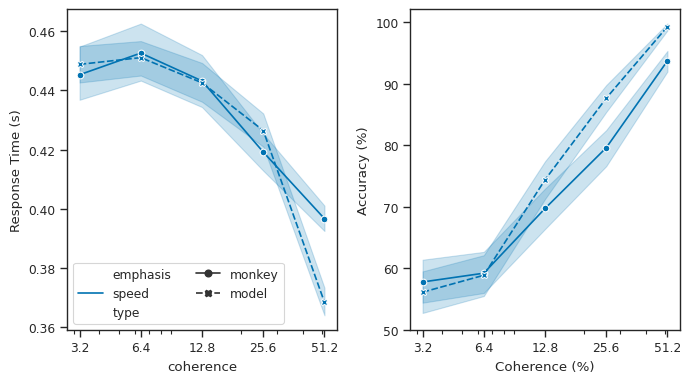

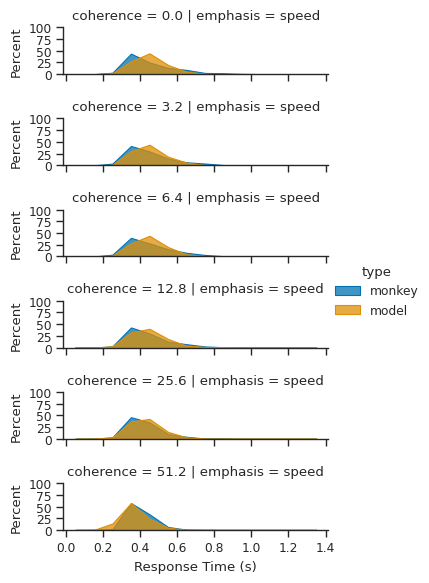

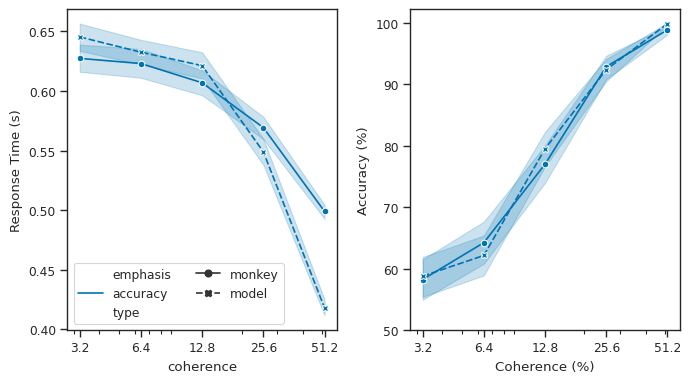

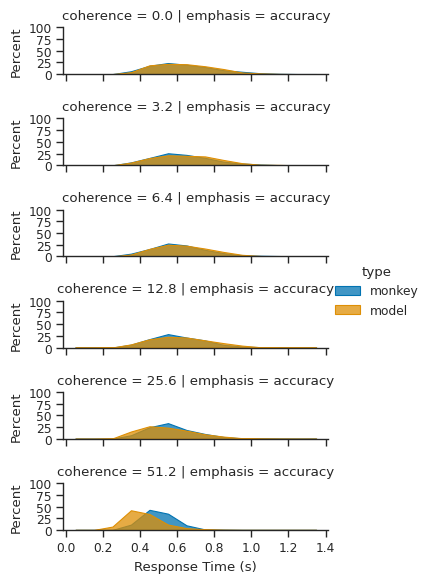

In [9]:
simulate(ramp=0.67, relative=0.02, threshold=0.13, trials=800, load=False, estimator=np.mean, name="dec21shareRTspeed800", emphases=['speed'])
simulate(ramp=0.67, relative=0.48, threshold=0.13, trials=800, load=False, estimator=np.mean, name="dec21shareRTaccuracy800", emphases=['accuracy'])

## Replot

In [22]:
def replot_behavior(name1, name2, pid, estimator=np.mean, bins=np.arange(0.0, 1.5, 0.1)):
    data1 = pd.read_pickle(f"data/{name1}.pkl")
    data2 = pd.read_pickle(f"data/{name2}.pkl")

    hanks = pd.read_pickle("data/hanks2014_behavior.pkl").query("id==@pid")
    combined = pd.concat([hanks, data1, data2])
    # loss = get_loss(combined.query("type=='model'"), combined.query("type=='monkey'"), 100*coherences, emphases, bins)
    # print(f"loss {loss}")

    cohs = 100*np.array([0.032, 0.064, 0.128, 0.256, 0.512])
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=((7, 4)))
    sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='RT', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[0],
                 style='type', estimator=estimator)
    sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='accuracy', hue='emphasis',
                 style='type', palette=palette[:2], markers=True, ax=axes[1])
    axes[0].set(xscale='log', ylabel="Response Time (s)")
    axes[0].legend(ncols=2)
    axes[1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)", yticks=[50,60,70,80,90,100])
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/compare_hanks_SAT2.svg")
    fig.savefig(f"plots/compare_hanks_SAT2.png", dpi=600)
    
    fig = sns.FacetGrid(combined, col='emphasis', row="coherence", hue='type', palette=palette[:2], height=1, aspect=3, sharex=True, legend_out=True)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins)
    fig.set_xlabels("Response Time (s)")
    fig.set(xticks=bins[::2])
    fig.set(yticks=[0,25,50,75,100])
    fig.add_legend()
    fig.savefig(f"plots/compare_hanks_RTs2.svg")
    fig.savefig(f"plots/compare_hanks_RTs2.png", dpi=600)

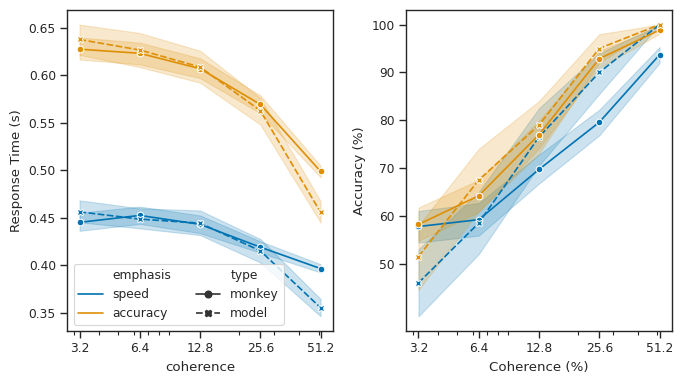

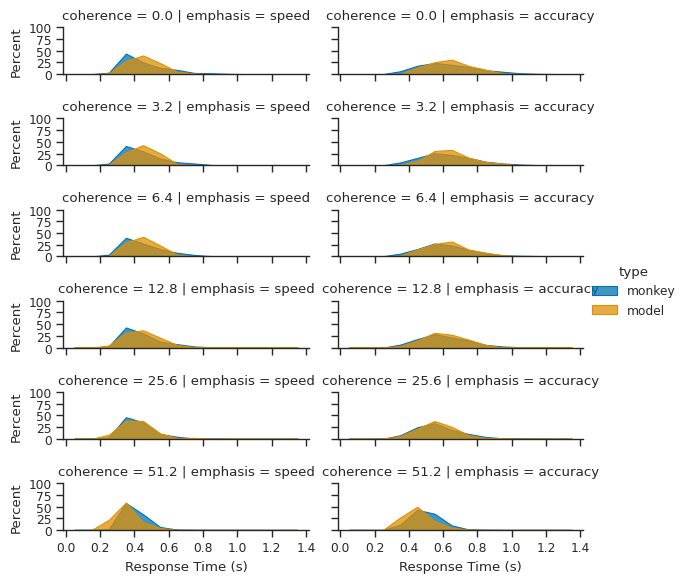

In [21]:
replot_behavior(name1="dec18shareTLspeed", name2="dec18shareTLaccuracy", pid="E")

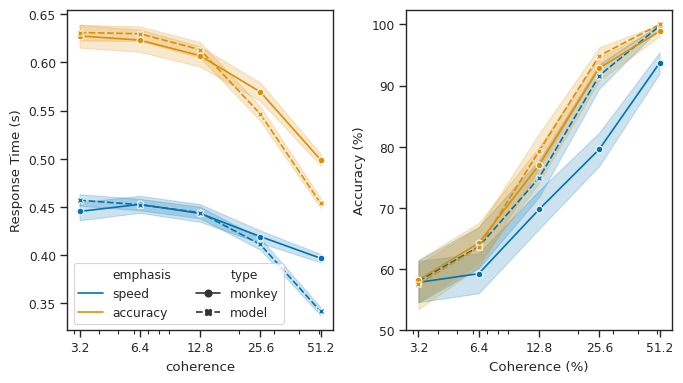

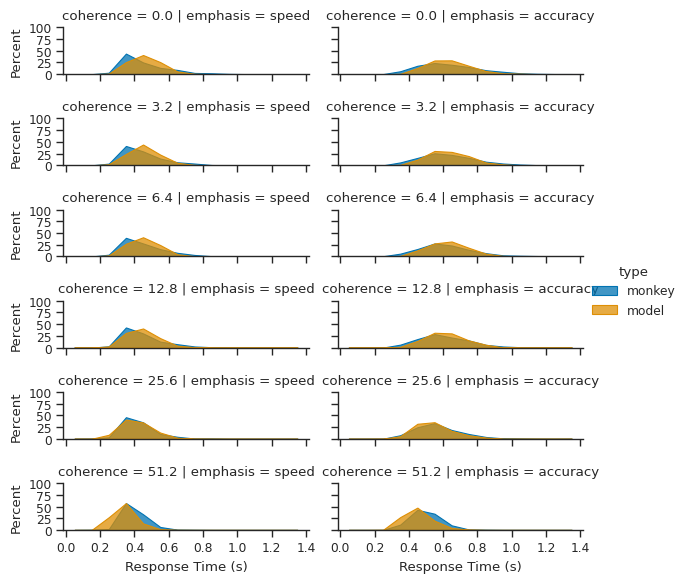

In [8]:
replot_behavior(name1="dec18shareTLspeed800", name2="dec18shareTLaccuracy800", pid="E")

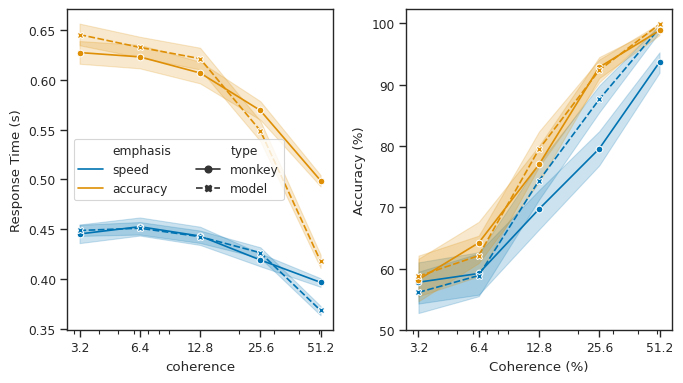

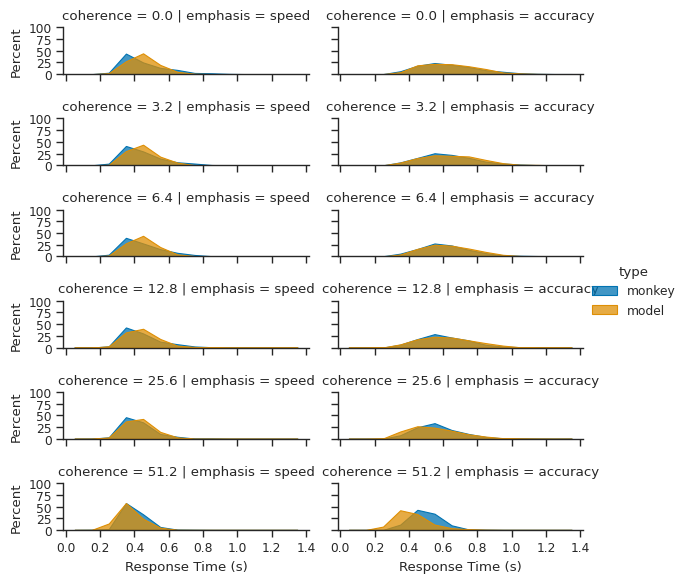

In [10]:
replot_behavior(name1="dec21shareRTspeed800", name2="dec21shareRTaccuracy800", pid="E")

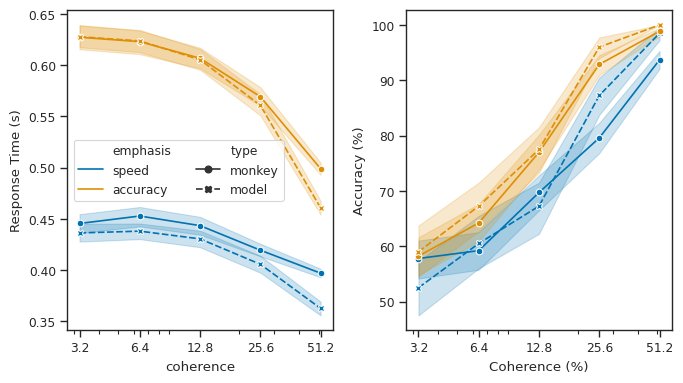

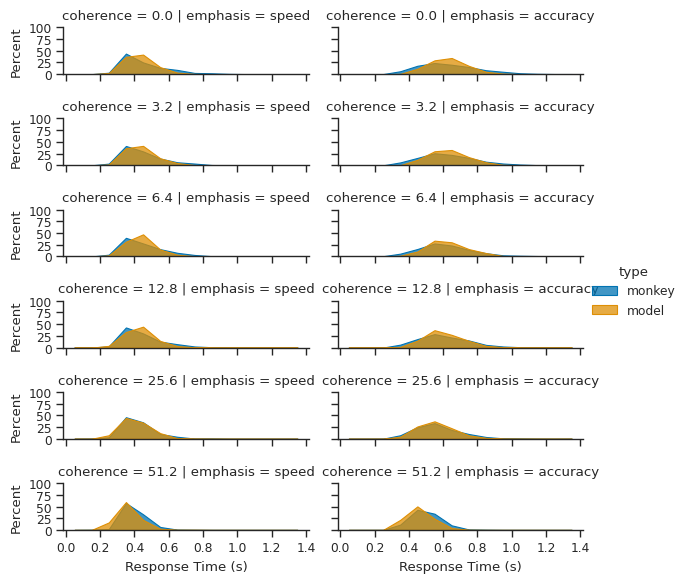

In [23]:
replot_behavior(name1="dec25speed", name2="dec25accuracy", pid="E")

# Firing Rates

In [2]:
def firing_rate(
        # coherences=np.array([0.0, 0.032, 0.064, 0.128, 0.256, 0.512]),
        coherences=np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
        emphases=['speed', 'accuracy'],
        pid="E",
        ramp1=1.5,
        threshold1=0.3,
        relative1=0.5,
        ramp2=1,
        threshold2=0.3,
        relative2=0.5,
        sigma=0.5,
        nActions=2,
        nNeurons=500,
        max_rates=nengo.dists.Uniform(80, 100),
        rA=1.5,
        trials=3,
        perception_seed=0,
        network_seed=0,
        dt=0.001,
        dt_sample=0.03,
        load=False,
        error=('ci', 95),
        estimator=np.median,
        tmax=3,
        tmin=0.1,
        bins=np.arange(0.0, 1.5, 0.1),
        name="hanks_activity_default"):
    
    if not load:
#         columns = ('type', 'id', 'emphasis', 'coherence', 'trial', 'neuron', 'buildup rate', 'final rate')
        columns2 = ('type', 'id', 'emphasis', 'coherence', 'trial', 'mean buildup rate', 'mean final rate')
#         dfs = []
        dfs2 = []
        for e, emphasis in enumerate(emphases):
            ramp = [ramp1, ramp2][e]
            threshold = [threshold1, threshold2][e]
            relative = [relative1, relative2][e]
            inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
            for coherence in coherences:
                for trial in range(trials):
                    inputs.create(coherence=coherence)
                    net = build_network(inputs, nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                                        max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative, probe_spikes=True)
                    sim = nengo.Simulator(net, progress_bar=False)
                    choice = None
                    while choice==None:
                        sim.run(dt)
                        if np.any(sim.data[net.pAction][-1,:] > 0.01):
                            choice = np.argmax(sim.data[net.pAction][-1,:])
                            RT = sim.trange()[-1]
                        if sim.trange()[-1] > tmax:
                            choice = np.argmax(sim.data[net.pValue][-1,:])
                            RT = sim.trange()[-1]
                    correct = True if choice==inputs.correct else False
                    aligned_neuron_idx = np.argwhere(sim.data[net.value].encoders[:,0] > 0.9).ravel()
                    print(f"emphasis {emphasis}, coherence {coherence}, trial {trial}, RT {RT}")
                    DT = RT - tmin
                    buildup_rates = []
                    final_rates = []
                    for neuron in aligned_neuron_idx:
                        # print(sim.data[net.pSpikes][-1,neuron], sim.data[net.pSpikes][int(tmin/dt),neuron])
                        A0 = sim.data[net.pSpikes][int(tmin/dt),neuron]
                        A1 = sim.data[net.pSpikes][-1,neuron]
                        DA =  A1 - A0 
                        if DA>0:
                            buildup_rate = DA/DT
                            buildup_rates.append(buildup_rate)
                            final_rates.append(A1)
#                             dfs.append(pd.DataFrame([['model', 'S', emphasis, 100*coherence, trial, neuron, buildup_rate, A1]], columns=columns))
                    dfs2.append(pd.DataFrame([['model', 'S', emphasis, 100*coherence, trial, np.mean(buildup_rates), np.mean(final_rates)]], columns=columns2))
#         data = pd.concat(dfs, ignore_index=True)
        data2 = pd.concat(dfs2, ignore_index=True)
#         data.to_pickle(f"data/{name}.pkl")
        data2.to_pickle(f"data/{name}2.pkl")
    else:
#         data = pd.read_pickle(f"data/{name}.pkl")
        data2 = pd.read_pickle(f"data/{name}2.pkl")

#     cohs = 100*coherences
#     fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=((7, 3)))
#     sns.lineplot(data=data, x='coherence', y='buildup rate', hue='emphasis',
#                  palette=palette[:2], markers=True, ax=ax, style='type', errorbar=error, estimator=estimator)
#     # ax.set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Buildup Rate (Hz/s)")
#     ax.set(xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Buildup Rate (Hz/s)")
#     ax.legend(ncols=2)
#     plt.tight_layout()
#     fig.savefig(f"plots/hanks_buildup.svg")
#     fig.savefig(f"plots/hanks_buildup.png", dpi=600)
    
    cohs = 100*coherences
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((7, 3)))
    sns.lineplot(data=data2, x='coherence', y='mean buildup rate', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[0], style='type', errorbar=error, estimator=estimator)
    sns.lineplot(data=data2, x='coherence', y='mean final rate', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[1], style='type', errorbar=error, estimator=estimator)
    axes[0].set(xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Mean Buildup Rate (Hz/s)")
    axes[1].set(xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Mean Final Rate (Hz/s)")
    axes[0].legend(ncols=2)
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/hanks_buildup2.svg")
    fig.savefig(f"plots/hanks_buildup2.png", dpi=600)

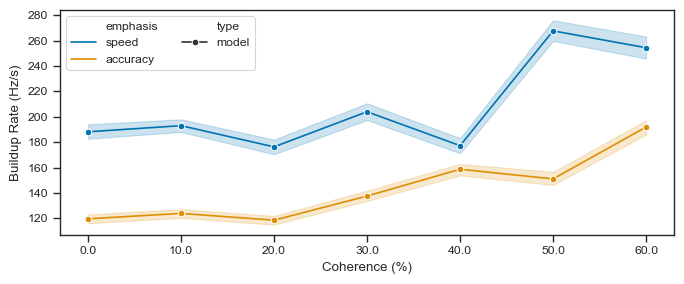

In [89]:
firing_rate(trials=30, load=True, error=("ci", 95), estimator=np.mean,
           ramp1=1.01, relative1=0.15, threshold1=0.17,
           ramp2=2.0, relative2=0.25, threshold2=0.46)

emphasis speed, coherence 0.0, trial 0, RT 0.41500000000000004
emphasis speed, coherence 0.0, trial 1, RT 0.501
emphasis speed, coherence 0.0, trial 2, RT 0.41200000000000003
emphasis speed, coherence 0.0, trial 3, RT 0.324
emphasis speed, coherence 0.0, trial 4, RT 0.629
emphasis speed, coherence 0.0, trial 5, RT 0.707
emphasis speed, coherence 0.0, trial 6, RT 0.315
emphasis speed, coherence 0.0, trial 7, RT 0.47700000000000004
emphasis speed, coherence 0.0, trial 8, RT 0.641
emphasis speed, coherence 0.0, trial 9, RT 0.724
emphasis speed, coherence 0.0, trial 10, RT 0.384
emphasis speed, coherence 0.0, trial 11, RT 0.501
emphasis speed, coherence 0.0, trial 12, RT 0.421
emphasis speed, coherence 0.0, trial 13, RT 0.5630000000000001
emphasis speed, coherence 0.0, trial 14, RT 0.5730000000000001
emphasis speed, coherence 0.0, trial 15, RT 0.541
emphasis speed, coherence 0.0, trial 16, RT 0.429
emphasis speed, coherence 0.0, trial 17, RT 0.43
emphasis speed, coherence 0.0, trial 18, RT

emphasis speed, coherence 0.2, trial 56, RT 0.40900000000000003
emphasis speed, coherence 0.2, trial 57, RT 0.376
emphasis speed, coherence 0.2, trial 58, RT 0.632
emphasis speed, coherence 0.2, trial 59, RT 0.332
emphasis speed, coherence 0.2, trial 60, RT 0.366
emphasis speed, coherence 0.2, trial 61, RT 0.461
emphasis speed, coherence 0.2, trial 62, RT 0.5660000000000001
emphasis speed, coherence 0.2, trial 63, RT 0.436
emphasis speed, coherence 0.2, trial 64, RT 0.482
emphasis speed, coherence 0.2, trial 65, RT 0.391
emphasis speed, coherence 0.2, trial 66, RT 0.352
emphasis speed, coherence 0.2, trial 67, RT 0.558
emphasis speed, coherence 0.2, trial 68, RT 0.34500000000000003
emphasis speed, coherence 0.2, trial 69, RT 0.335
emphasis speed, coherence 0.2, trial 70, RT 0.34400000000000003
emphasis speed, coherence 0.2, trial 71, RT 0.315
emphasis speed, coherence 0.2, trial 72, RT 0.36
emphasis speed, coherence 0.2, trial 73, RT 0.76
emphasis speed, coherence 0.2, trial 74, RT 0.4

/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


emphasis speed, coherence 0.4, trial 43, RT 0.34400000000000003
emphasis speed, coherence 0.4, trial 44, RT 0.362
emphasis speed, coherence 0.4, trial 45, RT 0.47600000000000003
emphasis speed, coherence 0.4, trial 46, RT 0.44
emphasis speed, coherence 0.4, trial 47, RT 0.328
emphasis speed, coherence 0.4, trial 48, RT 0.432
emphasis speed, coherence 0.4, trial 49, RT 0.61
emphasis speed, coherence 0.4, trial 50, RT 0.297
emphasis speed, coherence 0.4, trial 51, RT 0.28300000000000003
emphasis speed, coherence 0.4, trial 52, RT 0.26
emphasis speed, coherence 0.4, trial 53, RT 0.258
emphasis speed, coherence 0.4, trial 54, RT 0.465
emphasis speed, coherence 0.4, trial 55, RT 0.314
emphasis speed, coherence 0.4, trial 56, RT 0.367
emphasis speed, coherence 0.4, trial 57, RT 0.445
emphasis speed, coherence 0.4, trial 58, RT 0.419
emphasis speed, coherence 0.4, trial 59, RT 0.368
emphasis speed, coherence 0.4, trial 60, RT 0.399
emphasis speed, coherence 0.4, trial 61, RT 0.329
emphasis sp

emphasis speed, coherence 0.8, trial 0, RT 0.293
emphasis speed, coherence 0.8, trial 1, RT 0.279
emphasis speed, coherence 0.8, trial 2, RT 0.335
emphasis speed, coherence 0.8, trial 3, RT 0.268
emphasis speed, coherence 0.8, trial 4, RT 0.395
emphasis speed, coherence 0.8, trial 5, RT 0.338
emphasis speed, coherence 0.8, trial 6, RT 0.28200000000000003
emphasis speed, coherence 0.8, trial 7, RT 0.26
emphasis speed, coherence 0.8, trial 8, RT 0.266
emphasis speed, coherence 0.8, trial 9, RT 0.28800000000000003
emphasis speed, coherence 0.8, trial 10, RT 0.35100000000000003
emphasis speed, coherence 0.8, trial 11, RT 0.368
emphasis speed, coherence 0.8, trial 12, RT 0.37
emphasis speed, coherence 0.8, trial 13, RT 0.275
emphasis speed, coherence 0.8, trial 14, RT 0.276
emphasis speed, coherence 0.8, trial 15, RT 0.289
emphasis speed, coherence 0.8, trial 16, RT 0.224
emphasis speed, coherence 0.8, trial 17, RT 0.34800000000000003
emphasis speed, coherence 0.8, trial 18, RT 0.2860000000

emphasis speed, coherence 1.0, trial 59, RT 0.28500000000000003
emphasis speed, coherence 1.0, trial 60, RT 0.335
emphasis speed, coherence 1.0, trial 61, RT 0.28400000000000003
emphasis speed, coherence 1.0, trial 62, RT 0.28800000000000003
emphasis speed, coherence 1.0, trial 63, RT 0.274
emphasis speed, coherence 1.0, trial 64, RT 0.25
emphasis speed, coherence 1.0, trial 65, RT 0.247
emphasis speed, coherence 1.0, trial 66, RT 0.33
emphasis speed, coherence 1.0, trial 67, RT 0.23900000000000002
emphasis speed, coherence 1.0, trial 68, RT 0.274
emphasis speed, coherence 1.0, trial 69, RT 0.28500000000000003
emphasis speed, coherence 1.0, trial 70, RT 0.26
emphasis speed, coherence 1.0, trial 71, RT 0.289
emphasis speed, coherence 1.0, trial 72, RT 0.243
emphasis speed, coherence 1.0, trial 73, RT 0.23500000000000001
emphasis speed, coherence 1.0, trial 74, RT 0.241
emphasis speed, coherence 1.0, trial 75, RT 0.262
emphasis speed, coherence 1.0, trial 76, RT 0.318
emphasis speed, coh

emphasis accuracy, coherence 0.2, trial 12, RT 0.484
emphasis accuracy, coherence 0.2, trial 13, RT 0.445
emphasis accuracy, coherence 0.2, trial 14, RT 0.6900000000000001
emphasis accuracy, coherence 0.2, trial 15, RT 0.523
emphasis accuracy, coherence 0.2, trial 16, RT 0.63
emphasis accuracy, coherence 0.2, trial 17, RT 0.5660000000000001
emphasis accuracy, coherence 0.2, trial 18, RT 0.632
emphasis accuracy, coherence 0.2, trial 19, RT 0.534
emphasis accuracy, coherence 0.2, trial 20, RT 0.686
emphasis accuracy, coherence 0.2, trial 21, RT 0.535
emphasis accuracy, coherence 0.2, trial 22, RT 0.639
emphasis accuracy, coherence 0.2, trial 23, RT 0.726
emphasis accuracy, coherence 0.2, trial 24, RT 0.6930000000000001
emphasis accuracy, coherence 0.2, trial 25, RT 0.599
emphasis accuracy, coherence 0.2, trial 26, RT 0.536
emphasis accuracy, coherence 0.2, trial 27, RT 0.673
emphasis accuracy, coherence 0.2, trial 28, RT 0.6950000000000001
emphasis accuracy, coherence 0.2, trial 29, RT 0

emphasis accuracy, coherence 0.4, trial 61, RT 0.481
emphasis accuracy, coherence 0.4, trial 62, RT 0.40700000000000003
emphasis accuracy, coherence 0.4, trial 63, RT 0.521
emphasis accuracy, coherence 0.4, trial 64, RT 0.47000000000000003
emphasis accuracy, coherence 0.4, trial 65, RT 0.352
emphasis accuracy, coherence 0.4, trial 66, RT 0.436
emphasis accuracy, coherence 0.4, trial 67, RT 0.395
emphasis accuracy, coherence 0.4, trial 68, RT 0.5660000000000001
emphasis accuracy, coherence 0.4, trial 69, RT 0.433
emphasis accuracy, coherence 0.4, trial 70, RT 0.44
emphasis accuracy, coherence 0.4, trial 71, RT 0.722
emphasis accuracy, coherence 0.4, trial 72, RT 0.515
emphasis accuracy, coherence 0.4, trial 73, RT 0.52
emphasis accuracy, coherence 0.4, trial 74, RT 0.495
emphasis accuracy, coherence 0.4, trial 75, RT 0.619
emphasis accuracy, coherence 0.4, trial 76, RT 0.665
emphasis accuracy, coherence 0.4, trial 77, RT 0.353
emphasis accuracy, coherence 0.4, trial 78, RT 0.419
emphasi

emphasis accuracy, coherence 0.8, trial 11, RT 0.39
emphasis accuracy, coherence 0.8, trial 12, RT 0.402
emphasis accuracy, coherence 0.8, trial 13, RT 0.39
emphasis accuracy, coherence 0.8, trial 14, RT 0.385
emphasis accuracy, coherence 0.8, trial 15, RT 0.369
emphasis accuracy, coherence 0.8, trial 16, RT 0.28400000000000003
emphasis accuracy, coherence 0.8, trial 17, RT 0.466
emphasis accuracy, coherence 0.8, trial 18, RT 0.395
emphasis accuracy, coherence 0.8, trial 19, RT 0.352
emphasis accuracy, coherence 0.8, trial 20, RT 0.393
emphasis accuracy, coherence 0.8, trial 21, RT 0.329
emphasis accuracy, coherence 0.8, trial 22, RT 0.376
emphasis accuracy, coherence 0.8, trial 23, RT 0.41600000000000004
emphasis accuracy, coherence 0.8, trial 24, RT 0.343
emphasis accuracy, coherence 0.8, trial 25, RT 0.368
emphasis accuracy, coherence 0.8, trial 26, RT 0.387
emphasis accuracy, coherence 0.8, trial 27, RT 0.383
emphasis accuracy, coherence 0.8, trial 28, RT 0.368
emphasis accuracy, c

emphasis accuracy, coherence 1.0, trial 61, RT 0.329
emphasis accuracy, coherence 1.0, trial 62, RT 0.35100000000000003
emphasis accuracy, coherence 1.0, trial 63, RT 0.304
emphasis accuracy, coherence 1.0, trial 64, RT 0.376
emphasis accuracy, coherence 1.0, trial 65, RT 0.364
emphasis accuracy, coherence 1.0, trial 66, RT 0.321
emphasis accuracy, coherence 1.0, trial 67, RT 0.379
emphasis accuracy, coherence 1.0, trial 68, RT 0.296
emphasis accuracy, coherence 1.0, trial 69, RT 0.32
emphasis accuracy, coherence 1.0, trial 70, RT 0.358
emphasis accuracy, coherence 1.0, trial 71, RT 0.41400000000000003
emphasis accuracy, coherence 1.0, trial 72, RT 0.293
emphasis accuracy, coherence 1.0, trial 73, RT 0.33
emphasis accuracy, coherence 1.0, trial 74, RT 0.401
emphasis accuracy, coherence 1.0, trial 75, RT 0.322
emphasis accuracy, coherence 1.0, trial 76, RT 0.314
emphasis accuracy, coherence 1.0, trial 77, RT 0.324
emphasis accuracy, coherence 1.0, trial 78, RT 0.382
emphasis accuracy, c

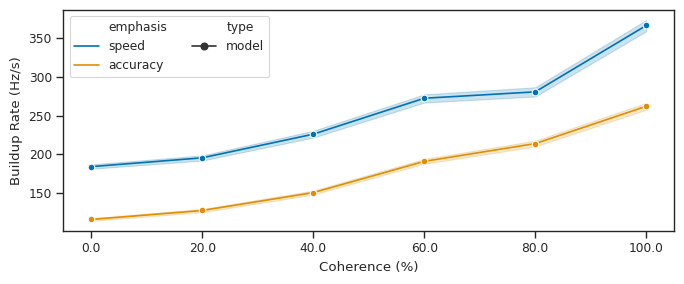

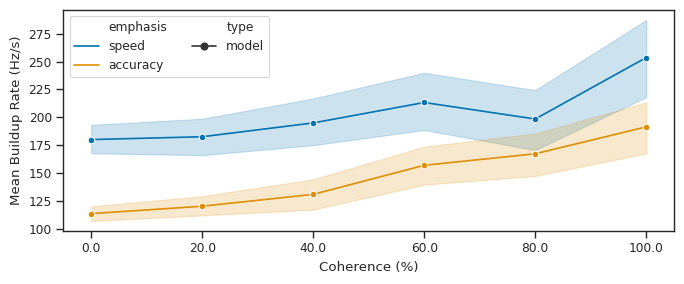

In [18]:
firing_rate(coherences=np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0]), trials=100, load=False, name='dec18shareTL',
            error=("ci", 95), estimator=np.mean, 
            ramp1=1.67, relative1=0.24, threshold1=0.27,
            ramp2=1.14, relative2=0.24, threshold2=0.27)

emphasis speed, coherence 0.0, trial 0, RT 0.436
emphasis speed, coherence 0.0, trial 1, RT 0.47300000000000003
emphasis speed, coherence 0.0, trial 2, RT 0.481
emphasis speed, coherence 0.0, trial 3, RT 0.309
emphasis speed, coherence 0.0, trial 4, RT 0.586
emphasis speed, coherence 0.0, trial 5, RT 0.636
emphasis speed, coherence 0.0, trial 6, RT 0.313
emphasis speed, coherence 0.0, trial 7, RT 0.443
emphasis speed, coherence 0.0, trial 8, RT 0.528
emphasis speed, coherence 0.0, trial 9, RT 0.378
emphasis speed, coherence 0.0, trial 10, RT 0.428
emphasis speed, coherence 0.0, trial 11, RT 0.628
emphasis speed, coherence 0.0, trial 12, RT 0.393
emphasis speed, coherence 0.0, trial 13, RT 0.42
emphasis speed, coherence 0.0, trial 14, RT 0.462
emphasis speed, coherence 0.0, trial 15, RT 0.499
emphasis speed, coherence 0.0, trial 16, RT 0.52
emphasis speed, coherence 0.0, trial 17, RT 0.6930000000000001
emphasis speed, coherence 0.0, trial 18, RT 0.424
emphasis speed, coherence 0.0, tria

emphasis speed, coherence 0.0, trial 159, RT 0.456
emphasis speed, coherence 0.0, trial 160, RT 0.544
emphasis speed, coherence 0.0, trial 161, RT 0.502
emphasis speed, coherence 0.0, trial 162, RT 0.449
emphasis speed, coherence 0.0, trial 163, RT 0.53
emphasis speed, coherence 0.0, trial 164, RT 0.41000000000000003
emphasis speed, coherence 0.0, trial 165, RT 0.527
emphasis speed, coherence 0.0, trial 166, RT 0.403
emphasis speed, coherence 0.0, trial 167, RT 0.418
emphasis speed, coherence 0.0, trial 168, RT 0.511
emphasis speed, coherence 0.0, trial 169, RT 0.541
emphasis speed, coherence 0.0, trial 170, RT 0.441
emphasis speed, coherence 0.0, trial 171, RT 0.358
emphasis speed, coherence 0.0, trial 172, RT 0.393
emphasis speed, coherence 0.0, trial 173, RT 0.366
emphasis speed, coherence 0.0, trial 174, RT 0.521
emphasis speed, coherence 0.0, trial 175, RT 0.528
emphasis speed, coherence 0.0, trial 176, RT 0.488
emphasis speed, coherence 0.0, trial 177, RT 0.49
emphasis speed, coh

emphasis speed, coherence 0.2, trial 117, RT 0.392
emphasis speed, coherence 0.2, trial 118, RT 0.429
emphasis speed, coherence 0.2, trial 119, RT 0.402
emphasis speed, coherence 0.2, trial 120, RT 0.40900000000000003
emphasis speed, coherence 0.2, trial 121, RT 0.363
emphasis speed, coherence 0.2, trial 122, RT 0.549
emphasis speed, coherence 0.2, trial 123, RT 0.358
emphasis speed, coherence 0.2, trial 124, RT 0.523
emphasis speed, coherence 0.2, trial 125, RT 0.369
emphasis speed, coherence 0.2, trial 126, RT 0.535
emphasis speed, coherence 0.2, trial 127, RT 0.555
emphasis speed, coherence 0.2, trial 128, RT 0.439
emphasis speed, coherence 0.2, trial 129, RT 0.45
emphasis speed, coherence 0.2, trial 130, RT 0.462
emphasis speed, coherence 0.2, trial 131, RT 0.427
emphasis speed, coherence 0.2, trial 132, RT 0.434
emphasis speed, coherence 0.2, trial 133, RT 0.34900000000000003
emphasis speed, coherence 0.2, trial 134, RT 0.381
emphasis speed, coherence 0.2, trial 135, RT 0.352
emph

emphasis speed, coherence 0.4, trial 73, RT 0.41000000000000003
emphasis speed, coherence 0.4, trial 74, RT 0.40700000000000003
emphasis speed, coherence 0.4, trial 75, RT 0.34900000000000003
emphasis speed, coherence 0.4, trial 76, RT 0.42
emphasis speed, coherence 0.4, trial 77, RT 0.383
emphasis speed, coherence 0.4, trial 78, RT 0.34
emphasis speed, coherence 0.4, trial 79, RT 0.398
emphasis speed, coherence 0.4, trial 80, RT 0.506
emphasis speed, coherence 0.4, trial 81, RT 0.34500000000000003
emphasis speed, coherence 0.4, trial 82, RT 0.403
emphasis speed, coherence 0.4, trial 83, RT 0.384
emphasis speed, coherence 0.4, trial 84, RT 0.36
emphasis speed, coherence 0.4, trial 85, RT 0.394
emphasis speed, coherence 0.4, trial 86, RT 0.64
emphasis speed, coherence 0.4, trial 87, RT 0.501
emphasis speed, coherence 0.4, trial 88, RT 0.33
emphasis speed, coherence 0.4, trial 89, RT 0.324
emphasis speed, coherence 0.4, trial 90, RT 0.296
emphasis speed, coherence 0.4, trial 91, RT 0.288

emphasis speed, coherence 0.6, trial 29, RT 0.323
emphasis speed, coherence 0.6, trial 30, RT 0.355
emphasis speed, coherence 0.6, trial 31, RT 0.34600000000000003
emphasis speed, coherence 0.6, trial 32, RT 0.5640000000000001
emphasis speed, coherence 0.6, trial 33, RT 0.276
emphasis speed, coherence 0.6, trial 34, RT 0.326
emphasis speed, coherence 0.6, trial 35, RT 0.43
emphasis speed, coherence 0.6, trial 36, RT 0.337
emphasis speed, coherence 0.6, trial 37, RT 0.556
emphasis speed, coherence 0.6, trial 38, RT 0.296
emphasis speed, coherence 0.6, trial 39, RT 0.373
emphasis speed, coherence 0.6, trial 40, RT 0.31
emphasis speed, coherence 0.6, trial 41, RT 0.335
emphasis speed, coherence 0.6, trial 42, RT 0.503
emphasis speed, coherence 0.6, trial 43, RT 0.34800000000000003
emphasis speed, coherence 0.6, trial 44, RT 0.382
emphasis speed, coherence 0.6, trial 45, RT 0.353
emphasis speed, coherence 0.6, trial 46, RT 0.362
emphasis speed, coherence 0.6, trial 47, RT 0.346000000000000

emphasis speed, coherence 0.6, trial 188, RT 0.552
emphasis speed, coherence 0.6, trial 189, RT 0.459
emphasis speed, coherence 0.6, trial 190, RT 0.299
emphasis speed, coherence 0.6, trial 191, RT 0.303
emphasis speed, coherence 0.6, trial 192, RT 0.361
emphasis speed, coherence 0.6, trial 193, RT 0.327
emphasis speed, coherence 0.6, trial 194, RT 0.305
emphasis speed, coherence 0.6, trial 195, RT 0.234
emphasis speed, coherence 0.6, trial 196, RT 0.457
emphasis speed, coherence 0.6, trial 197, RT 0.365
emphasis speed, coherence 0.6, trial 198, RT 0.364
emphasis speed, coherence 0.6, trial 199, RT 0.28300000000000003
emphasis speed, coherence 0.8, trial 0, RT 0.355
emphasis speed, coherence 0.8, trial 1, RT 0.305
emphasis speed, coherence 0.8, trial 2, RT 0.303
emphasis speed, coherence 0.8, trial 3, RT 0.324
emphasis speed, coherence 0.8, trial 4, RT 0.324
emphasis speed, coherence 0.8, trial 5, RT 0.37
emphasis speed, coherence 0.8, trial 6, RT 0.336
emphasis speed, coherence 0.8, t

emphasis speed, coherence 0.8, trial 146, RT 0.362
emphasis speed, coherence 0.8, trial 147, RT 0.275
emphasis speed, coherence 0.8, trial 148, RT 0.329
emphasis speed, coherence 0.8, trial 149, RT 0.432
emphasis speed, coherence 0.8, trial 150, RT 0.329
emphasis speed, coherence 0.8, trial 151, RT 0.292
emphasis speed, coherence 0.8, trial 152, RT 0.31
emphasis speed, coherence 0.8, trial 153, RT 0.301
emphasis speed, coherence 0.8, trial 154, RT 0.41000000000000003
emphasis speed, coherence 0.8, trial 155, RT 0.304
emphasis speed, coherence 0.8, trial 156, RT 0.326
emphasis speed, coherence 0.8, trial 157, RT 0.28700000000000003
emphasis speed, coherence 0.8, trial 158, RT 0.258
emphasis speed, coherence 0.8, trial 159, RT 0.372
emphasis speed, coherence 0.8, trial 160, RT 0.312
emphasis speed, coherence 0.8, trial 161, RT 0.357
emphasis speed, coherence 0.8, trial 162, RT 0.40800000000000003
emphasis speed, coherence 0.8, trial 163, RT 0.28400000000000003
emphasis speed, coherence 0

emphasis speed, coherence 1.0, trial 104, RT 0.259
emphasis speed, coherence 1.0, trial 105, RT 0.334
emphasis speed, coherence 1.0, trial 106, RT 0.278
emphasis speed, coherence 1.0, trial 107, RT 0.278
emphasis speed, coherence 1.0, trial 108, RT 0.232
emphasis speed, coherence 1.0, trial 109, RT 0.318
emphasis speed, coherence 1.0, trial 110, RT 0.32
emphasis speed, coherence 1.0, trial 111, RT 0.306
emphasis speed, coherence 1.0, trial 112, RT 0.215
emphasis speed, coherence 1.0, trial 113, RT 0.23700000000000002
emphasis speed, coherence 1.0, trial 114, RT 0.312
emphasis speed, coherence 1.0, trial 115, RT 0.317
emphasis speed, coherence 1.0, trial 116, RT 0.326
emphasis speed, coherence 1.0, trial 117, RT 0.328
emphasis speed, coherence 1.0, trial 118, RT 0.367
emphasis speed, coherence 1.0, trial 119, RT 0.343
emphasis speed, coherence 1.0, trial 120, RT 0.262
emphasis speed, coherence 1.0, trial 121, RT 0.301
emphasis speed, coherence 1.0, trial 122, RT 0.324
emphasis speed, co

emphasis accuracy, coherence 0.0, trial 58, RT 0.655
emphasis accuracy, coherence 0.0, trial 59, RT 0.654
emphasis accuracy, coherence 0.0, trial 60, RT 0.664
emphasis accuracy, coherence 0.0, trial 61, RT 0.866
emphasis accuracy, coherence 0.0, trial 62, RT 0.446
emphasis accuracy, coherence 0.0, trial 63, RT 0.647
emphasis accuracy, coherence 0.0, trial 64, RT 0.674
emphasis accuracy, coherence 0.0, trial 65, RT 0.9440000000000001
emphasis accuracy, coherence 0.0, trial 66, RT 0.738
emphasis accuracy, coherence 0.0, trial 67, RT 0.591
emphasis accuracy, coherence 0.0, trial 68, RT 0.71
emphasis accuracy, coherence 0.0, trial 69, RT 0.599
emphasis accuracy, coherence 0.0, trial 70, RT 1.025
emphasis accuracy, coherence 0.0, trial 71, RT 0.438
emphasis accuracy, coherence 0.0, trial 72, RT 0.84
emphasis accuracy, coherence 0.0, trial 73, RT 0.607
emphasis accuracy, coherence 0.0, trial 74, RT 0.598
emphasis accuracy, coherence 0.0, trial 75, RT 0.51
emphasis accuracy, coherence 0.0, tr

emphasis accuracy, coherence 0.2, trial 5, RT 0.723
emphasis accuracy, coherence 0.2, trial 6, RT 0.354
emphasis accuracy, coherence 0.2, trial 7, RT 0.48
emphasis accuracy, coherence 0.2, trial 8, RT 0.6950000000000001
emphasis accuracy, coherence 0.2, trial 9, RT 0.42
emphasis accuracy, coherence 0.2, trial 10, RT 0.433
emphasis accuracy, coherence 0.2, trial 11, RT 0.579
emphasis accuracy, coherence 0.2, trial 12, RT 0.446
emphasis accuracy, coherence 0.2, trial 13, RT 0.299
emphasis accuracy, coherence 0.2, trial 14, RT 0.539
emphasis accuracy, coherence 0.2, trial 15, RT 0.428
emphasis accuracy, coherence 0.2, trial 16, RT 0.487
emphasis accuracy, coherence 0.2, trial 17, RT 0.671
emphasis accuracy, coherence 0.2, trial 18, RT 0.523
emphasis accuracy, coherence 0.2, trial 19, RT 0.417
emphasis accuracy, coherence 0.2, trial 20, RT 0.40900000000000003
emphasis accuracy, coherence 0.2, trial 21, RT 0.618
emphasis accuracy, coherence 0.2, trial 22, RT 0.65
emphasis accuracy, coherenc

emphasis accuracy, coherence 0.2, trial 154, RT 0.561
emphasis accuracy, coherence 0.2, trial 155, RT 0.715
emphasis accuracy, coherence 0.2, trial 156, RT 0.645
emphasis accuracy, coherence 0.2, trial 157, RT 0.401
emphasis accuracy, coherence 0.2, trial 158, RT 0.383
emphasis accuracy, coherence 0.2, trial 159, RT 0.673
emphasis accuracy, coherence 0.2, trial 160, RT 0.704
emphasis accuracy, coherence 0.2, trial 161, RT 0.583
emphasis accuracy, coherence 0.2, trial 162, RT 0.538
emphasis accuracy, coherence 0.2, trial 163, RT 0.684
emphasis accuracy, coherence 0.2, trial 164, RT 0.579
emphasis accuracy, coherence 0.2, trial 165, RT 0.376
emphasis accuracy, coherence 0.2, trial 166, RT 0.41100000000000003
emphasis accuracy, coherence 0.2, trial 167, RT 0.368
emphasis accuracy, coherence 0.2, trial 168, RT 0.32
emphasis accuracy, coherence 0.2, trial 169, RT 0.551
emphasis accuracy, coherence 0.2, trial 170, RT 0.5710000000000001
emphasis accuracy, coherence 0.2, trial 171, RT 0.528
em

emphasis accuracy, coherence 0.4, trial 105, RT 0.491
emphasis accuracy, coherence 0.4, trial 106, RT 0.457
emphasis accuracy, coherence 0.4, trial 107, RT 0.544
emphasis accuracy, coherence 0.4, trial 108, RT 0.444
emphasis accuracy, coherence 0.4, trial 109, RT 0.497
emphasis accuracy, coherence 0.4, trial 110, RT 0.486
emphasis accuracy, coherence 0.4, trial 111, RT 0.511
emphasis accuracy, coherence 0.4, trial 112, RT 0.418
emphasis accuracy, coherence 0.4, trial 113, RT 0.318
emphasis accuracy, coherence 0.4, trial 114, RT 0.439
emphasis accuracy, coherence 0.4, trial 115, RT 0.481
emphasis accuracy, coherence 0.4, trial 116, RT 0.552
emphasis accuracy, coherence 0.4, trial 117, RT 0.561
emphasis accuracy, coherence 0.4, trial 118, RT 0.467
emphasis accuracy, coherence 0.4, trial 119, RT 0.494
emphasis accuracy, coherence 0.4, trial 120, RT 0.34500000000000003
emphasis accuracy, coherence 0.4, trial 121, RT 0.376
emphasis accuracy, coherence 0.4, trial 122, RT 0.47500000000000003


emphasis accuracy, coherence 0.6, trial 54, RT 0.374
emphasis accuracy, coherence 0.6, trial 55, RT 0.403
emphasis accuracy, coherence 0.6, trial 56, RT 0.5720000000000001
emphasis accuracy, coherence 0.6, trial 57, RT 0.41300000000000003
emphasis accuracy, coherence 0.6, trial 58, RT 0.375
emphasis accuracy, coherence 0.6, trial 59, RT 0.466
emphasis accuracy, coherence 0.6, trial 60, RT 0.326
emphasis accuracy, coherence 0.6, trial 61, RT 0.34600000000000003
emphasis accuracy, coherence 0.6, trial 62, RT 0.446
emphasis accuracy, coherence 0.6, trial 63, RT 0.278
emphasis accuracy, coherence 0.6, trial 64, RT 0.464
emphasis accuracy, coherence 0.6, trial 65, RT 0.382
emphasis accuracy, coherence 0.6, trial 66, RT 0.28700000000000003
emphasis accuracy, coherence 0.6, trial 67, RT 0.439
emphasis accuracy, coherence 0.6, trial 68, RT 0.5690000000000001
emphasis accuracy, coherence 0.6, trial 69, RT 0.41300000000000003
emphasis accuracy, coherence 0.6, trial 70, RT 0.387
emphasis accuracy

emphasis accuracy, coherence 0.8, trial 0, RT 0.445
emphasis accuracy, coherence 0.8, trial 1, RT 0.377
emphasis accuracy, coherence 0.8, trial 2, RT 0.301
emphasis accuracy, coherence 0.8, trial 3, RT 0.311
emphasis accuracy, coherence 0.8, trial 4, RT 0.404
emphasis accuracy, coherence 0.8, trial 5, RT 0.34500000000000003
emphasis accuracy, coherence 0.8, trial 6, RT 0.334
emphasis accuracy, coherence 0.8, trial 7, RT 0.273
emphasis accuracy, coherence 0.8, trial 8, RT 0.291
emphasis accuracy, coherence 0.8, trial 9, RT 0.327
emphasis accuracy, coherence 0.8, trial 10, RT 0.303
emphasis accuracy, coherence 0.8, trial 11, RT 0.303
emphasis accuracy, coherence 0.8, trial 12, RT 0.299
emphasis accuracy, coherence 0.8, trial 13, RT 0.384
emphasis accuracy, coherence 0.8, trial 14, RT 0.376
emphasis accuracy, coherence 0.8, trial 15, RT 0.43
emphasis accuracy, coherence 0.8, trial 16, RT 0.271
emphasis accuracy, coherence 0.8, trial 17, RT 0.304
emphasis accuracy, coherence 0.8, trial 18,

/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/psipeter/.local/share/virtualenvs/speed-accuracy-tradeoff-hiz5HGdC/lib64/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


emphasis accuracy, coherence 0.8, trial 22, RT 0.417
emphasis accuracy, coherence 0.8, trial 23, RT 0.375
emphasis accuracy, coherence 0.8, trial 24, RT 0.319
emphasis accuracy, coherence 0.8, trial 25, RT 0.386
emphasis accuracy, coherence 0.8, trial 26, RT 0.294
emphasis accuracy, coherence 0.8, trial 27, RT 0.273
emphasis accuracy, coherence 0.8, trial 28, RT 0.26
emphasis accuracy, coherence 0.8, trial 29, RT 0.543
emphasis accuracy, coherence 0.8, trial 30, RT 0.552
emphasis accuracy, coherence 0.8, trial 31, RT 0.366
emphasis accuracy, coherence 0.8, trial 32, RT 0.304
emphasis accuracy, coherence 0.8, trial 33, RT 0.305
emphasis accuracy, coherence 0.8, trial 34, RT 0.281
emphasis accuracy, coherence 0.8, trial 35, RT 0.319
emphasis accuracy, coherence 0.8, trial 36, RT 0.34500000000000003
emphasis accuracy, coherence 0.8, trial 37, RT 0.315
emphasis accuracy, coherence 0.8, trial 38, RT 0.299
emphasis accuracy, coherence 0.8, trial 39, RT 0.326
emphasis accuracy, coherence 0.8,

emphasis accuracy, coherence 0.8, trial 172, RT 0.255
emphasis accuracy, coherence 0.8, trial 173, RT 0.296
emphasis accuracy, coherence 0.8, trial 174, RT 0.356
emphasis accuracy, coherence 0.8, trial 175, RT 0.305
emphasis accuracy, coherence 0.8, trial 176, RT 0.276
emphasis accuracy, coherence 0.8, trial 177, RT 0.318
emphasis accuracy, coherence 0.8, trial 178, RT 0.432
emphasis accuracy, coherence 0.8, trial 179, RT 0.343
emphasis accuracy, coherence 0.8, trial 180, RT 0.553
emphasis accuracy, coherence 0.8, trial 181, RT 0.321
emphasis accuracy, coherence 0.8, trial 182, RT 0.34700000000000003
emphasis accuracy, coherence 0.8, trial 183, RT 0.34900000000000003
emphasis accuracy, coherence 0.8, trial 184, RT 0.34600000000000003
emphasis accuracy, coherence 0.8, trial 185, RT 0.269
emphasis accuracy, coherence 0.8, trial 186, RT 0.40700000000000003
emphasis accuracy, coherence 0.8, trial 187, RT 0.269
emphasis accuracy, coherence 0.8, trial 188, RT 0.27
emphasis accuracy, coherenc

emphasis accuracy, coherence 1.0, trial 122, RT 0.293
emphasis accuracy, coherence 1.0, trial 123, RT 0.318
emphasis accuracy, coherence 1.0, trial 124, RT 0.299
emphasis accuracy, coherence 1.0, trial 125, RT 0.332
emphasis accuracy, coherence 1.0, trial 126, RT 0.289
emphasis accuracy, coherence 1.0, trial 127, RT 0.315
emphasis accuracy, coherence 1.0, trial 128, RT 0.32
emphasis accuracy, coherence 1.0, trial 129, RT 0.32
emphasis accuracy, coherence 1.0, trial 130, RT 0.28600000000000003
emphasis accuracy, coherence 1.0, trial 131, RT 0.231
emphasis accuracy, coherence 1.0, trial 132, RT 0.301
emphasis accuracy, coherence 1.0, trial 133, RT 0.358
emphasis accuracy, coherence 1.0, trial 134, RT 0.243
emphasis accuracy, coherence 1.0, trial 135, RT 0.268
emphasis accuracy, coherence 1.0, trial 136, RT 0.29
emphasis accuracy, coherence 1.0, trial 137, RT 0.332
emphasis accuracy, coherence 1.0, trial 138, RT 0.257
emphasis accuracy, coherence 1.0, trial 139, RT 0.303
emphasis accuracy

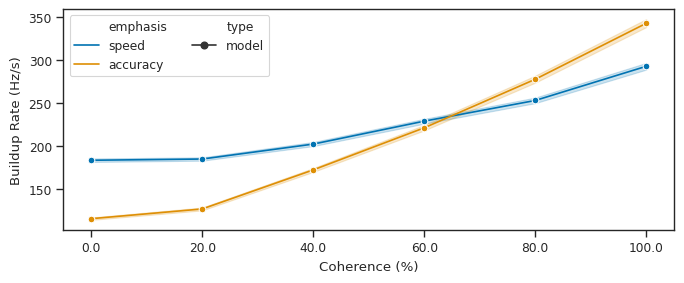

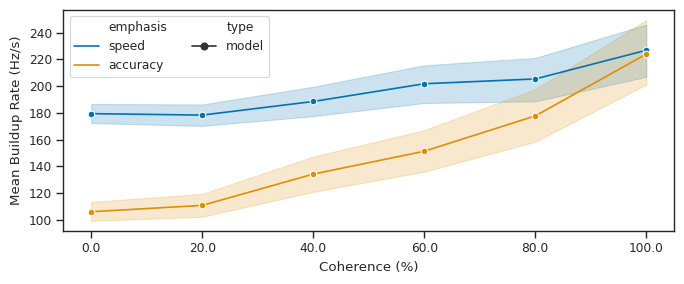

In [13]:
firing_rate(coherences=np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0]), trials=200, load=False, name='dec21shareRT',
            error=("ci", 95), estimator=np.mean, 
            ramp1=0.67, relative1=0.02, threshold1=0.13,
            ramp2=0.67, relative2=0.48, threshold2=0.13)

emphasis speed, coherence 0.0, trial 0, RT 0.425
emphasis speed, coherence 0.0, trial 1, RT 0.364
emphasis speed, coherence 0.0, trial 2, RT 0.40700000000000003
emphasis speed, coherence 0.0, trial 3, RT 0.299
emphasis speed, coherence 0.0, trial 4, RT 0.549
emphasis speed, coherence 0.0, trial 5, RT 0.499
emphasis speed, coherence 0.0, trial 6, RT 0.384
emphasis speed, coherence 0.0, trial 7, RT 0.363
emphasis speed, coherence 0.0, trial 8, RT 0.41200000000000003
emphasis speed, coherence 0.0, trial 9, RT 0.539
emphasis speed, coherence 0.2, trial 0, RT 0.46900000000000003
emphasis speed, coherence 0.2, trial 1, RT 0.354
emphasis speed, coherence 0.2, trial 2, RT 0.511
emphasis speed, coherence 0.2, trial 3, RT 0.52
emphasis speed, coherence 0.2, trial 4, RT 0.385
emphasis speed, coherence 0.2, trial 5, RT 0.434
emphasis speed, coherence 0.2, trial 6, RT 0.403
emphasis speed, coherence 0.2, trial 7, RT 0.422
emphasis speed, coherence 0.2, trial 8, RT 0.41200000000000003
emphasis speed

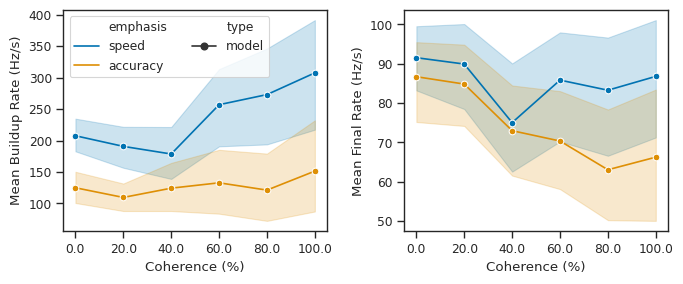

In [27]:
firing_rate(coherences=np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0]), trials=10, load=False, name='dec25',
            error=("ci", 95), estimator=np.mean, 
            ramp1=0.64, relative1=0.0, threshold1=0.12,
            ramp2=1.33, relative2=0.15, threshold2=0.34)

In [3]:
def rerun(
        coherences=np.array([0.032, 0.064, 0.128, 0.256, 0.512]),
        emphases=['speed', 'accuracy'],
        pid="E",
        ramp1=1.5,
        threshold1=0.3,
        relative1=0.5,
        ramp2=1,
        threshold2=0.3,
        relative2=0.5,
        sigma=0.5,
        nActions=2,
        nNeurons=500,
        max_rates=nengo.dists.Uniform(80, 100),
        rA=1.5,
        trials=3,
        perception_seed=0,
        network_seed=0,
        dt=0.001,
        dt_sample=0.03,
        load=False,
        error=('ci', 95),
        estimator=np.median,
        tmax=3,
        t0=0.1,
        t1=-0.1,
        bins=np.arange(0.0, 1.5, 0.1),
        name="hanks_activity_default"):
    
    columns = ('type', 'id', 'emphasis', 'coherence', 'trial', 'accuracy', "RT", 'mean buildup rate', 'mean final rate')
    dfs = []
    for e, emphasis in enumerate(emphases):
        ramp = [ramp1, ramp2][e]
        threshold = [threshold1, threshold2][e]
        relative = [relative1, relative2][e]
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        for coherence in coherences:
            inputs.create(coherence=coherence)
            for trial in range(trials):
                net = build_network(inputs, nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                                    max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative,
                                    probe_spikes=True)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > tmax:
                        choice = np.argmax(sim.data[net.pValue][-1,:])
                        RT = sim.trange()[-1]
                correct = True if choice==inputs.correct else False
                aligned_neuron_idx = np.argwhere(sim.data[net.value].encoders[:,inputs.correct] > 0.9).ravel()
                print(f"emphasis {emphasis}, coherence {coherence}, trial {trial}, RT {RT}, aligned neurons {len(aligned_neuron_idx)}")
                DT = RT - t1
                buildup_rates = []
                final_rates = []
                for neuron in aligned_neuron_idx:
                    A0 = sim.data[net.pSpikes][int(t0/dt),neuron]
                    A1 = sim.data[net.pSpikes][int(t1/dt),neuron]
                    DA =  A1 - A0 
                    if A1!=0 and A0!=0:
                        buildup_rate = DA/DT
                        dfs.append(pd.DataFrame([['model', 'S', emphasis, 100*coherence, trial, 100*correct, RT, buildup_rate, A1]], columns=columns))
#                 dfs.append(pd.DataFrame([['model', 'S', emphasis, 100*coherence, trial, 100*correct, RT, np.mean(buildup_rates), np.mean(final_rates)]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

In [48]:
def plot_behavior(name, pid="E", estimator=np.mean, bins=np.arange(0.0, 1.5, 0.1)):
    data = pd.read_pickle(f"data/{name}.pkl")
    cohs = data['coherence'].unique()
    hanks = pd.read_pickle("data/hanks2014_behavior.pkl").query("id==@pid")
    combined = pd.concat([hanks, data]).query("coherence>0")
    get_loss(data, hanks, cohs, ['speed', 'accuracy'], bins)

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=((7, 3)))
    sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='RT', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[0],
                 style='type', estimator=estimator)
    sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='accuracy', hue='emphasis',
                 style='type', palette=palette[:2], markers=True, ax=axes[1])
    axes[0].set(xscale='log', xlabel="Coherence (%)", ylabel="Response Time (s)")
    axes[0].legend(ncols=2, loc='upper right')
    axes[1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)", yticks=[50,60,70,80,90,100])
    axes[1].get_legend().remove()
    plt.tight_layout()
#     fig.savefig(f"plots/hanks_behavior.svg")
    fig.savefig(f"plots/hanks_behavior.png", dpi=600)
    
#     fig = sns.FacetGrid(combined, col='emphasis', row="coherence", hue='type', palette=palette[:2], height=1, aspect=3, sharex=True, legend_out=True)
#     fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins)
#     fig.set_xlabels("Response Time (s)")
#     fig.set(xticks=bins[::2])
#     fig.set(yticks=[0,25,50,75,100])
#     fig.add_legend()
#     fig.savefig(f"plots/hanks_RTs.svg")
#     fig.savefig(f"plots/hanks_RTs.png", dpi=600)

In [5]:
def plot_activity(name, estimator=np.mean, errorbar=('ci', 95)):
    data = pd.read_pickle(f"data/{name}.pkl")
    cohs = data['coherence'].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((7, 3)))
    sns.lineplot(data=data, x='coherence', y='mean buildup rate', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[0], style='type', errorbar=errorbar, estimator=estimator)
    sns.lineplot(data=data, x='coherence', y='mean final rate', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[1], style='type', errorbar=errorbar, estimator=estimator)
    axes[0].set(xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Mean Buildup Rate (Hz/s)")
    axes[1].set(xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Mean Final Rate (Hz/s)")
    axes[0].legend(ncols=2, loc='upper right')
    axes[1].get_legend().remove()
    plt.tight_layout()
#     fig.savefig(f"plots/hanks_activity.svg")
    fig.savefig(f"plots/hanks_activity.png", dpi=600)

### Separate

emphasis speed, coherence 0.032, trial 0, RT 0.396
emphasis speed, coherence 0.032, trial 1, RT 0.447
emphasis speed, coherence 0.032, trial 2, RT 0.453
emphasis speed, coherence 0.032, trial 3, RT 0.28400000000000003
emphasis speed, coherence 0.032, trial 4, RT 0.581
emphasis speed, coherence 0.032, trial 5, RT 0.604
emphasis speed, coherence 0.032, trial 6, RT 0.361
emphasis speed, coherence 0.032, trial 7, RT 0.486
emphasis speed, coherence 0.032, trial 8, RT 0.47500000000000003
emphasis speed, coherence 0.032, trial 9, RT 0.34700000000000003
emphasis speed, coherence 0.032, trial 10, RT 0.396
emphasis speed, coherence 0.032, trial 11, RT 0.42
emphasis speed, coherence 0.032, trial 12, RT 0.34800000000000003
emphasis speed, coherence 0.032, trial 13, RT 0.406
emphasis speed, coherence 0.032, trial 14, RT 0.47100000000000003
emphasis speed, coherence 0.032, trial 15, RT 0.452
emphasis speed, coherence 0.032, trial 16, RT 0.47600000000000003
emphasis speed, coherence 0.032, trial 17, 

emphasis speed, coherence 0.032, trial 150, RT 0.356
emphasis speed, coherence 0.032, trial 151, RT 0.394
emphasis speed, coherence 0.032, trial 152, RT 0.459
emphasis speed, coherence 0.032, trial 153, RT 0.453
emphasis speed, coherence 0.032, trial 154, RT 0.426
emphasis speed, coherence 0.032, trial 155, RT 0.39
emphasis speed, coherence 0.032, trial 156, RT 0.386
emphasis speed, coherence 0.032, trial 157, RT 0.547
emphasis speed, coherence 0.032, trial 158, RT 0.332
emphasis speed, coherence 0.032, trial 159, RT 0.358
emphasis speed, coherence 0.032, trial 160, RT 0.4
emphasis speed, coherence 0.032, trial 161, RT 0.41400000000000003
emphasis speed, coherence 0.032, trial 162, RT 0.523
emphasis speed, coherence 0.032, trial 163, RT 0.382
emphasis speed, coherence 0.032, trial 164, RT 0.492
emphasis speed, coherence 0.032, trial 165, RT 0.47900000000000004
emphasis speed, coherence 0.032, trial 166, RT 0.355
emphasis speed, coherence 0.032, trial 167, RT 0.5700000000000001
emphasis

emphasis speed, coherence 0.032, trial 300, RT 0.405
emphasis speed, coherence 0.032, trial 301, RT 0.41500000000000004
emphasis speed, coherence 0.032, trial 302, RT 0.384
emphasis speed, coherence 0.032, trial 303, RT 0.504
emphasis speed, coherence 0.032, trial 304, RT 0.361
emphasis speed, coherence 0.032, trial 305, RT 0.521
emphasis speed, coherence 0.032, trial 306, RT 0.5640000000000001
emphasis speed, coherence 0.032, trial 307, RT 0.359
emphasis speed, coherence 0.032, trial 308, RT 0.38
emphasis speed, coherence 0.032, trial 309, RT 0.456
emphasis speed, coherence 0.032, trial 310, RT 0.506
emphasis speed, coherence 0.032, trial 311, RT 0.513
emphasis speed, coherence 0.032, trial 312, RT 0.321
emphasis speed, coherence 0.032, trial 313, RT 0.443
emphasis speed, coherence 0.032, trial 314, RT 0.342
emphasis speed, coherence 0.032, trial 315, RT 0.401
emphasis speed, coherence 0.032, trial 316, RT 0.445
emphasis speed, coherence 0.032, trial 317, RT 0.393
emphasis speed, cohe

emphasis speed, coherence 0.064, trial 49, RT 0.41100000000000003
emphasis speed, coherence 0.064, trial 50, RT 0.579
emphasis speed, coherence 0.064, trial 51, RT 0.326
emphasis speed, coherence 0.064, trial 52, RT 0.421
emphasis speed, coherence 0.064, trial 53, RT 0.46
emphasis speed, coherence 0.064, trial 54, RT 0.298
emphasis speed, coherence 0.064, trial 55, RT 0.336
emphasis speed, coherence 0.064, trial 56, RT 0.47900000000000004
emphasis speed, coherence 0.064, trial 57, RT 0.396
emphasis speed, coherence 0.064, trial 58, RT 0.658
emphasis speed, coherence 0.064, trial 59, RT 0.41300000000000003
emphasis speed, coherence 0.064, trial 60, RT 0.34700000000000003
emphasis speed, coherence 0.064, trial 61, RT 0.336
emphasis speed, coherence 0.064, trial 62, RT 0.34800000000000003
emphasis speed, coherence 0.064, trial 63, RT 0.47900000000000004
emphasis speed, coherence 0.064, trial 64, RT 0.43
emphasis speed, coherence 0.064, trial 65, RT 0.47400000000000003
emphasis speed, cohe

emphasis speed, coherence 0.064, trial 198, RT 0.498
emphasis speed, coherence 0.064, trial 199, RT 0.40900000000000003
emphasis speed, coherence 0.064, trial 200, RT 0.462
emphasis speed, coherence 0.064, trial 201, RT 0.42
emphasis speed, coherence 0.064, trial 202, RT 0.46
emphasis speed, coherence 0.064, trial 203, RT 0.463
emphasis speed, coherence 0.064, trial 204, RT 0.443
emphasis speed, coherence 0.064, trial 205, RT 0.34600000000000003
emphasis speed, coherence 0.064, trial 206, RT 0.526
emphasis speed, coherence 0.064, trial 207, RT 0.462
emphasis speed, coherence 0.064, trial 208, RT 0.427
emphasis speed, coherence 0.064, trial 209, RT 0.58
emphasis speed, coherence 0.064, trial 210, RT 0.454
emphasis speed, coherence 0.064, trial 211, RT 0.434
emphasis speed, coherence 0.064, trial 212, RT 0.33
emphasis speed, coherence 0.064, trial 213, RT 0.397
emphasis speed, coherence 0.064, trial 214, RT 0.362
emphasis speed, coherence 0.064, trial 215, RT 0.456
emphasis speed, cohere

emphasis speed, coherence 0.064, trial 349, RT 0.463
emphasis speed, coherence 0.064, trial 350, RT 0.342
emphasis speed, coherence 0.064, trial 351, RT 0.371
emphasis speed, coherence 0.064, trial 352, RT 0.41000000000000003
emphasis speed, coherence 0.064, trial 353, RT 0.423
emphasis speed, coherence 0.064, trial 354, RT 0.489
emphasis speed, coherence 0.064, trial 355, RT 0.659
emphasis speed, coherence 0.064, trial 356, RT 0.483
emphasis speed, coherence 0.064, trial 357, RT 0.47300000000000003
emphasis speed, coherence 0.064, trial 358, RT 0.34500000000000003
emphasis speed, coherence 0.064, trial 359, RT 0.444
emphasis speed, coherence 0.064, trial 360, RT 0.53
emphasis speed, coherence 0.064, trial 361, RT 0.542
emphasis speed, coherence 0.064, trial 362, RT 0.515
emphasis speed, coherence 0.064, trial 363, RT 0.387
emphasis speed, coherence 0.064, trial 364, RT 0.42
emphasis speed, coherence 0.064, trial 365, RT 0.342
emphasis speed, coherence 0.064, trial 366, RT 0.4160000000

emphasis speed, coherence 0.128, trial 100, RT 0.403
emphasis speed, coherence 0.128, trial 101, RT 0.451
emphasis speed, coherence 0.128, trial 102, RT 0.512
emphasis speed, coherence 0.128, trial 103, RT 0.421
emphasis speed, coherence 0.128, trial 104, RT 0.34400000000000003
emphasis speed, coherence 0.128, trial 105, RT 0.445
emphasis speed, coherence 0.128, trial 106, RT 0.501
emphasis speed, coherence 0.128, trial 107, RT 0.487
emphasis speed, coherence 0.128, trial 108, RT 0.431
emphasis speed, coherence 0.128, trial 109, RT 0.501
emphasis speed, coherence 0.128, trial 110, RT 0.28200000000000003
emphasis speed, coherence 0.128, trial 111, RT 0.47900000000000004
emphasis speed, coherence 0.128, trial 112, RT 0.431
emphasis speed, coherence 0.128, trial 113, RT 0.497
emphasis speed, coherence 0.128, trial 114, RT 0.482
emphasis speed, coherence 0.128, trial 115, RT 0.304
emphasis speed, coherence 0.128, trial 116, RT 0.494
emphasis speed, coherence 0.128, trial 117, RT 0.442
emph

emphasis speed, coherence 0.128, trial 250, RT 0.551
emphasis speed, coherence 0.128, trial 251, RT 0.393
emphasis speed, coherence 0.128, trial 252, RT 0.463
emphasis speed, coherence 0.128, trial 253, RT 0.496
emphasis speed, coherence 0.128, trial 254, RT 0.47500000000000003
emphasis speed, coherence 0.128, trial 255, RT 0.43
emphasis speed, coherence 0.128, trial 256, RT 0.402
emphasis speed, coherence 0.128, trial 257, RT 0.392
emphasis speed, coherence 0.128, trial 258, RT 0.46
emphasis speed, coherence 0.128, trial 259, RT 0.636
emphasis speed, coherence 0.128, trial 260, RT 0.377
emphasis speed, coherence 0.128, trial 261, RT 0.41600000000000004
emphasis speed, coherence 0.128, trial 262, RT 0.41600000000000004
emphasis speed, coherence 0.128, trial 263, RT 0.378
emphasis speed, coherence 0.128, trial 264, RT 0.5
emphasis speed, coherence 0.128, trial 265, RT 0.601
emphasis speed, coherence 0.128, trial 266, RT 0.369
emphasis speed, coherence 0.128, trial 267, RT 0.382
emphasis

emphasis speed, coherence 0.128, trial 399, RT 0.455
emphasis speed, coherence 0.256, trial 0, RT 0.394
emphasis speed, coherence 0.256, trial 1, RT 0.497
emphasis speed, coherence 0.256, trial 2, RT 0.392
emphasis speed, coherence 0.256, trial 3, RT 0.315
emphasis speed, coherence 0.256, trial 4, RT 0.448
emphasis speed, coherence 0.256, trial 5, RT 0.321
emphasis speed, coherence 0.256, trial 6, RT 0.419
emphasis speed, coherence 0.256, trial 7, RT 0.299
emphasis speed, coherence 0.256, trial 8, RT 0.307
emphasis speed, coherence 0.256, trial 9, RT 0.342
emphasis speed, coherence 0.256, trial 10, RT 0.548
emphasis speed, coherence 0.256, trial 11, RT 0.388
emphasis speed, coherence 0.256, trial 12, RT 0.308
emphasis speed, coherence 0.256, trial 13, RT 0.417
emphasis speed, coherence 0.256, trial 14, RT 0.434
emphasis speed, coherence 0.256, trial 15, RT 0.441
emphasis speed, coherence 0.256, trial 16, RT 0.495
emphasis speed, coherence 0.256, trial 17, RT 0.46
emphasis speed, cohere

emphasis speed, coherence 0.256, trial 152, RT 0.41400000000000003
emphasis speed, coherence 0.256, trial 153, RT 0.54
emphasis speed, coherence 0.256, trial 154, RT 0.553
emphasis speed, coherence 0.256, trial 155, RT 0.447
emphasis speed, coherence 0.256, trial 156, RT 0.458
emphasis speed, coherence 0.256, trial 157, RT 0.41200000000000003
emphasis speed, coherence 0.256, trial 158, RT 0.446
emphasis speed, coherence 0.256, trial 159, RT 0.354
emphasis speed, coherence 0.256, trial 160, RT 0.405
emphasis speed, coherence 0.256, trial 161, RT 0.34400000000000003
emphasis speed, coherence 0.256, trial 162, RT 0.358
emphasis speed, coherence 0.256, trial 163, RT 0.322
emphasis speed, coherence 0.256, trial 164, RT 0.418
emphasis speed, coherence 0.256, trial 165, RT 0.367
emphasis speed, coherence 0.256, trial 166, RT 0.392
emphasis speed, coherence 0.256, trial 167, RT 0.40700000000000003
emphasis speed, coherence 0.256, trial 168, RT 0.337
emphasis speed, coherence 0.256, trial 169, 

emphasis speed, coherence 0.256, trial 302, RT 0.404
emphasis speed, coherence 0.256, trial 303, RT 0.439
emphasis speed, coherence 0.256, trial 304, RT 0.302
emphasis speed, coherence 0.256, trial 305, RT 0.545
emphasis speed, coherence 0.256, trial 306, RT 0.492
emphasis speed, coherence 0.256, trial 307, RT 0.448
emphasis speed, coherence 0.256, trial 308, RT 0.406
emphasis speed, coherence 0.256, trial 309, RT 0.462
emphasis speed, coherence 0.256, trial 310, RT 0.386
emphasis speed, coherence 0.256, trial 311, RT 0.34800000000000003
emphasis speed, coherence 0.256, trial 312, RT 0.465
emphasis speed, coherence 0.256, trial 313, RT 0.358
emphasis speed, coherence 0.256, trial 314, RT 0.525
emphasis speed, coherence 0.256, trial 315, RT 0.498
emphasis speed, coherence 0.256, trial 316, RT 0.419
emphasis speed, coherence 0.256, trial 317, RT 0.366
emphasis speed, coherence 0.256, trial 318, RT 0.666
emphasis speed, coherence 0.256, trial 319, RT 0.462
emphasis speed, coherence 0.256,

emphasis speed, coherence 0.512, trial 55, RT 0.301
emphasis speed, coherence 0.512, trial 56, RT 0.28600000000000003
emphasis speed, coherence 0.512, trial 57, RT 0.367
emphasis speed, coherence 0.512, trial 58, RT 0.302
emphasis speed, coherence 0.512, trial 59, RT 0.332
emphasis speed, coherence 0.512, trial 60, RT 0.35000000000000003
emphasis speed, coherence 0.512, trial 61, RT 0.372
emphasis speed, coherence 0.512, trial 62, RT 0.318
emphasis speed, coherence 0.512, trial 63, RT 0.35000000000000003
emphasis speed, coherence 0.512, trial 64, RT 0.326
emphasis speed, coherence 0.512, trial 65, RT 0.396
emphasis speed, coherence 0.512, trial 66, RT 0.291
emphasis speed, coherence 0.512, trial 67, RT 0.312
emphasis speed, coherence 0.512, trial 68, RT 0.39
emphasis speed, coherence 0.512, trial 69, RT 0.339
emphasis speed, coherence 0.512, trial 70, RT 0.301
emphasis speed, coherence 0.512, trial 71, RT 0.299
emphasis speed, coherence 0.512, trial 72, RT 0.438
emphasis speed, coheren

emphasis speed, coherence 0.512, trial 206, RT 0.462
emphasis speed, coherence 0.512, trial 207, RT 0.299
emphasis speed, coherence 0.512, trial 208, RT 0.404
emphasis speed, coherence 0.512, trial 209, RT 0.35000000000000003
emphasis speed, coherence 0.512, trial 210, RT 0.334
emphasis speed, coherence 0.512, trial 211, RT 0.321
emphasis speed, coherence 0.512, trial 212, RT 0.357
emphasis speed, coherence 0.512, trial 213, RT 0.539
emphasis speed, coherence 0.512, trial 214, RT 0.429
emphasis speed, coherence 0.512, trial 215, RT 0.41200000000000003
emphasis speed, coherence 0.512, trial 216, RT 0.316
emphasis speed, coherence 0.512, trial 217, RT 0.304
emphasis speed, coherence 0.512, trial 218, RT 0.306
emphasis speed, coherence 0.512, trial 219, RT 0.381
emphasis speed, coherence 0.512, trial 220, RT 0.373
emphasis speed, coherence 0.512, trial 221, RT 0.374
emphasis speed, coherence 0.512, trial 222, RT 0.40700000000000003
emphasis speed, coherence 0.512, trial 223, RT 0.384
emph

emphasis speed, coherence 0.512, trial 354, RT 0.34600000000000003
emphasis speed, coherence 0.512, trial 355, RT 0.438
emphasis speed, coherence 0.512, trial 356, RT 0.34800000000000003
emphasis speed, coherence 0.512, trial 357, RT 0.317
emphasis speed, coherence 0.512, trial 358, RT 0.372
emphasis speed, coherence 0.512, trial 359, RT 0.337
emphasis speed, coherence 0.512, trial 360, RT 0.357
emphasis speed, coherence 0.512, trial 361, RT 0.338
emphasis speed, coherence 0.512, trial 362, RT 0.266
emphasis speed, coherence 0.512, trial 363, RT 0.357
emphasis speed, coherence 0.512, trial 364, RT 0.361
emphasis speed, coherence 0.512, trial 365, RT 0.35000000000000003
emphasis speed, coherence 0.512, trial 366, RT 0.34500000000000003
emphasis speed, coherence 0.512, trial 367, RT 0.45
emphasis speed, coherence 0.512, trial 368, RT 0.396
emphasis speed, coherence 0.512, trial 369, RT 0.328
emphasis speed, coherence 0.512, trial 370, RT 0.327
emphasis speed, coherence 0.512, trial 371, 

emphasis accuracy, coherence 0.032, trial 102, RT 0.5650000000000001
emphasis accuracy, coherence 0.032, trial 103, RT 0.72
emphasis accuracy, coherence 0.032, trial 104, RT 0.453
emphasis accuracy, coherence 0.032, trial 105, RT 0.747
emphasis accuracy, coherence 0.032, trial 106, RT 0.794
emphasis accuracy, coherence 0.032, trial 107, RT 0.667
emphasis accuracy, coherence 0.032, trial 108, RT 0.537
emphasis accuracy, coherence 0.032, trial 109, RT 0.713
emphasis accuracy, coherence 0.032, trial 110, RT 0.607
emphasis accuracy, coherence 0.032, trial 111, RT 0.753
emphasis accuracy, coherence 0.032, trial 112, RT 0.714
emphasis accuracy, coherence 0.032, trial 113, RT 0.604
emphasis accuracy, coherence 0.032, trial 114, RT 0.556
emphasis accuracy, coherence 0.032, trial 115, RT 0.616
emphasis accuracy, coherence 0.032, trial 116, RT 0.5710000000000001
emphasis accuracy, coherence 0.032, trial 117, RT 0.514
emphasis accuracy, coherence 0.032, trial 118, RT 0.616
emphasis accuracy, cohe

emphasis accuracy, coherence 0.032, trial 243, RT 0.656
emphasis accuracy, coherence 0.032, trial 244, RT 0.65
emphasis accuracy, coherence 0.032, trial 245, RT 0.404
emphasis accuracy, coherence 0.032, trial 246, RT 0.54
emphasis accuracy, coherence 0.032, trial 247, RT 0.642
emphasis accuracy, coherence 0.032, trial 248, RT 0.5710000000000001
emphasis accuracy, coherence 0.032, trial 249, RT 0.894
emphasis accuracy, coherence 0.032, trial 250, RT 0.617
emphasis accuracy, coherence 0.032, trial 251, RT 0.47600000000000003
emphasis accuracy, coherence 0.032, trial 252, RT 0.872
emphasis accuracy, coherence 0.032, trial 253, RT 0.509
emphasis accuracy, coherence 0.032, trial 254, RT 0.561
emphasis accuracy, coherence 0.032, trial 255, RT 0.716
emphasis accuracy, coherence 0.032, trial 256, RT 0.59
emphasis accuracy, coherence 0.032, trial 257, RT 0.8
emphasis accuracy, coherence 0.032, trial 258, RT 0.678
emphasis accuracy, coherence 0.032, trial 259, RT 0.877
emphasis accuracy, coheren

emphasis accuracy, coherence 0.032, trial 386, RT 0.6900000000000001
emphasis accuracy, coherence 0.032, trial 387, RT 0.766
emphasis accuracy, coherence 0.032, trial 388, RT 0.609
emphasis accuracy, coherence 0.032, trial 389, RT 0.724
emphasis accuracy, coherence 0.032, trial 390, RT 0.489
emphasis accuracy, coherence 0.032, trial 391, RT 0.643
emphasis accuracy, coherence 0.032, trial 392, RT 0.687
emphasis accuracy, coherence 0.032, trial 393, RT 0.504
emphasis accuracy, coherence 0.032, trial 394, RT 0.711
emphasis accuracy, coherence 0.032, trial 395, RT 0.93
emphasis accuracy, coherence 0.032, trial 396, RT 0.611
emphasis accuracy, coherence 0.032, trial 397, RT 0.805
emphasis accuracy, coherence 0.032, trial 398, RT 0.8320000000000001
emphasis accuracy, coherence 0.032, trial 399, RT 0.452
emphasis accuracy, coherence 0.064, trial 0, RT 0.644
emphasis accuracy, coherence 0.064, trial 1, RT 0.679
emphasis accuracy, coherence 0.064, trial 2, RT 0.562
emphasis accuracy, coherence 

emphasis accuracy, coherence 0.064, trial 130, RT 0.669
emphasis accuracy, coherence 0.064, trial 131, RT 0.972
emphasis accuracy, coherence 0.064, trial 132, RT 0.72
emphasis accuracy, coherence 0.064, trial 133, RT 0.771
emphasis accuracy, coherence 0.064, trial 134, RT 0.607
emphasis accuracy, coherence 0.064, trial 135, RT 0.754
emphasis accuracy, coherence 0.064, trial 136, RT 0.623
emphasis accuracy, coherence 0.064, trial 137, RT 0.67
emphasis accuracy, coherence 0.064, trial 138, RT 0.6900000000000001
emphasis accuracy, coherence 0.064, trial 139, RT 0.716
emphasis accuracy, coherence 0.064, trial 140, RT 0.602
emphasis accuracy, coherence 0.064, trial 141, RT 0.595
emphasis accuracy, coherence 0.064, trial 142, RT 0.486
emphasis accuracy, coherence 0.064, trial 143, RT 0.527
emphasis accuracy, coherence 0.064, trial 144, RT 0.598
emphasis accuracy, coherence 0.064, trial 145, RT 0.633
emphasis accuracy, coherence 0.064, trial 146, RT 0.808
emphasis accuracy, coherence 0.064, t

emphasis accuracy, coherence 0.064, trial 273, RT 0.628
emphasis accuracy, coherence 0.064, trial 274, RT 0.543
emphasis accuracy, coherence 0.064, trial 275, RT 0.47300000000000003
emphasis accuracy, coherence 0.064, trial 276, RT 0.543
emphasis accuracy, coherence 0.064, trial 277, RT 0.549
emphasis accuracy, coherence 0.064, trial 278, RT 0.778
emphasis accuracy, coherence 0.064, trial 279, RT 0.546
emphasis accuracy, coherence 0.064, trial 280, RT 0.665
emphasis accuracy, coherence 0.064, trial 281, RT 0.715
emphasis accuracy, coherence 0.064, trial 282, RT 0.47700000000000004
emphasis accuracy, coherence 0.064, trial 283, RT 0.556
emphasis accuracy, coherence 0.064, trial 284, RT 0.587
emphasis accuracy, coherence 0.064, trial 285, RT 0.728
emphasis accuracy, coherence 0.064, trial 286, RT 0.641
emphasis accuracy, coherence 0.064, trial 287, RT 0.592
emphasis accuracy, coherence 0.064, trial 288, RT 0.6890000000000001
emphasis accuracy, coherence 0.064, trial 289, RT 0.83100000000

emphasis accuracy, coherence 0.128, trial 15, RT 0.613
emphasis accuracy, coherence 0.128, trial 16, RT 0.552
emphasis accuracy, coherence 0.128, trial 17, RT 0.854
emphasis accuracy, coherence 0.128, trial 18, RT 0.809
emphasis accuracy, coherence 0.128, trial 19, RT 0.562
emphasis accuracy, coherence 0.128, trial 20, RT 0.491
emphasis accuracy, coherence 0.128, trial 21, RT 0.871
emphasis accuracy, coherence 0.128, trial 22, RT 0.724
emphasis accuracy, coherence 0.128, trial 23, RT 0.609
emphasis accuracy, coherence 0.128, trial 24, RT 0.848
emphasis accuracy, coherence 0.128, trial 25, RT 0.511
emphasis accuracy, coherence 0.128, trial 26, RT 0.466
emphasis accuracy, coherence 0.128, trial 27, RT 0.861
emphasis accuracy, coherence 0.128, trial 28, RT 0.893
emphasis accuracy, coherence 0.128, trial 29, RT 0.636
emphasis accuracy, coherence 0.128, trial 30, RT 0.542
emphasis accuracy, coherence 0.128, trial 31, RT 0.665
emphasis accuracy, coherence 0.128, trial 32, RT 0.544
emphasis a

emphasis accuracy, coherence 0.128, trial 160, RT 0.711
emphasis accuracy, coherence 0.128, trial 161, RT 0.722
emphasis accuracy, coherence 0.128, trial 162, RT 0.601
emphasis accuracy, coherence 0.128, trial 163, RT 0.55
emphasis accuracy, coherence 0.128, trial 164, RT 0.8150000000000001
emphasis accuracy, coherence 0.128, trial 165, RT 0.62
emphasis accuracy, coherence 0.128, trial 166, RT 0.5640000000000001
emphasis accuracy, coherence 0.128, trial 167, RT 0.643
emphasis accuracy, coherence 0.128, trial 168, RT 0.447
emphasis accuracy, coherence 0.128, trial 169, RT 0.632
emphasis accuracy, coherence 0.128, trial 170, RT 0.531
emphasis accuracy, coherence 0.128, trial 171, RT 0.592
emphasis accuracy, coherence 0.128, trial 172, RT 0.673
emphasis accuracy, coherence 0.128, trial 173, RT 0.715
emphasis accuracy, coherence 0.128, trial 174, RT 0.65
emphasis accuracy, coherence 0.128, trial 175, RT 0.5
emphasis accuracy, coherence 0.128, trial 176, RT 0.6970000000000001
emphasis accur

emphasis accuracy, coherence 0.128, trial 303, RT 0.668
emphasis accuracy, coherence 0.128, trial 304, RT 0.522
emphasis accuracy, coherence 0.128, trial 305, RT 0.769
emphasis accuracy, coherence 0.128, trial 306, RT 0.5710000000000001
emphasis accuracy, coherence 0.128, trial 307, RT 0.711
emphasis accuracy, coherence 0.128, trial 308, RT 0.547
emphasis accuracy, coherence 0.128, trial 309, RT 0.468
emphasis accuracy, coherence 0.128, trial 310, RT 0.527
emphasis accuracy, coherence 0.128, trial 311, RT 0.6930000000000001
emphasis accuracy, coherence 0.128, trial 312, RT 0.679
emphasis accuracy, coherence 0.128, trial 313, RT 0.486
emphasis accuracy, coherence 0.128, trial 314, RT 0.798
emphasis accuracy, coherence 0.128, trial 315, RT 0.555
emphasis accuracy, coherence 0.128, trial 316, RT 0.428
emphasis accuracy, coherence 0.128, trial 317, RT 0.85
emphasis accuracy, coherence 0.128, trial 318, RT 0.5650000000000001
emphasis accuracy, coherence 0.128, trial 319, RT 0.728
emphasis a

emphasis accuracy, coherence 0.256, trial 48, RT 0.534
emphasis accuracy, coherence 0.256, trial 49, RT 0.544
emphasis accuracy, coherence 0.256, trial 50, RT 0.41200000000000003
emphasis accuracy, coherence 0.256, trial 51, RT 0.528
emphasis accuracy, coherence 0.256, trial 52, RT 0.5670000000000001
emphasis accuracy, coherence 0.256, trial 53, RT 0.638
emphasis accuracy, coherence 0.256, trial 54, RT 0.65
emphasis accuracy, coherence 0.256, trial 55, RT 0.45
emphasis accuracy, coherence 0.256, trial 56, RT 0.621
emphasis accuracy, coherence 0.256, trial 57, RT 0.47800000000000004
emphasis accuracy, coherence 0.256, trial 58, RT 0.492
emphasis accuracy, coherence 0.256, trial 59, RT 0.521
emphasis accuracy, coherence 0.256, trial 60, RT 0.549
emphasis accuracy, coherence 0.256, trial 61, RT 0.383
emphasis accuracy, coherence 0.256, trial 62, RT 0.716
emphasis accuracy, coherence 0.256, trial 63, RT 0.389
emphasis accuracy, coherence 0.256, trial 64, RT 0.642
emphasis accuracy, coheren

emphasis accuracy, coherence 0.256, trial 189, RT 0.641
emphasis accuracy, coherence 0.256, trial 190, RT 0.644
emphasis accuracy, coherence 0.256, trial 191, RT 0.896
emphasis accuracy, coherence 0.256, trial 192, RT 0.489
emphasis accuracy, coherence 0.256, trial 193, RT 0.456
emphasis accuracy, coherence 0.256, trial 194, RT 0.609
emphasis accuracy, coherence 0.256, trial 195, RT 0.486
emphasis accuracy, coherence 0.256, trial 196, RT 0.643
emphasis accuracy, coherence 0.256, trial 197, RT 0.679
emphasis accuracy, coherence 0.256, trial 198, RT 0.586
emphasis accuracy, coherence 0.256, trial 199, RT 0.672
emphasis accuracy, coherence 0.256, trial 200, RT 0.437
emphasis accuracy, coherence 0.256, trial 201, RT 0.40800000000000003
emphasis accuracy, coherence 0.256, trial 202, RT 0.417
emphasis accuracy, coherence 0.256, trial 203, RT 0.557
emphasis accuracy, coherence 0.256, trial 204, RT 0.445
emphasis accuracy, coherence 0.256, trial 205, RT 0.726
emphasis accuracy, coherence 0.256

emphasis accuracy, coherence 0.256, trial 333, RT 0.47900000000000004
emphasis accuracy, coherence 0.256, trial 334, RT 0.8280000000000001
emphasis accuracy, coherence 0.256, trial 335, RT 0.682
emphasis accuracy, coherence 0.256, trial 336, RT 0.663
emphasis accuracy, coherence 0.256, trial 337, RT 0.546
emphasis accuracy, coherence 0.256, trial 338, RT 0.723
emphasis accuracy, coherence 0.256, trial 339, RT 0.709
emphasis accuracy, coherence 0.256, trial 340, RT 0.734
emphasis accuracy, coherence 0.256, trial 341, RT 0.535
emphasis accuracy, coherence 0.256, trial 342, RT 0.538
emphasis accuracy, coherence 0.256, trial 343, RT 0.46900000000000003
emphasis accuracy, coherence 0.256, trial 344, RT 0.661
emphasis accuracy, coherence 0.256, trial 345, RT 0.577
emphasis accuracy, coherence 0.256, trial 346, RT 0.509
emphasis accuracy, coherence 0.256, trial 347, RT 0.483
emphasis accuracy, coherence 0.256, trial 348, RT 0.47300000000000003
emphasis accuracy, coherence 0.256, trial 349, RT

emphasis accuracy, coherence 0.512, trial 76, RT 0.536
emphasis accuracy, coherence 0.512, trial 77, RT 0.378
emphasis accuracy, coherence 0.512, trial 78, RT 0.556
emphasis accuracy, coherence 0.512, trial 79, RT 0.5680000000000001
emphasis accuracy, coherence 0.512, trial 80, RT 0.591
emphasis accuracy, coherence 0.512, trial 81, RT 0.601
emphasis accuracy, coherence 0.512, trial 82, RT 0.507
emphasis accuracy, coherence 0.512, trial 83, RT 0.594
emphasis accuracy, coherence 0.512, trial 84, RT 0.517
emphasis accuracy, coherence 0.512, trial 85, RT 0.452
emphasis accuracy, coherence 0.512, trial 86, RT 0.38
emphasis accuracy, coherence 0.512, trial 87, RT 0.375
emphasis accuracy, coherence 0.512, trial 88, RT 0.435
emphasis accuracy, coherence 0.512, trial 89, RT 0.46
emphasis accuracy, coherence 0.512, trial 90, RT 0.511
emphasis accuracy, coherence 0.512, trial 91, RT 0.507
emphasis accuracy, coherence 0.512, trial 92, RT 0.551
emphasis accuracy, coherence 0.512, trial 93, RT 0.515

emphasis accuracy, coherence 0.512, trial 219, RT 0.459
emphasis accuracy, coherence 0.512, trial 220, RT 0.47900000000000004
emphasis accuracy, coherence 0.512, trial 221, RT 0.35000000000000003
emphasis accuracy, coherence 0.512, trial 222, RT 0.397
emphasis accuracy, coherence 0.512, trial 223, RT 0.436
emphasis accuracy, coherence 0.512, trial 224, RT 0.47100000000000003
emphasis accuracy, coherence 0.512, trial 225, RT 0.527
emphasis accuracy, coherence 0.512, trial 226, RT 0.44
emphasis accuracy, coherence 0.512, trial 227, RT 0.40700000000000003
emphasis accuracy, coherence 0.512, trial 228, RT 0.496
emphasis accuracy, coherence 0.512, trial 229, RT 0.487
emphasis accuracy, coherence 0.512, trial 230, RT 0.449
emphasis accuracy, coherence 0.512, trial 231, RT 0.529
emphasis accuracy, coherence 0.512, trial 232, RT 0.466
emphasis accuracy, coherence 0.512, trial 233, RT 0.47800000000000004
emphasis accuracy, coherence 0.512, trial 234, RT 0.461
emphasis accuracy, coherence 0.512,

emphasis accuracy, coherence 0.512, trial 361, RT 0.376
emphasis accuracy, coherence 0.512, trial 362, RT 0.514
emphasis accuracy, coherence 0.512, trial 363, RT 0.362
emphasis accuracy, coherence 0.512, trial 364, RT 0.59
emphasis accuracy, coherence 0.512, trial 365, RT 0.532
emphasis accuracy, coherence 0.512, trial 366, RT 0.382
emphasis accuracy, coherence 0.512, trial 367, RT 0.362
emphasis accuracy, coherence 0.512, trial 368, RT 0.355
emphasis accuracy, coherence 0.512, trial 369, RT 0.538
emphasis accuracy, coherence 0.512, trial 370, RT 0.581
emphasis accuracy, coherence 0.512, trial 371, RT 0.44
emphasis accuracy, coherence 0.512, trial 372, RT 0.625
emphasis accuracy, coherence 0.512, trial 373, RT 0.531
emphasis accuracy, coherence 0.512, trial 374, RT 0.40900000000000003
emphasis accuracy, coherence 0.512, trial 375, RT 0.443
emphasis accuracy, coherence 0.512, trial 376, RT 0.449
emphasis accuracy, coherence 0.512, trial 377, RT 0.442
emphasis accuracy, coherence 0.512, 

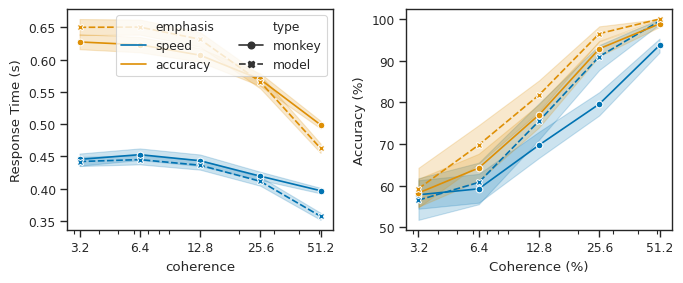

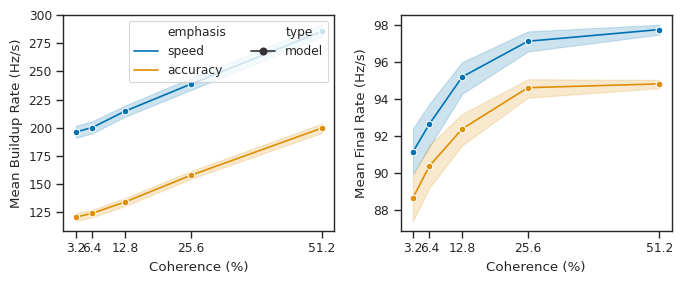

In [6]:
rerun(trials=400, name='dec27',
        ramp1=1.79, relative1=0.02, threshold1=0.33,
        ramp2=1.81, relative2=0.24, threshold2=0.44)
plot_behavior("dec27")
plot_activity("dec27")

emphasis speed, coherence 0.032, trial 0, RT 0.391
emphasis speed, coherence 0.032, trial 1, RT 0.521
emphasis speed, coherence 0.032, trial 2, RT 0.44
emphasis speed, coherence 0.032, trial 3, RT 0.379
emphasis speed, coherence 0.032, trial 4, RT 0.526
emphasis speed, coherence 0.032, trial 5, RT 0.402
emphasis speed, coherence 0.032, trial 6, RT 0.341
emphasis speed, coherence 0.032, trial 7, RT 0.41200000000000003
emphasis speed, coherence 0.032, trial 8, RT 0.481
emphasis speed, coherence 0.032, trial 9, RT 0.461
emphasis speed, coherence 0.032, trial 10, RT 0.436
emphasis speed, coherence 0.032, trial 11, RT 0.40900000000000003
emphasis speed, coherence 0.032, trial 12, RT 0.371
emphasis speed, coherence 0.032, trial 13, RT 0.34900000000000003
emphasis speed, coherence 0.032, trial 14, RT 0.422
emphasis speed, coherence 0.032, trial 15, RT 0.375
emphasis speed, coherence 0.032, trial 16, RT 0.487
emphasis speed, coherence 0.032, trial 17, RT 0.41400000000000003
emphasis speed, coh

emphasis speed, coherence 0.256, trial 33, RT 0.343
emphasis speed, coherence 0.256, trial 34, RT 0.289
emphasis speed, coherence 0.256, trial 35, RT 0.43
emphasis speed, coherence 0.256, trial 36, RT 0.516
emphasis speed, coherence 0.256, trial 37, RT 0.396
emphasis speed, coherence 0.256, trial 38, RT 0.386
emphasis speed, coherence 0.256, trial 39, RT 0.378
emphasis speed, coherence 0.512, trial 0, RT 0.34500000000000003
emphasis speed, coherence 0.512, trial 1, RT 0.304
emphasis speed, coherence 0.512, trial 2, RT 0.438
emphasis speed, coherence 0.512, trial 3, RT 0.494
emphasis speed, coherence 0.512, trial 4, RT 0.281
emphasis speed, coherence 0.512, trial 5, RT 0.28500000000000003
emphasis speed, coherence 0.512, trial 6, RT 0.406
emphasis speed, coherence 0.512, trial 7, RT 0.319
emphasis speed, coherence 0.512, trial 8, RT 0.243
emphasis speed, coherence 0.512, trial 9, RT 0.437
emphasis speed, coherence 0.512, trial 10, RT 0.339
emphasis speed, coherence 0.512, trial 11, RT 0

emphasis accuracy, coherence 0.128, trial 22, RT 0.627
emphasis accuracy, coherence 0.128, trial 23, RT 0.714
emphasis accuracy, coherence 0.128, trial 24, RT 0.592
emphasis accuracy, coherence 0.128, trial 25, RT 0.719
emphasis accuracy, coherence 0.128, trial 26, RT 0.404
emphasis accuracy, coherence 0.128, trial 27, RT 0.6990000000000001
emphasis accuracy, coherence 0.128, trial 28, RT 0.675
emphasis accuracy, coherence 0.128, trial 29, RT 0.394
emphasis accuracy, coherence 0.128, trial 30, RT 0.589
emphasis accuracy, coherence 0.128, trial 31, RT 0.627
emphasis accuracy, coherence 0.128, trial 32, RT 0.455
emphasis accuracy, coherence 0.128, trial 33, RT 0.8160000000000001
emphasis accuracy, coherence 0.128, trial 34, RT 0.561
emphasis accuracy, coherence 0.128, trial 35, RT 0.631
emphasis accuracy, coherence 0.128, trial 36, RT 0.923
emphasis accuracy, coherence 0.128, trial 37, RT 0.513
emphasis accuracy, coherence 0.128, trial 38, RT 0.617
emphasis accuracy, coherence 0.128, tri

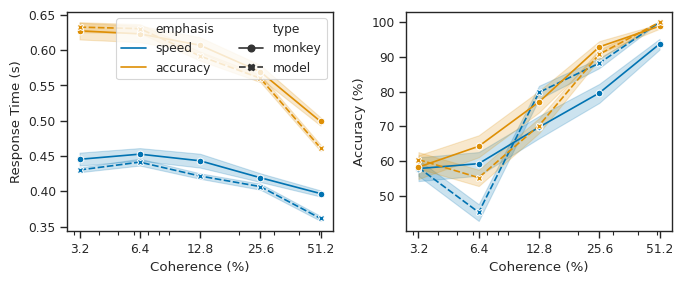

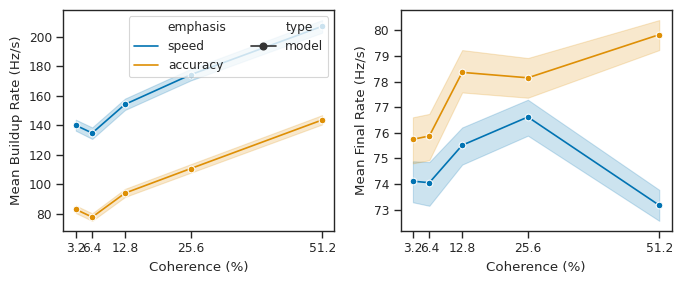

In [6]:
rerun(trials=40, name='dec27sigma06', sigma=0.6,
        ramp1=1.79, relative1=0.02, threshold1=0.33,
        ramp2=1.81, relative2=0.24, threshold2=0.44)
plot_behavior("dec27sigma06")
plot_activity("dec27sigma06")

emphasis speed, coherence 0.032, trial 0, RT 0.391
emphasis speed, coherence 0.032, trial 1, RT 0.521
emphasis speed, coherence 0.032, trial 2, RT 0.44
emphasis speed, coherence 0.032, trial 3, RT 0.379
emphasis speed, coherence 0.032, trial 4, RT 0.526
emphasis speed, coherence 0.032, trial 5, RT 0.402
emphasis speed, coherence 0.032, trial 6, RT 0.341
emphasis speed, coherence 0.032, trial 7, RT 0.41200000000000003
emphasis speed, coherence 0.032, trial 8, RT 0.481
emphasis speed, coherence 0.032, trial 9, RT 0.461
emphasis speed, coherence 0.032, trial 10, RT 0.436
emphasis speed, coherence 0.032, trial 11, RT 0.40900000000000003
emphasis speed, coherence 0.032, trial 12, RT 0.371
emphasis speed, coherence 0.032, trial 13, RT 0.34900000000000003
emphasis speed, coherence 0.032, trial 14, RT 0.422
emphasis speed, coherence 0.032, trial 15, RT 0.375
emphasis speed, coherence 0.032, trial 16, RT 0.487
emphasis speed, coherence 0.032, trial 17, RT 0.41400000000000003
emphasis speed, coh

emphasis speed, coherence 0.032, trial 152, RT 0.596
emphasis speed, coherence 0.032, trial 153, RT 0.425
emphasis speed, coherence 0.032, trial 154, RT 0.396
emphasis speed, coherence 0.032, trial 155, RT 0.439
emphasis speed, coherence 0.032, trial 156, RT 0.447
emphasis speed, coherence 0.032, trial 157, RT 0.34600000000000003
emphasis speed, coherence 0.032, trial 158, RT 0.276
emphasis speed, coherence 0.032, trial 159, RT 0.359
emphasis speed, coherence 0.032, trial 160, RT 0.338
emphasis speed, coherence 0.032, trial 161, RT 0.588
emphasis speed, coherence 0.032, trial 162, RT 0.41200000000000003
emphasis speed, coherence 0.032, trial 163, RT 0.445
emphasis speed, coherence 0.032, trial 164, RT 0.4
emphasis speed, coherence 0.032, trial 165, RT 0.529
emphasis speed, coherence 0.032, trial 166, RT 0.458
emphasis speed, coherence 0.032, trial 167, RT 0.314
emphasis speed, coherence 0.032, trial 168, RT 0.443
emphasis speed, coherence 0.032, trial 169, RT 0.676
emphasis speed, cohe

emphasis speed, coherence 0.032, trial 300, RT 0.397
emphasis speed, coherence 0.032, trial 301, RT 0.392
emphasis speed, coherence 0.032, trial 302, RT 0.369
emphasis speed, coherence 0.032, trial 303, RT 0.439
emphasis speed, coherence 0.032, trial 304, RT 0.382
emphasis speed, coherence 0.032, trial 305, RT 0.373
emphasis speed, coherence 0.032, trial 306, RT 0.715
emphasis speed, coherence 0.032, trial 307, RT 0.357
emphasis speed, coherence 0.032, trial 308, RT 0.41300000000000003
emphasis speed, coherence 0.032, trial 309, RT 0.363
emphasis speed, coherence 0.032, trial 310, RT 0.386
emphasis speed, coherence 0.032, trial 311, RT 0.525
emphasis speed, coherence 0.032, trial 312, RT 0.441
emphasis speed, coherence 0.032, trial 313, RT 0.397
emphasis speed, coherence 0.032, trial 314, RT 0.367
emphasis speed, coherence 0.032, trial 315, RT 0.426
emphasis speed, coherence 0.032, trial 316, RT 0.396
emphasis speed, coherence 0.032, trial 317, RT 0.621
emphasis speed, coherence 0.032,

emphasis speed, coherence 0.064, trial 51, RT 0.445
emphasis speed, coherence 0.064, trial 52, RT 0.42
emphasis speed, coherence 0.064, trial 53, RT 0.37
emphasis speed, coherence 0.064, trial 54, RT 0.46
emphasis speed, coherence 0.064, trial 55, RT 0.431
emphasis speed, coherence 0.064, trial 56, RT 0.587
emphasis speed, coherence 0.064, trial 57, RT 0.3
emphasis speed, coherence 0.064, trial 58, RT 0.358
emphasis speed, coherence 0.064, trial 59, RT 0.339
emphasis speed, coherence 0.064, trial 60, RT 0.363
emphasis speed, coherence 0.064, trial 61, RT 0.338
emphasis speed, coherence 0.064, trial 62, RT 0.56
emphasis speed, coherence 0.064, trial 63, RT 0.481
emphasis speed, coherence 0.064, trial 64, RT 0.507
emphasis speed, coherence 0.064, trial 65, RT 0.293
emphasis speed, coherence 0.064, trial 66, RT 0.47300000000000003
emphasis speed, coherence 0.064, trial 67, RT 0.53
emphasis speed, coherence 0.064, trial 68, RT 0.373
emphasis speed, coherence 0.064, trial 69, RT 0.352
empha

emphasis speed, coherence 0.064, trial 202, RT 0.487
emphasis speed, coherence 0.064, trial 203, RT 0.434
emphasis speed, coherence 0.064, trial 204, RT 0.387
emphasis speed, coherence 0.064, trial 205, RT 0.41300000000000003
emphasis speed, coherence 0.064, trial 206, RT 0.428
emphasis speed, coherence 0.064, trial 207, RT 0.35000000000000003
emphasis speed, coherence 0.064, trial 208, RT 0.548
emphasis speed, coherence 0.064, trial 209, RT 0.455
emphasis speed, coherence 0.064, trial 210, RT 0.718
emphasis speed, coherence 0.064, trial 211, RT 0.462
emphasis speed, coherence 0.064, trial 212, RT 0.405
emphasis speed, coherence 0.064, trial 213, RT 0.311
emphasis speed, coherence 0.064, trial 214, RT 0.47700000000000004
emphasis speed, coherence 0.064, trial 215, RT 0.41200000000000003
emphasis speed, coherence 0.064, trial 216, RT 0.42
emphasis speed, coherence 0.064, trial 217, RT 0.53
emphasis speed, coherence 0.064, trial 218, RT 0.406
emphasis speed, coherence 0.064, trial 219, R

emphasis speed, coherence 0.064, trial 352, RT 0.373
emphasis speed, coherence 0.064, trial 353, RT 0.305
emphasis speed, coherence 0.064, trial 354, RT 0.38
emphasis speed, coherence 0.064, trial 355, RT 0.507
emphasis speed, coherence 0.064, trial 356, RT 0.5720000000000001
emphasis speed, coherence 0.064, trial 357, RT 0.364
emphasis speed, coherence 0.064, trial 358, RT 0.49
emphasis speed, coherence 0.064, trial 359, RT 0.419
emphasis speed, coherence 0.064, trial 360, RT 0.382
emphasis speed, coherence 0.064, trial 361, RT 0.432
emphasis speed, coherence 0.064, trial 362, RT 0.486
emphasis speed, coherence 0.064, trial 363, RT 0.313
emphasis speed, coherence 0.064, trial 364, RT 0.357
emphasis speed, coherence 0.064, trial 365, RT 0.463
emphasis speed, coherence 0.064, trial 366, RT 0.314
emphasis speed, coherence 0.064, trial 367, RT 0.434
emphasis speed, coherence 0.064, trial 368, RT 0.54
emphasis speed, coherence 0.064, trial 369, RT 0.393
emphasis speed, coherence 0.064, tri

emphasis speed, coherence 0.128, trial 104, RT 0.53
emphasis speed, coherence 0.128, trial 105, RT 0.589
emphasis speed, coherence 0.128, trial 106, RT 0.382
emphasis speed, coherence 0.128, trial 107, RT 0.362
emphasis speed, coherence 0.128, trial 108, RT 0.278
emphasis speed, coherence 0.128, trial 109, RT 0.525
emphasis speed, coherence 0.128, trial 110, RT 0.452
emphasis speed, coherence 0.128, trial 111, RT 0.536
emphasis speed, coherence 0.128, trial 112, RT 0.55
emphasis speed, coherence 0.128, trial 113, RT 0.41200000000000003
emphasis speed, coherence 0.128, trial 114, RT 0.421
emphasis speed, coherence 0.128, trial 115, RT 0.446
emphasis speed, coherence 0.128, trial 116, RT 0.437
emphasis speed, coherence 0.128, trial 117, RT 0.295
emphasis speed, coherence 0.128, trial 118, RT 0.45
emphasis speed, coherence 0.128, trial 119, RT 0.507
emphasis speed, coherence 0.128, trial 120, RT 0.516
emphasis speed, coherence 0.128, trial 121, RT 0.47000000000000003
emphasis speed, coher

emphasis speed, coherence 0.128, trial 253, RT 0.464
emphasis speed, coherence 0.128, trial 254, RT 0.337
emphasis speed, coherence 0.128, trial 255, RT 0.633
emphasis speed, coherence 0.128, trial 256, RT 0.373
emphasis speed, coherence 0.128, trial 257, RT 0.40800000000000003
emphasis speed, coherence 0.128, trial 258, RT 0.432
emphasis speed, coherence 0.128, trial 259, RT 0.443
emphasis speed, coherence 0.128, trial 260, RT 0.40800000000000003
emphasis speed, coherence 0.128, trial 261, RT 0.325
emphasis speed, coherence 0.128, trial 262, RT 0.535
emphasis speed, coherence 0.128, trial 263, RT 0.486
emphasis speed, coherence 0.128, trial 264, RT 0.34500000000000003
emphasis speed, coherence 0.128, trial 265, RT 0.32
emphasis speed, coherence 0.128, trial 266, RT 0.312
emphasis speed, coherence 0.128, trial 267, RT 0.489
emphasis speed, coherence 0.128, trial 268, RT 0.462
emphasis speed, coherence 0.128, trial 269, RT 0.597
emphasis speed, coherence 0.128, trial 270, RT 0.38
emphas

emphasis speed, coherence 0.256, trial 4, RT 0.424
emphasis speed, coherence 0.256, trial 5, RT 0.361
emphasis speed, coherence 0.256, trial 6, RT 0.306
emphasis speed, coherence 0.256, trial 7, RT 0.444
emphasis speed, coherence 0.256, trial 8, RT 0.392
emphasis speed, coherence 0.256, trial 9, RT 0.392
emphasis speed, coherence 0.256, trial 10, RT 0.599
emphasis speed, coherence 0.256, trial 11, RT 0.364
emphasis speed, coherence 0.256, trial 12, RT 0.547
emphasis speed, coherence 0.256, trial 13, RT 0.338
emphasis speed, coherence 0.256, trial 14, RT 0.41400000000000003
emphasis speed, coherence 0.256, trial 15, RT 0.343
emphasis speed, coherence 0.256, trial 16, RT 0.418
emphasis speed, coherence 0.256, trial 17, RT 0.506
emphasis speed, coherence 0.256, trial 18, RT 0.317
emphasis speed, coherence 0.256, trial 19, RT 0.439
emphasis speed, coherence 0.256, trial 20, RT 0.40800000000000003
emphasis speed, coherence 0.256, trial 21, RT 0.266
emphasis speed, coherence 0.256, trial 22,

emphasis speed, coherence 0.256, trial 153, RT 0.311
emphasis speed, coherence 0.256, trial 154, RT 0.486
emphasis speed, coherence 0.256, trial 155, RT 0.40800000000000003
emphasis speed, coherence 0.256, trial 156, RT 0.364
emphasis speed, coherence 0.256, trial 157, RT 0.28400000000000003
emphasis speed, coherence 0.256, trial 158, RT 0.498
emphasis speed, coherence 0.256, trial 159, RT 0.357
emphasis speed, coherence 0.256, trial 160, RT 0.51
emphasis speed, coherence 0.256, trial 161, RT 0.323
emphasis speed, coherence 0.256, trial 162, RT 0.525
emphasis speed, coherence 0.256, trial 163, RT 0.403
emphasis speed, coherence 0.256, trial 164, RT 0.504
emphasis speed, coherence 0.256, trial 165, RT 0.5670000000000001
emphasis speed, coherence 0.256, trial 166, RT 0.40700000000000003
emphasis speed, coherence 0.256, trial 167, RT 0.386
emphasis speed, coherence 0.256, trial 168, RT 0.445
emphasis speed, coherence 0.256, trial 169, RT 0.626
emphasis speed, coherence 0.256, trial 170, R

emphasis speed, coherence 0.256, trial 303, RT 0.319
emphasis speed, coherence 0.256, trial 304, RT 0.332
emphasis speed, coherence 0.256, trial 305, RT 0.368
emphasis speed, coherence 0.256, trial 306, RT 0.405
emphasis speed, coherence 0.256, trial 307, RT 0.34600000000000003
emphasis speed, coherence 0.256, trial 308, RT 0.462
emphasis speed, coherence 0.256, trial 309, RT 0.371
emphasis speed, coherence 0.256, trial 310, RT 0.318
emphasis speed, coherence 0.256, trial 311, RT 0.377
emphasis speed, coherence 0.256, trial 312, RT 0.391
emphasis speed, coherence 0.256, trial 313, RT 0.363
emphasis speed, coherence 0.256, trial 314, RT 0.51
emphasis speed, coherence 0.256, trial 315, RT 0.452
emphasis speed, coherence 0.256, trial 316, RT 0.399
emphasis speed, coherence 0.256, trial 317, RT 0.363
emphasis speed, coherence 0.256, trial 318, RT 0.329
emphasis speed, coherence 0.256, trial 319, RT 0.561
emphasis speed, coherence 0.256, trial 320, RT 0.325
emphasis speed, coherence 0.256, 

emphasis speed, coherence 0.512, trial 55, RT 0.319
emphasis speed, coherence 0.512, trial 56, RT 0.452
emphasis speed, coherence 0.512, trial 57, RT 0.424
emphasis speed, coherence 0.512, trial 58, RT 0.305
emphasis speed, coherence 0.512, trial 59, RT 0.47600000000000003
emphasis speed, coherence 0.512, trial 60, RT 0.269
emphasis speed, coherence 0.512, trial 61, RT 0.422
emphasis speed, coherence 0.512, trial 62, RT 0.316
emphasis speed, coherence 0.512, trial 63, RT 0.34700000000000003
emphasis speed, coherence 0.512, trial 64, RT 0.397
emphasis speed, coherence 0.512, trial 65, RT 0.387
emphasis speed, coherence 0.512, trial 66, RT 0.278
emphasis speed, coherence 0.512, trial 67, RT 0.458
emphasis speed, coherence 0.512, trial 68, RT 0.304
emphasis speed, coherence 0.512, trial 69, RT 0.356
emphasis speed, coherence 0.512, trial 70, RT 0.34
emphasis speed, coherence 0.512, trial 71, RT 0.44
emphasis speed, coherence 0.512, trial 72, RT 0.378
emphasis speed, coherence 0.512, trial

emphasis speed, coherence 0.512, trial 206, RT 0.32
emphasis speed, coherence 0.512, trial 207, RT 0.47200000000000003
emphasis speed, coherence 0.512, trial 208, RT 0.295
emphasis speed, coherence 0.512, trial 209, RT 0.359
emphasis speed, coherence 0.512, trial 210, RT 0.459
emphasis speed, coherence 0.512, trial 211, RT 0.296
emphasis speed, coherence 0.512, trial 212, RT 0.28600000000000003
emphasis speed, coherence 0.512, trial 213, RT 0.336
emphasis speed, coherence 0.512, trial 214, RT 0.452
emphasis speed, coherence 0.512, trial 215, RT 0.27
emphasis speed, coherence 0.512, trial 216, RT 0.371
emphasis speed, coherence 0.512, trial 217, RT 0.35100000000000003
emphasis speed, coherence 0.512, trial 218, RT 0.374
emphasis speed, coherence 0.512, trial 219, RT 0.391
emphasis speed, coherence 0.512, trial 220, RT 0.315
emphasis speed, coherence 0.512, trial 221, RT 0.257
emphasis speed, coherence 0.512, trial 222, RT 0.39
emphasis speed, coherence 0.512, trial 223, RT 0.353
emphasi

emphasis speed, coherence 0.512, trial 357, RT 0.461
emphasis speed, coherence 0.512, trial 358, RT 0.432
emphasis speed, coherence 0.512, trial 359, RT 0.336
emphasis speed, coherence 0.512, trial 360, RT 0.253
emphasis speed, coherence 0.512, trial 361, RT 0.334
emphasis speed, coherence 0.512, trial 362, RT 0.382
emphasis speed, coherence 0.512, trial 363, RT 0.333
emphasis speed, coherence 0.512, trial 364, RT 0.381
emphasis speed, coherence 0.512, trial 365, RT 0.28800000000000003
emphasis speed, coherence 0.512, trial 366, RT 0.273
emphasis speed, coherence 0.512, trial 367, RT 0.41000000000000003
emphasis speed, coherence 0.512, trial 368, RT 0.34600000000000003
emphasis speed, coherence 0.512, trial 369, RT 0.44
emphasis speed, coherence 0.512, trial 370, RT 0.42
emphasis speed, coherence 0.512, trial 371, RT 0.3
emphasis speed, coherence 0.512, trial 372, RT 0.402
emphasis speed, coherence 0.512, trial 373, RT 0.342
emphasis speed, coherence 0.512, trial 374, RT 0.339
emphasis

emphasis accuracy, coherence 0.032, trial 103, RT 0.778
emphasis accuracy, coherence 0.032, trial 104, RT 0.623
emphasis accuracy, coherence 0.032, trial 105, RT 0.449
emphasis accuracy, coherence 0.032, trial 106, RT 0.425
emphasis accuracy, coherence 0.032, trial 107, RT 0.617
emphasis accuracy, coherence 0.032, trial 108, RT 0.6900000000000001
emphasis accuracy, coherence 0.032, trial 109, RT 0.78
emphasis accuracy, coherence 0.032, trial 110, RT 0.555
emphasis accuracy, coherence 0.032, trial 111, RT 0.712
emphasis accuracy, coherence 0.032, trial 112, RT 0.587
emphasis accuracy, coherence 0.032, trial 113, RT 0.47900000000000004
emphasis accuracy, coherence 0.032, trial 114, RT 0.759
emphasis accuracy, coherence 0.032, trial 115, RT 0.369
emphasis accuracy, coherence 0.032, trial 116, RT 0.795
emphasis accuracy, coherence 0.032, trial 117, RT 0.787
emphasis accuracy, coherence 0.032, trial 118, RT 0.737
emphasis accuracy, coherence 0.032, trial 119, RT 0.713
emphasis accuracy, coh

emphasis accuracy, coherence 0.032, trial 246, RT 0.547
emphasis accuracy, coherence 0.032, trial 247, RT 0.907
emphasis accuracy, coherence 0.032, trial 248, RT 0.612
emphasis accuracy, coherence 0.032, trial 249, RT 0.724
emphasis accuracy, coherence 0.032, trial 250, RT 0.79
emphasis accuracy, coherence 0.032, trial 251, RT 0.651
emphasis accuracy, coherence 0.032, trial 252, RT 0.533
emphasis accuracy, coherence 0.032, trial 253, RT 0.657
emphasis accuracy, coherence 0.032, trial 254, RT 0.713
emphasis accuracy, coherence 0.032, trial 255, RT 0.662
emphasis accuracy, coherence 0.032, trial 256, RT 0.47900000000000004
emphasis accuracy, coherence 0.032, trial 257, RT 0.393
emphasis accuracy, coherence 0.032, trial 258, RT 0.6940000000000001
emphasis accuracy, coherence 0.032, trial 259, RT 0.626
emphasis accuracy, coherence 0.032, trial 260, RT 0.609
emphasis accuracy, coherence 0.032, trial 261, RT 0.656
emphasis accuracy, coherence 0.032, trial 262, RT 0.8290000000000001
emphasis 

emphasis accuracy, coherence 0.032, trial 387, RT 0.721
emphasis accuracy, coherence 0.032, trial 388, RT 0.719
emphasis accuracy, coherence 0.032, trial 389, RT 0.58
emphasis accuracy, coherence 0.032, trial 390, RT 0.577
emphasis accuracy, coherence 0.032, trial 391, RT 0.601
emphasis accuracy, coherence 0.032, trial 392, RT 0.624
emphasis accuracy, coherence 0.032, trial 393, RT 0.546
emphasis accuracy, coherence 0.032, trial 394, RT 0.535
emphasis accuracy, coherence 0.032, trial 395, RT 0.5720000000000001
emphasis accuracy, coherence 0.032, trial 396, RT 0.514
emphasis accuracy, coherence 0.032, trial 397, RT 0.485
emphasis accuracy, coherence 0.032, trial 398, RT 0.792
emphasis accuracy, coherence 0.032, trial 399, RT 0.777
emphasis accuracy, coherence 0.064, trial 0, RT 0.447
emphasis accuracy, coherence 0.064, trial 1, RT 0.616
emphasis accuracy, coherence 0.064, trial 2, RT 0.926
emphasis accuracy, coherence 0.064, trial 3, RT 0.664
emphasis accuracy, coherence 0.064, trial 4,

emphasis accuracy, coherence 0.064, trial 132, RT 0.385
emphasis accuracy, coherence 0.064, trial 133, RT 0.716
emphasis accuracy, coherence 0.064, trial 134, RT 0.678
emphasis accuracy, coherence 0.064, trial 135, RT 0.559
emphasis accuracy, coherence 0.064, trial 136, RT 0.686
emphasis accuracy, coherence 0.064, trial 137, RT 0.458
emphasis accuracy, coherence 0.064, trial 138, RT 0.623
emphasis accuracy, coherence 0.064, trial 139, RT 0.601
emphasis accuracy, coherence 0.064, trial 140, RT 0.799
emphasis accuracy, coherence 0.064, trial 141, RT 0.424
emphasis accuracy, coherence 0.064, trial 142, RT 0.7030000000000001
emphasis accuracy, coherence 0.064, trial 143, RT 0.745
emphasis accuracy, coherence 0.064, trial 144, RT 0.673
emphasis accuracy, coherence 0.064, trial 145, RT 0.618
emphasis accuracy, coherence 0.064, trial 146, RT 0.7030000000000001
emphasis accuracy, coherence 0.064, trial 147, RT 0.667
emphasis accuracy, coherence 0.064, trial 148, RT 0.439
emphasis accuracy, coh

emphasis accuracy, coherence 0.064, trial 275, RT 0.532
emphasis accuracy, coherence 0.064, trial 276, RT 0.764
emphasis accuracy, coherence 0.064, trial 277, RT 0.627
emphasis accuracy, coherence 0.064, trial 278, RT 0.8130000000000001
emphasis accuracy, coherence 0.064, trial 279, RT 0.369
emphasis accuracy, coherence 0.064, trial 280, RT 0.5690000000000001
emphasis accuracy, coherence 0.064, trial 281, RT 1.037
emphasis accuracy, coherence 0.064, trial 282, RT 0.732
emphasis accuracy, coherence 0.064, trial 283, RT 0.562
emphasis accuracy, coherence 0.064, trial 284, RT 0.711
emphasis accuracy, coherence 0.064, trial 285, RT 0.624
emphasis accuracy, coherence 0.064, trial 286, RT 0.455
emphasis accuracy, coherence 0.064, trial 287, RT 0.561
emphasis accuracy, coherence 0.064, trial 288, RT 0.6980000000000001
emphasis accuracy, coherence 0.064, trial 289, RT 0.648
emphasis accuracy, coherence 0.064, trial 290, RT 0.603
emphasis accuracy, coherence 0.064, trial 291, RT 0.489
emphasis 

emphasis accuracy, coherence 0.128, trial 18, RT 0.674
emphasis accuracy, coherence 0.128, trial 19, RT 0.652
emphasis accuracy, coherence 0.128, trial 20, RT 0.659
emphasis accuracy, coherence 0.128, trial 21, RT 0.705
emphasis accuracy, coherence 0.128, trial 22, RT 0.41200000000000003
emphasis accuracy, coherence 0.128, trial 23, RT 0.795
emphasis accuracy, coherence 0.128, trial 24, RT 0.8170000000000001
emphasis accuracy, coherence 0.128, trial 25, RT 0.664
emphasis accuracy, coherence 0.128, trial 26, RT 0.586
emphasis accuracy, coherence 0.128, trial 27, RT 0.793
emphasis accuracy, coherence 0.128, trial 28, RT 0.554
emphasis accuracy, coherence 0.128, trial 29, RT 0.533
emphasis accuracy, coherence 0.128, trial 30, RT 0.641
emphasis accuracy, coherence 0.128, trial 31, RT 0.66
emphasis accuracy, coherence 0.128, trial 32, RT 0.5
emphasis accuracy, coherence 0.128, trial 33, RT 0.923
emphasis accuracy, coherence 0.128, trial 34, RT 0.72
emphasis accuracy, coherence 0.128, trial 

emphasis accuracy, coherence 0.128, trial 162, RT 0.494
emphasis accuracy, coherence 0.128, trial 163, RT 0.558
emphasis accuracy, coherence 0.128, trial 164, RT 0.442
emphasis accuracy, coherence 0.128, trial 165, RT 0.596
emphasis accuracy, coherence 0.128, trial 166, RT 0.649
emphasis accuracy, coherence 0.128, trial 167, RT 0.67
emphasis accuracy, coherence 0.128, trial 168, RT 0.679
emphasis accuracy, coherence 0.128, trial 169, RT 0.436
emphasis accuracy, coherence 0.128, trial 170, RT 0.55
emphasis accuracy, coherence 0.128, trial 171, RT 0.626
emphasis accuracy, coherence 0.128, trial 172, RT 0.85
emphasis accuracy, coherence 0.128, trial 173, RT 0.723
emphasis accuracy, coherence 0.128, trial 174, RT 0.583
emphasis accuracy, coherence 0.128, trial 175, RT 0.543
emphasis accuracy, coherence 0.128, trial 176, RT 0.681
emphasis accuracy, coherence 0.128, trial 177, RT 0.717
emphasis accuracy, coherence 0.128, trial 178, RT 0.579
emphasis accuracy, coherence 0.128, trial 179, RT 0

emphasis accuracy, coherence 0.128, trial 303, RT 0.553
emphasis accuracy, coherence 0.128, trial 304, RT 0.614
emphasis accuracy, coherence 0.128, trial 305, RT 0.808
emphasis accuracy, coherence 0.128, trial 306, RT 0.744
emphasis accuracy, coherence 0.128, trial 307, RT 0.591
emphasis accuracy, coherence 0.128, trial 308, RT 0.611
emphasis accuracy, coherence 0.128, trial 309, RT 0.338
emphasis accuracy, coherence 0.128, trial 310, RT 0.935
emphasis accuracy, coherence 0.128, trial 311, RT 0.487
emphasis accuracy, coherence 0.128, trial 312, RT 0.659
emphasis accuracy, coherence 0.128, trial 313, RT 0.5630000000000001
emphasis accuracy, coherence 0.128, trial 314, RT 0.44
emphasis accuracy, coherence 0.128, trial 315, RT 0.636
emphasis accuracy, coherence 0.128, trial 316, RT 0.557
emphasis accuracy, coherence 0.128, trial 317, RT 0.751
emphasis accuracy, coherence 0.128, trial 318, RT 0.456
emphasis accuracy, coherence 0.128, trial 319, RT 0.497
emphasis accuracy, coherence 0.128, 

emphasis accuracy, coherence 0.256, trial 45, RT 0.537
emphasis accuracy, coherence 0.256, trial 46, RT 0.529
emphasis accuracy, coherence 0.256, trial 47, RT 0.47800000000000004
emphasis accuracy, coherence 0.256, trial 48, RT 0.519
emphasis accuracy, coherence 0.256, trial 49, RT 0.54
emphasis accuracy, coherence 0.256, trial 50, RT 0.59
emphasis accuracy, coherence 0.256, trial 51, RT 0.58
emphasis accuracy, coherence 0.256, trial 52, RT 0.706
emphasis accuracy, coherence 0.256, trial 53, RT 0.65
emphasis accuracy, coherence 0.256, trial 54, RT 0.549
emphasis accuracy, coherence 0.256, trial 55, RT 0.633
emphasis accuracy, coherence 0.256, trial 56, RT 0.448
emphasis accuracy, coherence 0.256, trial 57, RT 0.489
emphasis accuracy, coherence 0.256, trial 58, RT 0.49
emphasis accuracy, coherence 0.256, trial 59, RT 0.588
emphasis accuracy, coherence 0.256, trial 60, RT 0.452
emphasis accuracy, coherence 0.256, trial 61, RT 0.387
emphasis accuracy, coherence 0.256, trial 62, RT 0.552
e

emphasis accuracy, coherence 0.256, trial 189, RT 0.613
emphasis accuracy, coherence 0.256, trial 190, RT 0.625
emphasis accuracy, coherence 0.256, trial 191, RT 0.5740000000000001
emphasis accuracy, coherence 0.256, trial 192, RT 0.521
emphasis accuracy, coherence 0.256, trial 193, RT 0.719
emphasis accuracy, coherence 0.256, trial 194, RT 0.609
emphasis accuracy, coherence 0.256, trial 195, RT 0.859
emphasis accuracy, coherence 0.256, trial 196, RT 0.432
emphasis accuracy, coherence 0.256, trial 197, RT 0.8220000000000001
emphasis accuracy, coherence 0.256, trial 198, RT 0.577
emphasis accuracy, coherence 0.256, trial 199, RT 0.63
emphasis accuracy, coherence 0.256, trial 200, RT 0.379
emphasis accuracy, coherence 0.256, trial 201, RT 0.543
emphasis accuracy, coherence 0.256, trial 202, RT 0.673
emphasis accuracy, coherence 0.256, trial 203, RT 0.46900000000000003
emphasis accuracy, coherence 0.256, trial 204, RT 0.626
emphasis accuracy, coherence 0.256, trial 205, RT 0.652
emphasis 

emphasis accuracy, coherence 0.256, trial 333, RT 0.371
emphasis accuracy, coherence 0.256, trial 334, RT 0.577
emphasis accuracy, coherence 0.256, trial 335, RT 0.5710000000000001
emphasis accuracy, coherence 0.256, trial 336, RT 0.602
emphasis accuracy, coherence 0.256, trial 337, RT 0.4
emphasis accuracy, coherence 0.256, trial 338, RT 0.526
emphasis accuracy, coherence 0.256, trial 339, RT 0.506
emphasis accuracy, coherence 0.256, trial 340, RT 0.595
emphasis accuracy, coherence 0.256, trial 341, RT 0.432
emphasis accuracy, coherence 0.256, trial 342, RT 0.756
emphasis accuracy, coherence 0.256, trial 343, RT 0.434
emphasis accuracy, coherence 0.256, trial 344, RT 0.743
emphasis accuracy, coherence 0.256, trial 345, RT 0.586
emphasis accuracy, coherence 0.256, trial 346, RT 0.591
emphasis accuracy, coherence 0.256, trial 347, RT 0.598
emphasis accuracy, coherence 0.256, trial 348, RT 0.504
emphasis accuracy, coherence 0.256, trial 349, RT 0.8220000000000001
emphasis accuracy, coher

emphasis accuracy, coherence 0.512, trial 75, RT 0.4
emphasis accuracy, coherence 0.512, trial 76, RT 0.636
emphasis accuracy, coherence 0.512, trial 77, RT 0.46900000000000003
emphasis accuracy, coherence 0.512, trial 78, RT 0.4
emphasis accuracy, coherence 0.512, trial 79, RT 0.40900000000000003
emphasis accuracy, coherence 0.512, trial 80, RT 0.457
emphasis accuracy, coherence 0.512, trial 81, RT 0.395
emphasis accuracy, coherence 0.512, trial 82, RT 0.47100000000000003
emphasis accuracy, coherence 0.512, trial 83, RT 0.406
emphasis accuracy, coherence 0.512, trial 84, RT 0.39
emphasis accuracy, coherence 0.512, trial 85, RT 0.398
emphasis accuracy, coherence 0.512, trial 86, RT 0.433
emphasis accuracy, coherence 0.512, trial 87, RT 0.465
emphasis accuracy, coherence 0.512, trial 88, RT 0.398
emphasis accuracy, coherence 0.512, trial 89, RT 0.47200000000000003
emphasis accuracy, coherence 0.512, trial 90, RT 0.465
emphasis accuracy, coherence 0.512, trial 91, RT 0.41000000000000003


emphasis accuracy, coherence 0.512, trial 217, RT 0.384
emphasis accuracy, coherence 0.512, trial 218, RT 0.485
emphasis accuracy, coherence 0.512, trial 219, RT 0.433
emphasis accuracy, coherence 0.512, trial 220, RT 0.426
emphasis accuracy, coherence 0.512, trial 221, RT 0.524
emphasis accuracy, coherence 0.512, trial 222, RT 0.664
emphasis accuracy, coherence 0.512, trial 223, RT 0.46900000000000003
emphasis accuracy, coherence 0.512, trial 224, RT 0.577
emphasis accuracy, coherence 0.512, trial 225, RT 0.395
emphasis accuracy, coherence 0.512, trial 226, RT 0.47300000000000003
emphasis accuracy, coherence 0.512, trial 227, RT 0.484
emphasis accuracy, coherence 0.512, trial 228, RT 0.369
emphasis accuracy, coherence 0.512, trial 229, RT 0.461
emphasis accuracy, coherence 0.512, trial 230, RT 0.709
emphasis accuracy, coherence 0.512, trial 231, RT 0.451
emphasis accuracy, coherence 0.512, trial 232, RT 0.613
emphasis accuracy, coherence 0.512, trial 233, RT 0.437
emphasis accuracy, c

emphasis accuracy, coherence 0.512, trial 359, RT 0.598
emphasis accuracy, coherence 0.512, trial 360, RT 0.545
emphasis accuracy, coherence 0.512, trial 361, RT 0.503
emphasis accuracy, coherence 0.512, trial 362, RT 0.431
emphasis accuracy, coherence 0.512, trial 363, RT 0.437
emphasis accuracy, coherence 0.512, trial 364, RT 0.538
emphasis accuracy, coherence 0.512, trial 365, RT 0.381
emphasis accuracy, coherence 0.512, trial 366, RT 0.505
emphasis accuracy, coherence 0.512, trial 367, RT 0.425
emphasis accuracy, coherence 0.512, trial 368, RT 0.4
emphasis accuracy, coherence 0.512, trial 369, RT 0.462
emphasis accuracy, coherence 0.512, trial 370, RT 0.47900000000000004
emphasis accuracy, coherence 0.512, trial 371, RT 0.459
emphasis accuracy, coherence 0.512, trial 372, RT 0.485
emphasis accuracy, coherence 0.512, trial 373, RT 0.417
emphasis accuracy, coherence 0.512, trial 374, RT 0.432
emphasis accuracy, coherence 0.512, trial 375, RT 0.33
emphasis accuracy, coherence 0.512, t

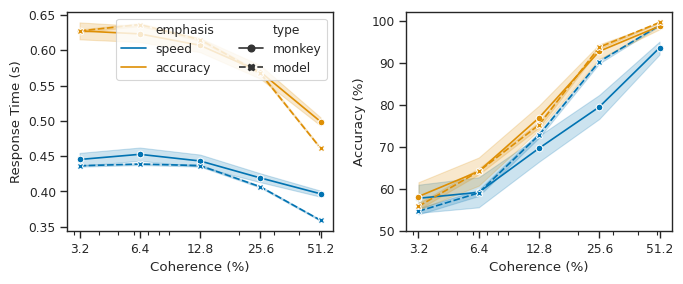

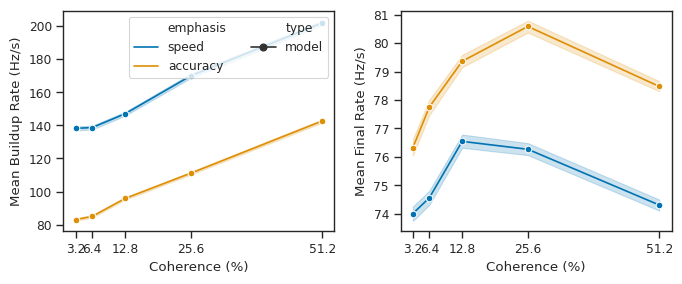

In [10]:
rerun(trials=400, name='dec27sigma06', sigma=0.6,
        ramp1=1.79, relative1=0.02, threshold1=0.33,
        ramp2=1.81, relative2=0.24, threshold2=0.44)
plot_behavior("dec27sigma06")
plot_activity("dec27sigma06")

emph speed coh 3.2 chi 0.055 med 0.01 mean 0.009
emph speed coh 6.4 chi 0.078 med 0.014 mean 0.014
emph speed coh 12.8 chi 0.078 med 0.02 mean 0.007
emph speed coh 25.6 chi 0.029 med 0.003 mean 0.013
emph speed coh 51.2 chi 0.206 med 0.034 mean 0.038
emph accuracy coh 3.2 chi 0.041 med 0.005 mean 0.0
emph accuracy coh 6.4 chi 0.052 med 0.028 mean 0.013
emph accuracy coh 12.8 chi 0.023 med 0.006 mean 0.008
emph accuracy coh 25.6 chi 0.026 med 0.003 mean 0.002
emph accuracy coh 51.2 chi 0.119 med 0.042 mean 0.038


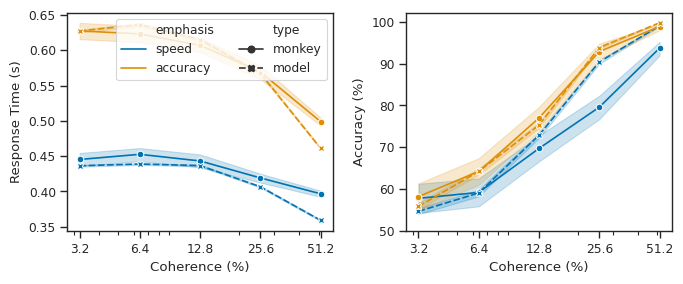

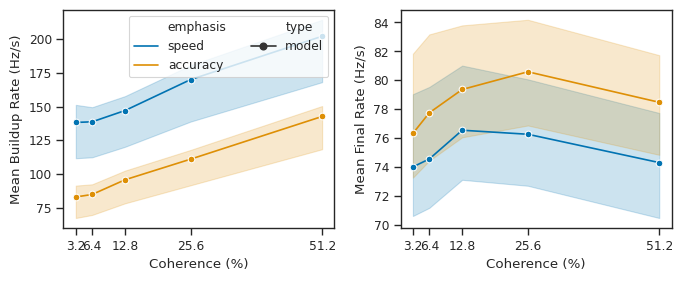

In [53]:
plot_behavior("dec27sigma06")
plot_activity("dec27sigma06", errorbar=('pi', 20))

### absolute

emph speed coh 3.2 chi 0.068 med 0.023 mean 0.007
emph speed coh 6.4 chi 0.097 med 0.017 mean 0.006
emph speed coh 12.8 chi 0.098 med 0.025 mean 0.0
emph speed coh 25.6 chi 0.011 med 0.007 mean 0.002
emph speed coh 51.2 chi 0.146 med 0.036 mean 0.033
emph accuracy coh 3.2 chi 0.085 med 0.005 mean 0.002
emph accuracy coh 6.4 chi 0.089 med 0.021 mean 0.012
emph accuracy coh 12.8 chi 0.067 med 0.022 mean 0.019
emph accuracy coh 25.6 chi 0.054 med 0.017 mean 0.017
emph accuracy coh 51.2 chi 0.01 med 0.011 mean 0.004


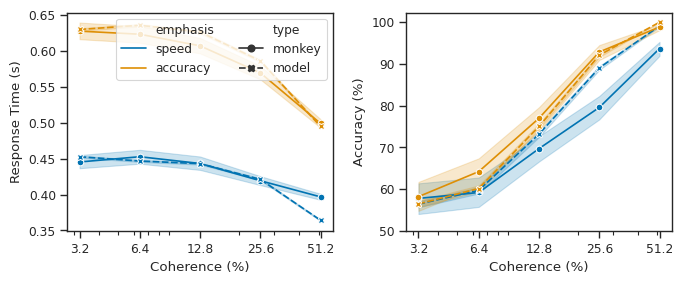

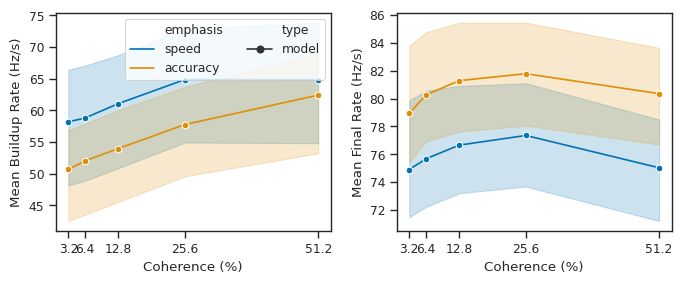

In [52]:
# rerun(trials=400, name='jan1abs', sigma=0.6,
#         ramp1=1.61, relative1=0.0, threshold1=0.31,
#         ramp2=1.81, relative2=0.0, threshold2=0.53)
plot_behavior("jan1abs")
plot_activity("jan1abs", errorbar=('pi', 20))

emph speed coh 3.2 chi 0.492 med 0.121 mean 0.227
emph speed coh 6.4 chi 0.411 med 0.101 mean 0.209
emph speed coh 12.8 chi 0.6 med 0.057 mean 0.148
emph speed coh 25.6 chi 0.511 med 0.023 mean 0.05
emph speed coh 51.2 chi 0.918 med 0.128 mean 0.102
emph accuracy coh 3.2 chi 0.437 med 0.042 mean 0.207
emph accuracy coh 6.4 chi 0.464 med 0.02 mean 0.217
emph accuracy coh 12.8 chi 0.515 med 0.01 mean 0.142
emph accuracy coh 25.6 chi 0.577 med 0.13 mean 0.035
emph accuracy coh 51.2 chi 0.974 med 0.198 mean 0.157


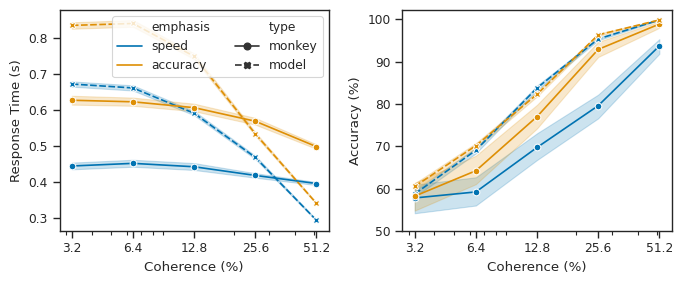

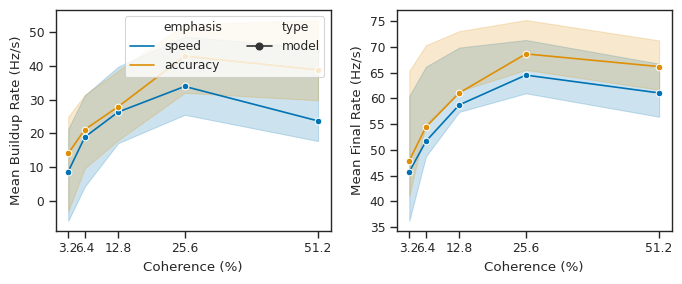

In [51]:
# rerun(trials=400, name='jan1rel', sigma=0.6,
#         ramp1=1.66, relative1=1.0, threshold1=0.12,
#         ramp2=1.48, relative2=1.0, threshold2=0.13)
plot_behavior("jan1rel")
plot_activity("jan1rel", errorbar=('pi', 20))

### Shared

emph speed coh 3.2 chi 0.107 med 0.018 mean 0.003
emph speed coh 6.4 chi 0.086 med 0.01 mean 0.013
emph speed coh 12.8 chi 0.048 med 0.014 mean 0.007
emph speed coh 25.6 chi 0.087 med 0.017 mean 0.029
emph speed coh 51.2 chi 0.524 med 0.068 mean 0.072
emph accuracy coh 3.2 chi 0.072 med 0.001 mean 0.004
emph accuracy coh 6.4 chi 0.075 med 0.022 mean 0.006
emph accuracy coh 12.8 chi 0.058 med 0.019 mean 0.008
emph accuracy coh 25.6 chi 0.034 med 0.02 mean 0.016
emph accuracy coh 51.2 chi 0.223 med 0.053 mean 0.058


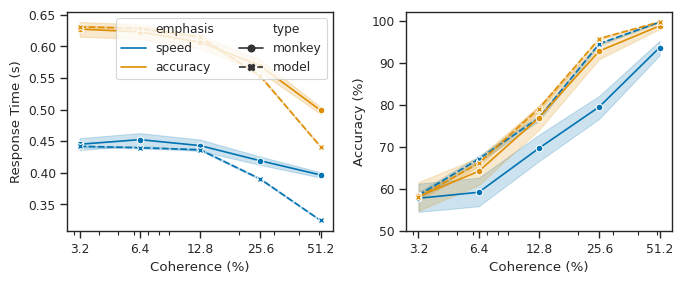

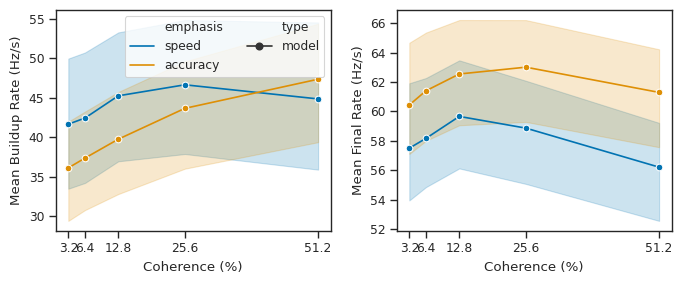

In [56]:
rerun(trials=400, name='dec29shareTL', max_rates=nengo.dists.Uniform(60, 80),
        ramp1=1.82, relative1=0.28, threshold1=0.28,
        ramp2=1.19, relative2=0.28, threshold2=0.28)
plot_behavior("dec29shareTL")
plot_activity("dec29shareTL", errorbar=('pi', 20))

emphasis speed, coherence 0.032, trial 0, RT 0.406, aligned neurons 72
emphasis speed, coherence 0.032, trial 1, RT 0.542, aligned neurons 72
emphasis speed, coherence 0.032, trial 2, RT 0.46900000000000003, aligned neurons 72
emphasis speed, coherence 0.032, trial 3, RT 0.527, aligned neurons 71
emphasis speed, coherence 0.032, trial 4, RT 0.509, aligned neurons 72
emphasis speed, coherence 0.032, trial 5, RT 0.368, aligned neurons 71
emphasis speed, coherence 0.032, trial 6, RT 0.492, aligned neurons 72
emphasis speed, coherence 0.032, trial 7, RT 0.595, aligned neurons 72
emphasis speed, coherence 0.032, trial 8, RT 0.63, aligned neurons 72
emphasis speed, coherence 0.032, trial 9, RT 0.48, aligned neurons 72
emphasis speed, coherence 0.032, trial 10, RT 0.512, aligned neurons 72
emphasis speed, coherence 0.032, trial 11, RT 0.40700000000000003, aligned neurons 72
emphasis speed, coherence 0.032, trial 12, RT 0.443, aligned neurons 72
emphasis speed, coherence 0.032, trial 13, RT 0.

emphasis speed, coherence 0.032, trial 112, RT 0.336, aligned neurons 71
emphasis speed, coherence 0.032, trial 113, RT 0.454, aligned neurons 72
emphasis speed, coherence 0.032, trial 114, RT 0.678, aligned neurons 72
emphasis speed, coherence 0.032, trial 115, RT 0.491, aligned neurons 72
emphasis speed, coherence 0.032, trial 116, RT 0.426, aligned neurons 72
emphasis speed, coherence 0.032, trial 117, RT 0.628, aligned neurons 71
emphasis speed, coherence 0.032, trial 118, RT 0.452, aligned neurons 72
emphasis speed, coherence 0.032, trial 119, RT 0.46900000000000003, aligned neurons 72
emphasis speed, coherence 0.032, trial 120, RT 0.542, aligned neurons 72
emphasis speed, coherence 0.032, trial 121, RT 0.389, aligned neurons 71
emphasis speed, coherence 0.032, trial 122, RT 0.294, aligned neurons 71
emphasis speed, coherence 0.032, trial 123, RT 0.437, aligned neurons 70
emphasis speed, coherence 0.032, trial 124, RT 0.39, aligned neurons 73
emphasis speed, coherence 0.032, trial

emphasis speed, coherence 0.032, trial 223, RT 0.383, aligned neurons 72
emphasis speed, coherence 0.032, trial 224, RT 0.466, aligned neurons 72
emphasis speed, coherence 0.032, trial 225, RT 0.449, aligned neurons 72
emphasis speed, coherence 0.032, trial 226, RT 0.44, aligned neurons 72
emphasis speed, coherence 0.032, trial 227, RT 0.358, aligned neurons 72
emphasis speed, coherence 0.032, trial 228, RT 0.461, aligned neurons 72
emphasis speed, coherence 0.032, trial 229, RT 0.362, aligned neurons 71
emphasis speed, coherence 0.032, trial 230, RT 0.398, aligned neurons 72
emphasis speed, coherence 0.032, trial 231, RT 0.488, aligned neurons 71
emphasis speed, coherence 0.032, trial 232, RT 0.41600000000000004, aligned neurons 72
emphasis speed, coherence 0.032, trial 233, RT 0.441, aligned neurons 73
emphasis speed, coherence 0.032, trial 234, RT 0.495, aligned neurons 72
emphasis speed, coherence 0.032, trial 235, RT 0.39, aligned neurons 72
emphasis speed, coherence 0.032, trial 

emphasis speed, coherence 0.032, trial 333, RT 0.323, aligned neurons 72
emphasis speed, coherence 0.032, trial 334, RT 0.457, aligned neurons 71
emphasis speed, coherence 0.032, trial 335, RT 0.643, aligned neurons 71
emphasis speed, coherence 0.032, trial 336, RT 0.426, aligned neurons 72
emphasis speed, coherence 0.032, trial 337, RT 0.665, aligned neurons 71
emphasis speed, coherence 0.032, trial 338, RT 0.379, aligned neurons 72
emphasis speed, coherence 0.032, trial 339, RT 0.615, aligned neurons 72
emphasis speed, coherence 0.032, trial 340, RT 0.48, aligned neurons 71
emphasis speed, coherence 0.032, trial 341, RT 0.465, aligned neurons 72
emphasis speed, coherence 0.032, trial 342, RT 0.335, aligned neurons 71
emphasis speed, coherence 0.032, trial 343, RT 0.46900000000000003, aligned neurons 72
emphasis speed, coherence 0.032, trial 344, RT 0.5760000000000001, aligned neurons 70
emphasis speed, coherence 0.032, trial 345, RT 0.226, aligned neurons 72
emphasis speed, coherence

emphasis speed, coherence 0.064, trial 44, RT 0.386, aligned neurons 72
emphasis speed, coherence 0.064, trial 45, RT 0.371, aligned neurons 72
emphasis speed, coherence 0.064, trial 46, RT 0.444, aligned neurons 72
emphasis speed, coherence 0.064, trial 47, RT 0.381, aligned neurons 72
emphasis speed, coherence 0.064, trial 48, RT 0.327, aligned neurons 71
emphasis speed, coherence 0.064, trial 49, RT 0.484, aligned neurons 72
emphasis speed, coherence 0.064, trial 50, RT 0.604, aligned neurons 71
emphasis speed, coherence 0.064, trial 51, RT 0.466, aligned neurons 72
emphasis speed, coherence 0.064, trial 52, RT 0.392, aligned neurons 71
emphasis speed, coherence 0.064, trial 53, RT 0.724, aligned neurons 71
emphasis speed, coherence 0.064, trial 54, RT 0.5640000000000001, aligned neurons 72
emphasis speed, coherence 0.064, trial 55, RT 0.654, aligned neurons 72
emphasis speed, coherence 0.064, trial 56, RT 0.433, aligned neurons 72
emphasis speed, coherence 0.064, trial 57, RT 0.458

emphasis speed, coherence 0.064, trial 155, RT 0.364, aligned neurons 72
emphasis speed, coherence 0.064, trial 156, RT 0.453, aligned neurons 72
emphasis speed, coherence 0.064, trial 157, RT 0.491, aligned neurons 72
emphasis speed, coherence 0.064, trial 158, RT 0.485, aligned neurons 72
emphasis speed, coherence 0.064, trial 159, RT 0.599, aligned neurons 72
emphasis speed, coherence 0.064, trial 160, RT 0.456, aligned neurons 72
emphasis speed, coherence 0.064, trial 161, RT 0.462, aligned neurons 72
emphasis speed, coherence 0.064, trial 162, RT 0.41500000000000004, aligned neurons 72
emphasis speed, coherence 0.064, trial 163, RT 0.642, aligned neurons 72
emphasis speed, coherence 0.064, trial 164, RT 0.313, aligned neurons 72
emphasis speed, coherence 0.064, trial 165, RT 0.47200000000000003, aligned neurons 72
emphasis speed, coherence 0.064, trial 166, RT 0.328, aligned neurons 71
emphasis speed, coherence 0.064, trial 167, RT 0.59, aligned neurons 72
emphasis speed, coherenc

emphasis speed, coherence 0.064, trial 266, RT 0.551, aligned neurons 71
emphasis speed, coherence 0.064, trial 267, RT 0.448, aligned neurons 72
emphasis speed, coherence 0.064, trial 268, RT 0.419, aligned neurons 72
emphasis speed, coherence 0.064, trial 269, RT 0.456, aligned neurons 71
emphasis speed, coherence 0.064, trial 270, RT 0.426, aligned neurons 71
emphasis speed, coherence 0.064, trial 271, RT 0.644, aligned neurons 72
emphasis speed, coherence 0.064, trial 272, RT 0.5630000000000001, aligned neurons 72
emphasis speed, coherence 0.064, trial 273, RT 0.387, aligned neurons 72
emphasis speed, coherence 0.064, trial 274, RT 0.402, aligned neurons 71
emphasis speed, coherence 0.064, trial 275, RT 0.577, aligned neurons 72
emphasis speed, coherence 0.064, trial 276, RT 0.394, aligned neurons 72
emphasis speed, coherence 0.064, trial 277, RT 0.503, aligned neurons 72
emphasis speed, coherence 0.064, trial 278, RT 0.529, aligned neurons 72
emphasis speed, coherence 0.064, trial

emphasis speed, coherence 0.064, trial 376, RT 0.546, aligned neurons 72
emphasis speed, coherence 0.064, trial 377, RT 0.363, aligned neurons 72
emphasis speed, coherence 0.064, trial 378, RT 0.47600000000000003, aligned neurons 72
emphasis speed, coherence 0.064, trial 379, RT 0.517, aligned neurons 72
emphasis speed, coherence 0.064, trial 380, RT 0.555, aligned neurons 72
emphasis speed, coherence 0.064, trial 381, RT 0.368, aligned neurons 72
emphasis speed, coherence 0.064, trial 382, RT 0.269, aligned neurons 72
emphasis speed, coherence 0.064, trial 383, RT 0.379, aligned neurons 71
emphasis speed, coherence 0.064, trial 384, RT 0.437, aligned neurons 71
emphasis speed, coherence 0.064, trial 385, RT 0.51, aligned neurons 72
emphasis speed, coherence 0.064, trial 386, RT 0.47600000000000003, aligned neurons 71
emphasis speed, coherence 0.064, trial 387, RT 0.435, aligned neurons 73
emphasis speed, coherence 0.064, trial 388, RT 0.421, aligned neurons 72
emphasis speed, coherenc

emphasis speed, coherence 0.128, trial 88, RT 0.531, aligned neurons 72
emphasis speed, coherence 0.128, trial 89, RT 0.381, aligned neurons 72
emphasis speed, coherence 0.128, trial 90, RT 0.391, aligned neurons 72
emphasis speed, coherence 0.128, trial 91, RT 0.47200000000000003, aligned neurons 73
emphasis speed, coherence 0.128, trial 92, RT 0.38, aligned neurons 72
emphasis speed, coherence 0.128, trial 93, RT 0.553, aligned neurons 72
emphasis speed, coherence 0.128, trial 94, RT 0.5670000000000001, aligned neurons 71
emphasis speed, coherence 0.128, trial 95, RT 0.47700000000000004, aligned neurons 72
emphasis speed, coherence 0.128, trial 96, RT 0.488, aligned neurons 73
emphasis speed, coherence 0.128, trial 97, RT 0.56, aligned neurons 72
emphasis speed, coherence 0.128, trial 98, RT 0.541, aligned neurons 72
emphasis speed, coherence 0.128, trial 99, RT 0.3, aligned neurons 72
emphasis speed, coherence 0.128, trial 100, RT 0.531, aligned neurons 72
emphasis speed, coherence 

emphasis speed, coherence 0.128, trial 198, RT 0.483, aligned neurons 71
emphasis speed, coherence 0.128, trial 199, RT 0.512, aligned neurons 71
emphasis speed, coherence 0.128, trial 200, RT 0.246, aligned neurons 72
emphasis speed, coherence 0.128, trial 201, RT 0.431, aligned neurons 72
emphasis speed, coherence 0.128, trial 202, RT 0.38, aligned neurons 72
emphasis speed, coherence 0.128, trial 203, RT 0.465, aligned neurons 72
emphasis speed, coherence 0.128, trial 204, RT 0.405, aligned neurons 72
emphasis speed, coherence 0.128, trial 205, RT 0.535, aligned neurons 72
emphasis speed, coherence 0.128, trial 206, RT 0.5, aligned neurons 70
emphasis speed, coherence 0.128, trial 207, RT 0.5670000000000001, aligned neurons 72
emphasis speed, coherence 0.128, trial 208, RT 0.421, aligned neurons 72
emphasis speed, coherence 0.128, trial 209, RT 0.39, aligned neurons 72
emphasis speed, coherence 0.128, trial 210, RT 0.368, aligned neurons 72
emphasis speed, coherence 0.128, trial 211

emphasis speed, coherence 0.128, trial 308, RT 0.434, aligned neurons 72
emphasis speed, coherence 0.128, trial 309, RT 0.382, aligned neurons 74
emphasis speed, coherence 0.128, trial 310, RT 0.501, aligned neurons 71
emphasis speed, coherence 0.128, trial 311, RT 0.41000000000000003, aligned neurons 71
emphasis speed, coherence 0.128, trial 312, RT 0.434, aligned neurons 71
emphasis speed, coherence 0.128, trial 313, RT 0.641, aligned neurons 72
emphasis speed, coherence 0.128, trial 314, RT 0.41200000000000003, aligned neurons 71
emphasis speed, coherence 0.128, trial 315, RT 0.417, aligned neurons 71
emphasis speed, coherence 0.128, trial 316, RT 0.427, aligned neurons 71
emphasis speed, coherence 0.128, trial 317, RT 0.44, aligned neurons 72
emphasis speed, coherence 0.128, trial 318, RT 0.35000000000000003, aligned neurons 71
emphasis speed, coherence 0.128, trial 319, RT 0.47300000000000003, aligned neurons 72
emphasis speed, coherence 0.128, trial 320, RT 0.47300000000000003, a

emphasis speed, coherence 0.256, trial 18, RT 0.253, aligned neurons 72
emphasis speed, coherence 0.256, trial 19, RT 0.361, aligned neurons 71
emphasis speed, coherence 0.256, trial 20, RT 0.539, aligned neurons 71
emphasis speed, coherence 0.256, trial 21, RT 0.308, aligned neurons 72
emphasis speed, coherence 0.256, trial 22, RT 0.47000000000000003, aligned neurons 71
emphasis speed, coherence 0.256, trial 23, RT 0.46900000000000003, aligned neurons 72
emphasis speed, coherence 0.256, trial 24, RT 0.426, aligned neurons 72
emphasis speed, coherence 0.256, trial 25, RT 0.42, aligned neurons 72
emphasis speed, coherence 0.256, trial 26, RT 0.343, aligned neurons 72
emphasis speed, coherence 0.256, trial 27, RT 0.424, aligned neurons 72
emphasis speed, coherence 0.256, trial 28, RT 0.465, aligned neurons 72
emphasis speed, coherence 0.256, trial 29, RT 0.387, aligned neurons 72
emphasis speed, coherence 0.256, trial 30, RT 0.301, aligned neurons 72
emphasis speed, coherence 0.256, tria

emphasis speed, coherence 0.256, trial 128, RT 0.34800000000000003, aligned neurons 72
emphasis speed, coherence 0.256, trial 129, RT 0.31, aligned neurons 72
emphasis speed, coherence 0.256, trial 130, RT 0.431, aligned neurons 72
emphasis speed, coherence 0.256, trial 131, RT 0.51, aligned neurons 71
emphasis speed, coherence 0.256, trial 132, RT 0.275, aligned neurons 72
emphasis speed, coherence 0.256, trial 133, RT 0.363, aligned neurons 72
emphasis speed, coherence 0.256, trial 134, RT 0.306, aligned neurons 72
emphasis speed, coherence 0.256, trial 135, RT 0.435, aligned neurons 72
emphasis speed, coherence 0.256, trial 136, RT 0.453, aligned neurons 72
emphasis speed, coherence 0.256, trial 137, RT 0.362, aligned neurons 72
emphasis speed, coherence 0.256, trial 138, RT 0.41300000000000003, aligned neurons 72
emphasis speed, coherence 0.256, trial 139, RT 0.331, aligned neurons 72
emphasis speed, coherence 0.256, trial 140, RT 0.34400000000000003, aligned neurons 72
emphasis sp

emphasis speed, coherence 0.256, trial 237, RT 0.253, aligned neurons 72
emphasis speed, coherence 0.256, trial 238, RT 0.313, aligned neurons 71
emphasis speed, coherence 0.256, trial 239, RT 0.47700000000000004, aligned neurons 71
emphasis speed, coherence 0.256, trial 240, RT 0.38, aligned neurons 71
emphasis speed, coherence 0.256, trial 241, RT 0.424, aligned neurons 72
emphasis speed, coherence 0.256, trial 242, RT 0.394, aligned neurons 72
emphasis speed, coherence 0.256, trial 243, RT 0.366, aligned neurons 72
emphasis speed, coherence 0.256, trial 244, RT 0.289, aligned neurons 71
emphasis speed, coherence 0.256, trial 245, RT 0.399, aligned neurons 71
emphasis speed, coherence 0.256, trial 246, RT 0.46, aligned neurons 72
emphasis speed, coherence 0.256, trial 247, RT 0.534, aligned neurons 72
emphasis speed, coherence 0.256, trial 248, RT 0.291, aligned neurons 72
emphasis speed, coherence 0.256, trial 249, RT 0.422, aligned neurons 72
emphasis speed, coherence 0.256, trial 

emphasis speed, coherence 0.256, trial 347, RT 0.544, aligned neurons 71
emphasis speed, coherence 0.256, trial 348, RT 0.317, aligned neurons 72
emphasis speed, coherence 0.256, trial 349, RT 0.481, aligned neurons 70
emphasis speed, coherence 0.256, trial 350, RT 0.314, aligned neurons 72
emphasis speed, coherence 0.256, trial 351, RT 0.509, aligned neurons 72
emphasis speed, coherence 0.256, trial 352, RT 0.301, aligned neurons 72
emphasis speed, coherence 0.256, trial 353, RT 0.539, aligned neurons 72
emphasis speed, coherence 0.256, trial 354, RT 0.425, aligned neurons 73
emphasis speed, coherence 0.256, trial 355, RT 0.373, aligned neurons 72
emphasis speed, coherence 0.256, trial 356, RT 0.53, aligned neurons 72
emphasis speed, coherence 0.256, trial 357, RT 0.34500000000000003, aligned neurons 72
emphasis speed, coherence 0.256, trial 358, RT 0.373, aligned neurons 72
emphasis speed, coherence 0.256, trial 359, RT 0.318, aligned neurons 71
emphasis speed, coherence 0.256, trial

emphasis speed, coherence 0.512, trial 57, RT 0.417, aligned neurons 72
emphasis speed, coherence 0.512, trial 58, RT 0.389, aligned neurons 72
emphasis speed, coherence 0.512, trial 59, RT 0.258, aligned neurons 72
emphasis speed, coherence 0.512, trial 60, RT 0.459, aligned neurons 72
emphasis speed, coherence 0.512, trial 61, RT 0.507, aligned neurons 71
emphasis speed, coherence 0.512, trial 62, RT 0.453, aligned neurons 72
emphasis speed, coherence 0.512, trial 63, RT 0.37, aligned neurons 72
emphasis speed, coherence 0.512, trial 64, RT 0.26, aligned neurons 72
emphasis speed, coherence 0.512, trial 65, RT 0.547, aligned neurons 73
emphasis speed, coherence 0.512, trial 66, RT 0.336, aligned neurons 72
emphasis speed, coherence 0.512, trial 67, RT 0.372, aligned neurons 71
emphasis speed, coherence 0.512, trial 68, RT 0.423, aligned neurons 72
emphasis speed, coherence 0.512, trial 69, RT 0.327, aligned neurons 72
emphasis speed, coherence 0.512, trial 70, RT 0.327, aligned neuro

emphasis speed, coherence 0.512, trial 169, RT 0.331, aligned neurons 72
emphasis speed, coherence 0.512, trial 170, RT 0.291, aligned neurons 72
emphasis speed, coherence 0.512, trial 171, RT 0.255, aligned neurons 72
emphasis speed, coherence 0.512, trial 172, RT 0.232, aligned neurons 72
emphasis speed, coherence 0.512, trial 173, RT 0.28400000000000003, aligned neurons 71
emphasis speed, coherence 0.512, trial 174, RT 0.365, aligned neurons 72
emphasis speed, coherence 0.512, trial 175, RT 0.23600000000000002, aligned neurons 71
emphasis speed, coherence 0.512, trial 176, RT 0.297, aligned neurons 72
emphasis speed, coherence 0.512, trial 177, RT 0.465, aligned neurons 71
emphasis speed, coherence 0.512, trial 178, RT 0.307, aligned neurons 71
emphasis speed, coherence 0.512, trial 179, RT 0.333, aligned neurons 72
emphasis speed, coherence 0.512, trial 180, RT 0.41500000000000004, aligned neurons 72
emphasis speed, coherence 0.512, trial 181, RT 0.35000000000000003, aligned neuron

emphasis speed, coherence 0.512, trial 278, RT 0.402, aligned neurons 72
emphasis speed, coherence 0.512, trial 279, RT 0.294, aligned neurons 72
emphasis speed, coherence 0.512, trial 280, RT 0.48, aligned neurons 72
emphasis speed, coherence 0.512, trial 281, RT 0.292, aligned neurons 71
emphasis speed, coherence 0.512, trial 282, RT 0.307, aligned neurons 72
emphasis speed, coherence 0.512, trial 283, RT 0.34800000000000003, aligned neurons 71
emphasis speed, coherence 0.512, trial 284, RT 0.358, aligned neurons 72
emphasis speed, coherence 0.512, trial 285, RT 0.34900000000000003, aligned neurons 71
emphasis speed, coherence 0.512, trial 286, RT 0.28700000000000003, aligned neurons 72
emphasis speed, coherence 0.512, trial 287, RT 0.447, aligned neurons 72
emphasis speed, coherence 0.512, trial 288, RT 0.453, aligned neurons 71
emphasis speed, coherence 0.512, trial 289, RT 0.431, aligned neurons 72
emphasis speed, coherence 0.512, trial 290, RT 0.291, aligned neurons 72
emphasis s

emphasis speed, coherence 0.512, trial 387, RT 0.323, aligned neurons 73
emphasis speed, coherence 0.512, trial 388, RT 0.309, aligned neurons 72
emphasis speed, coherence 0.512, trial 389, RT 0.257, aligned neurons 72
emphasis speed, coherence 0.512, trial 390, RT 0.328, aligned neurons 71
emphasis speed, coherence 0.512, trial 391, RT 0.268, aligned neurons 72
emphasis speed, coherence 0.512, trial 392, RT 0.271, aligned neurons 72
emphasis speed, coherence 0.512, trial 393, RT 0.28700000000000003, aligned neurons 72
emphasis speed, coherence 0.512, trial 394, RT 0.359, aligned neurons 72
emphasis speed, coherence 0.512, trial 395, RT 0.361, aligned neurons 72
emphasis speed, coherence 0.512, trial 396, RT 0.354, aligned neurons 72
emphasis speed, coherence 0.512, trial 397, RT 0.448, aligned neurons 72
emphasis speed, coherence 0.512, trial 398, RT 0.293, aligned neurons 72
emphasis speed, coherence 0.512, trial 399, RT 0.311, aligned neurons 72
emphasis accuracy, coherence 0.032, t

emphasis accuracy, coherence 0.032, trial 95, RT 0.633, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 96, RT 0.623, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 97, RT 0.659, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 98, RT 0.8160000000000001, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 99, RT 0.5650000000000001, aligned neurons 73
emphasis accuracy, coherence 0.032, trial 100, RT 0.5650000000000001, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 101, RT 0.353, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 102, RT 0.765, aligned neurons 71
emphasis accuracy, coherence 0.032, trial 103, RT 0.634, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 104, RT 0.467, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 105, RT 0.546, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 106, RT 0.562, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 107, RT 0.79

emphasis accuracy, coherence 0.032, trial 202, RT 0.625, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 203, RT 0.726, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 204, RT 0.785, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 205, RT 0.528, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 206, RT 0.665, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 207, RT 0.834, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 208, RT 0.677, aligned neurons 71
emphasis accuracy, coherence 0.032, trial 209, RT 0.782, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 210, RT 0.451, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 211, RT 0.496, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 212, RT 0.918, aligned neurons 71
emphasis accuracy, coherence 0.032, trial 213, RT 0.64, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 214, RT 0.398, aligned neurons 71
emphasis accu

emphasis accuracy, coherence 0.032, trial 308, RT 0.594, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 309, RT 0.775, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 310, RT 0.5650000000000001, aligned neurons 71
emphasis accuracy, coherence 0.032, trial 311, RT 0.513, aligned neurons 71
emphasis accuracy, coherence 0.032, trial 312, RT 0.871, aligned neurons 71
emphasis accuracy, coherence 0.032, trial 313, RT 0.835, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 314, RT 0.835, aligned neurons 71
emphasis accuracy, coherence 0.032, trial 315, RT 0.678, aligned neurons 71
emphasis accuracy, coherence 0.032, trial 316, RT 0.81, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 317, RT 0.761, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 318, RT 0.654, aligned neurons 71
emphasis accuracy, coherence 0.032, trial 319, RT 0.627, aligned neurons 72
emphasis accuracy, coherence 0.032, trial 320, RT 0.47900000000000004, align

emphasis accuracy, coherence 0.064, trial 13, RT 0.6950000000000001, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 14, RT 0.605, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 15, RT 0.712, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 16, RT 0.78, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 17, RT 0.542, aligned neurons 71
emphasis accuracy, coherence 0.064, trial 18, RT 0.62, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 19, RT 0.5710000000000001, aligned neurons 71
emphasis accuracy, coherence 0.064, trial 20, RT 0.646, aligned neurons 71
emphasis accuracy, coherence 0.064, trial 21, RT 0.5660000000000001, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 22, RT 0.792, aligned neurons 71
emphasis accuracy, coherence 0.064, trial 23, RT 1.0230000000000001, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 24, RT 0.634, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 25, RT 0

emphasis accuracy, coherence 0.064, trial 119, RT 0.769, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 120, RT 0.374, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 121, RT 0.871, aligned neurons 71
emphasis accuracy, coherence 0.064, trial 122, RT 0.62, aligned neurons 71
emphasis accuracy, coherence 0.064, trial 123, RT 0.653, aligned neurons 70
emphasis accuracy, coherence 0.064, trial 124, RT 0.636, aligned neurons 73
emphasis accuracy, coherence 0.064, trial 125, RT 0.897, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 126, RT 0.675, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 127, RT 0.643, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 128, RT 0.73, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 129, RT 0.47900000000000004, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 130, RT 0.587, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 131, RT 0.754, aligned neurons 71


emphasis accuracy, coherence 0.064, trial 225, RT 0.862, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 226, RT 0.652, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 227, RT 0.555, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 228, RT 0.657, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 229, RT 0.765, aligned neurons 71
emphasis accuracy, coherence 0.064, trial 230, RT 0.512, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 231, RT 0.46, aligned neurons 71
emphasis accuracy, coherence 0.064, trial 232, RT 0.5650000000000001, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 233, RT 0.638, aligned neurons 73
emphasis accuracy, coherence 0.064, trial 234, RT 0.679, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 235, RT 0.759, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 236, RT 0.514, aligned neurons 70
emphasis accuracy, coherence 0.064, trial 237, RT 0.724, aligned neurons 72


emphasis accuracy, coherence 0.064, trial 332, RT 0.766, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 333, RT 0.585, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 334, RT 0.47900000000000004, aligned neurons 71
emphasis accuracy, coherence 0.064, trial 335, RT 0.612, aligned neurons 71
emphasis accuracy, coherence 0.064, trial 336, RT 0.643, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 337, RT 0.511, aligned neurons 71
emphasis accuracy, coherence 0.064, trial 338, RT 0.72, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 339, RT 0.56, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 340, RT 0.624, aligned neurons 71
emphasis accuracy, coherence 0.064, trial 341, RT 0.621, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 342, RT 0.675, aligned neurons 71
emphasis accuracy, coherence 0.064, trial 343, RT 0.755, aligned neurons 72
emphasis accuracy, coherence 0.064, trial 344, RT 0.773, aligned neurons 70


emphasis accuracy, coherence 0.128, trial 38, RT 0.635, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 39, RT 0.644, aligned neurons 71
emphasis accuracy, coherence 0.128, trial 40, RT 0.623, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 41, RT 0.549, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 42, RT 0.545, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 43, RT 0.631, aligned neurons 71
emphasis accuracy, coherence 0.128, trial 44, RT 0.605, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 45, RT 0.713, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 46, RT 0.589, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 47, RT 0.539, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 48, RT 0.617, aligned neurons 71
emphasis accuracy, coherence 0.128, trial 49, RT 0.686, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 50, RT 0.547, aligned neurons 73
emphasis accuracy, cohere

emphasis accuracy, coherence 0.128, trial 145, RT 0.605, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 146, RT 0.546, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 147, RT 0.723, aligned neurons 70
emphasis accuracy, coherence 0.128, trial 148, RT 0.671, aligned neurons 71
emphasis accuracy, coherence 0.128, trial 149, RT 0.491, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 150, RT 0.6980000000000001, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 151, RT 0.528, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 152, RT 0.554, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 153, RT 0.629, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 154, RT 0.746, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 155, RT 0.812, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 156, RT 0.776, aligned neurons 73
emphasis accuracy, coherence 0.128, trial 157, RT 0.675, aligned neurons 72

emphasis accuracy, coherence 0.128, trial 252, RT 0.5750000000000001, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 253, RT 0.761, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 254, RT 0.778, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 255, RT 0.711, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 256, RT 0.502, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 257, RT 1.02, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 258, RT 0.591, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 259, RT 0.655, aligned neurons 71
emphasis accuracy, coherence 0.128, trial 260, RT 0.656, aligned neurons 71
emphasis accuracy, coherence 0.128, trial 261, RT 0.598, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 262, RT 0.712, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 263, RT 0.779, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 264, RT 0.636, aligned neurons 72


emphasis accuracy, coherence 0.128, trial 359, RT 0.531, aligned neurons 71
emphasis accuracy, coherence 0.128, trial 360, RT 0.496, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 361, RT 0.577, aligned neurons 71
emphasis accuracy, coherence 0.128, trial 362, RT 0.52, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 363, RT 0.685, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 364, RT 0.5660000000000001, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 365, RT 0.665, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 366, RT 0.8130000000000001, aligned neurons 71
emphasis accuracy, coherence 0.128, trial 367, RT 0.679, aligned neurons 70
emphasis accuracy, coherence 0.128, trial 368, RT 0.781, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 369, RT 0.789, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 370, RT 0.677, aligned neurons 72
emphasis accuracy, coherence 0.128, trial 371, RT 0.651, aligne

emphasis accuracy, coherence 0.256, trial 66, RT 0.682, aligned neurons 70
emphasis accuracy, coherence 0.256, trial 67, RT 0.7030000000000001, aligned neurons 71
emphasis accuracy, coherence 0.256, trial 68, RT 0.553, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 69, RT 0.6890000000000001, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 70, RT 0.5690000000000001, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 71, RT 0.359, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 72, RT 0.467, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 73, RT 0.687, aligned neurons 71
emphasis accuracy, coherence 0.256, trial 74, RT 0.595, aligned neurons 71
emphasis accuracy, coherence 0.256, trial 75, RT 0.536, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 76, RT 0.383, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 77, RT 0.5, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 78, RT 0.477000000000

emphasis accuracy, coherence 0.256, trial 172, RT 0.786, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 173, RT 0.6920000000000001, aligned neurons 71
emphasis accuracy, coherence 0.256, trial 174, RT 0.559, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 175, RT 0.526, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 176, RT 0.552, aligned neurons 71
emphasis accuracy, coherence 0.256, trial 177, RT 0.489, aligned neurons 71
emphasis accuracy, coherence 0.256, trial 178, RT 0.527, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 179, RT 0.376, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 180, RT 0.7020000000000001, aligned neurons 70
emphasis accuracy, coherence 0.256, trial 181, RT 0.494, aligned neurons 73
emphasis accuracy, coherence 0.256, trial 182, RT 0.448, aligned neurons 71
emphasis accuracy, coherence 0.256, trial 183, RT 0.674, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 184, RT 0.714, align

emphasis accuracy, coherence 0.256, trial 278, RT 0.652, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 279, RT 0.53, aligned neurons 73
emphasis accuracy, coherence 0.256, trial 280, RT 0.47500000000000003, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 281, RT 0.562, aligned neurons 70
emphasis accuracy, coherence 0.256, trial 282, RT 0.47100000000000003, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 283, RT 0.676, aligned neurons 71
emphasis accuracy, coherence 0.256, trial 284, RT 0.47200000000000003, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 285, RT 0.836, aligned neurons 71
emphasis accuracy, coherence 0.256, trial 286, RT 0.354, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 287, RT 0.437, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 288, RT 0.47100000000000003, aligned neurons 71
emphasis accuracy, coherence 0.256, trial 289, RT 0.636, aligned neurons 72
emphasis accuracy, coherence 0.25

emphasis accuracy, coherence 0.256, trial 384, RT 0.454, aligned neurons 71
emphasis accuracy, coherence 0.256, trial 385, RT 0.46900000000000003, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 386, RT 0.598, aligned neurons 70
emphasis accuracy, coherence 0.256, trial 387, RT 0.40900000000000003, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 388, RT 0.583, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 389, RT 0.622, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 390, RT 0.606, aligned neurons 73
emphasis accuracy, coherence 0.256, trial 391, RT 0.512, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 392, RT 0.578, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 393, RT 0.647, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 394, RT 0.489, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 395, RT 0.682, aligned neurons 72
emphasis accuracy, coherence 0.256, trial 396, RT 0.441, ali

emphasis accuracy, coherence 0.512, trial 90, RT 0.52, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 91, RT 0.507, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 92, RT 0.467, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 93, RT 0.34800000000000003, aligned neurons 71
emphasis accuracy, coherence 0.512, trial 94, RT 0.544, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 95, RT 0.359, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 96, RT 0.531, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 97, RT 0.484, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 98, RT 0.546, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 99, RT 0.47900000000000004, aligned neurons 73
emphasis accuracy, coherence 0.512, trial 100, RT 0.483, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 101, RT 0.429, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 102, RT 0.5720000000000001, a

emphasis accuracy, coherence 0.512, trial 195, RT 0.34400000000000003, aligned neurons 71
emphasis accuracy, coherence 0.512, trial 196, RT 0.426, aligned neurons 71
emphasis accuracy, coherence 0.512, trial 197, RT 0.518, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 198, RT 0.365, aligned neurons 71
emphasis accuracy, coherence 0.512, trial 199, RT 0.41100000000000003, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 200, RT 0.443, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 201, RT 0.354, aligned neurons 71
emphasis accuracy, coherence 0.512, trial 202, RT 0.44, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 203, RT 0.422, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 204, RT 0.387, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 205, RT 0.526, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 206, RT 0.461, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 207, RT 0.444, alig

emphasis accuracy, coherence 0.512, trial 300, RT 0.486, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 301, RT 0.354, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 302, RT 0.547, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 303, RT 0.354, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 304, RT 0.34800000000000003, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 305, RT 0.328, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 306, RT 0.371, aligned neurons 70
emphasis accuracy, coherence 0.512, trial 307, RT 0.509, aligned neurons 71
emphasis accuracy, coherence 0.512, trial 308, RT 0.439, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 309, RT 0.427, aligned neurons 72
emphasis accuracy, coherence 0.512, trial 310, RT 0.41200000000000003, aligned neurons 71
emphasis accuracy, coherence 0.512, trial 311, RT 0.355, aligned neurons 71
emphasis accuracy, coherence 0.512, trial 312, RT 0.448, ali

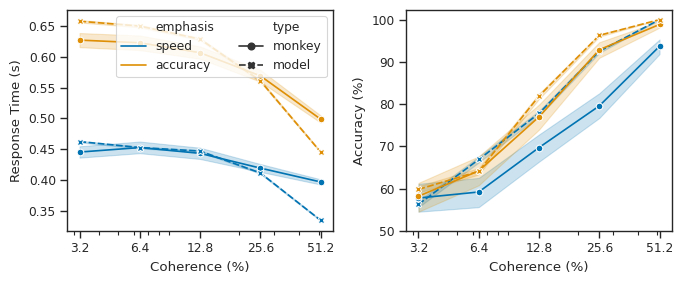

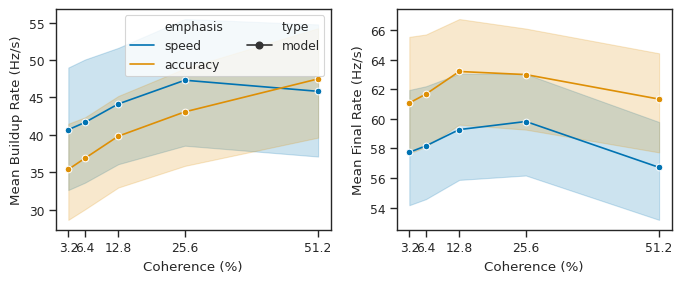

In [55]:
rerun(trials=400, name='dec29shareRL', max_rates=nengo.dists.Uniform(60, 80),
        ramp1=1.91, relative1=0.31, threshold1=0.3,
        ramp2=1.91, relative2=0.31, threshold2=0.45)
plot_behavior("dec29shareRL")
plot_activity("dec29shareRL", errorbar=('pi', 20))

In [ ]:
rerun(trials=400, name='dec29shareRT', max_rates=nengo.dists.Uniform(60, 80),
        ramp1=1.15, relative1=0.02, threshold1=0.22,
        ramp2=1.15, relative2=0.45, threshold2=0.22)
plot_behavior("dec29shareRT")
plot_activity("dec29shareRT", errorbar=('pi', 20))

emphasis speed, coherence 0.032, trial 0, RT 0.40900000000000003, aligned neurons 72
emphasis speed, coherence 0.032, trial 1, RT 0.52, aligned neurons 72
emphasis speed, coherence 0.032, trial 2, RT 0.455, aligned neurons 72
emphasis speed, coherence 0.032, trial 3, RT 0.502, aligned neurons 71
emphasis speed, coherence 0.032, trial 4, RT 0.535, aligned neurons 72
emphasis speed, coherence 0.032, trial 5, RT 0.38, aligned neurons 71
emphasis speed, coherence 0.032, trial 6, RT 0.418, aligned neurons 72
emphasis speed, coherence 0.032, trial 7, RT 0.34900000000000003, aligned neurons 72
emphasis speed, coherence 0.032, trial 8, RT 0.449, aligned neurons 72
emphasis speed, coherence 0.032, trial 9, RT 0.633, aligned neurons 72
emphasis speed, coherence 0.032, trial 10, RT 0.431, aligned neurons 72
emphasis speed, coherence 0.032, trial 11, RT 0.449, aligned neurons 72
emphasis speed, coherence 0.032, trial 12, RT 0.355, aligned neurons 72
emphasis speed, coherence 0.032, trial 13, RT 0.

emphasis speed, coherence 0.032, trial 112, RT 0.437, aligned neurons 71
emphasis speed, coherence 0.032, trial 113, RT 0.454, aligned neurons 72
emphasis speed, coherence 0.032, trial 114, RT 0.485, aligned neurons 72
emphasis speed, coherence 0.032, trial 115, RT 0.35000000000000003, aligned neurons 72
emphasis speed, coherence 0.032, trial 116, RT 0.41600000000000004, aligned neurons 72
emphasis speed, coherence 0.032, trial 117, RT 0.44, aligned neurons 71
emphasis speed, coherence 0.032, trial 118, RT 0.365, aligned neurons 72
emphasis speed, coherence 0.032, trial 119, RT 0.487, aligned neurons 72
emphasis speed, coherence 0.032, trial 120, RT 0.522, aligned neurons 72
emphasis speed, coherence 0.032, trial 121, RT 0.46, aligned neurons 71
emphasis speed, coherence 0.032, trial 122, RT 0.43, aligned neurons 71
emphasis speed, coherence 0.032, trial 123, RT 0.382, aligned neurons 70
emphasis speed, coherence 0.032, trial 124, RT 0.556, aligned neurons 73
emphasis speed, coherence 

emphasis speed, coherence 0.032, trial 220, RT 0.623, aligned neurons 72
emphasis speed, coherence 0.032, trial 221, RT 0.423, aligned neurons 72
emphasis speed, coherence 0.032, trial 222, RT 0.47700000000000004, aligned neurons 72
emphasis speed, coherence 0.032, trial 223, RT 0.548, aligned neurons 72
emphasis speed, coherence 0.032, trial 224, RT 0.41400000000000003, aligned neurons 72
emphasis speed, coherence 0.032, trial 225, RT 0.559, aligned neurons 72
emphasis speed, coherence 0.032, trial 226, RT 0.5640000000000001, aligned neurons 72
emphasis speed, coherence 0.032, trial 227, RT 0.454, aligned neurons 72
emphasis speed, coherence 0.032, trial 228, RT 0.483, aligned neurons 72
emphasis speed, coherence 0.032, trial 229, RT 0.336, aligned neurons 71
emphasis speed, coherence 0.032, trial 230, RT 0.429, aligned neurons 72
emphasis speed, coherence 0.032, trial 231, RT 0.426, aligned neurons 71
emphasis speed, coherence 0.032, trial 232, RT 0.47400000000000003, aligned neurons

emphasis speed, coherence 0.032, trial 329, RT 0.436, aligned neurons 71
emphasis speed, coherence 0.032, trial 330, RT 0.458, aligned neurons 72
emphasis speed, coherence 0.032, trial 331, RT 0.321, aligned neurons 72
emphasis speed, coherence 0.032, trial 332, RT 0.40800000000000003, aligned neurons 72
emphasis speed, coherence 0.032, trial 333, RT 0.373, aligned neurons 72
emphasis speed, coherence 0.032, trial 334, RT 0.492, aligned neurons 71
emphasis speed, coherence 0.032, trial 335, RT 0.46900000000000003, aligned neurons 71
emphasis speed, coherence 0.032, trial 336, RT 0.306, aligned neurons 72
emphasis speed, coherence 0.032, trial 337, RT 0.404, aligned neurons 71
emphasis speed, coherence 0.032, trial 338, RT 0.41100000000000003, aligned neurons 72
emphasis speed, coherence 0.032, trial 339, RT 0.47200000000000003, aligned neurons 72
emphasis speed, coherence 0.032, trial 340, RT 0.553, aligned neurons 71
emphasis speed, coherence 0.032, trial 341, RT 0.354, aligned neuron

emphasis speed, coherence 0.064, trial 40, RT 0.333, aligned neurons 72
emphasis speed, coherence 0.064, trial 41, RT 0.497, aligned neurons 72
emphasis speed, coherence 0.064, trial 42, RT 0.47200000000000003, aligned neurons 72
emphasis speed, coherence 0.064, trial 43, RT 0.435, aligned neurons 71
emphasis speed, coherence 0.064, trial 44, RT 0.551, aligned neurons 72
emphasis speed, coherence 0.064, trial 45, RT 0.392, aligned neurons 72
emphasis speed, coherence 0.064, trial 46, RT 0.497, aligned neurons 72
emphasis speed, coherence 0.064, trial 47, RT 0.446, aligned neurons 72
emphasis speed, coherence 0.064, trial 48, RT 0.311, aligned neurons 71
emphasis speed, coherence 0.064, trial 49, RT 0.402, aligned neurons 72
emphasis speed, coherence 0.064, trial 50, RT 0.442, aligned neurons 73
emphasis speed, coherence 0.064, trial 51, RT 0.539, aligned neurons 73
emphasis speed, coherence 0.064, trial 52, RT 0.379, aligned neurons 71
emphasis speed, coherence 0.064, trial 53, RT 0.39

emphasis speed, coherence 0.064, trial 151, RT 0.353, aligned neurons 72
emphasis speed, coherence 0.064, trial 152, RT 0.342, aligned neurons 72
emphasis speed, coherence 0.064, trial 153, RT 0.382, aligned neurons 72
emphasis speed, coherence 0.064, trial 154, RT 0.403, aligned neurons 72
emphasis speed, coherence 0.064, trial 155, RT 0.442, aligned neurons 72
emphasis speed, coherence 0.064, trial 156, RT 0.422, aligned neurons 73
emphasis speed, coherence 0.064, trial 157, RT 0.339, aligned neurons 72
emphasis speed, coherence 0.064, trial 158, RT 0.452, aligned neurons 71
emphasis speed, coherence 0.064, trial 159, RT 0.505, aligned neurons 72
emphasis speed, coherence 0.064, trial 160, RT 0.336, aligned neurons 72
emphasis speed, coherence 0.064, trial 161, RT 0.493, aligned neurons 72
emphasis speed, coherence 0.064, trial 162, RT 0.541, aligned neurons 72
emphasis speed, coherence 0.064, trial 163, RT 0.539, aligned neurons 72
emphasis speed, coherence 0.064, trial 164, RT 0.41

emphasis speed, coherence 0.064, trial 261, RT 0.457, aligned neurons 72
emphasis speed, coherence 0.064, trial 262, RT 0.41500000000000004, aligned neurons 72
emphasis speed, coherence 0.064, trial 263, RT 0.47800000000000004, aligned neurons 72
emphasis speed, coherence 0.064, trial 264, RT 0.648, aligned neurons 72
emphasis speed, coherence 0.064, trial 265, RT 0.383, aligned neurons 72
emphasis speed, coherence 0.064, trial 266, RT 0.356, aligned neurons 71
emphasis speed, coherence 0.064, trial 267, RT 0.47000000000000003, aligned neurons 72
emphasis speed, coherence 0.064, trial 268, RT 0.386, aligned neurons 72
emphasis speed, coherence 0.064, trial 269, RT 0.403, aligned neurons 71
emphasis speed, coherence 0.064, trial 270, RT 0.47900000000000004, aligned neurons 72
emphasis speed, coherence 0.064, trial 271, RT 0.541, aligned neurons 72
emphasis speed, coherence 0.064, trial 272, RT 0.391, aligned neurons 72
emphasis speed, coherence 0.064, trial 273, RT 0.371, aligned neuron

emphasis speed, coherence 0.064, trial 371, RT 0.394, aligned neurons 72
emphasis speed, coherence 0.064, trial 372, RT 0.559, aligned neurons 73
emphasis speed, coherence 0.064, trial 373, RT 0.438, aligned neurons 72
emphasis speed, coherence 0.064, trial 374, RT 0.526, aligned neurons 73
emphasis speed, coherence 0.064, trial 375, RT 0.319, aligned neurons 72
emphasis speed, coherence 0.064, trial 376, RT 0.442, aligned neurons 71
emphasis speed, coherence 0.064, trial 377, RT 0.434, aligned neurons 73
emphasis speed, coherence 0.064, trial 378, RT 0.494, aligned neurons 72
emphasis speed, coherence 0.064, trial 379, RT 0.47400000000000003, aligned neurons 72
emphasis speed, coherence 0.064, trial 380, RT 0.587, aligned neurons 72
emphasis speed, coherence 0.064, trial 381, RT 0.396, aligned neurons 72
emphasis speed, coherence 0.064, trial 382, RT 0.605, aligned neurons 72
emphasis speed, coherence 0.064, trial 383, RT 0.41100000000000003, aligned neurons 71
emphasis speed, coheren

emphasis speed, coherence 0.128, trial 82, RT 0.4, aligned neurons 72
emphasis speed, coherence 0.128, trial 83, RT 0.424, aligned neurons 72
emphasis speed, coherence 0.128, trial 84, RT 0.524, aligned neurons 72
emphasis speed, coherence 0.128, trial 85, RT 0.372, aligned neurons 72
emphasis speed, coherence 0.128, trial 86, RT 0.645, aligned neurons 72
emphasis speed, coherence 0.128, trial 87, RT 0.386, aligned neurons 71
emphasis speed, coherence 0.128, trial 88, RT 0.442, aligned neurons 71
emphasis speed, coherence 0.128, trial 89, RT 0.553, aligned neurons 72
emphasis speed, coherence 0.128, trial 90, RT 0.5730000000000001, aligned neurons 72
emphasis speed, coherence 0.128, trial 91, RT 0.41300000000000003, aligned neurons 72
emphasis speed, coherence 0.128, trial 92, RT 0.316, aligned neurons 72
emphasis speed, coherence 0.128, trial 93, RT 0.451, aligned neurons 71
emphasis speed, coherence 0.128, trial 94, RT 0.373, aligned neurons 72
emphasis speed, coherence 0.128, trial 

emphasis speed, coherence 0.128, trial 192, RT 0.464, aligned neurons 73
emphasis speed, coherence 0.128, trial 193, RT 0.434, aligned neurons 72
emphasis speed, coherence 0.128, trial 194, RT 0.397, aligned neurons 72
emphasis speed, coherence 0.128, trial 195, RT 0.354, aligned neurons 71
emphasis speed, coherence 0.128, trial 196, RT 0.397, aligned neurons 71
emphasis speed, coherence 0.128, trial 197, RT 0.456, aligned neurons 72
emphasis speed, coherence 0.128, trial 198, RT 0.41000000000000003, aligned neurons 71
emphasis speed, coherence 0.128, trial 199, RT 0.375, aligned neurons 72
emphasis speed, coherence 0.128, trial 200, RT 0.418, aligned neurons 72
emphasis speed, coherence 0.128, trial 201, RT 0.368, aligned neurons 71
emphasis speed, coherence 0.128, trial 202, RT 0.443, aligned neurons 72
emphasis speed, coherence 0.128, trial 203, RT 0.328, aligned neurons 72
emphasis speed, coherence 0.128, trial 204, RT 0.557, aligned neurons 72
emphasis speed, coherence 0.128, tria

emphasis speed, coherence 0.128, trial 301, RT 0.369, aligned neurons 72
emphasis speed, coherence 0.128, trial 302, RT 0.315, aligned neurons 72
emphasis speed, coherence 0.128, trial 303, RT 0.729, aligned neurons 72
emphasis speed, coherence 0.128, trial 304, RT 0.41200000000000003, aligned neurons 72
emphasis speed, coherence 0.128, trial 305, RT 0.466, aligned neurons 72
emphasis speed, coherence 0.128, trial 306, RT 0.32, aligned neurons 70
emphasis speed, coherence 0.128, trial 307, RT 0.464, aligned neurons 71
emphasis speed, coherence 0.128, trial 308, RT 0.404, aligned neurons 72
emphasis speed, coherence 0.128, trial 309, RT 0.374, aligned neurons 72
emphasis speed, coherence 0.128, trial 310, RT 0.317, aligned neurons 71
emphasis speed, coherence 0.128, trial 311, RT 0.736, aligned neurons 71
emphasis speed, coherence 0.128, trial 312, RT 0.441, aligned neurons 71
emphasis speed, coherence 0.128, trial 313, RT 0.452, aligned neurons 72
emphasis speed, coherence 0.128, trial

emphasis speed, coherence 0.256, trial 12, RT 0.404, aligned neurons 71
emphasis speed, coherence 0.256, trial 13, RT 0.354, aligned neurons 72


## empirical dataframe

In [57]:
emp = scipy.io.loadmat("data/psthData.mat", simplify_cells=True)

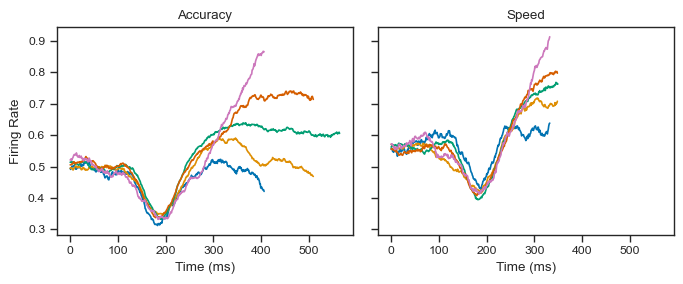

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((7, 3)), sharey=True, sharex=True)
sns.lineplot(emp['psth_forBo_acc'][0], color=palette[0], ax=axes[0])
sns.lineplot(emp['psth_forBo_acc'][1], color=palette[1], ax=axes[0])
sns.lineplot(emp['psth_forBo_acc'][2], color=palette[2], ax=axes[0])
sns.lineplot(emp['psth_forBo_acc'][3], color=palette[3], ax=axes[0])
sns.lineplot(emp['psth_forBo_acc'][4], color=palette[4], ax=axes[0])
sns.lineplot(emp['psth_forBo_sp'][0], color=palette[0], ax=axes[1])
sns.lineplot(emp['psth_forBo_sp'][1], color=palette[1], ax=axes[1])
sns.lineplot(emp['psth_forBo_sp'][2], color=palette[2], ax=axes[1])
sns.lineplot(emp['psth_forBo_sp'][3], color=palette[3], ax=axes[1])
sns.lineplot(emp['psth_forBo_sp'][4], color=palette[4], ax=axes[1])
axes[0].set(ylabel='Firing Rate', xlabel='Time (ms)', title='Accuracy')
axes[1].set(xlabel='Time (ms)', title='Speed')
plt.tight_layout()
fig.savefig(f"plots/hanks_psth.png", dpi=600)

In [43]:
def plot_shared(name1, name2, name3, pid="E", estimator=np.mean, errorbar=('pi', 20), bins=np.arange(0.0, 1.5, 0.1)):
    data1 = pd.read_pickle(f"data/{name1}.pkl")
    data2 = pd.read_pickle(f"data/{name2}.pkl")
    data3 = pd.read_pickle(f"data/{name3}.pkl")
    cohs = data1['coherence'].unique()
    hanks = pd.read_pickle("data/hanks2014_behavior.pkl").query("id==@pid")

    fig, axes = plt.subplots(nrows=4, ncols=3, sharex=True, figsize=((7, 6)))
    for i in range(3):
        data = [data1, data2, data3][i]
        combined = pd.concat([hanks, data]).query("coherence>0")
        sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='RT', hue='emphasis',
                     palette=palette[:2], markers=True, ax=axes[0][i],
                     style='type', estimator=estimator)
        sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='accuracy', hue='emphasis',
                     style='type', palette=palette[:2], markers=True, ax=axes[1][i])
        sns.lineplot(data=data, x='coherence', y='mean buildup rate', hue='emphasis',
                     palette=palette[:2], markers=True, ax=axes[2][i], style='type',
                     errorbar=errorbar, estimator=estimator)
        sns.lineplot(data=data, x='coherence', y='mean final rate', hue='emphasis',
                     palette=palette[:2], markers=True, ax=axes[3][i], style='type',
                     errorbar=errorbar, estimator=estimator)
        
#     axes[0][0].legend(ncols=1, loc='upper right')
#     axes[0][3].legend(ncols=1, loc='upper right')
    for i in range(3):
        axes[0][i].set(ylabel=None, xscale='log', xlabel="Coherence (%)")
        axes[1][i].set(ylabel=None, xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", yticks=[50,60,70,80,90,100])
        axes[2][i].set(ylabel=None, xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)")
        axes[3][i].set(ylabel=None, xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)")
#         if i>0:
        axes[0][i].get_legend().remove()
        axes[1][i].get_legend().remove()
        axes[2][i].get_legend().remove()
        axes[3][i].get_legend().remove()
#     axes[0][0].set(ylabel=f"{name1}")
#     axes[1][0].set(ylabel=f"{name2}")
#     axes[2][0].set(ylabel=f"{name3}")
    axes[0][0].set(title=r"$T$")
    axes[0][1].set(title=r"$L$")
    axes[0][2].set(title=r"$R$")
    axes[0][0].set(ylabel="Response\nTime (s)")
    axes[1][0].set(ylabel="Accuracy\n(%)")
    axes[2][0].set(ylabel="Buildup\nRate (Hz/s)")
    axes[3][0].set(ylabel="Final\nRate (Hz/s)")
    plt.tight_layout()
    fig.savefig(f"plots/hanks_shared.png", dpi=600)

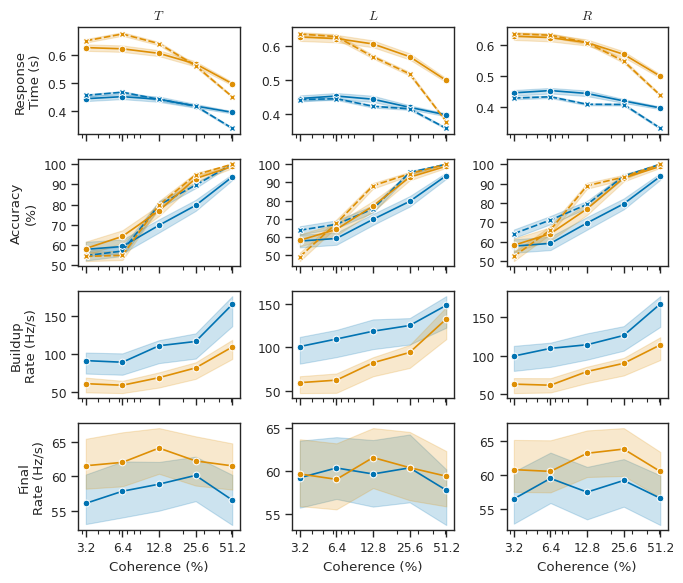

In [44]:
plot_shared("dec29shareRL", "dec29shareRT", "dec29shareTL")